# Analysis of the Relationship between Life Expectancy and Number of Parks, Museums, and Hospitals per California Zip Codes 

# ==============================================================
# Park Analysis:

In [1]:
# Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import datetime
from api_keys import api_key
import json
from pprint import pprint
import time
from api_keys import yelp_api
from api_keys import yelp_api_second
from api_keys import yelp_clientID
import csv
import matplotlib.pylab as plb
from scipy import stats
import statsmodels.api as sm

### Read in zipcode and life expectancy data, Create DataFrames 

In [2]:
# Read in life expectancy by tract ID data
lifeExp_tractID = pd.read_csv('data/CA_LifeExp_TractID.CSV')

# Read in the tract to zip code data:
tract_to_zip = pd.read_excel('data/TRACT_ZIP_092019.xlsx')

# Create DataFrame for life expectancy by tract ID data
lifeExp_tractID_df = pd.DataFrame(lifeExp_tractID)

# Filter out only tract ID and life expectancy
lifeExp_tractID_df = lifeExp_tractID_df[['Tract ID','e(0)']]

# Rename life expectancy column
lifeExp_tractID_df = lifeExp_tractID_df.rename(columns={'e(0)':'Life Expectancy'})

# Create DataFrame with tract to zip data
tract_to_zip_df = pd.DataFrame(tract_to_zip)

# Filter out only tract ID and zip code
tract_to_zip_df = tract_to_zip_df[['tract','zip']]

# Rename tract column to tract ID
tract_to_zip_df = tract_to_zip_df.rename(columns={'tract':'Tract ID'})

# Merge the two DataFrames to have tract ID, life expectancy and zip code
test_df = pd.merge(lifeExp_tractID_df,tract_to_zip_df)

# Group by zip code and take mean of life expectancies per zip code
mean_df = test_df.groupby('zip').mean()

# Clean data: drop tract ID column
mean_df = mean_df.drop(columns=['Tract ID'])

# Create list of all zip codes as strings, to pass in each API call
zip_strings = [str(zip) for zip in mean_df.index.values]

# Create a copy of mean_df DataFrame
park_df = mean_df.copy()

# Preview DataFrame
park_df.head()

Life Expectancy
zip                   
90001        77.733333
90002        76.537500
90003        76.560606
90004        81.928571
90005        80.481818

## Yelp Search
### First 1000 zip codes

In [29]:
#--------STORE DATA FOR FIRST 1000 ZIP CODES INTO CSV FILE--------
all_parks = []
all_zips = []
park_per_zip = []
park_names_per_zip = []
park_zip_list=[]
life_exp_list=[]

num_request=1

#----- first 1000 zip codes-----
for zipName in zip_strings[0:1000]:
    print('\n-----------------------------------------------')
    print('-----------------------------------------------')
    print(f'{num_request}. Parks in {zipName}')
    num_request +=1
    print('-----------------------------------------------')

    url = 'https://api.yelp.com/v3/businesses/search'

    offset=0
    params = {
        'Authorization': yelp_api,
        'term':'Park',
        'location':zipName,
        'categories':'parks, All',
        'limit':50,
        'offset':offset,
        'sort_by':'distance'
            }
    header = {'Authorization': f'Bearer {yelp_api}'}
    #---------1st CALL ---------------
    response = requests.get(url,headers=header,params=params).json()
    
    # Account for exeptions: skip exeptions (data set is still very large if skip errors)
    try:
        park_names = [response_name['name'] for response_name in response['businesses']]
    except:
        next
            
#   Print number of parks at time, print total number of parks at time
    print(f'Number of Parks: {len(park_names)}')
    total_parks = len(park_names)
    print(f'Number of Total Parks: {total_parks}')
    
    #store park names in park_per_zip:
    park_per_zip = park_names
    
    #----Other calls if number of parks exceeds 50-----
    while len(park_names)==50:
            offset = offset+50
            params = {
            'Authorization': yelp_api,
            'term':'Park',
            'location':zipName,
            'categories':'parks, All',
            'limit':50,
            'offset':offset,
            'sort_by':'distance'
                }
            header = {'Authorization': f'Bearer {yelp_api}'}

            response = requests.get(url,headers=header,params=params).json()

            # Account for exeptions (skip them)
            try:
                park_names = [response_name['name'] for response_name in response['businesses']]
            except:
                next
            # Print the number of parks at time, print the total number of parks at time    
            print(f'Number of Parks: {len(park_names)}')
            total_parks = total_parks + len(park_names)
            print(f'Number of Total Parks: {total_parks}')
            
            #extend list of parks if over 50 parks:
            park_per_zip.extend(park_names)
            
            #Limitation, per API request limit, we can only call up to 1000 parks
            if total_parks == 1000:
                break
    
    # Append the number of parks, the zip code, and the park names per zip code to lists
    all_parks.append(total_parks)
    all_zips.append(zipName)
    park_names_per_zip.append(park_per_zip)
    
    # Extract the life expectancy of the current zip code, append it to list
    life_exp = park_df[park_df.index==int(zipName)]['Life Expectancy'].values
    life_exp_list.append(life_exp)
    
    #Print the total number of parks per zip code, the names of all parks per zip code
    print(f'Total Number of Parks: {total_parks}')
    print(f'Parks: {park_per_zip}')
    
    # Create tuple with all relevant data (zip code, life exp, total number of parks, park names)
    park_zip_tuple = (zipName,life_exp,total_parks,park_per_zip)
    
    # Append tuple to one big list with all data
    park_zip_list.append(park_zip_tuple)

    # Write to csv file in order to save API request information (else will exceed max limit of API calls)
    with open('data/csv_parkNames_1.csv','a') as writeFile:
        writer = csv.writer(writeFile)
        writer.writerow(park_zip_tuple)


-----------------------------------------------
-----------------------------------------------
1. Parks in 90001
-----------------------------------------------
Number of Parks: 19
Number of Total Parks: 19
Total Number of Parks: 19
Parks: ['Lawndale City of', 'Franklin D Roosevelt Park', 'Mary Bethune Park', 'Raul R Perez Memorial Park', 'Augustus F Hawkins Natural Park', 'South LA Wetlands Park', 'The Watts Senior Citizen Center', 'Ted Watkins Park', 'Salt Lake Park', 'Huntington Park Skate Park', 'Gilbert Lindsay Skatepark', 'Anne & Kirk Douglas Boundless Playground', 'Little Bear Park', 'Ernest Debs Park', 'Julian C. Dixon Park', 'Watts Serenity Park', 'Vermont Square Park', 'Space Shuttle Endeavour Roll Out EXPO Park', 'Pour La Pooch']

-----------------------------------------------
-----------------------------------------------
2. Parks in 90002
-----------------------------------------------
Number of Parks: 19
Number of Total Parks: 19
Total Number of Parks: 19
Parks: ['The

Number of Parks: 45
Number of Total Parks: 45
Total Number of Parks: 45
Parks: ['Seoul International Park', 'Toberman Park', 'Robert F. Kennedy Memorial Park', 'MacArthur Park', 'Hoover Recreation Park', 'LA Live Dog Park', 'Shatto Recreation Center & Park', 'South Park Commons', 'Grand Hope Park', 'Unidad Park', 'Lake Street Park', 'Lake Street Community Center', 'Harold A Henry Park', 'Rockwood Community Park', 'Exposition Park', 'Vista Hermosa Natural Park', 'Madison West Park', 'Pershing Square', 'Queen Anne Park Recreational Center', 'Trinity Park', 'La High Memorial Park', 'Space Shuttle Endeavour Roll Out EXPO Park', 'Robert L Burns Park', 'Blue Ribbon Garden At Walt Disney Concert Hall', 'Spring Street Park', 'Martin Luther King Jr. Park', 'Echo Park Lake', 'Biddy Mason Park', 'Bellevue Recreation Center', 'Laurel and Hardy Park', 'Grand Park', 'San Julian Park', 'Lemon Grove Recreation Park', 'centro botanico nacional', 'James Irvine Japanese Garden', 'Everett Park', 'Parkman 

Number of Parks: 33
Number of Total Parks: 33
Total Number of Parks: 33
Parks: ['Sunset Triangle Plaza', 'The Garage Board Shop', 'Queen Park', 'Cudahy Park', 'Ascot Hills Park', 'Cypress Park And Recreation Center', 'Belvedere SkatePark', 'Faith And Hope Park', 'Lemon Grove Recreation Park', 'Ladera Park', 'Heritage Square/Arroyo Gold Line Station', 'Lynwood Gardens', 'Lynwood City Park', 'South Gate Park', 'Belvedere Park', 'Madison Avenue Park and Community Garden', "Greayer's Oak Park", 'El Sereno Recreation Center', 'Lynwood Liner Park', 'Badminton Club', "Roger's Park", 'Holly Park', 'Hancock Park La Brea', 'Rose Hill Park', 'Hollypark Little League', 'Center Park', 'Ernest E. Debs Regional Park', 'Circle Park', 'Pan Pacific Park', 'Pour La Pooch', 'Lennox Park', 'Poinsettia Recreation Center', 'Plummer Park']

-----------------------------------------------
-----------------------------------------------
12. Parks in 90013
-----------------------------------------------
Number o

Number of Parks: 32
Number of Total Parks: 32
Total Number of Parks: 32
Parks: ['Martin Luther King Jr. Park', 'Queen Anne Park Recreational Center', 'Leimert Park', 'Space Shuttle Endeavour Roll Out EXPO Park', 'Rancho Cienega Sports Complex', 'Rancho Cienega Park', 'Westside Neighborhood Park', 'Hoover Recreation Park', 'Seoul International Park', 'Harold A Henry Park', 'Exposition Park', 'Stocker Corridor Trail', 'La High Memorial Park', 'Vermont Square Park', 'Toberman Park', 'Monteith Park', 'Robert F. Kennedy Memorial Park', 'Van Ness Recreational Park', 'Julian C. Dixon Park', 'Genesse Avenue Park', 'LA Live Dog Park', 'MacArthur Park', 'Rueben Ingold Park', 'Anne & Kirk Douglas Boundless Playground', 'Shatto Recreation Center & Park', 'Norman Houston Park', 'Gilbert Lindsay Skatepark', 'Hancock Park La Brea', 'Kenneth Hahn Soccer Fields', 'Ladera Park', 'Lake Street Park', 'Lake Street Community Center']

-----------------------------------------------
-------------------------

Number of Parks: 47
Number of Total Parks: 47
Total Number of Parks: 47
Parks: ['Arts District Park', 'Arts District Dog Park', 'Air Treatment Facility - Mission and Jesse Park', 'San Julian Park', 'James Irvine Japanese Garden', 'Spring Street Park', 'Trinity Park', 'South Park Commons', 'Pershing Square', 'Biddy Mason Park', 'Pecan Park', 'Grand Hope Park', 'Hollenbeck Park', 'Fletcher Bowron Square', 'Aliso Triangle', 'Blue Ribbon Garden At Walt Disney Concert Hall', 'Grand Park', 'Ramón Garcia Recreation Center', 'LA Live Dog Park', 'Prospect Park', 'Gilbert Lindsay Skatepark', 'Anne & Kirk Douglas Boundless Playground', 'Toberman Park', 'Evergreen Memorial Park & Crematory', 'Alpine Recreation Center', 'Vista Hermosa Natural Park', 'Hoover Recreation Park', 'Exposition Park', 'Los Angeles State Historic Park', "Frank Hotchkin's Memorial Training Center", 'Rockwood Community Park', 'Unidad Park', 'Augustus F Hawkins Natural Park', 'Everett Park', 'Ruben Salazar Park', 'South LA Wet

Number of Parks: 34
Number of Total Parks: 34
Total Number of Parks: 34
Parks: ['Inverted Fountain', 'Holmby Park', 'Westwood Dog Park', 'Westwood Park', 'Westwood Recreation Center', 'The Maltz Park', 'De Neve Square', 'Century Park', 'Los Angeles National Veterans Park', 'Will Rogers Memorial Park', 'Roxbury Memorial Park', 'Beverly Gardens Park', 'Barrington Dog Park', 'Barrington Recreation Center', 'Cheviot Hills Recreation Center', 'Beverly Canon Gardens', 'Reeves Park', 'Coldwater Canyon Park', 'Crescent Drive Mini Park', 'The Community Dog Park', 'Getty View Trailhead', 'Greystone Mansion & Gardens - The Doheny Estate', 'Circle Park', 'Irving Schachter Park', 'Airport Park', 'Ishihara Park', 'Woodbine Park', 'Gandara Park', 'Colorado Park', 'Yahoo! Center', 'Douglas Park', 'Reynier Park', 'Media Park', 'Pour La Pooch']

-----------------------------------------------
-----------------------------------------------
24. Parks in 90025
---------------------------------------------

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 26
Number of Total Parks: 176
Total Number of Parks: 176
Parks: ['Griffith Park Helipad', 'Griffith Park Bird Sanctuary', 'Majestics Picnic', 'Griffith Park', 'Crystal Springs Picnic Area', 'Griffith Park Fern Dell Hiking Trail', 'North Atwater Park', "Amir's Garden", 'Fern Dell Nature Center', 'Bronson Canyon Park', 'Sunnynook River Park', 'Bronson Canyon-Griffith Park', 'Pacific Park and Community Center', 'Griffith Dog Park', 'Shakespeare Bridge Garden', 'John Ferraro Athletic Fields', 'Harvard Mini Park', 'Barnsdall Art Park', 'Glendale Narrows Riverwalk', 'Cerritos Park', 'Lake Hollywood Park', 'Milford Mini Park', 'Maryland Avenue Park', 'Ranger Ted', 'Glendale Central Park', 'Fremont Park', 'LA River Bike Path', 'Palmer Park', 'Glenhurst Park', 'Madison Avenue Park and Community Garden', 'Pelanconi Park', 'Doran Mini-Park', 

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 40
Number of Total Parks: 190
Total Number of Parks: 190
Parks: ['Heritage Square/Arroyo Gold Line Station', 'Santa Monica Mountains Conservancy', 'East Los Angeles Park', 'Cypress Park And Recreation Center', "Greayer's Oak Park", 'Downey Pool', 'Solano Canyon', 'Los Angeles State Historic Park', 'Montecito Heights Recreation Center', 'Marian Harlow Garden', 'Lincoln Park', 'Carlin G Smith Recreation Center', 'Audubon Center At Debs', 'Rose Hill Park', 'Heidelberg Park', 'Sycamore Grove Park', 'Ernest E. Debs Regional Park', 'Rio de Los Angeles State Park', "Frank Hotchkin's Memorial Training Center", 'Hazard Park Recreation Center', 'Montecillo De Leo Politi', 'Ascot Hills Park', 'Elysian Park', 'Moon Canyon Park', 'Alpine Recreation Center', 'Prospect Park', 'Everett Park', 'Aliso Triangle', 'El Sereno Recreation Center', 'Elysi

Number of Parks: 45
Number of Total Parks: 45
Total Number of Parks: 45
Parks: ['Circle Park', 'La Cienega Park', 'Reynier Park', 'Irving Schachter Park', 'Reeves Park', 'Roxbury Memorial Park', 'Crescent Drive Mini Park', 'Beverly Canon Gardens', 'Genesse Avenue Park', 'Cheviot Hills Recreation Center', 'The Community Dog Park', 'Beverly Gardens Park', 'Century Park', 'Syd Kronenthal Park', 'Media Park', 'Hancock Park La Brea', 'West Hollywood Park', 'Woodbine Park', 'Pour La Pooch', 'Pan Pacific Park', 'Baldwin Hills Scenic Overlook', 'Will Rogers Memorial Park', 'Blair Hills Park', 'Culver City Skate Park', 'Culver City Park', 'The Maltz Park', 'The Boneyard - Culver City Dog Park', 'Westside Neighborhood Park', 'Kings Road Park', 'Jay Medina - Xtreme So Cal', 'Dr. Paul Carlson Memorial Park', 'Kenneth Hahn State Recreation Area', "Veteran's Park, culver city", 'Fox Hills Park', 'Rancho Cienega Park', 'Holmby Park', 'Greystone Mansion & Gardens - The Doheny Estate', 'Rancho Cienega 

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 38
Number of Total Parks: 138
Total Number of Parks: 138
Parks: ['Rosewood Park', 'Maywood Riverfront Park', 'Maywood Park & Activities Center', 'Bristow Park', 'Saybrook Park', 'Chet Holifield Park', 'Veterans Memorial Park', 'Bell Gardens Park', 'The Garage Board Shop', 'Veterans Memorial Park', 'Treasure Island Park', 'Ashiya Park', 'Parque de Los Suenos', 'Biancini Park', 'Treder Park', 'Montebello City Park', 'John Anson Ford Park', 'Clara Street Park', 'Reggie J Rodriguez  Park', 'Cudahy Park', 'Henry Acuna Park', 'Ernest Debs Park', 'Furman Park', 'Ruben Salazar Park', 'Little Bear Park', 'Lugo Park', 'Belvedere SkatePark', 'Belvedere Park', 'Rio Vista Park', 'Eugene A Obregon Park', 'Salt Lake Park', 'Huntington Park Skate Park', 'East LA Park', 'Dennis the Menace Park', 'George E. Elder Memorial Park', 'Monterey Park', 'Sunnyslopes Park', 'Rio Hondo Park', 'Smith Park'

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 15
Number of Total Parks: 165
Total Number of Parks: 165
Parks: ['Westchester Park', 'Westchester Skate Plaza', 'Carl E Nielsen Youth Park', 'Bluff Trail Park', 'El Segundo Dog Park', 'Ballona Discovery Park', 'Randy Johnson Bluff Creek Fields and Playground', 'Oberrieder Dog Park', "Clutter's Park", 'Bluff Creek Dog Park', 'Playa Vista Sports Park', 'Celedon Gardens', 'Triangle Park', 'Memory Row', 'Sycamore Park', 'Concert Park', 'Constitution Park', 'Spyglass Park', 'Acacia Park', 'Central Park at Playa Vista', 'Freedom Park', 'Court Park at Playa Vista', 'Steve Soboroff Court Park at Playa Vista', 'Ballona Freshwater Marsh', 'Steve Soboroff Court Park', 'Library Park', 'Recreation Park', 'Holly Kansas Park', 'Vista del Mar Park', 'Hilltop Park & Pool', 'Champ Skate Camp', 'Dockweiler Bike Path', 'Siminski Park', 'Titmouse Park'

Number of Parks: 33
Number of Total Parks: 33
Total Number of Parks: 33
Parks: ['La Cienega Park', 'West Hollywood Park', 'Crescent Drive Mini Park', 'The Community Dog Park', 'Pour La Pooch', 'Pan Pacific Park', 'Hancock Park La Brea', 'Kings Road Park', 'Reeves Park', 'Beverly Canon Gardens', 'Beverly Gardens Park', 'William S Hart Park & Off-Leash Dog Park', 'Laurel Avenue Park', 'Poinsettia Recreation Center', 'Roxbury Memorial Park', 'Plummer Park', 'Circle Park', 'Greystone Mansion & Gardens - The Doheny Estate', 'Will Rogers Memorial Park', 'Century Park', 'Genesse Avenue Park', 'Coldwater Canyon Park', 'Reynier Park', 'The Maltz Park', 'Irving Schachter Park', 'Cheviot Hills Recreation Center', 'La High Memorial Park', 'Runyon Canyon Park', 'Queen Anne Park Recreational Center', 'De Longpre Park', 'Harold A Henry Park', 'Selma Park', 'Highland Camrose Park']

-----------------------------------------------
-----------------------------------------------
48. Parks in 90049
-----

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 3
Number of Total Parks: 53
Total Number of Parks: 53
Parks: ['York Park', 'Highland Recreational Center Park', 'Moon Canyon Park', 'Los Angeles Recreation & Parks', 'Tierra de la Culebra Park', 'Garvanza Skatepark', 'San Pascual Park', 'Carlin G Smith Recreation Center', 'Garvanza Park', 'Lanark Shelby Park', 'Sycamore Grove Park', 'Heidelberg Park', 'Hermon Dog Park', 'Audubon Center At Debs', 'Arroyo Seco Bike Path', 'Montecito Heights Recreation Center', 'Eagle Rock Dog Park', 'Eagle Rock Recreation Center', 'Glassell Park Recreation Center', 'Futsal Court', "Greayer's Oak Park", 'South Paws-Adena Dog Park', 'Arroyo Park', 'Ernest E. Debs Regional Park', 'Carr Park', 'South Pasadena Skatepark', 'Rose Hill Park', 'Glenoaks Park', 'Windsor Mini Park', 'Elephant Hill', 'Lower Scholl Canyon Park', 'Heritage Square/Arroyo Gold Line Station', 'Rio de Los Angeles State Park', 'Cypress Park And Recreation Center', 'Lower Arroyo

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 37
Number of Total Parks: 137
Total Number of Parks: 137
Parks: ['Ernest Debs Park', 'Ramón Garcia Recreation Center', 'Ruben Salazar Park', 'Parque de Los Suenos', 'Little Bear Park', 'Treder Park', 'Maywood Park & Activities Center', 'Raul R Perez Memorial Park', 'Salt Lake Park', 'Biancini Park', 'Huntington Park Skate Park', 'Maywood Riverfront Park', 'Bristow Park', 'Augustus F Hawkins Natural Park', 'Veterans Memorial Park', 'Air Treatment Facility - Mission and Jesse Park', 'Lugo Park', 'Evergreen Memorial Park & Crematory', 'Hollenbeck Park', 'Mary Bethune Park', 'Clara Street Park', 'Franklin D Roosevelt Park', 'Rosewood Park', 'Eugene A Obregon Park', 'Lawndale City of', 'The Garage Board Shop', 'Arts District Park', 'Pecan Park', 'Arts District Dog Park', 'South LA Wetlands Park', 'Cudahy Park', 'Gilbert Lindsay Skatepark', 'Trinity Park', 'Anne & Kirk Douglas Boundl

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 4
Number of Total Parks: 154
Total Number of Parks: 154
Parks: ['Airport Park', 'Cheviot Hills Recreation Center', 'Mar Vista Recreation Center', 'Woodbine Park', 'Westwood Dog Park', 'Westwood Park', 'Westwood Recreation Center', 'Century Park', 'Irving Schachter Park', 'Douglas DC-3', 'Ishihara Park', 'Roxbury Memorial Park', 'Clover Park', 'Circle Park', 'Tellefson Park', 'Los Angeles National Veterans Park', 'Gandara Park', 'Media Park', "Veteran's Park, culver city", 'Fox Hills Park', 'Inverted Fountain', 'Dorothy Green Park', 'Dr. Paul Carlson Memorial Park', 'Virginia Avenue Park', 'Colorado Park', 'Reynier Park', 'Yahoo! Center', 'Holmby Park', 'Penmar Park & Rec Center', 'Coombs Park', 'Reeves Park', 'Beverly Canon Gardens', 'Barrington Dog Park', 'Barrington Recreation Center', 'Culver City Skate Park', 'Culver City Park'

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 13
Number of Total Parks: 163
Total Number of Parks: 163
Parks: ['Culver West Alexander Park', 'Glen Alla Park', 'Mar Vista Recreation Center', 'Tellefson Park', 'Douglas DC-3', 'Admiralty Park', 'Penmar Park & Rec Center', 'Yvonne B Burke Park', 'Airport Park', 'Burton W Chace Park', 'Clover Park', "Veteran's Park, culver city", 'Fox Hills Park', 'El Marino Park', 'Concert Park', 'Lindberg Park', 'Coombs Park', 'Central Park at Playa Vista', 'Dorothy Green Park', 'Celedon Gardens', 'Bluff Creek Dog Park', 'Randy Johnson Bluff Creek Fields and Playground', 'Marine Park', 'Spyglass Park', 'Oberrieder Dog Park', 'Court Park at Playa Vista', 'Steve Soboroff Court Park', 'Steve Soboroff Court Park at Playa Vista', 'Dr. Paul Carlson Memorial Park', 'Ballona Discovery Park', 'Blanco Park', 'Linnie Canal Park', 'Playa Vista Sports Park', 

Number of Parks: 40
Number of Total Parks: 40
Total Number of Parks: 40
Parks: ['William S Hart Park & Off-Leash Dog Park', 'Kings Road Park', 'West Hollywood Park', 'Laurel Avenue Park', 'Greystone Mansion & Gardens - The Doheny Estate', 'The Community Dog Park', 'Coldwater Canyon Park', 'Plummer Park', 'Poinsettia Recreation Center', 'Pour La Pooch', 'Laurel Canyon Dog Park', 'Fryman Canyon Park', 'Nancy Hoover Pohl Overlook', 'Crescent Drive Mini Park', 'Beverly Gardens Park', 'Pan Pacific Park', 'Will Rogers Memorial Park', 'Runyon Canyon Park', 'Beverly Canon Gardens', 'Reeves Park', 'Barbara A. Fine Overlook at the Summit', 'La Cienega Park', 'The Maltz Park', 'Mountain Recreation & Conservancy Authority', 'Franklin Canyon Park', 'Sooky Goldman Nature Center', 'Hancock Park La Brea', 'Universal City Overlook', 'De Longpre Park', 'Jerome C. Daniel Overlook above the Hollywood Bowl', 'Highland Camrose Park', 'Wilacre Park', 'Coldwater Canyon Park', 'Selma Park', 'Roxbury Memorial P

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 14
Number of Total Parks: 114
Total Number of Parks: 114
Parks: ['Beverly Glen Park', 'Briarwood Park', 'Getty View Trailhead', 'De Neve Square', 'Stone Canyon Overlook', 'Mulholland Scenic Overlook', 'Charles & Lotte Melhorn Overlook', 'Inverted Fountain', 'Westridge-Canyonback Wilderness Park', 'Holmby Park', 'Coldwater Canyon Park', 'The Maltz Park', 'Crestwood Hills Park', 'Dixie Canyon Park', 'Will Rogers Memorial Park', 'Mountain Recreation & Conservancy Authority', 'Franklin Canyon Park', 'Sooky Goldman Nature Center', 'Barrington Dog Park', 'Barrington Recreation Center', 'Greystone Mansion & Gardens - The Doheny Estate', 'Coldwater Canyon Park', 'Los Angeles National Veterans Park', 'Mandeville Canyon Fire Road', 'Barbara A. Fine Overlook at the Summit', 'Westwood Park', 'Westwood Dog Park', 'Westwood Recreation Center', 'Beverly Gardens Park', 'Century Park', 'The Com

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 7
Number of Total Parks: 57
Total Number of Parks: 57
Parks: ['Grand Hope Park', 'Pershing Square', 'South Park Commons', 'LA Live Dog Park', 'Spring Street Park', 'Blue Ribbon Garden At Walt Disney Concert Hall', 'Biddy Mason Park', 'Vista Hermosa Natural Park', 'Grand Park', 'San Julian Park', 'Unidad Park', 'Rockwood Community Park', 'James Irvine Japanese Garden', 'Fletcher Bowron Square', 'MacArthur Park', 'Toberman Park', 'Lake Street Park', 'Lake Street Community Center', 'Alpine Recreation Center', 'Everett Park', 'Arts District Park', 'Arts District Dog Park', 'Echo Park Lake', "Frank Hotchkin's Memorial Training Center", 'Hoover Recreation Park', 'Trinity Park', 'centro botanico nacional', 'Parkman Triangle Park', 'Los Angeles State Historic Park', 'Montecillo De Leo Politi', 'Shatto Recreation Center & Park', 'Aliso Triangle', 'Pecan Park', 'Air Treatment Facility - Mission and Jesse Park', 'Elysian Park', 'Rober

Number of Parks: 28
Number of Total Parks: 28
Total Number of Parks: 28
Parks: ['Rosewood Park', 'Maywood Riverfront Park', 'Bell Gardens Park', 'Maywood Park & Activities Center', 'Chet Holifield Park', 'Veterans Memorial Park', 'Veterans Memorial Park', 'Saybrook Park', 'Treasure Island Park', 'Bristow Park', 'John Anson Ford Park', 'The Garage Board Shop', 'Biancini Park', 'Treder Park', 'Ashiya Park', 'Clara Street Park', 'Montebello City Park', 'Parque de Los Suenos', 'Cudahy Park', 'Reggie J Rodriguez  Park', 'Furman Park', 'Henry Acuna Park', 'Ernest Debs Park', 'Little Bear Park', 'Lugo Park', 'Dennis the Menace Park', 'Ruben Salazar Park', 'Pour La Pooch']

-----------------------------------------------
-----------------------------------------------
85. Parks in 90093
-----------------------------------------------
Number of Parks: 39
Number of Total Parks: 39
Total Number of Parks: 39
Parks: ['Selma Park', 'De Longpre Park', 'Highland Camrose Park', 'Runyon Canyon Park', 'P

Number of Parks: 10
Number of Total Parks: 10
Total Number of Parks: 10
Parks: ['La Cienega Park', 'Crescent Drive Mini Park', 'Reeves Park', 'Beverly Canon Gardens', 'The Community Dog Park', 'West Hollywood Park', 'Beverly Gardens Park', 'Roxbury Memorial Park', 'Circle Park', 'Pour La Pooch']

-----------------------------------------------
-----------------------------------------------
91. Parks in 90212
-----------------------------------------------
Number of Parks: 35
Number of Total Parks: 35
Total Number of Parks: 35
Parks: ['Roxbury Memorial Park', 'Reeves Park', 'Beverly Canon Gardens', 'Crescent Drive Mini Park', 'Century Park', 'Beverly Gardens Park', 'The Community Dog Park', 'Cheviot Hills Recreation Center', 'Circle Park', 'Irving Schachter Park', 'Will Rogers Memorial Park', 'The Maltz Park', 'La Cienega Park', 'Holmby Park', 'West Hollywood Park', 'Reynier Park', 'Coldwater Canyon Park', 'Greystone Mansion & Gardens - The Doheny Estate', 'Inverted Fountain', 'Woodbin

Number of Parks: 31
Number of Total Parks: 31
Total Number of Parks: 31
Parks: ['Wilson Park', 'Compton Creek Natural Park', 'Gonzalez Park', 'Coolidge Dog Park', 'Coolidge Park', 'DeForest Park', 'Ralph C Dills Park', 'Deforest Nature Trail', 'Roy Campanella Park', 'Yvonne Burke-John D Ham Park', 'Anderson Park', 'Vernon Hemingway Memorial Park', 'Faith And Hope Park', 'Stevenson Park', 'Houghton Skate Park', 'Spane Park', 'Salud Park', 'Lynwood Liner Park', 'Lynwood City Park', 'Lynwood Gardens', 'Orange Park', 'Watts Serenity Park', 'Grace Park', 'South Gate Dog Park', 'Mills Memorial Park', 'Hollydale Park', 'Jackson Park', 'Del Amo Park', 'Jackson Dog Park', 'Pour La Pooch', 'Mini Shreds']

-----------------------------------------------
-----------------------------------------------
97. Parks in 90230
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 4
Number of Total Parks: 54
Total Number of Parks: 54
Parks: ['Blanco

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 41
Number of Total Parks: 141
Total Number of Parks: 141
Parks: ["Brookshire Children's Park", 'Apollo Park', 'Independence Park', 'Meredith H. Perkins Skate Park', 'All American Park', 'Downey Tennis Center', 'Golden Park', 'Thompson Park', 'Rio San Gabriel Park', 'Paramount Park', 'Circle Park', 'Hollydale Park', 'Robert White Park', 'Furman Park', 'South Gate Dog Park', 'Flora Vista Dog Park', 'Paramont Skate Park', 'Lakeside Park', 'Wilderness Park', 'Spane Park', 'Riverview Park', 'John Anson Ford Park', 'Salud Park', 'Simms Park', 'Glazier Park', 'Dennis the Menace Park', 'Treasure Island Park', 'Ralph C Dills Park', 'Yvonne Burke-John D Ham Park', 'Vista Verde Park', 'South Gate Park', 'Lake Park Mobile Gardens', 'Bell Gardens Park', 'Santa Fe Springs Park', 'Cudahy Park', 'Lake Center Athletic Park', 'Lakeview Park', 'Ruth R. Caruthers Park', 'Gerdes Park', 'Little Lake

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 39
Number of Total Parks: 139
Total Number of Parks: 139
Parks: ['Mas Fukai Park', 'Vernon Hemingway Memorial Park', 'Guenser Park', 'Victoria Park', 'Stevenson Park', 'George H Freeman Park', 'La Carretera Park', 'Descanso Park', 'Roy Campanella Park', 'Thornburg Park', 'Del Amo Park', 'Athens Park', 'Normandie Trailer Park', 'McMaster Park', 'Rowley Park', 'Pueblo Park', 'Atlas Park', 'Mills Memorial Park', 'Gonzalez Park', 'Carson Park', 'Alondra Community Regional Park', 'Compton Creek Natural Park', 'Anderson Park', 'Osage Park', 'Frank Hogan Tot Lot', 'Thomas Keller Memorial Park', 'Columbia Park', 'Holly Park', 'Hollypark Little League', 'El Prado Park', 'Jim Thorpe Park', "Veteran's Park", 'Charles B Hopper Park', 'Dolphin Park', 'bicenntenial park', 'Calas Park', 'Rudolph Park', 'Delthorne Park', 'William Green Park', 'Lawndale City of', 'Greenwood Park', 'Wilson Park'

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Total Number of Parks: 100
Parks: ['Greenbelt Park', 'Cypress Park', 'Noble Park', 'Sea View Park', 'Ardmore Park', 'South Park', 'Fort Lots-o-Fun', 'Valley Park', 'Edith Rodaway Friendship Park', 'Kay Etow Park', 'General Eaton Parkette', 'Andrews Park', 'Moonstone Park', 'Redondo Beach Dog Park', 'Mathews Parkette', 'Dominguez Park', 'Fulton Playfield', 'Czuleger Park', 'Perry Park', 'Manhattan Beach Bike Path', 'Vincent Park', 'Sunnyglen Park', 'Entradero Park', 'Townsend Parkette', 'Polliwog Park', 'Lilienthal Park', 'Live Oak Park', 'Veterans Park', 'City of Redondo Beach', 'Anderson Park', 'Aviation Park Gymnasium', 'City of Redondo Beach Volleyball Class', 'Franklin Park', 'Dale Page Park', 'Marine Avenue Park', 'La Romeria Park', 'El Nido Park', 'Veterans Parkway', 'Riviera Park', "Bruce's Beach", 'Lawndale City of', 'Alta Vista Park', 'Victor Park', 'William Green Park', 'Paradise Park

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 50
Number of Total Parks: 350
Number of Parks: 50
Number of Total Parks: 400
Number of Parks: 50
Number of Total Parks: 450
Number of Parks: 50
Number of Total Parks: 500
Number of Parks: 50
Number of Total Parks: 550
Number of Parks: 50
Number of Total Parks: 600
Number of Parks: 50
Number of Total Parks: 650
Number of Parks: 50
Number of Total Parks: 700
Number of Parks: 50
Number of Total Parks: 750
Number of Parks: 50
Number of Total Parks: 800
Number of Parks: 50
Number of Total Parks: 850
Number of Parks: 50
Number of Total Parks: 900
Number of Parks: 50
Number of Total Parks: 950
Number of Parks: 50
Number of Total Parks: 1000
Total Number of Parks: 1000
Parks: ['Trancas Canyon Park', '

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 14
Number of Total Parks: 64
Total Number of Parks: 64
Parks: ['Live Oak Park', 'Manhattan Beach Bike Path', 'Veterans Parkway', "Bruce's Beach", 'Polliwog Park', 'Marine Avenue Park', 'Valley Park', 'The Spheres of Macarthur Park', 'City of Redondo Beach Volleyball Class', 'Aviation Park Gymnasium', 'Sea View Park', 'Greenbelt Park', 'Mathews Parkette', 'Anderson Park', 'Washington Park', 'Noble Park', 'Andrews Park', 'General Eaton Parkette', 'Cypress Park', 'Hilltop Park & Pool', 'Dale Page Park', 'Holly Glen Park', 'Holly Kansas Park', 'Champ Skate Camp', 'Fort Lots-o-Fun', 'Candy Cane Park', 'Glasgow Park', 'Ardmore Park', 'Perry Park', 'South Park', 'Edith Rodaway Friendship Park', 'Recreation Park', 'Freedom Park', 'Del Aire Park', 'Del Aire Public Fruit Park', 'Holly Valley Park', 'Library Park', 'Kay Etow Park', 'Fulton Playfield', 'Townsend Parkette', 'Jane Addams Park', 'Constitution Park', 'Sycamore Park', 'Domi

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 20
Number of Total Parks: 270
Total Number of Parks: 270
Parks: ['Highridge Park', 'Del Cerro Park', 'Rockbluff Park', 'Fred Hesse Jr. Community Park', 'Silver Spur Park', 'Palos Verdes Cove', 'City Of Rolling Hills Estates', 'Ernie Howlett Park', 'Clovercliff Park', 'Robert E Ryan Community Park', 'Three Sisters Reserve', 'Farnham Martin Park', 'De Portola Park', 'Civic Center Park', 'Olmsted Place', 'Abalone Cove Shoreline Park', 'Memorial Garden', 'Abalone Cove', 'Rico Place Park', 'Los Arboles/Rocketship Park', 'Alta Loma Park', 'Walteria Park', 'Palos Verdes Estates Shoreline Preserve', 'Foot Path along Palos Verdes Dr W', 'Vanderlip Park', 'Parcourse Fitness Circuit', 'Lunada Bay Park', 'Rancho Caninos Dog Park', 'Ladera Linda Commun

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 27
Number of Total Parks: 127
Total Number of Parks: 127
Parks: ['Riviera Park', 'Alta Vista Park', 'Veterans Park', 'City of Redondo Beach', 'Hopkins Wilderness Park', 'Czuleger Park', 'Vincent Park', 'Massena Parkette', 'Miramar Park', 'El Retiro Park', 'Paradise Park', 'Candy Cane Lane', 'Moonstone Park', 'Sunnyglen Park', 'Victor Park', 'Kay Etow Park', 'Seaside Heroes Park', 'Entradero Park', 'La Paloma Park', 'Redondo Beach Dog Park', 'Los Arboles/Rocketship Park', 'Dominguez Park', 'South Park', 'Edith Rodaway Friendship Park', 'Discovery Park', 'Ardmore Park', 'Fort Lots-o-Fun', 'La Romeria Park', 'Memorial Garden', 'Olmsted Place', 'Civic Center Park', 'Cypress Park', 'Lilienthal Park', 'Farnham Martin Park', 'Lago Seco Park', 'Fulton Playfield', 'Noble Park', 'General Eaton Parkette', 'Madrona Marsh Preserve', 'Greenbelt Park', 'Franklin Park', 'Delthorne Park', 'Walt

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Total Number of Parks: 100
Parks: ['Moxi Rollerskate Shop', 'Westminster Dog Park', 'Linnie Canal Park', 'Ozone Park', 'Marine Park', 'Venice Skate Park', 'Yvonne B Burke Park', 'Penmar Park & Rec Center', 'Venice Beach', 'Admiralty Park', 'South Beach Park Playground', 'Ocean View Park', 'Joslyn Park', 'Beach Park #1', 'Dorothy Green Park', 'Mary Hotchkiss Park', 'Pacific Street Park', 'Santa Monica Dog Park', 'Burton W Chace Park', 'Clover Park', 'Douglas DC-3', 'Crescent Bay Park', 'Culver West Alexander Park', 'Glen Alla Park', 'Virginia Avenue Park', 'Santa Monica Slackline Park', 'Aubrey E. Austin, Jr. Park', 'Tongva Park', 'The Cove - Santa Monica Skatepark', 'Memorial Park', 'International Chess Park', 'The North Jetty of Marina Channel', 'Euclid Park', 'Palisades Park Pétanque Courts', 'Gandara Park', 'Ishihara Park', 'Titmouse Park', 'Del Rey Lagoon', 'Spyglass Park', 'Mar Vista Recre

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 13
Number of Total Parks: 63
Total Number of Parks: 63
Parks: ['Admiralty Park', 'Burton W Chace Park', 'Yvonne B Burke Park', 'Linnie Canal Park', 'Aubrey E. Austin, Jr. Park', 'Venice Beach', 'Glen Alla Park', 'The North Jetty of Marina Channel', 'Culver West Alexander Park', 'Moxi Rollerskate Shop', 'Titmouse Park', 'Spyglass Park', 'Del Rey Lagoon', 'Westminster Dog Park', 'Venice Skate Park', 'Concert Park', 'Playa Vista Sports Park', 'Ballona Discovery Park', 'Bluff Trail Park', 'Celedon Gardens', 'Oberrieder Dog Park', 'Penmar Park & Rec Center', 'Ozone Park', 'Marine Park', 'Dockweiler Bike Path', 'Randy Johnson Bluff Creek Fields and Playground', 'Bluff Creek Dog Park', 'Ballona Freshwater Marsh', 'South Beach Park Playground', 'Ocean View Park', 'Douglas DC-3', 'Westchester Skate Plaza', 'Vista del Mar Park', 'Dorothy Green Park', 'Westchester Park', 'Beach Park #1', 'Central Park at Playa Vista', 'Clover Park', '

Number of Parks: 31
Number of Total Parks: 31
Total Number of Parks: 31
Parks: ['Queen Park', 'Badminton Club', "Roger's Park", 'Edward Vincent Jr Park', 'Siminski Park', 'Darby Park', 'Lennox Park', 'Ladera Park', 'Center Park', 'Carl E Nielsen Youth Park', 'Kenneth Hahn Soccer Fields', 'Jesse Owens Community Regional Park', 'Norman Houston Park', 'Larry Guidi Skatepark', 'Rueben Ingold Park', 'Eucalyptus Park', 'Triangle Park', 'Monteith Park', 'Van Ness Recreational Park', 'Hollypark Little League', 'Holly Park', 'Del Aire Public Fruit Park', 'Del Aire Park', 'Steve Soboroff Court Park at Playa Vista', 'Steve Soboroff Court Park', 'Blanco Park', 'Constitution Park', 'El Marino Park', 'Freedom Park', 'Holly Kansas Park', 'Pour La Pooch']

-----------------------------------------------
-----------------------------------------------
140. Parks in 90308
-----------------------------------------------
Number of Parks: 31
Number of Total Parks: 31
Total Number of Parks: 31
Parks: ['Quee

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 3
Number of Total Parks: 53
Total Number of Parks: 53
Parks: ['Dorothy Green Park', 'Marine Park', 'Virginia Avenue Park', 'Ozone Park', 'Clover Park', 'Joslyn Park', 'Penmar Park & Rec Center', 'The Cove - Santa Monica Skatepark', 'Memorial Park', 'Mary Hotchkiss Park', 'Gandara Park', 'Euclid Park', 'Pacific Street Park', 'Santa Monica Dog Park', 'Douglas DC-3', 'Ocean View Park', 'Ishihara Park', 'South Beach Park Playground', 'Beach Park #1', 'Crescent Bay Park', 'Yahoo! Center', 'Colorado Park', 'Tongva Park', 'Santa Monica Slackline Park', 'International Chess Park', 'Westminster Dog Park', 'Palisades Park Pétanque Courts', 'Moxi Rollerskate Shop', 'Venice Skate Park', 'Christine Emerson Reed Park', 'Douglas Park', 'Linnie Canal Park', 'South Bay Bicycle Trail', 'Yvonne B Burke Park', 'Admiralty Park', 'Goose Egg Park', 'Venice Beach', 'Mar Vista Recreation Center', 'Culver West Alexander Park', 'Palisades Park', 'Air

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 11
Number of Total Parks: 161
Total Number of Parks: 161
Parks: ['Normandie Trailer Park', "Veteran's Park", 'Carson Park', 'Thomas Keller Memorial Park', 'El Prado Park', 'Torrance Park', 'Carriage Crest Park', 'Bixby Marshland', 'Wilson Park', 'Del Amo Park', 'Scott Park', 'Sur La Brea Park', 'Pueblo Park', 'Victoria Park', 'Calas Park', 'La Carretera Park', 'Greenwood Park', 'Lomita Park', 'Machado Lake', 'Guenser Park', 'Hickory Park', 'Mills Memorial Park', 'Madrona Marsh Preserve', 'Dolphin Park', 'Descanso Park', 'Delthorne Park', 'Veterans Park', 'Stevenson Park', 'Teuchert Park', 'Ken Malloy Harbor Regional Park', 'Columbia Park', 'Hathaway Park', 'Discovery Park', 'Banning Park & Recreation center', 'McMaster Park', 'Anderson Park', 'East Wilmington Greenbelt Park', 'Mas Fukai Park', 'Vernon Hemingway Memorial Park', 'Lag

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 0
Number of Total Parks: 50
Total Number of Parks: 50
Parks: ['Alondra Community Regional Park', 'Frank Hogan Tot Lot', 'McMaster Park', 'George H Freeman Park', 'Osage Park', 'Descanso Park', 'Thornburg Park', 'Charles B Hopper Park', 'Rudolph Park', 'Guenser Park', 'William Green Park', 'Jim Thorpe Park', 'Lawndale City of', 'Jane Addams Park', 'Mas Fukai Park', 'La Carretera Park', 'Columbia Park', 'Dale Page Park', 'Rowley Park', 'bicenntenial park', 'El Nido Park', 'Ramona Park', 'Franklin Park', 'Hawthorne Memorial Park', 'Anderson Park', 'Townsend Parkette', 'Perry Park', 'Pueblo Park', 'Aviation Park Gymnasium', 'City of Redondo Beach Volleyball Class', 'Delthorne Park', 'Lilienthal Park', 'La Romeria Park', 'Mathews Parkette', 'Hollypark Little League', 'Fulton Playfield', 'Glasgow Park', 'Holly Park', 'Holly Glen Park', 'Andrews Park', 'Eucalyptus Park', 'Larry Guidi Skatepark', 'Entradero Park', 'Dominguez Park',

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 16
Number of Total Parks: 116
Total Number of Parks: 116
Parks: ['William Penn Park', 'Michigan Park', 'Central Park', 'Laurel Park', 'Kennedy Park', 'Whittier Greenway Trail', 'Anaconda Park', 'Broadway Park', 'Whittier Dog Park', 'Hellman Park', 'Founders Memorial Park', 'York Field', 'Murphy Ranch Park', 'Adventure Park', 'Sorensen Park', 'Palm Park', 'Parnell Storybook Zoo', 'Leffingwell Ranch Park', 'Sycamore Canyon Trail', 'Guirado Park', 'Los Robles Park', 'Lazy Spokes Trailer Park', 'Pio Pico State Historic Park', 'Mayberry Park', 'Manzanita Park', 'Hacienda Park', 'La Mirada Creek Park', 'Los Nietos Park', 'Heritage Park', 'Santa Fe Springs Athletic Fields', 'Pico Park', 'Obregon Park', 'William Steinmetz Park', 'Kling Athletic Field', 'Paseo Gonzalez', 'Terraza Park', 'La Bonita Park', 'Thomas Burton Park', 'Smith Park', 'Gardenhill Park', 'Oeste Park', 'Lakeview Park

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 14
Number of Total Parks: 114
Total Number of Parks: 114
Parks: ['Sorensen Park', 'Palm Park', 'Pio Pico State Historic Park', 'Guirado Park', 'Founders Memorial Park', 'Whittier Dog Park', 'Broadway Park', 'Whittier Greenway Trail', 'Smith Park', 'Sycamore Canyon Trail', 'Hellman Park', 'Pico Park', 'Central Park', 'Rio Vista Park', 'York Field', 'Los Nietos Park', 'Rivera Park', 'Kennedy Park', 'Obregon Park', 'Santa Fe Springs Athletic Fields', 'William Penn Park', 'Rio Hondo Park', 'Streamland Park', 'Reggie J Rodriguez  Park', 'Grant Rea Park', 'Laurel Park', 'Michigan Park', 'Santa Fe Springs Park', 'Heritage Park', 'Lakeview Park', 'Bosque del Rio Hondo', 'Chet Holifield Park', 'Dennis the Menace Park', 'Lake Center Athletic Park', 'Adventure Park', 'Montebello City Park', 'Little Lake Park', 'Veterans Memorial Park', 'Anaconda Park', 'Whittier Narrows Recreation Area', 

Number of Parks: 31
Number of Total Parks: 31
Total Number of Parks: 31
Parks: ['Smith Murphy Park', 'Buena Park Community Center', 'George Bellis Park', 'Windermere Park', 'Ralph B Clark Regional Park', 'The Yard', 'Henry Boisseranc Park', 'Behringer Park North Athletic Fields', 'McDermontt park', 'William Peak Park', 'Bastanchury Park', 'Adlena Park', 'La Mirada Regional Park', 'Carl Brenner Park', 'Fullerton Pooch Park', 'Anna J Martin Park', 'Neff Park', 'Peter Marshall Park', 'Anna J Martin Park', 'Friendship Park', 'Kling Athletic Field', 'Joe A. Gonsalves Park', 'Gardenhill Park', 'Brookhurst Community Park', 'John Marshall Park', 'Central Park', 'Vista Del Valle Park', 'San Marino Park', 'Arnold Cypress Park', 'Montwood Park', 'Mini Shreds']

-----------------------------------------------
-----------------------------------------------
171. Parks in 90622
-----------------------------------------------
Number of Parks: 35
Number of Total Parks: 35
Total Number of Parks: 35
Par

Number of Parks: 43
Number of Total Parks: 43
Total Number of Parks: 43
Parks: ['Vista Del Valle Park', 'Vista Grande Park', 'Las Lomas Park', 'Oeste Park', 'Montwood Park', 'Terraza Park', 'Brio Park', 'Laguna Lake Park', 'El Centro Lions Park', 'El Central Park', 'La Bonita Park', 'Paseo Gonzalez', 'Anna J Martin Park', 'Anna J Martin Park', 'San Miguel Del Allende', 'The Yard', 'Lazy Spokes Trailer Park', 'Ralph B Clark Regional Park', 'San Juan Park', 'Descanso Park', 'La Mirada Creek Park', 'Behringer Park North Athletic Fields', 'Laguna Road School Park', 'McDermontt park', 'Leffingwell Ranch Park', 'East Fullerton Little League', 'Hiltscher Park', 'Juanita Cooke Greenbelt & Trail', 'Loma Norte Park', 'Kling Athletic Field', 'Hacienda Park', 'Bastanchury Park', 'Brea Dam Park', 'Esteli Park', 'La Mirada Regional Park', 'Parnell Storybook Zoo', 'Smith Murphy Park', "Founder's Park", 'Murphy Ranch Park', 'Windermere Park', 'Hillcrest Park', 'Little Woodcrest Park', 'Mini Shreds']



Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 0
Number of Total Parks: 150
Total Number of Parks: 150
Parks: ['Norwalk Park', 'Vista Verde Park', 'Holifield Park', 'Gerdes Park', 'Zimmerman Park', 'Hermosillo Park', 'Ramona Park', 'Glazier Park', 'Satellite Park', 'Robert White Park', 'Little Lake Park', 'Lakeside Park', 'Riverview Park', 'Mayberry Park', 'Frontier  Park', 'Lake Center Athletic Park', 'Reservoir Hill Park', 'Heritage Park', 'Wilderness Park', 'Loma Park', 'Cerritos Park East', 'Lakeview Park', 'Rio San Gabriel Park', 'Downey Tennis Center', 'Joe A. Gonsalves Park', 'Ruth R. Caruthers Park', 'Saddleback Park', 'Meredith H. Perkins Skate Park', 'Independence Park', 'Rosewood Park', 'Thompson Park', 'Neff Park', 'Santa Fe Springs Park', 'Gardenhill Park', 'Santa Fe Springs Athletic Fields', 'Heritage Park', 'Brookhaven Park', 'Friendship Park', 'Artesia Park', 'L

Number of Parks: 31
Number of Total Parks: 31
Total Number of Parks: 31
Parks: ['Smith Park', 'Rio Vista Park', 'Pio Pico State Historic Park', 'Guirado Park', 'Sorensen Park', 'Reggie J Rodriguez  Park', 'Pico Park', 'Rivera Park', 'Palm Park', 'Rio Hondo Park', 'Chet Holifield Park', 'Sycamore Canyon Trail', 'Los Nietos Park', 'Grant Rea Park', 'Founders Memorial Park', 'Whittier Dog Park', 'Santa Fe Springs Athletic Fields', 'Montebello City Park', 'Streamland Park', 'Dennis the Menace Park', 'Veterans Memorial Park', 'Obregon Park', 'Broadway Park', 'Whittier Greenway Trail', 'Santa Fe Springs Park', 'York Field', 'Hellman Park', 'Central Park', 'Henry Acuna Park', 'Kennedy Park', 'Ashiya Park']

-----------------------------------------------
-----------------------------------------------
186. Parks in 90670
-----------------------------------------------
Number of Parks: 31
Number of Total Parks: 31
Total Number of Parks: 31
Parks: ['Smith Park', 'Rio Vista Park', 'Pio Pico Stat

Number of Parks: 28
Number of Total Parks: 28
Total Number of Parks: 28
Parks: ['Mountain and Sea Educational Adventu', 'Trans-Catalina Trail', 'Old Ben Park', 'Machine Gun Park', "Avalon Veteran's Memorial Park", 'Casino Point Dive Park', "Kid's Park & Fit Trail", 'Catalina Island Conservancy', 'Point Fermin Park', 'Point Fermin Lighthouse', 'Harbor Walkway', 'Joan Milke Flores Park', 'White Point Nature Preserve', 'White Point Park', 'Marilyn Ryan Sunset Point Park', 'Lookout Point Park', "Founder's Park", 'Harbor View Memorial Cemetery', 'Alma Park', '22nd Street Park', 'Bolsa Chica Ecological Reserve', 'Seabridge Park', 'French Park', 'Trinidad Park', 'Harbour View Park', 'Intro 2 Skateboarding', 'Wieder Park', 'Mini Shreds']

-----------------------------------------------
-----------------------------------------------
192. Parks in 90706
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Nu

Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 35
Number of Total Parks: 185
Total Number of Parks: 185
Parks: ['Simon Bolivar Park', 'Douglas Park', 'Pan American Park', 'Biscailuz Park', "Ed 'Pops' Davenport Park", 'Cherry Cove Park', 'Mayfair Park', 'Cherry Park', 'Heartwell Park', 'Jackson Dog Park', 'Rosie the Riveter Park', 'San Martin Park', 'Jackson Park', 'Heartwell Community Center', 'Somerset Park', 'Constitution Park', 'Jose Del Valle Park', 'Wardlow Park', 'Wardlow Park Community Center', 'Ramona Park', 'Bixby Knolls Park', 'Orange Park', 'Candleverde Park', 'Lake Park Mobile Gardens', 'Reservoir Park', 'Grace Park', 'Birdcage Park', 'Scherer Park', 'Uptown Dog Park', 'Mae Boyar Park', 'Westgate Park', 'Houghton Skate Park', 'Liberty Park', 'Simms Park', 'Monte Verde Park', 'West San Gabriel River Parkway Nature Trail', 'Home Run Dog Park', 'Carson Park', 'Skate Kids', 'Signal Hill Dog Park', 'Rynerson Park', 

Number of Parks: 18
Number of Total Parks: 18
Total Number of Parks: 18
Parks: ['Bloomfield Park', 'Stansbury Park', 'Long Beach POA Park', 'Willow Park', 'Nature Park', 'Jacob Park', 'Veterans Park', 'Rynerson Park', 'El Dorado Dog Park', 'Don Knabe Community Regional Park', 'El dorado East Regional Park', 'Monte Verde Park', 'West San Gabriel River Parkway Nature Trail', 'El Dorado Nature Center', 'El Rancho Verde Park', 'Gridley Park', 'Home Run Dog Park', 'Mini Shreds']

-----------------------------------------------
-----------------------------------------------
201. Parks in 90717
-----------------------------------------------
Number of Parks: 37
Number of Total Parks: 37
Total Number of Parks: 37
Parks: ['Veterans Park', 'Hathaway Park', 'Teuchert Park', 'Lomita Park', 'Alta Loma Park', 'Sur La Brea Park', 'Machado Lake', 'De Portola Park', 'Ken Malloy Harbor Regional Park', 'Palos Verdes Cove', 'City Of Rolling Hills Estates', 'Ernie Howlett Park', 'Torrance Park', 'Hickory 

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 49
Number of Total Parks: 99
Total Number of Parks: 99
Parks: ['Peck Park', 'Rena Park', 'Bandini Canyon Trail Park', 'Deane Dana Nature Center', 'Friendship Park', 'Leland Park', 'Averill Park', 'Harbor Highlands Park', 'Knoll Hill Dog Park', 'Anderson Memorial Senior Citizen Center', 'Cruise Ship Promenade', 'Fanfare Fountains at Gateway Plaza', 'Alma Park', 'Fishing Industry Memorial', 'American Merchant Marine Veterans Memorial', 'John S Gibson Jr Park', 'USS Los Angeles Naval Memorial', 'Downtown Harbor Plaza', 'San Pedro Plaza Park', 'Ladera Linda Community Park', 'White Point Park', 'Harbor View Memorial Cemetery', 'White Point Nature Preserve', 'Marilyn Ryan Sunset Point Park', '22nd Street Park', "Founder's Park", 'Harbor Walkway', 'Ken Malloy Harbor Regional Park', 'Teuchert Park', 'Alta Loma Park', 'Veterans Park', 'Lookout Point Park', 'Joan Milke Flores Park', 'Hathaway Park', 'Point Fermin Lighthouse', 'Point 

Number of Parks: 36
Number of Total Parks: 136
Total Number of Parks: 136
Parks: ['Drum Barracks Park', 'East Wilmington Greenbelt Park', 'Banning Park & Recreation center', 'Ken Malloy Harbor Regional Park', 'Knoll Hill Dog Park', 'Cruise Ship Promenade', 'Fanfare Fountains at Gateway Plaza', 'Harbor Highlands Park', 'Scott Park', 'Machado Lake', 'Bixby Marshland', 'Hudson Park', 'Carriage Crest Park', 'Leland Park', 'Fishing Industry Memorial', 'Admiral Kidd Park', 'American Merchant Marine Veterans Memorial', 'John S Gibson Jr Park', 'USS Los Angeles Naval Memorial', 'Downtown Harbor Plaza', 'San Pedro Plaza Park', 'Teuchert Park', 'Rena Park', 'Bandini Canyon Trail Park', 'Veterans Park', 'Anderson Memorial Senior Citizen Center', 'Peck Park', 'Long Beach Park Jam', 'Drake Park', 'Gold Shore Marine Preserve', 'Playground And Park', "Veteran's Park", 'Calas Park', 'Lomita Park', 'Silverado Park', '22nd Street Park', 'K-9 Corner', 'Lincoln Park', 'Michael K. Green Skate Park', 'Shore

Number of Parks: 6
Number of Total Parks: 6
Total Number of Parks: 6
Parks: ['Stevenson Park', 'Anderson Park', 'Mills Memorial Park', 'Victoria Park', 'Del Amo Park', 'Vernon Hemingway Memorial Park']

-----------------------------------------------
-----------------------------------------------
214. Parks in 90748
-----------------------------------------------
Number of Parks: 24
Number of Total Parks: 24
Total Number of Parks: 24
Parks: ['East Wilmington Greenbelt Park', 'Drum Barracks Park', 'Banning Park & Recreation center', 'Ken Malloy Harbor Regional Park', 'Scott Park', 'Bixby Marshland', 'Machado Lake', 'Carriage Crest Park', 'Harbor Highlands Park', 'Knoll Hill Dog Park', 'Hudson Park', 'Cruise Ship Promenade', 'Fanfare Fountains at Gateway Plaza', 'Teuchert Park', 'Admiral Kidd Park', 'Veterans Park', 'Leland Park', "Veteran's Park", 'Rena Park', 'Bandini Canyon Trail Park', 'Peck Park', 'Silverado Park', 'Tanaka Park', 'Mini Shreds']

------------------------------------

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 16
Number of Total Parks: 66
Total Number of Parks: 66
Parks: ['Joe Rogers Field', 'Joe Rodgers Field', 'Long Beach Greenbelt', 'Plaza Zaferia', 'Orizaba Park', 'Recreation Park', 'Recreation Dog Park', 'Hillbrook Park', 'Colorado Lagoon', 'Stearns Champions Park', 'Will Rogers Mini Park', 'Discovery Well Park', 'Raymond Arbor Park', 'Marina Vista Park', 'Marine Stadium', 'Los Altos Park', 'Whaley Park', 'Trolley Park', 'Livingston Drive Park', 'Lone Sailor Memorial', 'Signal Hill Park', 'Hilltop Park', 'Panorama Promenade', 'Chittick Field', 'MacArthur Park', 'Bixby Dog Park', 'Bluff Park', 'Belmont Veterans Memorial Pier', 'Sunset View Park', "Rosie's Dog Beach", 'Jack Dunster Marine Reserve', 'Jenni Rivera Memorial Park', 'Ernest McBride Park & Cal Rec Community Center', 'Gumbiner Park', "Mother's Beach", 'Channel View Park', 'Calbrisas Park', 'Willow Springs Park', 'Shoreline Pedestrian Bikepath', 'College Estates Park'

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 16
Number of Total Parks: 166
Total Number of Parks: 166
Parks: ['Somerset Park', 'Cherry Park', 'Bixby Knolls Park', 'Reservoir Park', 'Signal Hill Dog Park', 'Scherer Park', 'Uptown Dog Park', 'Cherry Cove Park', 'Jackson Park', 'Jackson Dog Park', 'Simon Bolivar Park', 'Concerts in the Park', 'Biscailuz Park', 'Los Cerritos Park', 'Willow Springs Park', 'Douglas Park', 'Baker Street Park', 'Grace Park', 'Wrigley Heights Dog Park', 'Veterans Memorial Park', 'C David Molina Park', "Ed 'Pops' Davenport Park", 'Calbrisas Park', 'Los Angeles Bike Paths', 'Long Beach 710 Bike Path', 'Sunset View Park', 'Panorama Promenade', 'Rosie the Riveter Park', 'Hilltop Park', 'Orange Park', 'Signal Hill Park', 'Discovery Well Park', 'Tanaka Park', 'Dominguez Park', 'Jenni Rivera Memorial Park', 'Pan American Park', 'Wardlow Park', 'Deforest Natu

Number of Parks: 18
Number of Total Parks: 18
Total Number of Parks: 18
Parks: ['Discovery Well Park', 'Stearns Champions Park', 'Plaza Zaferia', 'Hillbrook Park', 'Panorama Promenade', 'Hilltop Park', 'Raymond Arbor Park', 'Sunset View Park', 'Orizaba Park', 'Signal Hill Park', 'Los Altos Park', 'Chittick Field', 'Joe Rogers Field', 'Jenni Rivera Memorial Park', 'Joe Rodgers Field', 'MacArthur Park', 'Reservoir Park', 'Mini Shreds']

-----------------------------------------------
-----------------------------------------------
226. Parks in 90810
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 9
Number of Total Parks: 159
Total Number of Parks: 159
Parks: ['Silverado Park', 'Tanaka Park', 'Long Beach 710 Bike Path', 'Wrigley Heights Dog Park', 'Baker Street Park', 'Dominguez Park', 'Hudson Park', 'Los Cerritos Park', 'Concerts in

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 32
Number of Total Parks: 182
Total Number of Parks: 182
Parks: ['Whaley Park', 'Los Altos Park', 'El Dorado Regional Park West', 'Stearns Champions Park', 'El Dorado Park Disc Golf Course', 'College Estates Park', 'Recreation Dog Park', 'Channel View Park', 'Joe Rogers Field', 'Edison Park', 'Joe Rodgers Field', 'Recreation Park', 'Marina Vista Park', 'Colorado Lagoon', 'Skate Kids', 'Marine Stadium', 'El Dorado Nature Center', 'Will Rogers Mini Park', 'Long Beach Greenbelt', 'Wardlow Park Community Center', 'Wardlow Park', 'Rush Park', 'El dorado East Regional Park', 'Jack Dunster Marine Reserve', 'El Dorado Dog Park', 'Rossmoor Park', 'Plaza Zaferia', 'Coyote Creek Park', 'Rosie the Riveter Park', "Mother's Beach", 'Discovery Well Park', 'Orizaba Park', 'Hillbrook Park', 'Livingston Drive Park', 'Heartwell Community Center', 'Bi

Number of Parks: 39
Number of Total Parks: 39
Total Number of Parks: 39
Parks: ['Dominguez Park', 'Los Angeles Bike Paths', 'Tanaka Park', 'C David Molina Park', 'Long Beach 710 Bike Path', 'Dolphin Park', 'Los Cerritos Park', 'Baker Street Park', 'Concerts in the Park', 'Scherer Park', 'Uptown Dog Park', 'Anderson Park', 'Wrigley Heights Dog Park', 'Silverado Park', 'Mills Memorial Park', 'Grace Park', 'Bixby Knolls Park', 'Deforest Nature Trail', 'Calas Park', 'DeForest Park', 'Veterans Memorial Park', 'Del Amo Park', 'Somerset Park', 'Coolidge Park', 'Jackson Park', 'Coolidge Dog Park', 'Houghton Skate Park', 'Signal Hill Dog Park', 'Hudson Park', 'Reservoir Park', 'Jackson Dog Park', 'Cherry Park', 'Orange Park', 'Stevenson Park', 'Willow Springs Park', 'Calbrisas Park', 'Vernon Hemingway Memorial Park', 'Sunset View Park', 'Mini Shreds']

-----------------------------------------------
-----------------------------------------------
238. Parks in 91001
----------------------------

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 14
Number of Total Parks: 114
Total Number of Parks: 114
Parks: ['Tripolis Friendship Park', 'Michillinda Park', 'Arcadia County Park', 'Basset Hound Spring Games', 'Temple City Park', 'Tierra Verde Park', 'Live Oak Park', 'Newcastle Park', 'Bonita Skate Park', 'Camino Grove Park', 'Forest Park', 'Bicentennial Park', "Arcadia's Dog Park", 'Eisenhower Memorial Park', 'Eaton Blanche Park', 'Milton & Harriet Goldberg Recreation Area', 'Memorial Park', 'Kersting Court', 'Sierra Vista Park', 'Lucinda Garcia Park', 'Sierra Madre Dog Park', 'Station Square Park', 'Peck Road Water Conservation Park', 'Hamilton Park', 'Rosemead Park', 'Rio Vista Park', 'Gibson Mariposa Park', 'Rosemead Skatepark', 'Sally Tanner Park', 'Mt. Wilson Trail', 'Gwinn Park', 'Pasadena Off-Leash Dog Park', 'Lambert Park', 'Monrovia Library Park', 'Julian Fisher Park', 'Bailey Canyon To Hastings Peak', 'Smith Pa

Number of Parks: 25
Number of Total Parks: 25
Total Number of Parks: 25
Parks: ['Glenhaven Park', "Mayors' Discovery Park", 'Montrose Community Park', 'Memorial Park', 'Pickens Canyon Park', 'Olberz Park', 'Glenola Park', 'Oakmont View Park', 'Rosemont Preserve', 'Glorietta Park', 'Mountain Do Trail', 'Two Strike Park', 'Crescenta Valley Skate Park', 'Emerald Isle Park', 'Mayors Bicentennial Park', 'Crescenta Valley Dog Park', 'Crescenta Valley Park', 'New York Park', 'Hahamongna Watershed Park', 'Verdugo Park', 'Glendale Verdugo Skatepark', 'Dunsmore Park', 'Gabrielino Trail', 'Deukmejian Wilderness Park', 'Pour La Pooch']

-----------------------------------------------
-----------------------------------------------
247. Parks in 91016
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 28
Number of Total Parks: 78
Total Number of Parks: 78
Parks: ['Julian Fisher Park', 'Station Square Park', 'Monrovia Library Park', 'Recrea

Number of Parks: 49
Number of Total Parks: 49
Total Number of Parks: 49
Parks: ['Sunland Park', 'Sunland Trailer Park', 'Wildflower Hotline-Theodore Payne Foundation', 'Cross of San Ysidro', 'McGroarty Park', 'Hansen Dam Park', 'Big Tujunga Canyon', 'La Tuna Canyon Park', 'Brace Canyon Park', 'Fehlaber-Houk Park', 'Stough Canyon Nature Center', 'Wildwood Canyon Park', 'Bel Aire Ballfield', 'Earthwalk Park', 'Robert E Lundigan Park', 'Sheldon Arleta Park', 'Deukmejian Wilderness Park', 'McCambridge Park', 'Dunsmore Park', 'Robert Gross Park', 'Crescenta Valley Dog Park', 'Crescenta Valley Park', 'New York Park', 'Larry L Maxam Memorial Park', 'Pacific Park', 'Vickroy Park', 'Ralph Foy Park', 'Branford Park', 'Crescenta Valley Skate Park', 'Branford Park', 'San Fernando Regional Park', 'Maple Street Park', 'Ritchie Valens Park', 'Mount Lukens Via Stone Canyon Trail', 'Pioneer Park', 'Valley Park Skatepark', 'El Cariso Park', 'Two Strike Park', 'Valley Plaza Park and Recreation Center', '

Number of Parks: 14
Number of Total Parks: 14
Total Number of Parks: 14
Parks: ['Memorial Park', 'Villa Park', 'Central Park', 'Grant Park', 'Singer Park', 'Tournament Park', 'Robinson Park', 'Jefferson Park', 'McDonald Park', 'Allendale Park', 'Brookside Park', 'Lower Arroyo Seco Recreation Area', 'Wiggle Waggle Walk', 'Pour La Pooch']

-----------------------------------------------
-----------------------------------------------
263. Parks in 91102
-----------------------------------------------
Number of Parks: 37
Number of Total Parks: 37
Total Number of Parks: 37
Parks: ['Memorial Park', 'Villa Park', 'Central Park', 'Grant Park', 'Robinson Park', 'Singer Park', 'McDonald Park', 'Brookside Park', 'Jefferson Park', 'Tournament Park', 'Washington Park', 'La Casita Del Arroyo', 'La Pintoresca Park', 'Rose Bowl Loop Track', 'Lower Arroyo Seco Recreation Area', 'Allendale Park', 'Wiggle Waggle Walk', 'Garfield Park', 'Lacy Park', 'Orange Grove Park', 'South Pasadena Skatepark', 'South

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 48
Number of Total Parks: 148
Total Number of Parks: 148
Parks: ['Lacy Park', 'Tournament Park', 'Lindaraxa Park', 'Grant Park', 'Story Park', 'Grapevine Arbor Park', 'Plaza Park', 'Smith Park', 'Eddie Park', 'Allendale Park', 'Garfield Park', 'Alhambra Parks & Rec', 'Burke Heritage Park', 'Eaton Blanche Park', 'Almansor Park', 'Jefferson Park', 'Alhambra Park', 'Central Park', 'Singer Park', 'Vincent Lugo Park', 'Memorial Park', 'Sally Tanner Park', 'Orange Grove Park', 'Michillinda Park', 'La Laguna Playground', 'Villa Park', 'South Pasadena Skatepark', 'Gwinn Park', 'Pasadena Off-Leash Dog Park', 'Arroyo Park', 'South Paws-Adena Dog Park', 'McDonald Park', 'Lower Arroyo Seco Recreation Area', 'Tripolis Friendship Park', 'Marshall Park', 'La Casita Del Arroyo', 'Emery Park', 'Temple City Park', 'Washington Park', 'Robinson Park', 'Arroyo Seco Bike Path', 'Brookside Park', 'Ro

Number of Parks: 24
Number of Total Parks: 24
Total Number of Parks: 24
Parks: ['Eaton Blanche Park', 'Gwinn Park', 'Pasadena Off-Leash Dog Park', 'Hamilton Park', 'Milton & Harriet Goldberg Recreation Area', 'Michillinda Park', 'Jefferson Park', 'Eaton Canyon Natural Area', 'Memorial Park', 'Grant Park', 'Tripolis Friendship Park', 'Vina Vieja Park', 'Kersting Court', 'Tournament Park', 'McDonald Park', 'Lacy Park', 'Mt. Wilson Trail', 'Sierra Vista Park', 'Washington Park', 'Bailey Canyon To Hastings Peak', 'Sierra Madre Dog Park', 'Temple City Park', 'Manzanita Ridge', 'Altadena Triangle Park']

-----------------------------------------------
-----------------------------------------------
277. Parks in 91123
-----------------------------------------------
Number of Parks: 11
Number of Total Parks: 11
Total Number of Parks: 11
Parks: ['Central Park', 'La Casita Del Arroyo', 'Lower Arroyo Seco Recreation Area', 'Singer Park', 'Memorial Park', 'Brookside Park', 'Rose Bowl Loop Track',

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 38
Number of Total Parks: 138
Total Number of Parks: 138
Parks: ['Grant Park', 'Memorial Park', 'Central Park', 'Villa Park', 'Tournament Park', 'Jefferson Park', 'Allendale Park', 'Singer Park', 'McDonald Park', 'Robinson Park', 'Washington Park', 'Lower Arroyo Seco Recreation Area', 'Lacy Park', 'La Casita Del Arroyo', 'Brookside Park', 'Garfield Park', 'La Pintoresca Park', 'Rose Bowl Loop Track', 'Wiggle Waggle Walk', 'Eddie Park', 'Orange Grove Park', 'South Pasadena Skatepark', 'South Paws-Adena Dog Park', 'Arroyo Park', 'Eaton Blanche Park', 'Pasadena Off-Leash Dog Park', 'Gwinn Park', 'Lindaraxa Park', 'Lanark Shelby Park', 'Garvanza Park', 'Burke Heritage Park', 'Eagle Rock Dog Park', 'Eagle Rock Recreation Center', 'Garvanza Skatepark', 'Story Park', 'Eaton Canyon Natural Area', 'Altadena Triangle Park', 'Arroyo Seco Bike Path', 'Alhambra Park', 'Grapevine Arbor Park'

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 2
Number of Total Parks: 152
Total Number of Parks: 152
Parks: ['Mayors Bicentennial Park', 'Glendale Verdugo Skatepark', 'Verdugo Park', 'Glenoaks Park', 'Mountain Do Trail', 'Nibley Park', 'Lower Scholl Canyon Park', 'Emerald Isle Park', 'Glorietta Park', 'Carr Park', 'Windsor Mini Park', 'Eagle Rock Dog Park', 'Eagle Rock Recreation Center', 'Montrose Community Park', 'Maple Park', 'Doran Mini-Park', 'Casa Adobe De San Rafael and Park', 'Glendale Central Park', 'Oakmont View Park', 'Lanark Shelby Park', 'Olberz Park', 'Memorial Park', 'Maryland Avenue Park', 'Fremont Park', 'Palmer Park', 'Glenhaven Park', 'Milford Mini Park', 'Harvard Mini Park', 'Hahamongna Watershed Park', 'Wiggle Waggle Walk', 'Rose Bowl Loop Track', "Mayors' Discovery Park", 'Brookside Park', 'York Park', 'Gabrielino Trail', 'Pacific Park and Community Cent

Number of Parks: 44
Number of Total Parks: 44
Total Number of Parks: 44
Parks: ['Doran Mini-Park', 'Harvard Mini Park', 'Milford Mini Park', 'Glendale Central Park', 'Fremont Park', 'Pacific Park and Community Center', 'Maryland Avenue Park', 'Maple Park', 'Griffith Dog Park', 'Casa Adobe De San Rafael and Park', 'North Atwater Park', 'Palmer Park', 'John Ferraro Athletic Fields', 'Crystal Springs Picnic Area', 'Windsor Mini Park', 'Nibley Park', 'Pelanconi Park', 'Carr Park', 'Cerritos Park', 'Glendale Narrows Riverwalk', "Amir's Garden", 'Griffith Manor Park', 'Glendale Verdugo Skatepark', 'Majestics Picnic', 'Griffith Park', 'Verdugo Park', 'Verdugo Mountains', 'Griffith Park Helipad', 'Sunnynook River Park', 'Shoseian Whispering Pine Japanese Tea House', 'Brand Park', 'Ranger Ted', 'Glenhurst Park', 'Glassell Park Recreation Center', 'Futsal Court', 'Mayors Bicentennial Park', 'Griffith Park Bird Sanctuary', 'Glenoaks Park', 'LA River Bike Path', 'Griffith Park Fern Dell Hiking Tra

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 3
Number of Total Parks: 53
Total Number of Parks: 53
Parks: ['Glendale Central Park', 'Maryland Avenue Park', 'Maple Park', 'Palmer Park', 'Windsor Mini Park', 'Harvard Mini Park', 'Pacific Park and Community Center', 'Doran Mini-Park', 'Cerritos Park', 'Carr Park', 'Milford Mini Park', 'North Atwater Park', 'Fremont Park', 'Crystal Springs Picnic Area', 'Nibley Park', 'Griffith Dog Park', 'Glassell Park Recreation Center', 'Futsal Court', 'Casa Adobe De San Rafael and Park', 'Sunnynook River Park', 'Glenhurst Park', 'Ranger Ted', 'John Ferraro Athletic Fields', 'LA River Bike Path', 'Lewis MacAdams Riverfront Park, Formerly Marsh Park', 'Griffith Park Helipad', 'Glendale Verdugo Skatepark', 'Pelanconi Park', 'Glenoaks Park', "Amir's Garden", 'Verdugo Park', 'Majestics Picnic', 'Griffith Park', 'Elysian Valley Gateway Park', 'Glendale Narrows Riverwalk', 'York Park', 'Lower Scholl Canyon Park', 'Mayors Bicentennial Park', 

Number of Parks: 18
Number of Total Parks: 18
Total Number of Parks: 18
Parks: ['Canoga Park', 'John Quimby Park', 'Orange Line Busway Bike Path', 'Shadow Ranch Park', 'Lanark Recreation Center', 'Warner Center Park', 'Woodland Hills Recreation Center', 'Runnymede Park', 'Chase Park', 'Parthenia Park', 'Costanso Fire Station 84 Park', 'Taxco Trails Park', 'Mae Boyer Park', 'Lazy J. Ranch Park', 'Serrania Park', 'Tarzana Recreation Center', 'Calabasas Creek Park', 'Vanalden Park']

-----------------------------------------------
-----------------------------------------------
307. Parks in 91304
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 10
Number of Total Parks: 60
Total Number of Parks: 60
Parks: ['Chatsworth Oaks Park', 'Chase Park', 'Taxco Trails Park', 'Lanark Recreation Center', 'Parthenia Park', 'Lazy J. Ranch Park', 'Santa Susana State Historic Park', 'Chatsworth Park South', 'Castle Peak Park', 'Canoga Park', '

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 46
Number of Total Parks: 196
Total Number of Parks: 196
Parks: ['Michael D. Antonovich Regional Park at Joughin Ranch', 'Stoney Point', 'Garden of the Gods', 'Chatsworth Park North', 'Holleigh Bernson Memorial Park', 'Chatsworth Park South', 'Santa Susana State Historic Park', 'Mason Park', 'Wilbur -Tampa Park', 'Limekiln Canyon Trail', 'Corriganville Park', 'Viking Park', 'ET Park', 'Chatsworth Oaks Park', 'Chumash Park', 'Rocky Pointe Natural Park', 'Knolls Park', 'Verde Park', 'Rinaldi Park', 'Parthenia Park', 'Santa Clarita Woodlands Park', 'Aliso Canyon Park', 'Zelzah Park', 'Chase Park', 'Northridge Pool', 'Northridge Park', "O'Melveny Park", 'Sage Ranch Park', 'Lanark Recreation Center', 'Vanalden Park', 'Chatsworth Nature Preserve Earth Day Open House', 'Rancho Santa Susana Community Center and Park', 'Towsley Canyon Park'

Number of Parks: 0
Number of Total Parks: 100
Total Number of Parks: 100
Parks: ['Potrero Regional Park', 'Borchard Community Park', 'Borchard Skatepark', 'Conejo Recreation & Park District', 'Newbury Gateway Park', 'Knoll Park', 'Pepper Tree Playfield', 'Rosewood Trail', 'National Park Service', 'Angel Vista Peak', 'Satwiwa to Tri Peaks', 'Rancho Conejo Playfield', 'Dos Vientos  Community Park', 'Walnut Grove Park', 'Camarillo Grove Park', 'Santa Rosa Valley Park', 'Conejo Community Center & Outdoor Unit', 'Wildwood Regional Park', 'Wildflower Playfield', 'Heritage Park', 'Mission Oaks Park', 'Conejo Recreation & Park District', 'HIJI Rose Garden', 'Conejo Creek South Park', 'Pitts Ranch Park', 'Pleasant Valley Fields', 'Estella Park', 'Conejo Creek North Park', 'Conejo Creek Dog Park', 'Old Meadows Park', 'El Parque de la Paz', 'Triunfo Community Park', 'Dos Caminos Park', 'Oak Brook Neighborhood Park', 'Evenstar Park', 'Three Springs Park', 'Arroyo Sequit Park', 'Pleasant Valley Rec

Number of Parks: 43
Number of Total Parks: 43
Total Number of Parks: 43
Parks: ['Wilbur -Tampa Park', 'Viking Park', 'Limekiln Canyon Trail', 'Holleigh Bernson Memorial Park', 'Rinaldi Park', 'ET Park', 'Mason Park', 'Michael D. Antonovich Regional Park at Joughin Ranch', 'Aliso Canyon Park', 'Zelzah Park', 'Northridge Pool', 'Northridge Park', 'Stoney Point', 'Chatsworth Nature Preserve Earth Day Open House', "O'Melveny Park", 'Chatsworth Park North', 'Vanalden Park', 'Santa Susana State Historic Park', 'CSUN Pond', 'Chatsworth Park South', 'Petit Park', 'Garden of the Gods', 'Dearborn Park', 'Parthenia Park', 'Chatsworth Oaks Park', 'Santa Clarita Woodlands Park', 'Lanark Recreation Center', 'Chase Park', 'Runnymede Park', 'Towsley Canyon Park', 'Corriganville Park', 'Brand Park Memory Garden', 'Carey Ranch Park', 'Canoga Park', 'John Quimby Park', 'Stetson Ranch Park', 'Louise Park', 'Taxco Trails Park', 'Whitney Canyon Park', 'Lazy J. Ranch Park', 'Castle Peak Park', 'Mae Boyer Par

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 50
Number of Total Parks: 350
Number of Parks: 50
Number of Total Parks: 400
Number of Parks: 50
Number of Total Parks: 450
Number of Parks: 50
Number of Total Parks: 500
Number of Parks: 50
Number of Total Parks: 550
Number of Parks: 50
Number of Total Parks: 600
Number of Parks: 50
Number of Total Parks: 650
Number of Parks: 50
Number of Total Parks: 700
Number of Parks: 50
Number of Total Parks: 750
Number of Parks: 1
Number of Total Parks: 751
Total Number of Parks: 751
Parks: ['El Cariso Park', 'Veterans Memorial Park', 'Hansen Dam Park', 'Pioneer Park', 'San Fernando Regional Park', 'Sylmar Recreation Center', 'Rudy Ortega Sr Park', 'Las Palmas Park', 'Ritchie Valens Park', 'Carey Ranch 

Number of Parks: 14
Number of Total Parks: 14
Total Number of Parks: 14
Parks: ['Devonwood Park', 'Dearborn Park', 'Petit Park', 'Andres and Maria Cardenas Skate Park', 'Devonshire Arleta Park', 'Brand Park Memory Garden', 'Branford Park', 'CSUN Pond', 'Ritchie Valens Park', 'Louise Park', 'San Fernando Regional Park', 'Tujunga Wash Greenway', 'Aliso Canyon Park', 'Pour La Pooch']

-----------------------------------------------
-----------------------------------------------
337. Parks in 91344
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 37
Number of Total Parks: 187
Total Number of Parks: 187
Parks: ['Zelzah Park', "O'Melveny Park", 'Aliso Canyon Park', 'ET Park', 'Rinaldi Park', 'Petit Park', 'Viking Park', 'Carey Ranch Park', 'Stetson Ranch Park', 'Wilbur -Tampa Park', 'Brand Park Memory Garden', 'Northridge Park', 'Las Pal

Number of Parks: 35
Number of Total Parks: 35
Total Number of Parks: 35
Parks: ['Todd Longshore Park', 'North Oaks Park', 'David March Park', 'Golden Valley Park', 'Bouquet Canyon Park', 'City of Santa Clarita Skate Park', 'Canine Country Off Leash Dog Park', 'Copper Hill Park', 'Water Conservatory Garden & Learning Center', 'Oak Spring Park', 'Hyssop Park', 'Central Bark', 'Central Park', 'Duane R Harte Park', 'Pamplico Park', 'Santa Clarita Park', 'Pacific Crest Park', 'Placerita Canyon Nature Center', 'Oak of the Golden Dream', 'Mountainview Park', 'Chesebrough Park', 'Valencia Central Valley Park', 'Valencia Heritage Park', 'Bridgeport Park', 'Ameriturf', 'West Creek Park', 'Newhall Park', 'Whitney Canyon Park', 'William S Hart Regional Park', 'Valencia Glen Park', 'Summit Park', 'Tesoro Adobe Historic Park', 'Valencia Meadows Park', 'Old Orchard Park', 'Towsley Canyon Park']

-----------------------------------------------
-----------------------------------------------
342. Parks

Number of Parks: 19
Number of Total Parks: 19
Total Number of Parks: 19
Parks: ['Wildflower Hotline-Theodore Payne Foundation', 'Sheldon Arleta Park', 'Larry L Maxam Memorial Park', 'Pacific Park', 'Robert E Lundigan Park', 'Brace Canyon Park', 'Robert Gross Park', 'Valley Plaza Park and Recreation Center', 'Ralph Foy Park', 'Maple Street Park', 'Valley Park Skatepark', 'Tiara Street Park', 'Vickroy Park', 'Earthwalk Park', 'McCambridge Park', 'Valley Glen Community Park', 'Sunland Park', 'Sunland Trailer Park', 'Pour La Pooch']

-----------------------------------------------
-----------------------------------------------
344. Parks in 91354
-----------------------------------------------
Number of Parks: 34
Number of Total Parks: 34
Total Number of Parks: 34
Parks: ['Tesoro Adobe Historic Park', 'West Creek Park', 'Chesebrough Park', 'Mountainview Park', 'Santa Clarita Park', 'Pamplico Park', 'Pacific Crest Park', 'Valencia Heritage Park', 'Hyssop Park', 'Bridgeport Park', 'Copper H

Number of Parks: 19
Number of Total Parks: 19
Total Number of Parks: 19
Parks: ['El Parque de la Paz', 'Estella Park', 'Evenstar Park', 'Triunfo Community Park', 'Westlake Skate Park', 'Westlake Village Community Park', 'Sawpi Trails Community Park', 'Foxfield Park', 'Westlake Village Dog Park', 'North Ranch Playfield', 'Old Meadows Park', 'Conejo Creek South Park', 'Three Springs Park', 'Conejo Creek North Park', 'Conejo Creek Dog Park', 'Indian Springs Park', 'Oakbrook Park', 'Valley View Park', 'Conejo Community Center & Outdoor Unit']

-----------------------------------------------
-----------------------------------------------
351. Parks in 91361
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 17
Number of Total Parks: 117
Total Number of Parks: 117
Parks: ['Angel Vista Peak', 'Triunfo Community Park', 'Three Springs Park', 'Rosewood Trail', 'Evenstar Park', 'Arroyo Sequ

Number of Parks: 18
Number of Total Parks: 18
Total Number of Parks: 18
Parks: ['Woodland Hills Recreation Center', 'Warner Center Park', 'Costanso Fire Station 84 Park', 'Serrania Park', 'Orange Line Busway Bike Path', 'Calabasas Creek Park', 'Shadow Ranch Park', 'West Muholland Trail Head', 'Lake Calabasas', 'Top of Topanga Overlook', "Top O'topanga Comm Assoc", 'John Quimby Park', 'Canoga Park', 'Mae Boyer Park', 'Creekside Park', 'Knapp Ranch Park', 'Runnymede Park', 'Castle Peak Park']

-----------------------------------------------
-----------------------------------------------
355. Parks in 91367
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 28
Number of Total Parks: 228
Total Number of Parks: 228
Parks: ['Woodland Hills Recreation Center', 'Warner Center Park', 'Costanso Fi

Number of Parks: 42
Number of Total Parks: 42
Total Number of Parks: 42
Parks: ['Vasquez Rocks Natural Area Park', 'Oak Spring Park', 'David March Park', 'Todd Longshore Park', 'North Oaks Park', 'Copper Hill Park', 'Bouquet Canyon Park', 'Pacific Crest Park', 'Golden Valley Park', 'Hyssop Park', 'Mountainview Park', 'Pamplico Park', 'Water Conservatory Garden & Learning Center', 'City of Santa Clarita Skate Park', 'Central Bark', 'Central Park', 'Canine Country Off Leash Dog Park', 'Santa Clarita Park', 'Chesebrough Park', 'Duane R Harte Park', 'Tesoro Adobe Historic Park', 'Placerita Canyon Nature Center', 'Oak of the Golden Dream', 'West Creek Park', 'Valencia Heritage Park', 'Bridgeport Park', 'Valencia Central Valley Park', 'Whitney Canyon Park', 'Summit Park', 'Ameriturf', 'Newhall Park', 'Bark Park', 'Valencia Glen Park', 'William S Hart Regional Park', 'Santa Clara River Trail', 'Valencia Meadows Park', 'Old Orchard Park', 'Palmdale Aqueduct', 'Towsley Canyon Park', 'Dr Richard

Number of Parks: 18
Number of Total Parks: 18
Total Number of Parks: 18
Parks: ['Valencia Meadows Park', 'Valencia Glen Park', 'Ameriturf', 'Old Orchard Park', 'Summit Park', 'Newhall Park', 'Valencia Central Valley Park', 'Dr Richard H Rioux Memorial Park', 'Towsley Canyon Park', 'William S Hart Regional Park', 'Bark Park', 'Bridgeport Park', 'Santa Clara River Trail', 'Duane R Harte Park', 'Santa Clarita Woodlands Park', 'Mentryville', 'Central Park', 'Water Conservatory Garden & Learning Center']

-----------------------------------------------
-----------------------------------------------
364. Parks in 91387
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 50
Number of Total Parks: 350
Nu

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 46
Number of Total Parks: 246
Total Number of Parks: 246
Parks: ['Vasquez Rocks Natural Area Park', 'Oak Spring Park', 'David March Park', 'Todd Longshore Park', 'Copper Hill Park', 'North Oaks Park', 'Bouquet Canyon Park', 'Pacific Crest Park', 'Golden Valley Park', 'Hyssop Park', 'Mountainview Park', 'Pamplico Park', 'Water Conservatory Garden & Learning Center', 'Central Bark', 'City of Santa Clarita Skate Park', 'Central Park', 'Santa Clarita Park', 'Canine Country Off Leash Dog Park', 'Tesoro Adobe Historic Park', 'Chesebrough Park', 'Duane R Harte Park', 'West Creek Park', 'Placerita Canyon Nature Center', 'Oak of the Golden Dream', 'Valencia Heritage Park', 'Bridgeport Park', 'Hughes Lake Shore Park', 'Valencia Central Valley Park', 'Palmdale Aqueduct', 'Summit Park', 'Bark Park

Number of Parks: 14
Number of Total Parks: 14
Total Number of Parks: 14
Parks: ['Devonwood Park', 'Brand Park Memory Garden', 'Devonshire Arleta Park', 'Petit Park', 'Ritchie Valens Park', 'Carey Ranch Park', 'Las Palmas Park', 'Branford Park', 'San Fernando Regional Park', 'Rudy Ortega Sr Park', 'Dearborn Park', 'Pioneer Park', 'Branford Park', 'Pour La Pooch']

-----------------------------------------------
-----------------------------------------------
370. Parks in 91396
-----------------------------------------------
Number of Parks: 17
Number of Total Parks: 17
Total Number of Parks: 17
Parks: ['Runnymede Park', 'John Quimby Park', 'West Valley Park', 'Canoga Park', 'Orange Line Busway Bike Path', 'Lanark Recreation Center', 'Vanalden Park', 'Parthenia Park', 'Reseda Park', 'Tarzana Recreation Center', 'Chase Park', 'Warner Center Park', 'Chatsworth Nature Preserve Earth Day Open House', 'Shadow Ranch Park', 'CSUN Pond', 'Woodland Hills Recreation Center', 'Ayso 33 balboa park'

Number of Parks: 17
Number of Total Parks: 17
Total Number of Parks: 17
Parks: ['Sepulveda Basin Wildlife Preserve', 'Woodley Park', 'Van Nuys Recreation Center', 'Sepulveda Dam Bike Path', 'VAN NUYS SHERMAN OAKS RECREATION CENTER', 'Libbit  Park', 'Lake Balboa/Anthony C. Beilenson Park', 'Sepulveda Garden Center', 'Sepulveda Basin Sports Complex', 'Valley Glen Community Park', 'Tujunga Wash Greenway', 'Los Encinos State Historic Park', 'Andres and Maria Cardenas Skate Park', 'Encino Park', 'Pedlow Field Skate Park', 'Louise Park', 'Pour La Pooch']

-----------------------------------------------
-----------------------------------------------
381. Parks in 91412
-----------------------------------------------
Number of Parks: 14
Number of Total Parks: 14
Total Number of Parks: 14
Parks: ['Andres and Maria Cardenas Skate Park', 'Branford Park', 'Van Nuys Recreation Center', 'Tujunga Wash Greenway', 'Branford Park', 'Sheldon Arleta Park', 'Devonwood Park', 'Devonshire Arleta Park', 'Val

Number of Parks: 21
Number of Total Parks: 21
Total Number of Parks: 21
Parks: ['Andres and Maria Cardenas Skate Park', 'Van Nuys Recreation Center', 'Woodley Park', 'Sepulveda Dam Bike Path', 'Sepulveda Basin Wildlife Preserve', 'Lake Balboa/Anthony C. Beilenson Park', 'Sepulveda Basin Sports Complex', 'Louise Park', 'Tujunga Wash Greenway', 'Pedlow Field Skate Park', 'Libbit  Park', 'Sepulveda Basin Off Leash Dog Park', 'Sepulveda Garden Center', 'Valley Glen Community Park', 'Ayso 33 balboa park', 'Los Encinos State Historic Park', 'VAN NUYS SHERMAN OAKS RECREATION CENTER', 'Encino Park', 'Branford Park', 'Dearborn Park', 'Pour La Pooch']

-----------------------------------------------
-----------------------------------------------
390. Parks in 91496
-----------------------------------------------
Number of Parks: 21
Number of Total Parks: 21
Total Number of Parks: 21
Parks: ['Andres and Maria Cardenas Skate Park', 'Van Nuys Recreation Center', 'Woodley Park', 'Sepulveda Dam Bike

Number of Parks: 40
Number of Total Parks: 40
Total Number of Parks: 40
Parks: ['Lincoln Park', 'Chandler Bike Path', 'Pickwick Gardens', 'Mountain View Park', 'Johnny Carson Park', 'Vickroy Park', 'Whitnall Highway Park South', 'McCambridge Park', 'Ralph Foy Park', 'Earthwalk Park', 'Griffith Manor Park', 'Robert Gross Park', 'Whitnall Highway Park North', 'Maple Street Park', 'Glendale Narrows Riverwalk', 'Robert E Lundigan Park', 'Larry L Maxam Memorial Park', 'Pacific Park', 'Bel Aire Ballfield', 'Valley Park Skatepark', 'Whitnall Off-Leash Dog Park', 'Pelanconi Park', 'John Ferraro Athletic Fields', "Amir's Garden", 'Verdugo Mountains', 'Brace Canyon Park', 'Shoseian Whispering Pine Japanese Tea House', 'Brand Park', 'Chandler Bike Path', 'Griffith Dog Park', 'Griffith Park', 'Majestics Picnic', 'Stough Canyon Nature Center', 'South Weddington Park', 'North Weddington Park', 'Wildwood Canyon Park', 'Crystal Springs Picnic Area', 'North Atwater Park', 'Universal City Overlook', 'Po

Number of Parks: 32
Number of Total Parks: 32
Total Number of Parks: 32
Parks: ['Chandler Bike Path', 'Valley Village Park', 'North Hollywood Park', 'Tiara Street Park', 'Whitnall Off-Leash Dog Park', 'Woodbridge Park', 'Valley Park Skatepark', 'Whitnall Highway Park North', 'Moorpark Park', 'North Weddington Park', 'Maple Street Park', 'Los Angeles River Greenway', 'Whitnall Highway Park South', 'Pacific Park', 'Larry L Maxam Memorial Park', 'South Weddington Park', 'Valley Plaza Park and Recreation Center', 'Ralph Foy Park', 'Chandler Bike Path', 'Wilacre Park', 'Valley Glen Community Park', 'Vickroy Park', 'Robert Gross Park', 'Lincoln Park', 'Universal City Overlook', 'Robert E Lundigan Park', 'Johnny Carson Park', 'Coldwater Canyon Park', 'Dixie Canyon Park', 'Tujunga Wash Greenway', 'Brace Canyon Park', 'Pour La Pooch']

-----------------------------------------------
-----------------------------------------------
406. Parks in 91604
---------------------------------------------

Number of Parks: 30
Number of Total Parks: 30
Total Number of Parks: 30
Parks: ['Moorpark Park', 'Valley Village Park', 'North Hollywood Park', 'Los Angeles River Greenway', 'Tiara Street Park', 'Valley Glen Community Park', 'Woodbridge Park', 'Chandler Bike Path', 'Valley Plaza Park and Recreation Center', 'Wilacre Park', 'North Weddington Park', 'Whitnall Off-Leash Dog Park', 'VAN NUYS SHERMAN OAKS RECREATION CENTER', 'Coldwater Canyon Park', 'Dixie Canyon Park', 'Valley Park Skatepark', 'Whitnall Highway Park North', 'South Weddington Park', 'Tujunga Wash Greenway', 'Mountain Recreation & Conservancy Authority', 'Franklin Canyon Park', 'Sooky Goldman Nature Center', 'Maple Street Park', 'Charles & Lotte Melhorn Overlook', 'Pacific Park', 'Universal City Overlook', 'Van Nuys Recreation Center', 'Larry L Maxam Memorial Park', 'Stone Canyon Overlook', 'Pour La Pooch']

-----------------------------------------------
-----------------------------------------------
410. Parks in 91608
--

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 1
Number of Total Parks: 51
Total Number of Parks: 51
Parks: ['Hermosa Park', 'Beryl Park', 'Heritage Community Park', 'Victoria Groves Park', 'Pacific Electric Inland Empire Trail', 'Church Street Park', 'Kenyon Park', 'Red Hill Community Park', 'Central Park', 'Coyote Canyon Park', 'Spruce Avenue Park', 'West Greenway Park', 'Ellena Park', 'Milliken Park', 'Pacific Electric Trail', 'Mountain View Park', 'Bear Gulch Park', 'Day Creek Park', 'Old Town Park', 'Los Amigos Park', 'Sierra Vista Park', 'Upland Memorial Park', 'Windrows Park', 'Upland Skatepark', 'McCarthy Park', 'Golden Oak Park', 'Magnolia Park', 'Vineyard Park', 'Etiwanda Creek Park', 'Etiwanda Creek Community Dog Park', 'San Antonio Park', 'Garcia Park', 'Ontario Motor Speedway Park', 'Stoddard Canyon Falls', 'Cucamonga-Guasti Regional Park', 'John Galvin Park', 'Baldy View Dog Park', 'Olive Grove Park', 'Schimmel Dog Park', 'Greenbelt Park', 'Citrus Park', '

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 45
Number of Total Parks: 95
Total Number of Parks: 95
Parks: ['Baldwin Park Community Center', 'Morgan Park', 'Baldwin Park Street Fair', 'City of Baldwin Park', 'Skate Park at Baldwin Park Teen Center', 'Santa Fe Dam Recreation Area', 'Del Norte Park', 'Irwindale Skate Park at Jardin de Roca Park', 'Central Bark Dog Park', 'Orangewood Park', 'Peck Road Water Conservation Park', 'Aloysia Moore Park', 'Barnes Park', 'Duarte Skate Park', 'Duarte Park', 'Palm View Park', 'Valleydale Park', 'Zamora Park', 'Lambert Park', 'Bicentennial Park', 'Zacatecas Park', 'Station Square Park', 'Bassett Park', 'Walmerado Park', 'Royal Oaks Park', 'Camino Grove Park', 'Recreation Park Skatepark', 'Julian Fisher Park', 'Encanto Park', 'Recreation Park', 'Tierra Verde Park', 'San Angelo Park', 'Allen J. Martin Park', 'Gladstone Park', 'Covina Park', 'Monrovia Library Park', 'Lucinda Garcia Park', 'Rio Vista Park', 'Edna Park', 'Mountain View 

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 34
Number of Total Parks: 284
Total Number of Parks: 284
Parks: ['Ruben S Ayala Park', 'Chino Skate Park', 'Cypress Trails Park', 'Mountain View Park', 'Shady Grove Park', 'Monte Vista Park & Recreation Center', 'Heritage Park', 'Ontario Centennial Park', 'Chino Creek Wetlands and Educational Park', 'Liberty Park', 'Kimball Community Park', 'Alterra Park', 'Pinehurst Park', 'Skyview Park', 'Nature Retreat Park', 'Chino Hills Community Park', 'Chino Hills State Park', 'Rincon Park', 'Cypress Avenue Park', 'Garden Park', 'Founders Park', 'Vila Borba Park', 'North/South Meridian Parks', 'Oak Ridge Park', 'Preserve Master Community Corporation', 'Veterans Park', 'Bon View Park', 'Vellano Park', "Nugent's Park", 'English Springs Park', 'America

Number of Parks: 15
Number of Total Parks: 15
Total Number of Parks: 15
Parks: ['Manzanita Park', 'Los Robles Park', 'William Steinmetz Park', 'La Puente City Park', 'Avocado Heights Park', 'Allen J. Martin Park', '4th Avenue Skatepark', 'Thomas Burton Park', 'Pepperbrook Park', 'Countrywood Park', 'Bassett Park', 'San Angelo Park', 'Schabarum Regional Park', 'Walmerado Park', 'Trailview Park']

-----------------------------------------------
-----------------------------------------------
426. Parks in 91722
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 26
Number of Total Parks: 76
Total Number of Parks: 76
Parks: ['Edna Park', 'Covina Park', 'Heritage Plaza Park', 'Palm View Park', 'Valleydale Park', 'Cougar Park', 'Gladstone Park', 'Irwindale Skate Park at Jardin de Roca Park', 'Zacatecas Park', 'Central Bark Dog Park', 'Del Norte Park', 'Dalton Park', 'Santa Fe Dam Recreation Area', 'Kahler Russel Park', 'Slauson Park

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 16
Number of Total Parks: 116
Total Number of Parks: 116
Parks: ['Gibson Mariposa Park', 'Pioneer Park', 'Rio Vista Park', 'San Gabriel River Bike Path', 'Fletcher Park', 'Tony Arceo Memorial Park', 'Rosemead Skatepark', 'Rosemead Park', 'Lambert Park', 'Live Oak Park', 'Temple City Park', 'Zamora Park', 'Mountain View Park', 'Peck Road Water Conservation Park', 'City of South El Monte', 'Sally Tanner Park', 'Klingermas Park', 'Zapopan Park', 'Barnes Park', 'Bicentennial Park', 'Whittier Narrows Recreation Area', 'Garvey Park', 'Whittier Narrows Nature Center', 'Tierra Verde Park', 'San Angelo Park', 'La Laguna Playground', 'Marshall Park', 'Camino Grove Park', 'Tripolis Friendship Park', 'Smith Park', 'Vincent Lugo Park', 'Plaza Park', 'Potrero Heights Park', 'Bosque del Rio Hondo', 'Michillinda Park', 'Grapevine Arbor Park', 'Bassett Park', 'Arcadia County Park', 'Basset Houn

Number of Parks: 47
Number of Total Parks: 47
Total Number of Parks: 47
Parks: ['Hermosa Park', 'Heritage Community Park', 'Kenyon Park', 'Victoria Groves Park', 'Pacific Electric Inland Empire Trail', 'Beryl Park', 'Central Park', 'Day Creek Park', 'Ellena Park', 'Coyote Canyon Park', 'Church Street Park', 'Spruce Avenue Park', 'West Greenway Park', 'Milliken Park', 'Mountain View Park', 'Windrows Park', 'Red Hill Community Park', 'Etiwanda Creek Park', 'Etiwanda Creek Community Dog Park', 'Pacific Electric Trail', 'Bear Gulch Park', 'Old Town Park', 'Olive Grove Park', 'Garcia Park', 'Los Amigos Park', 'Sierra Vista Park', 'Upland Memorial Park', 'Upland Skatepark', 'McCarthy Park', 'Golden Oak Park', 'North Heritage Park', 'Magnolia Park', 'San Antonio Park', "Hunter's Ridge Park", 'Vineyard Park', 'Heritage Circle Park', 'Ontario Motor Speedway Park', 'Cucamonga-Guasti Regional Park', 'Stoddard Canyon Falls', 'John Galvin Park', 'Baldy View Dog Park', 'Greenbelt Park', 'Schimmel Do

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 27
Number of Total Parks: 77
Total Number of Parks: 77
Parks: ['Woodgrove Park', 'La Puente City Park', 'Gingrich Park', 'Walmerado Park', 'Allen J. Martin Park', 'Shadow Oak Park Community Center', 'Galster Park', 'Sunshine Park', 'William Steinmetz Park', 'Pepperbrook Park', 'Orangewood Park', 'Countrywood Park', 'Thomas Burton Park', 'Manzanita Park', 'Schabarum Regional Park', 'Creekside Park', 'Walnut Valley Pony Baseball', 'Avocado Heights Park', 'Friendship Park', 'Los Robles Park', 'Cortez Park', 'Bassett Park', '4th Avenue Skatepark', 'Central Bark Dog Park', 'Butterfield Park', 'Del Norte Park', 'Gloria Heer Park', 'Trailview Park', 'Carolyn Rosas Park', 'Palm View Park', 'Hilea Park', 'Lemon Creek Bicentennial Park', 'Heritage Park West Covina', 'Walnut Ranch Park', 'Skate Park at Baldwin Park Teen Center', 'City of Baldwin Park', 'San Angelo Park', 'Baldwin Park Street Fair', 'Morgan Park', 'Cougar Park', 'Pathf

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 35
Number of Total Parks: 185
Total Number of Parks: 185
Parks: ['Lowell Brandt Park', 'Oak Mesa Park', 'Los Encinos Park', 'San Dimas Canyon Park', 'Emerald Park', 'Horsethief Canyon Park', 'San Dimas Dog Park', 'La Verne Skatepark', "Johnson's Pasture", 'Marchant Park', 'Griffith Park', 'Las Flores Park', 'Etiwanda Falls Trail', 'Kuns Park', 'La Puerta Sports Park', 'Lincoln Park', 'Willie White Park', 'Pioneer Park', 'Taylor Reception Hall', 'Cahuilla Park', 'George Manooshian Goddard Middle School', 'Louie Pompei Memorial Park', 'Blaisdell Ranch Preserve', 'Padua Park', 'Lone Hill Park', 'Larkin Park', 'June Vail Park', 'Palomares Park', 'Memorial Park', 'Ole Hammer Park', 'Mallows Park', 'Rosa Torrez Park', 'Paws for Health Dog Walk Inland Valley Humane Society & SPCA', 'Montvue Park', 'City Of Glendora Dog Park', 'Shelton Par

Number of Parks: 39
Number of Total Parks: 39
Total Number of Parks: 39
Parks: ['Sunnyslopes Park', 'Edison Trails Park', 'Cascades Park', 'Sequoia Park', 'East LA Park', 'George E. Elder Memorial Park', 'Belvedere Park', 'Belvedere SkatePark', 'Highlands Park', 'La Loma Park', 'Monterey Park', 'Barnes Park', 'Ashiya Park', 'Garvey Ranch Park', 'Granada Park', 'The Garage Board Shop', '88 Steps', 'Saybrook Park', 'Henry Acuna Park', 'Eugene A Obregon Park', 'Sierra Vista Park', 'City Terrace Park', 'Gateway Plaza Park', 'Bristow Park', 'Montebello City Park', 'Potrero Heights Park', 'Rosewood Park', 'Emery Park', 'Garvey Park', 'Parque de Los Suenos', 'Marshall Park', 'Ruben Salazar Park', 'El Sereno Recreation Center', 'Ascot Hills Park', 'Vincent Lugo Park', 'Grant Rea Park', 'La Laguna Playground', 'Rio Hondo Park', 'Pour La Pooch']

-----------------------------------------------
-----------------------------------------------
450. Parks in 91759
-----------------------------------

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 0
Number of Total Parks: 250
Total Number of Parks: 250
Parks: ['Westwind Recreational Park', 'Kimball Community Park', 'Ontario Centennial Park', 'Orchard Park', 'Cambria Park', 'Cucamonga-Guasti Regional Park', 'Bon View Park', 'Harmony Park', 'Ontario Motor Speedway Park', 'Vernola Family Park', 'James C Huber Park', 'Shady Grove Park', 'Golden Oak Park', 'American Heroes Park', 'Schimmel Dog Park', 'Deer Creek Park', 'Cedar Creek Park', 'John Galvin Park', 'Harada Heritage Park', "Nugent's Park", 'Conservation Park', 'Cypress Trails Park', 'Vineyard Park', 'Mountain View Park', 'Preserve Master Community Corporation', 'Founders Park', 'Country Village Dog Park', 'Cypress Avenue Park', 'Old Town Park', 'Providence Ranch Park', 'Garden P

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 49
Number of Total Parks: 99
Total Number of Parks: 99
Parks: ['Montclair Skatepark', 'Alma Hofman Park', 'College Park', 'James Blaisdell park', 'Gibbs Park', 'Rancho San Jose Park', 'Claremont Pooch Park', 'Wheeler Park', 'Anthony Munoz Hall of Fame Park', 'Claremont Hills Sycamore Canyon Trail', 'Shelton Park', 'Rosa Torrez Park', 'Mallows Park', 'James B. Bryant Park', 'Liberty Park', 'Memorial Park', 'Cypress Avenue Park', 'Larkin Park', 'Citrus Park', 'Lincoln Park', 'Montvue Park', 'Cabrillo Park & Soccer Complex', 'Palomares Park', 'Baldy View Dog Park', "Nugent's Park", 'Conservation Park', 'Willie White Park', 'Cahuilla Park', 'Taylor Reception Hall', 'Memorial Park', 'Greenbelt Park', 'Tony Cerda Park', 'Ganesha Park', 'Stoddard Canyon Falls', 'Griffith Park', 'June Vail Park', 'Bon View Park', 'Schimmel Dog Park', 'Monte Vista Park & Recreation Center', 'La Puerta Sports Park', 'Magnolia Park', 'Martin Luther Ki

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 45
Number of Total Parks: 95
Total Number of Parks: 95
Parks: ['Martin Luther King Jr Memorial Park', 'Tony Cerda Park', 'Powers Park', 'Phillips Paw Park', 'Ralph Welch Park', 'Memorial Park', 'Country Crossing Park', 'Westmont Park Community Ctr', 'Kiwanis Park', 'Lincoln Park', 'Carlton Peterson Park', 'Skyview Park', 'Ganesha Park', 'John F Kennedy Park', 'Pantera Park', 'Diamond Bar Dog Park', 'English Springs Park', 'Cesar Chavez Park', 'Heritage Park', 'Montvue Park', 'Grand Avenue Park', 'Chino Hills Community Park', 'Liberty Park', 'Rancho San Jose Park', 'Hidden Hills Park', 'Palomares Park', 'Monte Vista Park & Recreation Center', 'Wheeler Park', 'Summitridge Park', 'Veterans Park', 'Sycamore Canyon Park', 'Paws for Health Dog Walk Inland Valley Humane Society & SPCA', 'College Park', 'James Blaisdell park', 'Frank G Bonelli Regional Park', 'Rosa Torrez Park', 'Coral Ridge Park', 'Alma Hofman Park', 'Montclair Sk

Number of Parks: 36
Number of Total Parks: 36
Total Number of Parks: 36
Parks: ['Rosemead Skatepark', 'Rosemead Park', 'Sally Tanner Park', 'Zapopan Park', 'Garvey Park', 'La Laguna Playground', 'Marshall Park', 'Vincent Lugo Park', 'Klingermas Park', 'Gibson Mariposa Park', 'Smith Park', 'Fletcher Park', 'Plaza Park', 'Grapevine Arbor Park', 'Almansor Park', 'San Gabriel River Bike Path', 'Pioneer Park', 'Sierra Vista Park', 'Temple City Park', 'Rio Vista Park', 'Live Oak Park', 'Potrero Heights Park', 'Garvey Ranch Park', '88 Steps', 'Tony Arceo Memorial Park', 'Lindaraxa Park', 'Alhambra Parks & Rec', 'Story Park', 'Barnes Park', 'City of South El Monte', 'La Loma Park', 'Lacy Park', 'Edison Trails Park', 'Monterey Park', 'George E. Elder Memorial Park', 'Pour La Pooch']

-----------------------------------------------
-----------------------------------------------
462. Parks in 91772
-----------------------------------------------
Number of Parks: 36
Number of Total Parks: 36
Tota

Number of Parks: 33
Number of Total Parks: 33
Total Number of Parks: 33
Parks: ['Sally Tanner Park', 'La Laguna Playground', 'Vincent Lugo Park', 'Smith Park', 'Plaza Park', 'Marshall Park', 'Grapevine Arbor Park', 'Almansor Park', 'Rosemead Park', 'Rosemead Skatepark', 'Garvey Park', 'Zapopan Park', 'Lindaraxa Park', 'Alhambra Parks & Rec', 'Story Park', 'Sierra Vista Park', 'Temple City Park', 'Klingermas Park', 'Gibson Mariposa Park', 'Lacy Park', 'Garvey Ranch Park', 'Live Oak Park', 'Burke Heritage Park', 'Barnes Park', 'Fletcher Park', '88 Steps', 'San Gabriel River Bike Path', 'Pioneer Park', 'Eddie Park', 'Tripolis Friendship Park', 'Cascades Park', 'Sequoia Park', 'Pour La Pooch']

-----------------------------------------------
-----------------------------------------------
467. Parks in 91780
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 16
Number of Total Parks: 

Number of Parks: 22
Number of Total Parks: 22
Total Number of Parks: 22
Parks: ['Lemon Creek Bicentennial Park', 'Butterfield Park', 'Friendship Park', 'Suzanne Park', 'Creekside Park', 'Walnut Valley Pony Baseball', 'Walnut Ranch Park', 'Shadow Oak Park Community Center', 'Snow Creek Park', 'Sunshine Park', 'Star Shine Park', 'Hilea Park', 'Ronald Reagan Park', 'Maple Hill Park', 'Gingrich Park', 'Heritage Park West Covina', 'Sycamore Canyon Park', 'Galster Park', 'Bill Blevins County Park', 'Heritage Park', 'Carolyn Rosas Park', 'Gloria Heer Park']

-----------------------------------------------
-----------------------------------------------
472. Parks in 91789
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 3

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 46
Number of Total Parks: 96
Total Number of Parks: 96
Parks: ['Orangewood Park', 'Del Norte Park', 'Central Bark Dog Park', 'Walmerado Park', 'Skate Park at Baldwin Park Teen Center', 'City of Baldwin Park', 'Baldwin Park Street Fair', 'Palm View Park', 'Morgan Park', 'Baldwin Park Community Center', 'Allen J. Martin Park', 'Irwindale Skate Park at Jardin de Roca Park', 'Woodgrove Park', 'Cortez Park', 'Bassett Park', 'Galster Park', 'Covina Park', 'La Puente City Park', 'Cougar Park', 'Santa Fe Dam Recreation Area', 'Edna Park', 'Valleydale Park', 'Heritage Plaza Park', 'Barnes Park', 'Avocado Heights Park', 'Gingrich Park', 'San Angelo Park', 'Zacatecas Park', '4th Avenue Skatepark', 'Gladstone Park', 'Zamora Park', 'Heritage Park West Covina', 'Shadow Oak Park Community Center', 'Peck Road Water Conservation Park', 'Kahler Russel Park', 'Lambert Park', 'Creekside Park', 'Walnut Valley Pony Baseball', 'Slauson Park', 'Mo

Number of Parks: 5
Number of Total Parks: 5
Total Number of Parks: 5
Parks: ['Alhambra Parks & Rec', 'Story Park', 'Lindaraxa Park', 'Almansor Park', 'Pour La Pooch']

-----------------------------------------------
-----------------------------------------------
479. Parks in 91803
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 2
Number of Total Parks: 52
Total Number of Parks: 52
Parks: ['Gateway Plaza Park', 'Granada Park', 'Emery Park', 'Highlands Park', 'Alhambra Park', 'Sequoia Park', 'Alhambra Parks & Rec', 'Barnes Park', 'Burke Heritage Park', 'Cascades Park', 'Almansor Park', 'Sierra Vista Park', 'Story Park', 'Sunnyslopes Park', 'El Sereno Recreation Center', 'Vincent Lugo Park', 'Lindaraxa Park', 'Marshall Park', 'Elephant Hill', 'Eddie Park', 'Edison Trails Park', 'East LA Park', 'La Laguna Playground', 'Garvey Ranch Park', 'Grapevine Arbor Park', 'Plaza Park', 'George E. Elder Memorial Park', 'Ascot Hills Park

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 41
Number of Total Parks: 91
Total Number of Parks: 91
Parks: ['Morrison Pond Park & Stagina Area', 'Rohr Park', 'Bay Terrace Park and Recreation Center', 'Sweetwater Summit Regional Park', 'Sweetwater Summit Campground', 'Marisol Park', 'Parkside Park', 'Bonita Long Canyon Park', 'Discovery Park', 'Explorer Park', 'Terra Nova Park', 'Tiffany Park', 'Eastlake I Park', 'Ashbrook Park', 'Spring Valley County Park', 'Sunridge Park', 'Voyager Park', 'Mount San Miguel Park', 'Martin Luther King Jr Memorial Park', 'Rolling Hills Park', 'Mackenzie Creek Park', 'Harvest Park', 'Sunbow Park', 'Heritage Park', 'Sweetwater Lane County Park', 'Cottonwood Park', 'Santa Cora Park', 'Greg Rogers Park', 'Las Palmas Park', 'Horizon Park', 'Hilltop Park', 'Chula Vista Community Park', 'Len Moore Skate Park', "Veteran's Park Recreation Center", 'Encanto Recreation Center', 'El Toyon Park', 'Memorial Park', 'Santa Venetia Park', 'Montecito Par

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 40
Number of Total Parks: 90
Total Number of Parks: 90
Parks: ['South Bay Little League', 'Los Ninos Park', 'Lauderbach Park', 'Orange Park', 'Orange Dog Park', 'Len Moore Skate Park', 'Valle Lindo Park', 'Greg Rogers Park', 'Hilltop Park', 'Otay Valley Regional Park', 'Sunbow Park', "Veteran's Park Recreation Center", 'Harborside Park', 'Palm Ridge Park', 'Silver Wing Park', 'Montgomery-Waller Park', 'Sunridge Park', 'Ocean View Hills Neighborhood Park', 'Sunnyslope Park', 'Horizon Park', 'Terra Nova Park', 'Explorer Park', 'Chula Vista Marina View Park', 'Memorial Park', 'Howard Lane Neighborhood Park', 'Cesar Solis Community Park', 'Nestor Neighborhood Park', 'Voyager Park', 'J Street Marina Bayside Park', 'Marisol Park', 'Robert Egger, Sr. - South Bay Recreation Center', 'Vista Pacifica Park', 'Bayside Park', 'Heritage Park', 'Eucalyptus Park', 'Discovery Park', 'Rose Teeple Park', 'Montecito Park', 'Harvest Park', 'Tij

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 16
Number of Total Parks: 66
Total Number of Parks: 66
Parks: ['Harvest Park', 'Santa Cora Park', 'Heritage Park', 'Cottonwood Park', 'Montecito Park', 'Santa Venetia Park', 'Voyager Park', "All Season's Park", 'Otay Ranch Town Center Dog Park', 'Tiffany Park', 'Horizon Park', 'Discovery Park', 'Sunset View Park', 'Ashbrook Park', 'Sunridge Park', 'Chula Vista Community Park', "Veteran's Park Recreation Center", 'Eastlake I Park', 'Bonita Long Canyon Park', 'Sunbow Park', 'Mackenzie Creek Park', 'Rolling Hills Park', 'Greg Rogers Park', 'Len Moore Skate Park', 'Marisol Park', 'Explorer Park', 'Salt Creek Community Park', 'Valle Lindo Park', 'Montevalle Park', 'Mount San Miguel Park', 'Vista Pacifica Park', 'Terra Nova Park', 'Mountain Hawk Park', 'South Bay Little League', 'Rohr Park', 'Los Ninos Park', 'Otay Lakes County Park', 'Ocean View Hills Neighborhood Park', 'Morrison Pond Park & Stagina Area', 'Sweetwater Summit Ca

Number of Parks: 23
Number of Total Parks: 23
Total Number of Parks: 23
Parks: ["Veteran's Park Dog Park", 'Rose Teeple Park', "Veteran's Park", "Veteran's Park", 'Imperial Beach Sports Park', 'Imperial Beach Skatepark', 'Reama Park', 'Dunes Park', 'Robert Egger, Sr. - South Bay Recreation Center', 'Nestor Neighborhood Park', 'Sunnyslope Park', 'Tijuana River National Estuarine Research Reserve', 'Harborside Park', 'Otay Valley Regional Park', 'Montgomery-Waller Park', 'Orange Dog Park', 'Chula Vista Marina View Park', 'Orange Park', 'Coronado Cays Park', 'Grand Caribe Shoreline Park', 'Howard Lane Neighborhood Park', 'Lauderbach Park', 'Tijuana River Valley Regional Park']

-----------------------------------------------
-----------------------------------------------
498. Parks in 91934
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 17
Number of Total Parks: 117
Total Number

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 32
Number of Total Parks: 282
Total Number of Parks: 282
Parks: ['Eucalyptus County Park', 'Aztec Park', 'Collier Park', 'Mt Helix Park', 'MacArthur Park', 'Lamar Park', 'Briercrest Park', 'Harry Griffen Park', 'Harry Griffin Dog Park', 'Highwood Park', 'Northmont Park', 'Jackson Park', 'La Mesita Park', 'Hatfield Park', 'Lonny G Brewer County Park', 'Civic Center Park of Lemon Grove', 'Renette Park Community Center', 'Lemon Grove Park', 'Sunset Park', 'Fletcher Hills', 'San Carlos Park', 'Sweetwater Lane County Park', 'Vista La Mesa Park', 'Bill Beck Park', 'Rolando Park', 'Prescott Promenade Park', 'Berry Street Park', 'Hillsdale County Park', 'Clay Park', 'Montezuma Park', 'Spring Valley County Park', 'Chollas Lake Park', 'Wells Park Do

Number of Parks: 30
Number of Total Parks: 30
Total Number of Parks: 30
Parks: ['MacArthur Park', 'Collier Park', 'Jackson Park', 'Highwood Park', 'Briercrest Park', 'Eucalyptus County Park', 'Sunset Park', 'La Mesita Park', 'Aztec Park', 'Northmont Park', 'San Carlos Park', 'Harry Griffen Park', 'Harry Griffin Dog Park', 'Rolando Park', 'Vista La Mesa Park', 'Mt Helix Park', 'Civic Center Park of Lemon Grove', 'Lamar Park', 'Montezuma Park', 'Clay Park', 'Fletcher Hills', 'Lemon Grove Park', 'Tuxedo Park', 'Berry Street Park', 'Princess Del Cerro Community Park', 'Dailard Neighborhood Park', 'Chollas Lake Park', 'Bill Beck Park', 'Hatfield Park', 'Rancho Mission Canyon Park']

-----------------------------------------------
-----------------------------------------------
503. Parks in 91944
-----------------------------------------------
Number of Parks: 27
Number of Total Parks: 27
Total Number of Parks: 27
Parks: ['Jackson Park', 'Briercrest Park', 'MacArthur Park', 'La Mesita Park'

Number of Parks: 19
Number of Total Parks: 19
Total Number of Parks: 19
Parks: ['Kimball Park', 'Las Palmas Park', 'El Toyon Park', 'Southcrest Recreation Center', 'Willie Henderson Sports Complex', 'Eucalyptus Park', 'Pepper Park', 'Dorothy Petway Neighborhood Park', 'Mountain View Community Center', 'John F Kennedy Park', 'Memorial Park', 'Parkside Park', 'Memorial Skate Park', 'Martin Luther King Jr Memorial Park', 'Bayside Park', 'Chicano Park', 'Grant Hill Park', 'Hilltop Park', 'Adventure Paws']

-----------------------------------------------
-----------------------------------------------
509. Parks in 91962
-----------------------------------------------
Number of Parks: 31
Number of Total Parks: 31
Total Number of Parks: 31
Parks: ['Pine Valley County Park', 'Burnt Rancheria Campground', 'Desert View Picnic Site', 'Lake Morena County Park', 'Cuyamaca Peak', "Children's Nature Retreat Foundation", 'Stonewall Peak Trail', 'Vallecito County Park', 'Agua Caliente County Park', 'A

Number of Parks: 17
Number of Total Parks: 17
Total Number of Parks: 17
Parks: ['Lamar Park', 'Eucalyptus County Park', 'Hatfield Park', 'Lemon Grove Park', 'Collier Park', 'Sweetwater Lane County Park', 'Civic Center Park of Lemon Grove', 'Highwood Park', 'Mt Helix Park', 'Aztec Park', 'MacArthur Park', 'Spring Valley County Park', 'Lonny G Brewer County Park', 'Berry Street Park', 'Vista La Mesa Park', 'Briercrest Park', 'Sunset Park']

-----------------------------------------------
-----------------------------------------------
512. Parks in 91977
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 27
Number of Total Parks: 77
Total Number of Parks: 77
Parks: ['Sweetwater Lane County Park', 'Hatfield Park', 'Lamar Park', 'Spring Valley County Park', 'Lemon Grove Park', 'Civic Center Park of Lemon Grove', 'Eucalyptus County Park', 'Collier Park', 'Sweetwater Summit Regional Park', 'Lonny G Brewer County Park', 'Sweetwater S

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 33
Number of Total Parks: 83
Total Number of Parks: 83
Parks: ['Guajome County Park', 'Los Jilgueros Preserve', 'Live Oak Park', 'Vista Sports Park', 'Luiseno Park', 'Alamosa Park', 'Brengle Terrace Park', 'Luz Duran Park', 'City of Vista', 'Mance Buchanon Park', 'Valley Oaks Park', 'Wildwood Park', 'Monserate Mountain', 'Fallbrook Community Center', 'Libby Lake Park', 'Neal Mims Skate Academy', 'Rancho Del Oro Community Park', 'Don Dussault County Park', 'MLK Skate Park', 'Heritage Park', 'John Landes Park', 'Walnut Grove Park', 'Joseph Sepulveda Park', 'Lake Park', 'Oak Riparian Park', 'Palisades Park', 'Shadowridge Park', 'Cerro De Las Posas Park', 'Marlado Highlands Park', 'Hollandia Dog Park', 'Santa Fe Hills Park', 'Buena Vista Park', 'Calavera Lake', 'Alex Road Skatepark', 'Bel Espirit Park', 'Sunset Park - San Marcos', 'Mulberry Park', 'South Buena Vista Park', 'Mission Sports Park', 'Calavera Community Park', 'Hidd

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 11
Number of Total Parks: 61
Total Number of Parks: 61
Parks: ['Calavera Lake', 'Business Park Recreational Facility - Zone 5', 'Calavera Community Park', 'Oak Riparian Park', 'Carlsbad Skate Park', 'Bressi Ranch Dog Park', 'Lake Park', 'Buena Vista Park', 'Laguna Riviera Park', 'South Buena Vista Park', 'Topiary Park', "Ann D. L'Heureux Memorial Dog Park", 'Hidden Canyon Community Park', 'Cargo Ace', 'John Landes Park', 'Aviara Community Park', 'Off Leash Dog Trail', 'Alga Norte Community Park', 'Joseph Sepulveda Park', 'Shadowridge Park', 'Poinsettia Community Park', 'Palisades Park', 'Holiday Park', 'Cannon Park', 'Sunset Park - San Marcos', 'Hosp Grove Park', 'Wildwood Park', 'Magee Park', 'Maxton Brown Park', 'Neal Mims Skate Academy', 'MLK Skate Park', 'Luz Duran Park', 'William L. Bradley Park', 'Rancho Del Oro Community Park', 'City of Vista', 'Brengle Terrace Park', 'Vista Sports Park', 'La Costa Canyon Park', 'Haw

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 11
Number of Total Parks: 61
Total Number of Parks: 61
Parks: ['Prescott Promenade Park', 'Renette Park Community Center', 'Bill Beck Park', 'Wells Park Dog Park', 'Wells Park', 'Harry Griffen Park', 'Harry Griffin Dog Park', 'Fletcher Hills', 'Northmont Park', 'Mt Helix Park', 'Aztec Park', 'La Mesita Park', 'Bostonia Park', 'Briercrest Park', 'Albert Van Zanten Park', 'Kennedy Park', 'Sky Ranch Park', 'Lonny G Brewer County Park', 'Eucalyptus County Park', 'Jackson Park', 'San Carlos Park', 'MacArthur Park', 'Shadow Hill Park', 'Deputy Ken Collier Neighborhood Park', 'Collier Park', 'Hillsdale County Park', 'Town Center Community Park', 'Mast Park', 'Big Rock Park', 'Walker Preserve', 'Sunset Park', 'Santee Lakes Recreation Preserve', 'Hilton Head County Park', 'Lamar Park', 'Hatfield Park', 'Highwood Park', 'Tuxedo Park', 'West Hills Park', 'Santee Boulders', 'Lakeside River Park', 'Steele Canyon Park', 'Dailard Neighbor

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 1
Number of Total Parks: 101
Total Number of Parks: 101
Parks: ['San Pasqual Battlefield', 'Kit Carson Park', 'SDSF Pro Shop', 'Mountain View Park', "Queen Califia's Magical Circle Garden", 'Pack & Park', 'San Dieguito River Park', 'Felicita Mini Park', 'Park and Ride -Route 78 and Broadway', 'Frances Ryan Park', 'Maple Street Plaza', 'Washington Park', 'Felicita County Park', 'Mayflower Dog Park', 'Old Coach Trail South Staging area', 'Grove Park', 'Rancho Bernardo Dog Park', 'Rancho Bernardo Community Park', 'Grape Day Park', 'Westside Park', 'Lake Poway Park', 'Dixon Lake', "Rancho Bernardo Veteran's Memorial", 'Webb Park', 'Rod McLeod Park', 'Montiel Dog Park', 'Dos Picos County Park', 'Majors Field', 'Jesmond Dene Park', '4S Patriot Park', 'Knob Hill Park', 'Pioneer Park', 'Mussey Grade Village Park', 'Silverset Neighborhood Park', 'Olivehain Municipal Water District Park 

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 17
Number of Total Parks: 67
Total Number of Parks: 67
Parks: ['Frances Ryan Park', 'Mountain View Park', 'Mayflower Dog Park', 'San Pasqual Battlefield', 'Washington Park', 'Dixon Lake', 'Grove Park', 'Park and Ride -Route 78 and Broadway', 'Felicita Mini Park', 'Maple Street Plaza', 'Grape Day Park', 'Kit Carson Park', 'SDSF Pro Shop', "Queen Califia's Magical Circle Garden", 'Westside Park', 'Pack & Park', 'Jesmond Dene Park', 'Rod McLeod Park', 'Felicita County Park', 'San Dieguito River Park', 'Montiel Dog Park', 'Knob Hill Park', 'Rancho Bernardo Dog Park', 'Rancho Bernardo Community Park', 'Old Coach Trail South Staging area', 'Woodland Park', "Jack's Pond Park", 'Lake Poway Park', 'Hollandia Park', 'Mulberry Park', 'Webb Park', "Rancho Bernardo Veteran's Memorial", 'Mussey Grade Village Park', 'Olivehain Municipal Water District Park S Department', 'Dos Picos County Park', 'Civic Center Park', 'Walnut Grove Park', '

Number of Parks: 42
Number of Total Parks: 42
Total Number of Parks: 42
Parks: ['Westside Park', 'Maple Street Plaza', 'Park and Ride -Route 78 and Broadway', 'Felicita Mini Park', 'Grape Day Park', 'Felicita County Park', 'Grove Park', "Queen Califia's Magical Circle Garden", 'Montiel Dog Park', 'Washington Park', 'SDSF Pro Shop', 'Kit Carson Park', 'Rod McLeod Park', 'Knob Hill Park', 'Pack & Park', 'Mountain View Park', "Jack's Pond Park", 'Olivehain Municipal Water District Park S Department', 'Woodland Park', 'Rancho Bernardo Dog Park', 'Jesmond Dene Park', 'Hollandia Park', 'Rancho Bernardo Community Park', 'Frances Ryan Park', 'Dixon Lake', 'Mayflower Dog Park', 'Mulberry Park', 'Civic Center Park', 'Richmar Park', 'San Dieguito River Park', 'Double Peak Park', 'Connors Park', 'Lakeview Park', 'Pioneer Park', 'Bel Espirit Park', 'Old Creek Ranch Park', 'Hollandia Dog Park', '4S Patriot Park', 'Mission Sports Park', 'Walnut Grove Park', 'Santa Fe Hills Park', 'Cerro De Las Posas 

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 36
Number of Total Parks: 286
Total Number of Parks: 286
Parks: ['Scripps Coastal Reserve', 'Allen Field', 'UCSD Soccer Fields', 'North Comfort Station', 'Kellogg Park', "Kellogg Park Children's Playground", 'Villa La Jolla Park', 'Laurete Park', 'La Jolla Colony Private Park', 'La Jolla Colony Greenbelt', 'San Diego Cocker Meetup Group @  Doyle Park Dog Park', 'Mandell Weiss Eastgate City Park', 'La Jolla Colony Dog Park', 'Rose Canyon Bicycle Path', 'Doyle Community Dog Park', 'Dog Park at Doyle Park', 'La Jolla Cove', 'La Jolla Underwater Park', 'UTC Bark Park', 'Ellen Browning Scripps Park', 'La Jolla Heights Open Space', 'Rose Canyon Open Space Park', 'Marcy Park', 'Cuvier Park', 'Coast Boulevard Park', 'Nobel Dog Park', 'Nobel Athlet

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 24
Number of Total Parks: 74
Total Number of Parks: 74
Parks: ['North Comfort Station', 'Kellogg Park', "Kellogg Park Children's Playground", 'Laurete Park', 'Allen Field', 'Villa La Jolla Park', 'La Jolla Heights Open Space', 'Rose Canyon Bicycle Path', 'La Jolla Cove', 'La Jolla Underwater Park', 'Ellen Browning Scripps Park', 'Scripps Coastal Reserve', 'La Jolla Colony Greenbelt', 'La Jolla Colony Private Park', 'Cuvier Park', 'Coast Boulevard Park', 'Marcy Park', 'La Jolla Colony Dog Park', 'San Diego Cocker Meetup Group @  Doyle Park Dog Park', 'UCSD Soccer Fields', 'Doyle Community Dog Park', 'Dog Park at Doyle Park', 'Starkey Mini Park', 'Rose Canyon Open Space Park', 'Marian Bear Memorial Park', 'Mandell Weiss Eastgate City Park', 'UTC Bark Park', 'Gershwin Neighborhood Park', 'La Jolla Hermosa Park', 'Nobel Dog Park', 'Nobel Athletic Fields & Recreation Center', 'Kate O. Sessions Neighborhood Park', 'Calumet Park',

Number of Parks: 14
Number of Total Parks: 14
Total Number of Parks: 14
Parks: ['Oceanside Parks & Recreation', 'Ron Ortega Recreation Park', 'Goat Hill Park', 'Marshall Park', 'Capistrano Park', 'Buccaneer Park', 'Hosp Grove Park', 'Maxton Brown Park', 'Alex Road Skatepark', 'Magee Park', 'Marlado Highlands Park', 'Holiday Park', 'Off Leash Dog Trail', 'Mini Shreds']

-----------------------------------------------
-----------------------------------------------
546. Parks in 92054
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 50
Number of Total Parks: 350
Number of Parks: 17
Number of Total Parks: 367
Total Number of Parks: 367
Parks: ['Las Flores View Point on the El Camino Real', 'Capist

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 8
Number of Total Parks: 108
Total Number of Parks: 108
Parks: ['Joseph Sepulveda Park', 'John Landes Park', 'Palisades Park', 'MLK Skate Park', 'Rancho Del Oro Community Park', 'Calavera Lake', 'Oak Riparian Park', 'Hidden Canyon Community Park', 'Calavera Community Park', "Ann D. L'Heureux Memorial Dog Park", 'Vista Sports Park', 'Alamosa Park', 'Lake Park', 'Heritage Park', 'Luz Duran Park', 'Guajome County Park', 'Wildwood Park', 'Mance Buchanon Park', 'Hosp Grove Park', 'Alex Road Skatepark', 'Libby Lake Park', 'Bressi Ranch Dog Park', 'Off Leash Dog Trail', 'Marlado Highlands Park', 'Goat Hill Park', 'Buena Vista Park', 'Laguna Riviera Park', 'Holiday Park', 'Brengle Terrace Park', 'City of Vista', 'Business Park Recreational Facility - Zone 5', 'Maxton Brown Park', 'Marshall Park', 'Neal Mims Skate Academy', 'Ron Ortega Recreation Park', 'Magee Park', 'Carlsbad Skate Par

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 7
Number of Total Parks: 207
Total Number of Parks: 207
Parks: ['Palomar Mountain State Park', 'Wilderness Gardens Preserve', 'Mayflower Dog Park', 'Dixon Lake', 'Frances Ryan Park', 'Jesmond Dene Park', 'Mountain View Park', 'Washington Park', 'Monserate Mountain', 'Black Canyon', 'Patricia Birdsall Sports Park', 'Grove Park', 'Madigan Park', 'Rod McLeod Park', 'Wolf Creek Park', 'Sunset Park', 'Vail Ranch Park', 'San Pasqual Battlefield', 'Valley Oaks Park', 'Redhawk Community Park', 'Redhawk Community Park', 'Kent Hintergardt Memorial Park', 'Grape Day Park', 'Walnut Grove Park', 'Maple Street Plaza', 'Park and Ride -Route 78 and Broadway', 'Pala Community Park', 'Paloma Del Sol Park', 'Knob Hill Park', 'Westside Park', 'Woodland Park', 'Felicita Mini Park', 'Montiel Dog Park', 'Mul

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 47
Number of Total Parks: 347
Total Number of Parks: 347
Parks: ['Black Canyon', 'Bassett Way', 'Barnett Ranch Open Space Preserve', 'Mussey Grade Village Park', 'Dos Picos County Park', 'Santa Ysabel Open Space Preserve West', 'San Pasqual Battlefield', 'Inaja Memorial Park', 'Lake Poway Park', 'Oak Oasis Open Space Preserve', 'Old Coach Trail South Staging area', 'San Dieguito River Park', 'Mountain View Park', 'Frances Ryan Park', 'El Monte County Park', 'Mayflower Dog Park', 'Kit Carson Park', 'SDSF Pro Shop', 'San Vicente Reservoir', "Queen Califia's Magical Circle Garden", 'Pack & Park', 'Volcan Mountain Preserve', 'Louis A Stelzer County Park', 'Washington Park', 'Jess Martin County Par

Number of Parks: 9
Number of Total Parks: 9
Total Number of Parks: 9
Parks: ['Volcan Mountain Preserve', 'Anza-Borrego Desert State Park', 'Jess Martin County Park', 'Holiday Homes Mobile Park', 'Inaja Memorial Park', 'Borrego Springs Park', 'Desert View Park', 'Santa Ysabel Open Space Preserve West', 'Alcoholic Pass']

-----------------------------------------------
-----------------------------------------------
556. Parks in 92067
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 13
Number of Total Parks: 213
Total Number of Parks: 213
Parks: ['South Village Neighborhood Park', 'Del Sur Neighborhood Park', 'San Dieguito County Park', 'Village Green Park', 'Solana Ranch Park', 'Wiro Park', 'Torrey Del Mar Neighborhood Park', 'Pump Track', 'Pacific Highlands Ranch Dog Park', '4S Heritag

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 4
Number of Total Parks: 154
Total Number of Parks: 154
Parks: ['Santa Ysabel Open Space Preserve West', 'Black Canyon', 'Inaja Memorial Park', 'Volcan Mountain Preserve', 'Jess Martin County Park', 'Bassett Way', 'Barnett Ranch Open Space Preserve', 'Desert View Park', 'Mussey Grade Village Park', 'San Pasqual Battlefield', 'Dos Picos County Park', 'Stonewall Peak Trail', 'Frances Ryan Park', 'Mayflower Dog Park', 'Palomar Mountain State Park', 'Mountain View Park', 'Cuyamaca Peak', 'Oak Oasis Open Space Preserve', 'El Monte County Park', 'Dixon Lake', 'Lake Poway Park', 'Old Coach Trail South Staging area', 'San Dieguito River Park', 'Washington Park', 'Kit Carson Park', 'SDSF Pro Shop', "Queen Califia's Magical Circle Garden", 'Grove Park', 'Pack & Park', 'Felicita Mini Park', 'Park and Ride -Route 78 and Broadway', 'Maple Stree

Number of Parks: 22
Number of Total Parks: 22
Total Number of Parks: 22
Parks: ['Connors Park', 'Richmar Park', 'Civic Center Park', 'Mission Sports Park', 'Bel Espirit Park', 'Lakeview Park', 'Santa Fe Hills Park', 'Mulberry Park', 'Hollandia Park', 'Hollandia Dog Park', 'Cerro De Las Posas Park', "Jack's Pond Park", 'Old Creek Ranch Park', 'William L. Bradley Park', 'Double Peak Park', 'Woodland Park', 'Sunset Park - San Marcos', 'Knob Hill Park', 'Ridgeline Trailhead', 'Walnut Grove Park', 'San Elijo Hills Dog Park', 'San Elijo Park and Recreation Center']

-----------------------------------------------
-----------------------------------------------
566. Parks in 92081
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 11
Number of Total Parks: 61
Total Number of Parks: 61
Parks: ['Buena Vista Park', 'Lake Park', 'South Buena Vista Park', 'Shadowridge Park', 'Oak Riparian Park', 'Carlsbad Skate Park', 'Calavera Lake', 'Su

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 6
Number of Total Parks: 56
Total Number of Parks: 56
Parks: ['Wildwood Park', 'Luz Duran Park', 'Brengle Terrace Park', 'City of Vista', 'Neal Mims Skate Academy', 'Lake Park', 'Oak Riparian Park', 'Vista Sports Park', 'John Landes Park', 'Buena Vista Park', 'Shadowridge Park', 'Calavera Lake', 'Joseph Sepulveda Park', 'Rancho Del Oro Community Park', 'South Buena Vista Park', 'Alamosa Park', 'Palisades Park', 'MLK Skate Park', 'Calavera Community Park', 'Guajome County Park', 'Sunset Park - San Marcos', 'Hidden Canyon Community Park', 'Carlsbad Skate Park', 'Cerro De Las Posas Park', "Ann D. L'Heureux Memorial Dog Park", 'Mance Buchanon Park', 'Business Park Recreational Facility - Zone 5', 'Santa Fe Hills Park', 'William L. Bradley Park', 'Bressi Ranch Dog Park', 'Topiary Park', 'Heritage Park', 'Laguna Riviera Park', 'Libby Lake Park', 'Mission Sports Park', 'Bel Espirit Park', 'Hollandia Dog Park', 'Walnut Grove Park',

Number of Parks: 16
Number of Total Parks: 16
Total Number of Parks: 16
Parks: ['UCSD Soccer Fields', 'Mandell Weiss Eastgate City Park', 'Scripps Coastal Reserve', 'Allen Field', 'La Jolla Colony Private Park', 'San Diego Cocker Meetup Group @  Doyle Park Dog Park', 'Doyle Community Dog Park', 'Dog Park at Doyle Park', 'La Jolla Colony Dog Park', 'UTC Bark Park', 'Villa La Jolla Park', 'La Jolla Colony Greenbelt', 'Rose Canyon Open Space Park', 'North Comfort Station', 'Kellogg Park', "Kellogg Park Children's Playground"]

-----------------------------------------------
-----------------------------------------------
575. Parks in 92101
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 12
Number of Total Parks: 162
Total Number of Parks: 162
Parks: ['Tuna Harbor Park', 'Ruocco Park', 'Old Town Enchanted Woods', 'Pantoja Park', 'Amic

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 24
Number of Total Parks: 174
Total Number of Parks: 174
Parks: ['Mission Hills Open Space', 'Pioneer Park', 'Kate Sessions Canyon', 'Maple Canyon Trail', 'Washington Street Skate Park', 'Old Town Enchanted Woods', "Nate's Point Dog Park - Balboa Park", 'Juniper Staircase', 'Old Cactus Garden', 'War Memorial Building', 'University Heights Park', 'Palm Canyon', 'Heritage Park', 'Alcazar Garden', 'Casa del Rey Moro Garden', 'Lily Pond', 'Amici Park', 'Balboa Park Explorer Pass', 'Little Italy Dog Park', 'Willie Serrano Field', 'Balboa Park', 'Desert Garden', 'Inez Grant Parker Memorial Rose Garden', 'Old Town San Diego State Historic Park', 'Tweet Street Park', 'Presidio Park', 'White Deer Park', 'Pepper Grove Park', 'Morley Field Dog Park', 'The Park at 10th Avenue', 'CA State Parks - San Diego Coast District', 'Silver Terrace Park'

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 21
Number of Total Parks: 271
Total Number of Parks: 271
Parks: ['Pacific Rim Park', 'Shelter Island Shoreline Park', 'Canon Street Pocket Park', 'Point Loma Community Park', 'Sunset Cliffs Park', 'Point Loma', 'Harbor Island Park', 'Spanish Landing Park West', 'Liberty Station NTC Park', 'Heritage Park', 'Plumosa Park', 'Spanish Landing Park East', 'Cancer Survivors Park', 'Sunset Cliffs Natural Park', 'The Arch', 'Cabrillo National Monument', 'Ingram Plaza', 'Cleator Community Park', 'Famosa Slough Treatment Ponds', 'Collier Park', 'Coronado Dog Beach', 'Montalvo Street Native Plant Garden', 'Dusty Rhodes Park', 'Bay View Park', 'Robb Field Skateboard Park', 'Tuna Harbor Park', 'Rotary Park', 'Spreckels Park', 'Hospitality Point Gazebo',

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 29
Number of Total Parks: 179
Total Number of Parks: 179
Parks: ['San Diego River Bicycle and Pedestrian Path', 'Civita Park', 'Westfield Mission Valley Dog Park', 'Mission Valley Off Leash Civita Dog Park', 'Trolley Barn Park', 'University Heights Park', 'Mission Heights Neighbourhood Park', 'Sri Chinmoy Peace Garden', 'Murray Ridge Neighborhood Park', 'Willie Serrano Field', 'Escala Dog Park', 'San Diego River Garden', 'Mountain View Mini Park', 'North Park Community Park', 'Linda Vista Community Park', 'Edward Tyler Cramer Park', 'Kearny Mesa Park & Recreation Center', 'Kearny Mesa Park', 'Kearny Mesa Dog Park', 'Normal Heights Open Space', 'Mission Hills Open Space', 'Pioneer Park', 'Ward Canyon Neighborhood Park', 'War Memorial Building', 'Morley Field Dog Park', 'Ward Canyon Dog Park', 'Bird Park', 'Morley Field Sports Comple

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Total Number of Parks: 100
Parks: ['Old Town State Historic Park Native Plant Landscape', 'Bay Park', 'Tecolote Canyon Natural Park & Nature Center', 'Silver Terrace Park', 'Presidio Park', 'White Deer Park', 'Edward Tyler Cramer Park', 'Fiesta Island Off Leash Dog Park', 'Old Town San Diego State Historic Park', 'CA State Parks - San Diego Coast District', 'Heritage Park', 'Western Hills Park', 'Fiesta Island', 'San Diego River Bike Path', 'South Shores Bike Path', 'Mission Bay Park', 'Pioneer Park', 'Mission Hills Open Space', 'Mission Heights Neighbourhood Park', 'De Anza Cove Park', 'Vacation Isle Park', 'Washington Street Skate Park', 'Famosa Slough Treatment Ponds', 'Crown Point', 'Ingram Plaza', 'Montalvo Street Native Plant Garden', 'Linda Vista Community Park', 'Krause Family Skate Park', 'Cleator Community Park', 'East Clairemont Athletic Area', 'Cat Jetty', 'Dusty Rhodes Park', 'Sout

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 5
Number of Total Parks: 155
Total Number of Parks: 155
Parks: ['Dorothy Petway Neighborhood Park', 'Memorial Skate Park', 'Southcrest Recreation Center', 'Mountain View Community Center', 'Chicano Park', 'Grant Hill Park', 'Willie Henderson Sports Complex', 'Crosby Park and Observation Pier', 'Adventure Paws', 'Kimball Park', 'John F Kennedy Park', 'Fault Line Park', 'Golden Hill Recreation Center', 'Golden Hill Park', 'Pocket Park', 'Park At the Park', 'El Toyon Park', 'The Barkyard at Petco Park', 'East Village Square', 'Grape Street Dog Park', 'San Diego City College Gardens', 'City of Coronado Skatepark', 'San Diego City College Soccer Field', 'Tidelands Park', 'Embarcadero Marina Park South', 'Juniper Canyon Open Space', 'Florida Canyon', "Children's Ethnobotany Garden", 'Officer Christopher Wilson Memorial Park', 'Horton Pla

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 22
Number of Total Parks: 172
Total Number of Parks: 172
Parks: ['Mountain View Mini Park', 'Sri Chinmoy Peace Garden', 'San Diego River Garden', 'Trolley Barn Park', 'Normal Heights Open Space', 'Westfield Mission Valley Dog Park', 'North Park Community Park', 'Ward Canyon Neighborhood Park', 'Ward Canyon Dog Park', 'Willie Serrano Field', 'Civita Park', 'Kensington Mini Park', 'Escala Dog Park', 'University Heights Park', 'Mission Valley Off Leash Civita Dog Park', 'Teralta Park', 'San Diego River Bicycle and Pedestrian Path', 'Kensington Park Villas Community Assn', 'Bird Park', 'Park de la Cruz Skate Park', 'Central Avenue Mini Park', 'City Heights Square Mini Park', 'Morley Field Dog Park', 'Murray Ridge Neighborhood Park', 'Morley Field Sports Complex', 'Mission Heights Neighbourhood Park', 'War Memorial Building', 'Officer J

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 40
Number of Total Parks: 290
Total Number of Parks: 290
Parks: ['Skating by the Sea', 'Vetter Park', 'Rotary Park', 'Mathewson Park', 'Coronado Dog Beach', 'Spreckels Park', 'Tidelands Park', 'City of Coronado Skatepark', 'Coronado Cays Park', 'Grand Caribe Shoreline Park', 'Heritage Park', 'Centennial Park', 'Crosby Park and Observation Pier', 'Bay View Park', 'Pepper Park', 'Chicano Park', 'Embarcadero Marina Park South', 'Embarcadero Marina Park North', 'The Barkyard at Petco Park', 'Park At the Park', 'Cabrillo National Monument', 'Martin Luther King Jr. Promenade', 'East Village Square', 'Ruocco Park', 'Memorial Skate Park', "The Children's Park", 'Pocket Park', 'Bayside Park', 'Tuna Harbor Park', 'Point Loma', 'Fault Line Park', 'Ki

Number of Parks: 32
Number of Total Parks: 32
Total Number of Parks: 32
Parks: ['Chollas Lake Park', 'Wightman Street Neighborhood Park', 'Kensington Mini Park', 'Wells Park Dog Park', 'Wells Park', 'Normal Heights Open Space', 'Ward Canyon Neighborhood Park', 'Berry Street Park', 'Ward Canyon Dog Park', 'San Diego River Garden', 'Lemon Grove Park', 'City Heights Square Mini Park', 'Officer Jeremy Henwood Memorial Park', 'Mountain View Mini Park', 'Oak Park Community Council', 'Bostonia Park', 'Teralta Park', 'Escala Dog Park', 'Lonny G Brewer County Park', 'Central Avenue Mini Park', 'Charles Lewis III Memorial Park', 'Hatfield Park', 'Park de la Cruz Skate Park', 'Lakeside River Park', 'Montclair Park', 'North Park Community Park', 'Hillsdale County Park', 'Mills Park', 'Bird Park', 'Juniper Canyon Open Space', 'Switzer Canyon Open Space Park', 'Grape Street Dog Park']

-----------------------------------------------
-----------------------------------------------
595. Parks in 92121

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 32
Number of Total Parks: 332
Total Number of Parks: 332
Parks: ['University Gardens Park', 'Macdowell Neighborhood Park', 'Nobel Athletic Fields & Recreation Center', 'Nobel Dog Park', 'Olive Grove Park', 'Rose Canyon Open Space Park', 'UTC Bark Park', 'Mills Park', 'Dog Park at Doyle Park', 'Doyle Community Dog Park', 'Lindbergh Neighborhood Park', 'Mount Etna Park', 'Gershwin Neighborhood Park', 'La Jolla Colony Dog Park', 'Marian Bear Memorial Park', 'San Diego Cocker Meetup Group @  Doyle Park Dog Park', 'Centrum Park', 'Mandell Weiss Eastgate City Park', 'Marcy Park', 'La Jolla Colony Greenbelt', 'Mt. Acadia Neighborhood Park', 'La Jolla Colony Private Park', 'Maddox Park', 'Mesa Verde P

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 46
Number of Total Parks: 146
Total Number of Parks: 146
Parks: ['Centrum Park', 'Murray Ridge Neighborhood Park', 'Escala Dog Park', 'Lindbergh Neighborhood Park', 'Damato Skatepark', 'Kearny Mesa Dog Park', 'Kearny Mesa Park & Recreation Center', 'Kearny Mesa Park', 'Mission Valley Off Leash Civita Dog Park', 'Civita Park', 'Linda Vista Community Park', 'Admiral Baker Park', 'Olive Grove Park', 'San Diego River Garden', 'San Diego River Bicycle and Pedestrian Path', 'Mt. Acadia Neighborhood Park', 'Villa Monserate Park', 'East Clairemont Athletic Area', 'Mission Heights Neighbourhood Park', 'Westfield Mission Valley Dog Park', 'Grantville Neighborhood Park', 'Mountain View Mini Park', 'Macdowell Neighborhood Park', 'Normal Heights Open Space', 'Sri Chinmoy Peace Garden', 'Tierrasanta Community Park and Recreation Center', 'Kensington Park Villas Community Assn', 'Trolley Barn

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 4
Number of Total Parks: 204
Total Number of Parks: 204
Parks: ['Village Green Park', 'Pioneer Park', '4S Heritage Park', '4S Patriot Park', 'Del Sur Neighborhood Park', '4S Ranch Community Park', "Rancho Bernardo Veteran's Memorial", 'Webb Park', 'South Village Neighborhood Park', 'Rancho Bernardo Community Park', 'Rancho Bernardo Dog Park', 'Majors Field', 'Adobe Bluffs Neighborhood Park', 'Hilltop Park and Recreation Center', 'Carmel Mountain Ranch Community Park', 'Rancho Penasquitos Skate Park', 'Torrey Del Mar Neighborhood Park', 'Highway 56 Bike Path', 'Twin Trails Park', 'Torrey Meadows Park', 'Rancho Penasquitos Off Leash Area', 'Olivehain Municipal Water District Park S Department', 'Pack & Park', 'Felicita County Park', 'Views West Park', 'San Dieguito River Park', 'Silverse

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 19
Number of Total Parks: 69
Total Number of Parks: 69
Parks: ['Hilltop Park and Recreation Center', 'Rancho Penasquitos Off Leash Area', 'Twin Trails Park', 'Highway 56 Bike Path', 'Adobe Bluffs Neighborhood Park', 'Views West Park', 'Rancho Penasquitos Skate Park', 'Ridgewood Park', 'Canyonside Community Park', 'Torrey Meadows Park', 'Black Mountain Open Space Park', 'Penasquitos Ranch House', 'Los Penasquitos Canyon Preserve', 'Carmel Mountain Ranch Community Park', 'Sabre Springs Park', 'Torrey Del Mar Neighborhood Park', 'Penasquitos Creek Park', 'Camino Ruiz Neighborhood Park', '4S Ranch Community Park', 'Mesa Viking Neighborhood Park', 'Spring Canyon Park', 'Breen Park', 'South Village Neighborhood Park', 'South Creek Neighborhood Park', 'Sandburg Neighborhood Park', 'Miramar Overlook Park', 'Pump Track', 'Pacific Highlands Ranch Dog Park', '4S Heritage Park', 'Village Green Park', 'Mira Mesa Community Park', 'Del Su

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 15
Number of Total Parks: 315
Total Number of Parks: 315
Parks: ['Jerabek Park', 'Hoyt Park', 'Hendrix Park', 'Miramar Lakeview Park', 'Cypress Canyon Park', 'Miramar Overlook Park', 'Spring Canyon Park', 'Hourglass Field Community Park', 'South Creek Neighborhood Park', 'Sycamore Canyon Park', 'Stonebridge Neighborhood Park', 'Mills Park', 'Breen Park', 'Sabre Springs Park', 'Mira Mesa Community Park', 'Mesa Verde Park', 'Old Mission Dam Trail', 'East Fortuna Equestrian Staging Area', 'Mesa Viking Neighborhood Park', 'Ridgewood Park', 'Poway Dog Park', 'Community Park', 'Los Penasquitos Canyon Preserve', 'Black Mountain Open Space Park', 'Poway Skate Park', 'Santee Boulders', 'Penasquitos Ran

Number of Parks: 5
Number of Total Parks: 5
Total Number of Parks: 5
Parks: ['Tuna Harbor Park', 'Ruocco Park', 'Pantoja Park', "The Children's Park", 'Martin Luther King Jr. Promenade']

-----------------------------------------------
-----------------------------------------------
606. Parks in 92139
-----------------------------------------------
Number of Parks: 22
Number of Total Parks: 22
Total Number of Parks: 22
Parks: ['Bay Terrace Park and Recreation Center', 'Parkside Park', 'Rohr Park', 'Morrison Pond Park & Stagina Area', 'Martin Luther King Jr Memorial Park', 'Las Palmas Park', 'Sweetwater Summit Regional Park', 'El Toyon Park', 'Sweetwater Summit Campground', 'Marisol Park', 'Terra Nova Park', 'Encanto Recreation Center', 'Explorer Park', 'John F Kennedy Park', 'Spring Valley County Park', 'Willie Henderson Sports Complex', 'Eucalyptus Park', 'Emerald Hills Park', 'Discovery Park', 'Memorial Park', 'Sweetwater Lane County Park', 'Adventure Paws']

-----------------------

Number of Parks: 8
Number of Total Parks: 8
Total Number of Parks: 8
Parks: ['Vetter Park', 'Skating by the Sea', 'Mathewson Park', 'Tidelands Park', 'City of Coronado Skatepark', 'Rotary Park', 'Spreckels Park', 'Crosby Park and Observation Pier']

-----------------------------------------------
-----------------------------------------------
617. Parks in 92158
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 36
Number of Total Parks: 136
Total Number of Parks: 136
Parks: ['Otay Lakes County Park', 'Parque de La Amistad Skate Park', 'Parque de la Amistad', 'Parque Fovissste 5', 'Parque Tarahumaras', "All Season's Park", 'Parque de la Ermita', 'Mountain Hawk Park', 'Otay Ranch Town Center Dog Park', 'Parque El Lago', 'Parque Guaycura', 'Parque 1er Centenario', 'Sunset View Park', 'Ecoparque', 'Santa Venetia Park', 'Vista Pacifica Park', 'Montecito Park', 'Parque Arcoiris', 'Sal

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 12
Number of Total Parks: 62
Total Number of Parks: 62
Parks: ['City Heights Square Mini Park', 'Teralta Park', 'Central Avenue Mini Park', 'Officer Jeremy Henwood Memorial Park', 'Park de la Cruz Skate Park', 'Ward Canyon Dog Park', 'Kensington Mini Park', 'Ward Canyon Neighborhood Park', 'Wightman Street Neighborhood Park', 'Montclair Park', 'Charles Lewis III Memorial Park', 'Normal Heights Open Space', 'Colina Del Sol Park & Rec Center', 'Juniper Canyon Open Space', 'Mountain View Mini Park', 'North Park Community Park', 'Kensington Park Villas Community Assn', 'Bird Park', 'Oak Park Community Council', 'Switzer Canyon Open Space Park', 'Sri Chinmoy Peace Garden', 'Morley Field Sports Complex', 'San Diego River Garden', 'Morley Field Dog Park', 'Grape Street Dog Park', 'Trolley Barn Park', 'Willie Serrano Field', 'Desert Garden', 'War Memorial Building', 'Emerald Hills Park', 'Grantville Neighborhood Park', 'Inez Grant 

Number of Parks: 30
Number of Total Parks: 30
Total Number of Parks: 30
Parks: ['Rancho Penasquitos Off Leash Area', 'Twin Trails Park', 'Views West Park', 'Highway 56 Bike Path', 'Ridgewood Park', 'Canyonside Community Park', 'Hilltop Park and Recreation Center', 'Rancho Penasquitos Skate Park', 'Black Mountain Open Space Park', 'Adobe Bluffs Neighborhood Park', 'Penasquitos Ranch House', 'Los Penasquitos Canyon Preserve', 'Torrey Meadows Park', 'Penasquitos Creek Park', 'Sabre Springs Park', 'Camino Ruiz Neighborhood Park', 'Torrey Del Mar Neighborhood Park', 'Carmel Mountain Ranch Community Park', 'Mesa Viking Neighborhood Park', 'Breen Park', 'Spring Canyon Park', 'Sandburg Neighborhood Park', 'Miramar Overlook Park', 'South Creek Neighborhood Park', 'Mira Mesa Community Park', 'South Village Neighborhood Park', "Brown's Grove", 'Lopez Ridge Park and Meeting Center', 'McAuliffe Community Park', 'Miramar Lakeview Park']

-----------------------------------------------
--------------

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 7
Number of Total Parks: 57
Total Number of Parks: 57
Parks: ['Otay Lakes County Park', 'Parque de La Amistad Skate Park', 'Parque de la Amistad', 'Parque Fovissste 5', 'Parque Tarahumaras', "All Season's Park", 'Otay Ranch Town Center Dog Park', 'Mountain Hawk Park', 'Santa Venetia Park', 'Vista Pacifica Park', 'Parque de la Ermita', 'Sunset View Park', 'Montecito Park', 'Parque 1er Centenario', 'Salt Creek Community Park', 'Parque El Lago', 'Santa Cora Park', 'Cottonwood Park', 'Ecoparque', 'Parque Guaycura', 'Harvest Park', 'Heritage Park', 'Parque Margarita Maza de Juarez', 'Parque Buena Vista', 'Parque Arcoiris', 'Chula Vista Community Park', 'Parque Morelos', 'Horizon Park', 'Ocean View Hills Neighborhood Park', 'Cesar Solis Community Park', 'Voyager Park', 'Montevalle Park', 'Tiffany Park', "Veteran's Park Recreation Center", 'Parque David Alfaro Siqueiros', 'Ashbrook Park', 'Parque Dr. Aubanel', 'Valle Lindo Park', 

Number of Parks: 20
Number of Total Parks: 20
Total Number of Parks: 20
Parks: ['Desert Recreation District', 'Mulligan Dog Park', 'Rancho Las Flores Park', 'George S. Patton Park', 'Adams Park', 'La Quinta Dog Park', 'Seasons Dog Park', 'Joe Mann Dog Park', 'Fritz Burns Park', 'Freedom Park', 'Lake Cahuilla County Park', 'Fred Wolff Bear Creek Nature Preserve', 'University Dog Park', 'Civic Center Park', 'Ironwood Park', 'Palm Desert Dog Park', "Santa Rosa and San Jacinto Mtns Nat'l Monument Visitors Center", 'Rancho Mirage Community Park', 'Rancho Mirage Dog Park', 'Coachella Valley National Wildlife Refuge']

-----------------------------------------------
-----------------------------------------------
643. Parks in 92203
-----------------------------------------------
Number of Parks: 21
Number of Total Parks: 21
Total Number of Parks: 21
Parks: ['George S. Patton Park', 'Desert Recreation District', 'Adams Park', 'Mulligan Dog Park', 'La Quinta Dog Park', 'Joe Mann Dog Park', 'Fr

Number of Parks: 5
Number of Total Parks: 5
Total Number of Parks: 5
Parks: ['Palo Verde County Park', 'Kofa National Wildlife Refuge', 'Ahakhav Tribal Preserve', 'Rio Del Colorado', 'Buckskin Mountain State Park']

-----------------------------------------------
-----------------------------------------------
651. Parks in 92227
-----------------------------------------------
Number of Parks: 26
Number of Total Parks: 26
Total Number of Parks: 26
Parks: ['Abe Gonzalez Park', 'Holt Park', 'Stark Field', 'Bucklin Park', 'Desert Trails R V Park', 'Sonny Bono Salton Sea National Wildlife Refuge', 'Plank Road Historic Site', 'Royal Dunes Park', 'Picacho State Recreation Area', "Jackson's Hide-A-Way R V Park", 'Split Mountain Trail', 'West Wetlands Park', 'Desert View Tower', "McCoy's Mobile Home Park Rv Park", 'Colorado River State Historic Park', 'Pivot Point Interpretative Plaza', 'National Yuma Crossing Heritage Area', 'Gateway Park', 'Yuma Territorial Prison State Historical Park', 'Ro

Number of Parks: 9
Number of Total Parks: 9
Total Number of Parks: 9
Parks: ['Ahakhav Tribal Preserve', 'Rio Del Colorado', 'Buckskin Mountain State Park', 'Cattail Cove State Park', 'Sara Park', 'Sara Park Dog Park', 'Rotary Park Beach & Playground', 'Lake Havasu State Park', 'That Dane Bar']

-----------------------------------------------
-----------------------------------------------
663. Parks in 92243
-----------------------------------------------
Number of Parks: 5
Number of Total Parks: 5
Total Number of Parks: 5
Parks: ['Bucklin Park', 'Desert Trails R V Park', 'Stark Field', 'Holt Park', 'Abe Gonzalez Park']

-----------------------------------------------
-----------------------------------------------
664. Parks in 92244
-----------------------------------------------
Number of Parks: 18
Number of Total Parks: 18
Total Number of Parks: 18
Parks: ['Stark Field', 'Bucklin Park', 'Desert Trails R V Park', 'Holt Park', 'Abe Gonzalez Park', "Jackson's Hide-A-Way R V Park", 'So

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 16
Number of Total Parks: 66
Total Number of Parks: 66
Parks: ['Big Morongo Canyon Preserve', 'Covington Park', 'Big Morongo Canyon Preserve', 'Pioneertown Mountains Preserve - The Wildlands Convervancy', 'Wardman Park', 'Desert Christ Park', 'Yucca Valley Sportsplex', 'Yucca City Park', 'Essig Park', 'HIC Warehouse Indoor Skate Park', 'Paradise Park', 'Friendly Hills Park', 'Mr. Rex’s Dinosaur Adventure', 'Victoria Park', 'Ironwood Park', 'Ruth Hardy Park', 'Jackie Lee Houston Plaza', 'Homestead Valley Park and Recreation', 'Sugarloaf Skatepark', 'Palm Springs Dog Park', 'Sunrise Park', 'Palm Springs Skatepark', 'Demuth Park', 'Demuth Park', 'Safari Park', 'Oak Glen Preserve and Southern California Montane Botanic Garden', 'The Wildlands Conservancy', 'King of The Hammers', 'Barker Dam Trail', 'Coachella Valley National Wildlife Refuge', 'Meadow Park', 'Bark Park', 'Swim Beach', 'Ski Beach Park', 'Stanfield Marsh Boardwalk

Number of Parks: 5
Number of Total Parks: 5
Total Number of Parks: 5
Parks: ['Buckskin Mountain State Park', 'Cattail Cove State Park', 'Rio Del Colorado', 'Sara Park', 'Ahakhav Tribal Preserve']

-----------------------------------------------
-----------------------------------------------
684. Parks in 92268
-----------------------------------------------
Number of Parks: 36
Number of Total Parks: 36
Total Number of Parks: 36
Parks: ['Pioneertown Mountains Preserve - The Wildlands Convervancy', 'HIC Warehouse Indoor Skate Park', 'Desert Christ Park', 'Yucca Valley Sportsplex', 'Yucca City Park', 'Homestead Valley Park and Recreation', 'Covington Park', 'Big Morongo Canyon Preserve', 'Big Morongo Canyon Preserve', 'King of The Hammers', 'Paradise Park', 'Essig Park', 'Sugarloaf Skatepark', 'Friendly Hills Park', 'Wardman Park', 'Meadow Park', 'Bark Park', 'Juniper Point', 'Swim Beach', 'Ski Beach Park', 'Stanfield Marsh Boardwalk & Wildlife Preserve', 'Alpine Pedal Path', 'Aspen Glen

Number of Parks: 22
Number of Total Parks: 22
Total Number of Parks: 22
Parks: ['Desert Christ Park', 'Yucca Valley Sportsplex', 'Paradise Park', 'Yucca City Park', 'Homestead Valley Park and Recreation', 'Pioneertown Mountains Preserve - The Wildlands Convervancy', 'Essig Park', 'Friendly Hills Park', 'Big Morongo Canyon Preserve', 'Covington Park', 'Big Morongo Canyon Preserve', 'King of The Hammers', 'Barker Dam Trail', 'Wardman Park', 'HIC Warehouse Indoor Skate Park', 'Luckie Park', 'Dog Parks', 'Knott Sky Park', 'Sugarloaf Skatepark', 'Joshua Tree National Park', 'Oasis of Mara', 'Mr. Rex’s Dinosaur Adventure']

-----------------------------------------------
-----------------------------------------------
696. Parks in 92285
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 38
Number of Total Parks: 188
Total Number of Parks: 

Number of Parks: 25
Number of Total Parks: 25
Total Number of Parks: 25
Parks: ['Wardman Park', 'Texonia Park', 'Yucca Valley Sportsplex', 'Highland Community Park', 'Yucca City Park', 'Hound Town Dog Park', 'Brookside Park', 'Grass Valley Park', 'San Jacinto Wildlife Area', 'Victoria Park', 'Morrison Sports Park', 'Ironwood Park', 'Celebration Park', 'Ruth Hardy Park', 'Jackie Lee Houston Plaza', 'Sunnymead Park', 'Vista Lomas Park', 'Woodland Park', "Horseman's BMX", 'Palm Springs Dog Park', 'Bethune Park', 'Lake Perris State Recreation Area', 'Real Ride Action Sports Camp', 'Frank Eaton Memorial Park', 'Paragon Park']

-----------------------------------------------
-----------------------------------------------
702. Parks in 92308
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 39
Number of Total Parks: 89
Total Number of Parks: 89
Parks: ["Horseman's BMX", 'Mojave River Junction', 'Hesperia Lake Park & Campground', 'T

Number of Parks: 6
Number of Total Parks: 6
Total Number of Parks: 6
Parks: ['Leonard Bailey Park', 'Loma Linda Dog Park', 'Hulda Crooks Park', 'Elmer Digneo Park', 'Brookside Park', 'Texonia Park']

-----------------------------------------------
-----------------------------------------------
712. Parks in 92320
-----------------------------------------------
Number of Parks: 44
Number of Total Parks: 44
Total Number of Parks: 44
Parks: ['I Street Park', '7th Street Park', 'Wildwood Park', 'Flag Hill Veterans Memorial Park', 'Noble Creek Park', 'Crafton Hills Park', 'Yucaipa Regional Park', 'Beaumont Sports Park', 'Yucaipa Community Park', 'Nicklaus Paw Park', 'Bogart Regional Park', 'Hound Town Dog Park', 'Seneca Springs Park', 'Caroline Park', 'The Wildlands Conservancy', 'Oak Glen Preserve and Southern California Montane Botanic Garden', 'Crafton Park', 'Ford Park', 'Redlands Dog Park', 'Prospect Park', 'San Jacinto Wildlife Area', 'Redlands Skate Park', 'Sylvan Park', 'Morrison S

Number of Parks: 9
Number of Total Parks: 9
Total Number of Parks: 9
Parks: ['Wrightwood Parks & Recreation', 'Jackson Flat', 'Theodore Payne Wildlife Sanctuary', 'Sunset Ridge Park', 'Malibu Park', 'Old Baldy', 'Rick Novack Community Center - Palm Street Park', 'Apple White Picnic Area', 'Richardson Park']

-----------------------------------------------
-----------------------------------------------
721. Parks in 92331
-----------------------------------------------
Number of Parks: 9
Number of Total Parks: 9
Total Number of Parks: 9
Parks: ['Sycamore Hills Park', 'Martin Tudor Jurupa Hills Regional Park', 'Martin Tudor Splash Park', 'Fiesta Park', 'Jack Bulik Skate Park', 'Jack Bulik Park', 'Village Park', 'Veterans Park West', 'Miller Fitness Center & Park']

-----------------------------------------------
-----------------------------------------------
722. Parks in 92332
-----------------------------------------------
Number of Parks: 16
Number of Total Parks: 16
Total Number of

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 23
Number of Total Parks: 173
Total Number of Parks: 173
Parks: ['Village Park', 'Martin Tudor Jurupa Hills Regional Park', 'Martin Tudor Splash Park', 'Oak Park', 'Chaparral Park', 'Fiesta Park', 'Sycamore Hills Park', 'Jack Bulik Skate Park', 'Jack Bulik Park', 'Glen Avon Heritage Park', 'Country Village Dog Park', 'Veterans Park West', 'Jurupa Area Recreation & Park District', 'Agate Park', 'Miller Fitness Center & Park', 'Bill Martin Park', 'Veterans Memorial Park', 'Heritage Circle Park', 'Pat Merritt Dog Park', 'Almeria Park', 'Garcia Park', 'North Heritage Park', 'Koehler Park', 'Joe Sampson Park', 'Louis Rubidoux Nature Center', 'Andreson Dog Park', 'Rancho Jurupa Park', 'Rancho Jurupa Regional Sports Park', 'Vernola Family Park', 'Rialto Park & Little League Field', 'Carlson Dog Park', 'Bud Bender Park', 'Fairmont Regional

Number of Parks: 26
Number of Total Parks: 26
Total Number of Parks: 26
Parks: ['Malibu Park', 'Rick Novack Community Center - Palm Street Park', 'Sunset Ridge Park', 'Hesperia Civic Plaza Park', 'Hesperia Recreation & Park District', 'Lime Street Park & Community Center', 'Live Oak Park', 'Timberlane Park & Youth Activity Center', 'Silverwood Lake State Recreation Area', 'Hesperia Lake Park & Campground', 'Mojave River Forks Campground', 'Brentwood Park', 'Mojave River Junction', 'Apple White Picnic Area', 'Doris Davies Park', 'Hook Community Park', 'Mojave Narrows Regional Park', 'Andy Fletcher Park', 'Crestline Skatepark Complex', 'Lake Gregory Regional Park', 'Corwin Park', 'Grass Valley Park', 'Baylis Park', 'Civic Center Park Aquatic Center', 'Apple Valley Dog Park', 'Brewster Park']

-----------------------------------------------
-----------------------------------------------
734. Parks in 92345
-----------------------------------------------
Number of Parks: 50
Number of Tota

Number of Parks: 7
Number of Total Parks: 7
Total Number of Parks: 7
Parks: ['Grass Valley Park', 'MacKay Park', 'Baylis Park', 'Lake Gregory Regional Park', 'Crestline Skatepark Complex', 'Andy Fletcher Park', 'Mojave River Forks Campground']

-----------------------------------------------
-----------------------------------------------
739. Parks in 92354
-----------------------------------------------
Number of Parks: 26
Number of Total Parks: 26
Total Number of Parks: 26
Parks: ['Elmer Digneo Park', 'Hulda Crooks Park', 'Loma Linda Dog Park', 'Leonard Bailey Park', 'Brookside Park', 'San Bernardino National Forest', 'Cleghorn Ridge Trail', 'Texonia Park', 'Grand Terrace Dog Park', 'Richard Rollins Community Park', 'Ed Hales Park', 'Israel Beal Park', "Veteran's Park", 'Seccombe Lake Park', 'Prospect Park', 'Redlands Community Park', 'Highland Community Park', 'Redlands Skate Park', 'Sylvan Park', 'Terrace Village Rv Park', 'Redlands Dog Park', 'Ford Park', 'Shadow Mountain Park', 

Number of Parks: 7
Number of Total Parks: 7
Total Number of Parks: 7
Parks: ['Elmer Digneo Park', 'Hulda Crooks Park', 'Loma Linda Dog Park', 'Leonard Bailey Park', 'Brookside Park', 'San Bernardino National Forest', 'Cleghorn Ridge Trail']

-----------------------------------------------
-----------------------------------------------
742. Parks in 92358
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 20
Number of Total Parks: 70
Total Number of Parks: 70
Parks: ['Apple White Picnic Area', 'Old Baldy', "Hunter's Ridge Park", 'Camping-San Bernardino County Regional Parks', 'Coyote Canyon Park', 'Wrightwood Parks & Recreation', 'Etiwanda Creek Community Dog Park', 'Etiwanda Creek Park', 'Day Creek Park', 'Fontana North Skatepark II', 'Olive Grove Park', 'Fontana Skate Park', 'Fontana Park', 'Rosena Park East', 'Heritage Community Park', 'Patricia Marrujo Park', 'Kenyon Park', 'Fergusson Park', 'Windrows Park', 'Fergusson Ska

Number of Parks: 11
Number of Total Parks: 11
Total Number of Parks: 11
Parks: ['Richardson Park', 'Hook Community Park', 'Brentwood Park', 'Corwin Park', 'Doris Davies Park', 'Mojave Narrows Regional Park', 'Brewster Park', 'Civic Center Park Aquatic Center', 'Apple Valley Dog Park', 'El Mirage Dry Lake', 'Sycamore Rocks Park']

-----------------------------------------------
-----------------------------------------------
749. Parks in 92369
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 27
Number of Total Parks: 77
Total Number of Parks: 77
Parks: ['Highland Community Park', 'Seccombe Lake Park', 'Cleghorn Ridge Trail', 'San Bernardino National Forest', 'Israel Beal Park', 'Aurantia Dog Park', 'Blair Park', 'Texonia Park', 'Redlands Community Park', 'Elmer Digneo Park', 'Hudson Park', 'Ed Hales Park', 'Sylvan Park', 'Redlands Skate Park', 'Leonard Bailey Park', 'Brookside Park', 'Baylis Park', 'Andy Jackson Air Park', '

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 11
Number of Total Parks: 211
Total Number of Parks: 211
Parks: ['Caroline Park', 'Hound Town Dog Park', 'Prospect Park', 'Ford Park', 'Redlands Dog Park', 'Crafton Park', 'Redlands Skate Park', 'Sylvan Park', 'Ed Hales Park', 'I Street Park', '7th Street Park', 'Brookside Park', 'Crafton Hills Park', 'Redlands Community Park', 'Yucaipa Regional Park', 'Texonia Park', 'Leonard Bailey Park', 'Morrison Sports Park', 'Loma Linda Dog Park', 'Hulda Crooks Park', 'Israel Beal Park', 'Sunnymead Park', 'Yucaipa Community Park', 'Shadow Mountain Park', 'Flag Hill Veterans Memorial Park', 'Celebration Park', 'Westbluff Park', 'Woodland Park', 'Wildwood Park', 'Aurantia Dog Park', 'Elmer Digneo Park', 'Vista Lomas Park', 'Moreno Valley Community Park', 'San Jacinto Wildlife Area', 'Towngate Memor

Number of Parks: 30
Number of Total Parks: 30
Total Number of Parks: 30
Parks: ['Fergusson Skatepark', 'Fergusson Park', 'Jerry Eaves Park', 'Frisbee Park', 'Ronald Reagan Park', 'Littlefield/Shultis Park', 'Tom Minor Park', 'Camping-San Bernardino County Regional Parks', 'Patricia Marrujo Park', 'Hudson Park', 'Bud Bender Park', 'Coyote Canyon Park', 'Fontana Park', 'Fontana North Skatepark II', 'Fontana Skate Park', 'Blair Park', 'Andy Jackson Air Park', 'Bill Martin Park', 'Rosena Park East', 'Almeria Park', 'Miller Fitness Center & Park', 'Andreson Dog Park', 'Koehler Park', "Hunter's Ridge Park", 'Joe Sampson Park', 'Veterans Park West', 'Rialto Park & Little League Field', 'Jack Bulik Park', 'Jack Bulik Skate Park', 'Heritage Circle Park']

-----------------------------------------------
-----------------------------------------------
757. Parks in 92378
-----------------------------------------------
Number of Parks: 40
Number of Total Parks: 40
Total Number of Parks: 40
Parks: 

Number of Parks: 20
Number of Total Parks: 20
Total Number of Parks: 20
Parks: ['Hook Community Park', 'Brentwood Park', 'Doris Davies Park', 'Corwin Park', 'Richardson Park', 'Mojave Narrows Regional Park', 'Civic Center Park Aquatic Center', 'Brewster Park', 'Apple Valley Dog Park', 'Sunset Ridge Park', 'Mojave River Junction', 'Hesperia Civic Plaza Park', 'Live Oak Park', 'Sycamore Rocks Park', 'Timberlane Park & Youth Activity Center', 'Malibu Park', 'Lime Street Park & Community Center', 'Rick Novack Community Center - Palm Street Park', 'Hesperia Recreation & Park District', "Horseman's BMX"]

-----------------------------------------------
-----------------------------------------------
767. Parks in 92395
-----------------------------------------------
Number of Parks: 21
Number of Total Parks: 21
Total Number of Parks: 21
Parks: ['Doris Davies Park', 'Mojave Narrows Regional Park', 'Hook Community Park', 'Corwin Park', 'Brentwood Park', 'Mojave River Junction', 'Civic Center P

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 40
Number of Total Parks: 140
Total Number of Parks: 140
Parks: ['Flag Hill Veterans Memorial Park', 'Yucaipa Community Park', 'Wildwood Park', 'Yucaipa Regional Park', '7th Street Park', 'Crafton Hills Park', 'I Street Park', 'The Wildlands Conservancy', 'Oak Glen Preserve and Southern California Montane Botanic Garden', 'Bogart Regional Park', 'Beaumont Sports Park', 'Noble Creek Park', 'Crafton Park', 'Nicklaus Paw Park', 'Caroline Park', 'Ford Park', 'Redlands Dog Park', 'Sylvan Park', 'Redlands Skate Park', 'Seneca Springs Park', 'Prospect Park', 'Redlands Community Park', 'Aurantia Dog Park', 'Ed Hales Park', 'Hound Town Dog Park', 'Texonia Park', 'Israel Beal Park', 'Brookside Park', "National Forest Association's Children's Forest", 'Leonard Bailey Park', 'Highland Community Park', 'Snow Drift Snow Tubing Park', 'Bluff Lake Reserve', 'Loma Linda Dog Park', 'San Jacinto 

Number of Parks: 19
Number of Total Parks: 19
Total Number of Parks: 19
Parks: ['Blair Park', 'Hudson Park', 'Seccombe Lake Park', 'Frisbee Park', 'Littlefield/Shultis Park', 'Andy Jackson Air Park', 'Tom Minor Park', 'San Bernardino National Forest', 'Cleghorn Ridge Trail', 'Jerry Eaves Park', 'Ronald Reagan Park', 'Bud Bender Park', 'Andreson Dog Park', 'Rialto Park & Little League Field', 'Highland Community Park', 'Joe Sampson Park', "Veteran's Park", 'Baylis Park', 'Camping-San Bernardino County Regional Parks']

-----------------------------------------------
-----------------------------------------------
776. Parks in 92406
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 35
Number of Total Parks: 85
Total Number of Parks: 85
Parks: ['Blair Park', 'Seccombe Lake Park', 'Hudson Park', 'Cleghorn Ridge Trail', 'San Bernardino National Forest', 'Frisbee Park', 'Andy Jackson Air Park', 'Littlefield/Shultis Park', 'Highlan

Number of Parks: 28
Number of Total Parks: 28
Total Number of Parks: 28
Parks: ['San Bernardino National Forest', 'Cleghorn Ridge Trail', 'Elmer Digneo Park', 'Seccombe Lake Park', 'Hulda Crooks Park', 'Loma Linda Dog Park', 'Leonard Bailey Park', 'Highland Community Park', 'Brookside Park', 'Grand Terrace Dog Park', 'Texonia Park', "Veteran's Park", 'Israel Beal Park', 'Richard Rollins Community Park', 'Ed Hales Park', 'Redlands Community Park', 'Terrace Village Rv Park', 'Sylvan Park', 'Redlands Skate Park', 'Prospect Park', 'Redlands Dog Park', 'Blair Park', 'Ford Park', 'Aurantia Dog Park', 'Caroline Park', 'Frisbee Park', 'Reid Park', 'Hunter Park']

-----------------------------------------------
-----------------------------------------------
779. Parks in 92410
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 49
Number of Total Parks: 99
Total Number of Parks: 99
Parks: ['Seccombe Lake Park', 'San Bernardino National

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 49
Number of Total Parks: 99
Total Number of Parks: 99
Parks: ['Seccombe Lake Park', 'San Bernardino National Forest', 'Cleghorn Ridge Trail', 'Blair Park', "Veteran's Park", 'Elmer Digneo Park', 'Grand Terrace Dog Park', 'Frisbee Park', 'Highland Community Park', 'Rialto Park & Little League Field', 'Hudson Park', 'Bud Bender Park', 'Andreson Dog Park', 'Terrace Village Rv Park', 'Richard Rollins Community Park', 'Joe Sampson Park', 'Hulda Crooks Park', 'Loma Linda Dog Park', 'Leonard Bailey Park', 'Jerry Eaves Park', 'Littlefield/Shultis Park', 'Israel Beal Park', 'Brookside Park', 'Texonia Park', 'Andy Jackson Air Park', 'Redlands Community Park', 'Ed Hales Park', 'Reid Park', 'Tom Minor Park', 'Ronald Reagan Park', 'Sylvan Park', 'Hunter Park', 'Redlands Skate Park', 'Aurantia Dog Park', 'Veterans Park West', 'Miller Fitness Center & Park', 'Fergusson Skatepark', 'Fergusson Park', 'Prospect Park', 'Bill Martin Park', 'R

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 0
Number of Total Parks: 150
Total Number of Parks: 150
Parks: ['California Citrus State Historic Park', 'Don Derr Park', 'Arlington Heights Sports Park', 'Scooter Zone', 'Villegas Park', 'Washington Park', 'Hunt Park', 'Hunt Skate Park', 'Arlington Park', 'Shamel Park', 'Don Lorenzi Park', 'Challen Hill Park', 'Nichols Park', 'Taft Park', 'Collett Park', 'Martha McLean - Anza Narrows Park', 'Bergamont Park', 'Rancho Loma Park', 'Andulka Park', 'Ryan Bonaminio Park', 'Bordwell Park', 'Orange Terrace Park', 'Riverwalk Parkway', 'Louis Rubidoux Nature Center', 'La Sierra Park', 'Riverwalk Dog Park', 'Rancho Jurupa Park', 'Sycamore Canyon Wilderness Park', 'Rancho Jurupa Regional Sports Park', 'White Park', 'Bobby Bonds Park', 'Doty Trust Park', 'Ameal Moore Sycamore Canyon Nature Center', 'Pat Merritt Dog Park', 'Carlson Dog Park', '

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 19
Number of Total Parks: 119
Total Number of Parks: 119
Parks: ['Ameal Moore Sycamore Canyon Nature Center', 'Andulka Park', 'Bordwell Park', 'Bobby Bonds Park', 'Sycamore Highland', 'Hunter Park', 'Sycamore Canyon Wilderness Park', 'Taft Park', 'White Park', 'Reid Park', 'Fairmount Park', 'Fairmont Regional Park', 'Ryan Bonaminio Park', 'Carlson Dog Park', 'Westbluff Park', 'Shadow Mountain Park', 'Washington Park', 'Shamel Park', 'Towngate Memorial Park', 'Richard Rollins Community Park', 'Terrace Village Rv Park', 'Villegas Park', 'Rancho Jurupa Regional Sports Park', 'Moreno Valley Community Park', 'Rancho Jurupa Park', 'Orange Terrace Park', 'Grand Terrace Dog Park', 'Nichols Park', 'Veterans Memorial Park', 'Louis Rubidoux Nature Center', 'Bergamont Park', 'Martha McLean - Anza Narrows Park', 'Pat Merritt Dog Park', "Veteran's Park", 'Sunnymead Park', 'Don Derr Park', 'M

Number of Parks: 18
Number of Total Parks: 18
Total Number of Parks: 18
Parks: ['Nichols Park', 'Shamel Park', 'Villegas Park', 'Martha McLean - Anza Narrows Park', 'Hunt Park', 'Hunt Skate Park', 'Don Derr Park', 'Washington Park', 'Don Lorenzi Park', 'Louis Rubidoux Nature Center', 'Rancho Jurupa Park', 'Ryan Bonaminio Park', 'Scooter Zone', 'Arlington Park', 'Rancho Jurupa Regional Sports Park', 'Challen Hill Park', 'Pat Merritt Dog Park', 'White Park']

-----------------------------------------------
-----------------------------------------------
797. Parks in 92516
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 34
Number of Total Parks: 134
Total Number of Parks: 134
Parks: ['Washington Park', 'Shamel Park', 'Andulka Park', 'Bordwell Park', 'Villegas Park', 'Bobby Bonds Park', 'Ryan Bonaminio Park', 'White Park', 'Taft Park', 'Nichols Park', 'Ameal Moore Sycamore Canyon 

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 47
Number of Total Parks: 97
Total Number of Parks: 97
Parks: ['Lake Skinner', 'Madigan Park', 'Pauba Ridge Park', 'Palomar Mountain State Park', 'Hurkey Creek Park', 'Vail Ranch Park', 'JC Pet Care', 'Meadows Park', 'The Pacific Crest Trail', 'Diamond Valley Sports Complex', 'Redhawk Community Park', 'Paloma Del Sol Park', 'Redhawk Community Park', 'Rancho Bella Vista Park', 'Sunset Park', 'Washington Park', 'Patricia Birdsall Sports Park', 'Temeku Hills Park', 'Sheffield Park', 'Kent Hintergardt Memorial Park', 'Wolf Creek Park', 'Emerald Park', 'Ronald Reagan Sports Park', 'Pala Community Park', 'Discovery Park', 'Bill Gray Park', 'Wilderness Gardens Preserve', 'Idyllwild Dog Park', 'Spencers Crossing Sports Park', 'Mary Henley Park', 'Spencers Crossing Pool And BBQ Area', 'Guenther Willows Park', 'Mount San Jacinto State Park', 'Heroes Dog Park', 'Margarita Community Park', "Letter's Home Veterans Memorial", 'Torii Gate

Number of Parks: 41
Number of Total Parks: 41
Total Number of Parks: 41
Parks: ['Oltman Dog Park', 'Mary Henley Park', 'Gibbel Park', 'Diamond Valley Sports Complex', 'Valley-Wide Recreation and Park District', 'Heritage Park', 'Aldergate Dog Park', 'Rancho Park', 'Eller Park', 'Washington Park', 'Bill Gray Park', 'Emerald Park', 'Heroes Dog Park', 'Spencers Crossing Pool And BBQ Area', 'Lake Skinner', 'Sheffield Park', 'Spencers Crossing Sports Park', 'Alderwood Dog Park', 'Mercado Park', 'San Jacinto Wildlife Area', 'The Oaks at Soboba Park', 'Frank Eaton Memorial Park', 'Metz Park', 'JC Pet Care', 'Paragon Park', 'Real Ride Action Sports Camp', 'Canyon Hills Community Park', 'Rancho Bella Vista Park', 'Lake Perris State Recreation Area', 'Los Alamos Hills Sports Park', 'Blackmore Ranch Park', 'Rancho Acacias Park', 'California Oaks Sports Park', 'Bethune Park', 'Alta Murrieta Sports Park', 'Glen Arbor Park', 'Celebration Park', 'Vista Lomas Park', 'Copper Canyon Park', 'March Field 

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 18
Number of Total Parks: 68
Total Number of Parks: 68
Parks: ['Celebration Park', 'Morrison Sports Park', 'Vista Lomas Park', 'Hound Town Dog Park', 'Woodland Park', 'San Jacinto Wildlife Area', 'Sunnymead Park', 'Bethune Park', 'Lake Perris State Recreation Area', 'March Field Park', 'Real Ride Action Sports Camp', 'Moreno Valley Community Park', 'Frank Eaton Memorial Park', 'Towngate Memorial Park', 'Westbluff Park', 'Shadow Mountain Park', 'Caroline Park', 'Paragon Park', 'Prospect Park', 'I Street Park', 'Ford Park', 'Redlands Dog Park', 'Sycamore Highland', 'Orange Terrace Park', 'Brookside Park', 'Sycamore Canyon Wilderness Park', '7th Street Park', 'Leonard Bailey Park', 'Loma Linda Dog Park', 'Hulda Crooks Park', 'Metz Park', 'Ed Hales Park', 'Ameal Moore Sycamore Canyon Nature Center', 'Redlands Skate Park', 'Sylvan Park', 'Bergamont Park', 'Crafton Park', 'Crafton Hills Park', 'Taft Park', 'Noble Creek Park', 'Yu

Number of Parks: 35
Number of Total Parks: 35
Total Number of Parks: 35
Parks: ['Leucadia Oaks Park', 'Sk8board School', 'Orpheus Neighborhood Park', 'Leucadia Skatepark', 'Leucadia Roadside Park', 'Paul Ecke Sports Park', 'Torrey Meadows Park', 'Tom Minor Park', 'Torrey Del Mar Neighborhood Park', 'Encinitas Viewpoint Park', 'Cardiff Sports Park', 'Ronald Reagan Park', 'Moonlight State Beach', 'Encinitas Community Park', 'Mildred Macpherson Park', 'Moonlight Beach Overlook', 'Maggie Houlihan Memorial Dog Park', 'J Street Viewpoint', 'Swamis Seaside Park', 'San Dieguito County Park', 'Sea Cliff Park', 'Solana Ranch Park', 'San Elijo Lagoon Conservancy', 'Glen Park', 'San Elijo Lagoon Ecological Reserve', 'Fergusson Park', 'Fergusson Skatepark', 'La Colonia Park', 'Harbaugh Seaside Trails', 'Fletcher Cove Park', 'Camping-San Bernardino County Regional Parks', 'Coastal Rail Trail', 'Mojave River Forks Campground', 'Silverwood Lake State Recreation Area', 'Mini Shreds']

-----------------

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 1
Number of Total Parks: 51
Total Number of Parks: 51
Parks: ['Frank Eaton Memorial Park', 'Paragon Park', 'Real Ride Action Sports Camp', 'Lake Perris State Recreation Area', 'Metz Park', 'Bethune Park', 'Mercado Park', 'Vista Lomas Park', 'Celebration Park', 'San Jacinto Wildlife Area', 'March Field Park', 'Woodland Park', 'Eller Park', 'Morrison Sports Park', 'Moreno Valley Community Park', 'Sunnymead Park', 'Heritage Park', 'Orange Terrace Park', 'Towngate Memorial Park', 'Bergamont Park', 'Aldergate Dog Park', 'Harford Springs Reserve', 'Hound Town Dog Park', 'Westbluff Park', 'Sycamore Canyon Wilderness Park', 'Taft Park', 'Sycamore Highland', 'Shadow Mountain Park', 'Ameal Moore Sycamore Canyon Nature Center', 'Rosetta Canyon Dog Park', 'Oltman Dog Park', 'Canyon Hills Community Park', 'Andulka Park', 'Gibbel Park', 'Washington Park', 'Mary Henley Park', 'Bordwell Park', 'Lakepoint Park', 'City Park', 'Villegas Park'

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 10
Number of Total Parks: 110
Total Number of Parks: 110
Parks: ['Pauba Ridge Park', 'Lake Skinner', 'JC Pet Care', 'Rancho Bella Vista Park', 'Meadows Park', 'Madigan Park', 'Temeku Hills Park', 'Discovery Park', 'Vail Ranch Park', 'Paloma Del Sol Park', 'Sheffield Park', 'Ronald Reagan Sports Park', 'Redhawk Community Park', 'Emerald Park', 'Redhawk Community Park', 'Guenther Willows Park', 'Sunset Park', 'Washington Park', 'Kent Hintergardt Memorial Park', 'Spencers Crossing Sports Park', 'Margarita Community Park', 'Winchester Creek Park', 'Torrey Pines Park', 'Murrieta Dog Park', 'Pala Community Park', 'Spencers Crossing Pool And BBQ Area', 'Wolf Creek Park', "Letter's Home Veterans Memorial", 'Torii Gate - Daisen Sister City', 'Temecula Duck Pond', 'Harveston Lake Park', 'Patricia Birdsall Sports Park', 'Heroes Dog Park', 'Redhawk Dog Park', 'Firefighters Park', 'Creeksid

Number of Parks: 26
Number of Total Parks: 126
Total Number of Parks: 126
Parks: ['Mountain Lynn T Mft', 'Settlers Park', 'Cedar Grove Park', 'Pioneer Road Park', 'Citrus Ranch Park', 'Bent Tree Park', 'Meadowood Park', 'Hicks Canyon Park', 'Homestead Park', 'Tustin Sports Park', 'Park Paseo Clubhouse', 'Greenway Park', 'Eastwood Village Park', 'Peters Canyon Regional Park', 'Eucalyptus Park and Pool', 'Silkwood Park', 'Swallows Park', 'Heritage Park', 'Alderwood Park', 'Laurel Glen Park', 'Northwood Community Park', 'Brywood Park', 'David Sills Lower Peters Canyon Park', 'Santiago Hills Park', 'Irvine Regional Park', 'Mountains To Sea Trail', 'Egret Park', 'Carrotwood Park', 'Jeffrey Open Space Trail', 'Stonegate Park', 'Pinewood Park', 'Pepperwood Park', 'Camino Real Park', 'Jeffrey Open Space', 'Hummingbird Park', 'Coralwood Park', 'Blue Gum Park', 'Columbus Grove Park', 'Sycamore Park', 'Lomas Valley Park', 'Pine Tree Park', 'Ridgeview Park', 'Laurelwood Park', 'Holderman Park', 'O

Number of Parks: 34
Number of Total Parks: 34
Total Number of Parks: 34
Parks: ['Vans Off The Wall Skatepark', 'Sun View Park', 'Park West Park', 'Murdy Park', 'Russell C Paris Park', 'Chris Carr Park', 'Sigler Park', 'Buckingham Park', 'Sid Goldstein Freedom Park', 'Huntington Beach Civil War Days', 'Cascade Park', 'Liberty Park', 'Westminster Park', 'Huntington Central Park', 'Secret Garden', 'Shipley Nature Center', 'Gibbs Park', 'Cloverdale Park', 'Indian Village Park', 'Elden F Gillespie Park', 'Huntington Beach Dog Park', 'Goldenwest Park', 'Garden Grove Park', 'Wieder Park', 'Fountain Valley Sports Park', 'Atlantis Play Center', 'Intro 2 Skateboarding', 'Bolsa Chica Park', 'Garden Grove Dog Park', 'Bowling Green Park', 'Helme Park', 'Helm Park', 'Kiwanisland', 'Mini Shreds']

-----------------------------------------------
-----------------------------------------------
846. Parks in 92606
-----------------------------------------------
Number of Parks: 50
Number of Total Parks:

Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 19
Number of Total Parks: 169
Total Number of Parks: 169
Parks: ['University Park', 'University Community Park', 'Blue Lake Park', 'William R. Mason Regional Park', 'Spring Acre Park', 'San Leandro Park', 'San Joaquin Wildlife Sanctuary', 'Cornell Commons Park', 'San Paulo Park', 'San Marino Park', 'San Carlo Park', 'Mark Daily Athletic Field', 'San Marco Park', 'Mike Ward Community Park - Woodbridge', 'Chaparral Park', 'Bill Barber Community Park', 'Springbrook Park', 'Aldrich Park', 'Woodpine Park', 'Gabrielino Park', 'Sweet Shade Neighborhood Park', 'Royal Oak Park', 'Plaza Park', 'North Lake Park', 'UC Irvine Ecological Preserve', 'Watson Bridge', 'Windrow Community Park', 'Blue Jay Park', 'Dovecreek Park', 'Sepulveda Vista Point', 'Ashwood Park', 'Turtle Rock Nature Center', 'Quail Hill Community Park', 'Ravencreek Park', 'Pine Brook Park', 'The Commons Park', 'Fallbrook 

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 50
Number of Total Parks: 350
Number of Parks: 23
Number of Total Parks: 373
Total Number of Parks: 373
Parks: ['Orange County Great Park', 'Parasol Park', 'Great Park Anniversary Celebration', 'Cadence Park', 'Beacon Park', 'Arbor Park', 'Los Olivos Dog Park', 'Cypress Grove Park', 'Irvine Central Bark Dog Park', 'Pavilion Park', 'Greenfield Park', 'Woodland Garden Park', 'Oak Creek Community Park', 'Cypress Village Community Park', 'Valley Oak Park', 'Los Olivos Community Park', 'Hummingbird Park', 'Pine Brook Park', 'Columbus Grove Park', 'Knollcrest Park', 'Ravencreek Park', 'Stonegate Park', 'Jeffrey Open Space', 'Ridgeview Park', 'Lomas Valley Park', 'Serrano Park', 'Dovecreek Park', 'Eg

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 1
Number of Total Parks: 151
Total Number of Parks: 151
Parks: ['Eucalyptus Park and Pool', 'Eastwood Village Park', 'Jeffrey Open Space Trail', 'Egret Park', 'Swallows Park', 'Alderwood Park', 'Park Paseo Clubhouse', 'Jeffrey Open Space', 'Carrotwood Park', 'Pinewood Park', 'Stonegate Park', 'Hummingbird Park', 'Meadowood Park', 'Columbus Grove Park', 'Northwood Community Park', 'Blue Gum Park', 'Pepperwood Park', 'Silkwood Park', 'Woodland Garden Park', 'Sycamore Park', 'Brywood Park', 'Coralwood Park', 'Hicks Canyon Park', 'Orchard Park', 'David Sills Lower Peters Canyon Park', 'Pavilion Park', 'Lomas Valley Park', 'Cypress Village Community Park', 'Heritage Park Community Center', 'Ridgeview Park', 'Cypress Grove Park', 'Beacon Park', 'Arbor Park', 'Settlers Park', 'Homestead Park', 'Willows Park', 'Parasol Park', 'Citrus Ranch

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 0
Number of Total Parks: 150
Total Number of Parks: 150
Parks: ['Wilson Street Park', 'Volcom Skate Park', 'Costa Mesa Bark Park', 'Brentwood Park', 'Tewinkle Park', 'Tanager Park', 'Shreducate Skateboarding Academy', 'Upper Newport Bay', 'Halecrest Park Swim & Tennis Club', 'Mesa Verde Park', 'Smallwood Park', 'Gisler Park', '2x4 miniramps', 'Fairview Park', 'Fish Fry & Carnival', 'Lions Park', 'Estancia Park', 'Shiffer Park', 'Balearic Community Center', 'Wakeham Park', 'Mariners Park', 'Harper Park', 'Canyon Park', 'Del Mesa Park', 'Pinkley Park', 'Heller Park', 'Talbert Nature Preserve', 'Arevalos Park', 'LeBard Park', 'Vista Park', 'Moon Park', 'San Diego Creek Bicycle Path', 'Galaxy View Park', 'Bonita Creek Park', 'Bomo Koral Park', 'Castaways Park', 'Bushard Park', 'Seeley Park', 'Back Bay Loop Trail', 'Sunset Ridge Park', 

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 3
Number of Total Parks: 153
Total Number of Parks: 153
Parks: ['Westridge Park', 'Laguna Woods Dog Park', 'San Remo Park', 'Laguna Hills Dog Park', 'Laguna Hills Estates', 'Hummingbird Park', 'Veeh Ranch Park', 'Pinewood Park', 'Ridgecrest Park', 'Glenbrook Park', 'Mountain View Park', 'Village Pond Park', 'Sheep Hills Park', 'Creekside Park', 'Laguna Coast Wilderness Park', 'Los Olivos Community Park', 'Aliso Viejo Dog Park', 'El Toro Park', 'Beckenham Park', 'Canyon View Park', 'Kimberly Gardens Moble Home Park', 'Laguna Hills Skate Park', 'Fossil Reef Park', 'Acorn Park', 'Costeau Park', 'Aliso Viejo Community Park', 'Regency Park', 'Grand Park', 'Springdale Park', 'Woodfield Park', 'Mandeville Park', 'El Conejo Park', 'Los Olivos Dog Park', 'Doria Park', 'Oak Park', 'Bart Spendlove Memorial Park', 'Brookline Park', 'Foxborough

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 29
Number of Total Parks: 79
Total Number of Parks: 79
Parks: ['Pattinson Park', 'Lake Park', 'Harriett M Wieder Regional Park', 'Huntington Dog Beach', 'Norman L Worthy Community Park', 'Farquhar Park', 'Huntington Beach Dog Park', 'Plateau Park', 'Green Park', 'Shipley Nature Center', 'Huntington Central Park', 'Secret Garden', 'Helme Park', 'Huntington Beach Civil War Days', 'Langenbeck Park', 'Bauer Park', 'Talbert Park', 'Murdy Park', 'Gibbs Park', 'Chris Carr Park', 'Helm Park', 'Wieder Park', 'Bolsa Chica Ecological Reserve', 'Intro 2 Skateboarding', 'Bushard Park', 'Harbour View Park', 'Sun View Park', 'Eader Park', 'Vans Off The Wall Skatepark', 'LeBard Park', 'Seeley Park', 'French Park', 'Arevalos Park', 'Trinidad Park', 'Russell C Paris Park', 'Vista Park', 'Seabridge Park', 'Talbert Nature Preserve', 'Balearic Community Center', 'Park West Park', 'Estancia Park', 'Fairview Park', 'Canyon Park', 'Fountain Valley

Number of Parks: 10
Number of Total Parks: 10
Total Number of Parks: 10
Parks: ["Brown's Park", 'Berns Environmental Study Loop', 'Heisler Park', 'Bluebird park', 'boat canyon', 'Ruby Street Park', 'Crescent Bay Point Park', 'Alta Laguna Park', 'Top of the World', 'Mini Shreds']

-----------------------------------------------
-----------------------------------------------
870. Parks in 92653
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 32
Number of Total Parks: 132
Total Number of Parks: 132
Parks: ['Sheep Hills Park', 'Laguna Hills Skate Park', 'Fossil Reef Park', 'Glenbrook Park', 'Creekside Park', 'Aliso Viejo Dog Park', 'Pinewood Park', 'Hummingbird Park', 'Beckenham Park', 'Mandeville Park', 'Costeau Park', 'El Conejo Park', 'Aliso Viejo Community Park', 'Woodfield Park', 'Ridgecrest Park', 'El Toro Park', 'Springdale Park', 'Westridge Park', 'Doria Park', 'Grand Park

Number of Parks: 43
Number of Total Parks: 43
Total Number of Parks: 43
Parks: ['Arroyo Park', 'San Diego Creek Bicycle Path', 'Bonita Creek Park', 'Watson Bridge', 'Bonita Canyon Sports Park', 'UC Irvine Ecological Preserve', 'Aldrich Park', 'Upper Newport Bay', 'Gabrielino Park', 'Galaxy View Park', 'Newport Beach Dog Park', 'Cornell Commons Park', 'Back Bay Loop Trail', 'Brentwood Park', 'San Joaquin Wildlife Sanctuary', 'Sepulveda Vista Point', 'Mariners Park', 'William R. Mason Regional Park', 'Back Bay View Park', 'Irvine Terrace Park', 'Chaparral Park', '2x4 miniramps', 'Old School Park', 'Harper Park', 'Grant Howald Park', 'Costa Mesa Bark Park', 'Volcom Skate Park', 'Newport Ridge Community Park', 'Begonia Park', 'Tewinkle Park', 'Castaways Park', 'Pinkley Park', 'University Park', 'University Community Park', 'Wilson Street Park', 'Balboa Peninsula Park', 'Peninsula Park', 'San Carlo Park', 'San Marco Park', 'San Leandro Park', 'San Marino Park', 'San Paulo Park', 'Mini Shred

Number of Parks: 43
Number of Total Parks: 43
Total Number of Parks: 43
Parks: ['Park Semper Fi', 'Parque Del Mar', 'North Beach', 'McStay Family Memorial Bench', 'Bonita Canyon Park', 'Leslie Park', 'Pico Park', 'Vista Del Sol Park', 'Canyon View Park', 'jim johnson memorial Park', 'Rancho San Clemente Park', 'San Gorgonio Park', 'Forester Ranch Ridgeline Trails', "San Clemente Skate Park / Ralph's Skate Court", 'Richard Steed Memorial Park', 'San Clemente Dog Park', 'Active Adventures Camps', 'Vista Hermosa Sports Park', 'San Onofre Dog Park', 'Forster Ranch Community Park', 'Capistrano Beach Park', 'Pines Park', 'Liberty Park', 'Palisades Gazebo Park', 'Sunset Park', 'Acu Canyon Park', 'Tierra Grande Park', 'Lantern Bay Park', 'Creekside Park', 'Mission Bell Park', 'Heritage Park', 'La Plaza Park', 'Dana Cove Park', 'Ken Sampson Overlook Park', 'Mini Shreds', 'Bluff Top Trail', 'Los Rios park', 'Harbor Point Conversation Park', 'Strand Vista Park', 'Sea Canyon Park', 'Sea Terrace Co

Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 50
Number of Total Parks: 350
Number of Parks: 50
Number of Total Parks: 400
Number of Parks: 50
Number of Total Parks: 450
Number of Parks: 50
Number of Total Parks: 500
Number of Parks: 50
Number of Total Parks: 550
Number of Parks: 50
Number of Total Parks: 600
Number of Parks: 50
Number of Total Parks: 650
Number of Parks: 50
Number of Total Parks: 700
Number of Parks: 50
Number of Total Parks: 750
Number of Parks: 50
Number of Total Parks: 800
Number of Parks: 50
Number of Total Parks: 850
Number of Parks: 50
Number of Total Parks: 900
Number of Parks: 50
Number of Total Parks: 950
Number of Parks: 0
Number of Total Parks: 950
Total Number of Parks: 950
Parks: ['Silverado Modjeska Recreation and Parks District', 'Four Corners via Maple Springs Trucktrail', 'Limestone Canyon Regional Park', 'Helena Modjeska Historic House and 

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 0
Number of Total Parks: 300
Total Number of Parks: 300
Parks: ['Niguel Botanical Preserve', 'Crown Valley Park', 'Clipper Cove Park', 'Marina Hills Park', 'Hidden Hills Park', 'Laguna Niguel Regional Park', 'Chapparosa Park', 'Aliso and Wood Canyons Wilderness Park', 'Seaview Park', 'Aliso Peak Trail', 'Laguna Niguel Dog Park', 'Laguna Niguel Skate and Soccer Park', 'Dr. Joe Cortese Dog Park', 'Badlands Park', 'Moulton Meadows', 'Foxborough Park', 'South Laguna Village Green Park', 'Oak Park', 'Brookline Park', 'Aliso Beach', 'Lang Park', 'Treasure Island Park', 'Oak Park', 'Woodfield Park', 'Springdale Park', 'Grand Park', 'Aliso Viejo Community Park', 'Sea Canyon Park', 'Alta Laguna Park', 

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 32
Number of Total Parks: 232
Total Number of Parks: 232
Parks: ['Tijeras Creek Park', 'Coto De Caza Dog Park', 'Rancho Santa Margarita Central Park', 'Cielo Vista Park', 'SAMLARC', 'Arroyo Vista Park', 'Audubon Starr Ranch Sanctuary', 'Lago Santa Margarita', 'Mesa Linda Park', 'Rancho Santa Margarita Dog Park', "O'Neill Regional Park", 'Canada Vista Park', 'Estrella Vista Park - SAMLARC', 'Trabuco Mesa Park', 'Ike Arnold Park', 'Solana Park', 'Melinda Park', 'Florence Joyner Olympiad Park', 'Oak Tree Park', 'Eastbrook Park', 'Starlight Ridge Park', 'Gilleran Park', 'Pinecrest Park', 'La Paws Dog Park', 'Thomas F. Riley Wilderness Park', 'Minaya Park', 'Crucero park', 'Barcelona Park', 'Oso Viejo Community Park', 'Castille Park', 'Barbadanes Park', 'Christopher Park', 'Preciados Park',

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 27
Number of Total Parks: 127
Total Number of Parks: 127
Parks: ['Sid Goldstein Freedom Park', 'Westminster Park', 'Liberty Park', 'Park West Park', 'Sigler Park', 'Russell C Paris Park', 'Garden Grove Park', 'Atlantis Play Center', 'Vans Off The Wall Skatepark', 'Garden Grove Dog Park', 'Elden F Gillespie Park', 'Cloverdale Park', 'Sun View Park', 'Bowling Green Park', 'Buckingham Park', 'Goldenwest Park', 'Kiwanisland', 'Cascade Park', 'Magnolia Memorial Park', 'Indian Village Park', 'Murdy Park', 'Fountain Valley Sports Park', "Spirit Of '76 Mini-Park", 'Premier Park', 'Gutosky Park', 'Heritage Park', 'Camp Sycamore', 'Chris Carr Park', 'Edgar Park', 'Acacia Park', 'Euclid Park', 'Bolsa Chica Park', 'Huntington Beach Civil War Days', 'Chapman Sports Park', 'Mile Square Regional Park', 'Community Center Park', 'Magnolia Park', 'Peppertree Park', 'Faylane Park', 'Secret Garden

Number of Parks: 33
Number of Total Parks: 33
Total Number of Parks: 33
Parks: ['Granada Park', 'Cordova Park', 'Wagsdale Dog Park', 'Cox Sports Park', 'Hidden Hills Park', 'Dr. Joe Cortese Dog Park', 'Hilltop Park', 'Founders Park', 'Laguna Niguel Regional Park', 'Mandeville Park', 'Marina Hills Park', 'Laguna Niguel Skate and Soccer Park', 'Barbadanes Park', 'Niguel Botanical Preserve', 'Crown Valley Park', 'El Conejo Park', 'Aliso and Wood Canyons Wilderness Park', 'Clipper Cove Park', 'Foxborough Park', 'Aliso Viejo Community Park', 'Chapparosa Park', 'Woodfield Park', 'Laguna Hills Skate Park', 'Fossil Reef Park', 'Aliso Viejo Dog Park', 'Sheep Hills Park', 'Reata Park And Event Center', 'Creekside Park', 'Starlight Ridge Park', 'Sendero Field', 'Oak Tree Park', 'Glenbrook Park', 'Mini Shreds']

-----------------------------------------------
-----------------------------------------------
894. Parks in 92691
-----------------------------------------------
Number of Parks: 50
Numb

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 45
Number of Total Parks: 295
Total Number of Parks: 295
Parks: ['Oso Viejo Community Park', 'Gilleran Park', 'La Paws Dog Park', 'Preciados Park', 'Barbadanes Park', 'Castille Park', 'Oak Tree Park', 'Christopher Park', 'Starlight Ridge Park', 'Ladera Ranch Sports Park', 'Canada Vista Park', 'Rancho Santa Margarita Dog Park', 'Mesa Linda Park', 'Alicia Park', 'Florence Joyner Olympiad Park', 'Bart Spendlove Memorial Park', 'Barcelona Park', 'Doria Park', 'Cordova Park', 'Arroyo Vista Park', 'Minaya Park', 'Cox Sports Park', 'Hilltop Park', 'Costeau Park', 'El Conejo Park', 'Granada Park', 'Regency Park', 'Cherry Park', 'Tijeras Creek Park', 'Crucero park', 'Beckenham Park', 'El Toro Park', 'Wagsdale Dog Park', 'Kimberly Gardens Moble Home

Number of Parks: 41
Number of Total Parks: 41
Total Number of Parks: 41
Parks: ['Westridge Park', 'San Remo Park', 'Laguna Woods Dog Park', 'Laguna Hills Dog Park', 'Veeh Ranch Park', 'Laguna Hills Estates', 'Ridgecrest Park', 'Hummingbird Park', 'Laguna Coast Wilderness Park', 'Pinewood Park', 'Glenbrook Park', 'Los Olivos Community Park', 'Canyon View Park', 'Creekside Park', 'Mountain View Park', 'Sheep Hills Park', 'Aliso Viejo Dog Park', 'Village Pond Park', 'Acorn Park', 'Grand Park', 'El Toro Park', 'Beckenham Park', 'Springdale Park', 'Laguna Hills Skate Park', 'Fossil Reef Park', 'Kimberly Gardens Moble Home Park', 'Aliso Viejo Community Park', 'Los Olivos Dog Park', 'Woodfield Park', 'Oak Park', 'Costeau Park', 'Regency Park', 'Brookline Park', 'Mandeville Park', 'Foxborough Park', 'El Conejo Park', 'Knollcrest Park', 'The Commons Park', 'Serrano Creek Park', 'Quail Hill Community Park', 'Mini Shreds']

-----------------------------------------------
-------------------------

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 50
Number of Total Parks: 350
Number of Parks: 50
Number of Total Parks: 400
Number of Parks: 50
Number of Total Parks: 450
Number of Parks: 50
Number of Total Parks: 500
Number of Parks: 0
Number of Total Parks: 500
Total Number of Parks: 500
Parks: ['Peppertree Park', 'Columbus Tustin Park', 'Pine Tree Park', 'Frontier Park', 'McFadden Parkette', 'Holderman Park', 'Camino Real Park', 'Cabrillo Park', 'Laurelwood Park', 'Centennial Park', 'Heritage Park', 'Mabury Park', 'Laurel Glen Park', 'Magnolia Tree Park', 'Greenway Park', 'Success 4 Hoopz', 'Tustin Sports Park', 'Montgomery Park', 'Portola Park', 'Homestead Park', 'Madison Park', 'Regional Park at Former MCAS Tustin', 'La Veta Park', 'C

Number of Parks: 26
Number of Total Parks: 26
Total Number of Parks: 26
Parks: ['Jack Fisher Park', 'Morrison Park', 'Riverview Neighborhood Park', 'Santiago Creek Wildlife & Watershed Center, Santiago Park Nature', 'Edna Park', 'Vans Skate Park', 'Historic French Park', 'Angels Community Park', 'Haster Basin Park', 'Hart Park', 'El Camino Real Park', 'Santa Ana River Trail', 'Plaza Square Park', 'Portola Park', 'Santiago Creek Bike Trail', 'Cesar Chavez Campesino Park', 'Mabury Park', 'Citrus Park', 'Killefer Park', 'Cabrillo Park', 'Magnolia Park', 'Madison Park', 'Centennial Regional Park', 'McFadden Parkette', 'Handy Park', 'Mini Shreds']

-----------------------------------------------
-----------------------------------------------
905. Parks in 92707
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 2

Number of Parks: 37
Number of Total Parks: 37
Total Number of Parks: 37
Parks: ['Portola Park', 'Hart Park', 'Santiago Creek Bike Trail', 'Mabury Park', 'Santiago Creek Wildlife & Watershed Center, Santiago Park Nature', 'Historic French Park', 'Cabrillo Park', 'Jack Fisher Park', 'Plaza Square Park', 'Morrison Park', 'Orange Dog Park', 'Angels Community Park', 'Yorba Park', 'Columbus Tustin Park', 'Peppertree Park', 'El Camino Real Park', 'Killefer Park', 'Holderman Park', 'La Veta Park', 'McFadden Parkette', 'Riverview Neighborhood Park', 'Grijalva Park at Santiago Creek', 'Santa Ana River Trail', 'Madison Park', 'Grihalva Park', 'Vans Skate Park', 'Handy Park', 'Edna Park', 'El Modena Park', 'El Modena Nature Center', 'Pine Tree Park', 'Frontier Park', 'Magnolia Park', 'Camino Real Park', 'Citrus Park', 'Laurelwood Park', 'Mini Shreds']

-----------------------------------------------
-----------------------------------------------
908. Parks in 92728
-------------------------------

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 50
Number of Total Parks: 350
Number of Parks: 50
Number of Total Parks: 400
Number of Parks: 50
Number of Total Parks: 450
Number of Parks: 3
Number of Total Parks: 453
Total Number of Parks: 453
Parks: ['Greenway Park', 'Tustin Sports Park', 'Heritage Park', 'Laurel Glen Park', 'Homestead Park', 'Camino Real Park', 'Citrus Ranch Park', 'Hicks Canyon Park', 'Cedar Grove Park', 'Laurelwood Park', 'Pine Tree Park', 'Settlers Park', 'David Sills Lower Peters Canyon Park', 'Frontier Park', 'Magnolia Tree Park', 'Silkwood Park', 'Brywood Park', 'Bent Tree Park', 'Meadowood Park', 'Mountain Lynn T Mft', 'Park Paseo Clubhouse', 'Centennial Park', 'Columbus Tustin Park', 'Northwood Community Park', '

Number of Parks: 35
Number of Total Parks: 35
Total Number of Parks: 35
Parks: ['Gisler Park', 'Wakeham Park', 'Halecrest Park Swim & Tennis Club', 'Shreducate Skateboarding Academy', 'Smallwood Park', 'Moon Park', 'Shiffer Park', 'Carl Thorton Park', 'Bomo Koral Park', 'Mesa Verde Park', 'Green Valley Park', 'Tewinkle Park', 'Del Mesa Park', 'Centennial Regional Park', 'Tanager Park', 'Volcom Skate Park', 'Costa Mesa Bark Park', 'Balearic Community Center', 'Estancia Park', 'Lillie King Park', 'Mile Square Regional Park', 'Sandpointe Park', 'Arevalos Park', 'Memorial Park', 'Camp Sycamore', 'Wilson Street Park', 'Fairview Park', 'Fountain Valley Sports Park', 'Bushard Park', 'Brentwood Park', 'LeBard Park', 'Upper Newport Bay', 'Cloverdale Park', 'Elden F Gillespie Park', 'Mini Shreds']

-----------------------------------------------
-----------------------------------------------
913. Parks in 92801
-----------------------------------------------
Number of Parks: 50
Number of Total 

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 38
Number of Total Parks: 138
Total Number of Parks: 138
Parks: ['Walnut Grove Park', 'George Washington Park', 'Pearson Park & Pool', 'Betsy Ross Park', 'Boysen Park', 'Haunted Mansion Holiday', 'La Palma Dog Park', 'La Palma City Park', 'Sage Park', 'Magnolia Park', 'Edison Park', 'Chaparral Park', 'Citrus Park', 'Family Resource Center At Manzanita Park', 'Pioneer Park', 'Stoddard Park', 'Anaheim Coves', 'Modjeska Park', 'Woodcrest Park', 'Miraloma Park & Family Resource Center', 'Lemon Park Spray Pool', 'East Anaheim Bobby Sox softball', 'Rio Vista Park', 'John Marshall Park', 'Richman Park', 'Santa Ana River Trail', 'Haster Basin Park', 'Vans Skate Park', 'Steve Ambriz Memorial Park', 'Brookhurst Community Park', 'Fullerton Plaza Park', 'Independence Park', 'Sculpture Garden', 'Fullerton Skatepark', 'Byerrum Park', 'Chapman Park', 'El Camino Real Park', 'Ford Park', 'Fayla

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 8
Number of Total Parks: 58
Total Number of Parks: 58
Parks: ['Canyon Rim Park', 'Deer Canyon Park Preserve', 'Sycamore Park', 'Ronald Reagan Park', 'Roosevelt Park', 'Oak Canyon Nature Center', 'Logan Wells Memorial Skate Park', 'Oak Park', 'Eucalyptus Park', 'Fred Barrera Park', 'Wheel Fun Rentals - Yorba Regional Park', 'Yorba Regional Park', 'Featherly Regional Park', 'Yorba Linda Checkers Dog Park', 'East Side Park', 'Box Canyon Park', 'Bryant Ranch Park', 'Serrano Park', 'Shapell Park', 'Imperial Park', 'Pelanconi Park', 'Arroyo Park', 'Brush Canyon Park', 'Santiago Oaks Regional Park', 'Peralta Park', 'Belmont Park', 'Irvine Regional Park', 'Mountains To Sea Trail', 'Mustang Fields', 'Fairmont Knolls Park', 'Jessamyn West Park', 'Riverdale Park', 'Santiago Hills Park', 'Peters Canyon Regional Park', 'Olive Hills Dog Park', 'Richard Nixon Park', 'Morales Skateboarding Company', 'Eisenhower Park and Lake', 'Hurless Bar

Number of Parks: 5
Number of Total Parks: 5
Total Number of Parks: 5
Parks: ['Lagos de Moreno Park', 'The Tracks at Brea', 'City Hall Park', 'Tamarack Park', 'Mini Shreds']

-----------------------------------------------
-----------------------------------------------
929. Parks in 92823
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 46
Number of Total Parks: 346
Total Number of Parks: 346
Parks: ['Carbon Canyon Regional Park', 'Olinda Ranch Park', 'Vista del Verde Park Playground', 'Lake Park Mobilehome Communities', 'Wildcatters Dog Park', 'Wildcatters Park', 'Brea Sports Park', 'Hurless Barton Park', 'Mustang Fields', 'Richard Nixon Park', 'Fairmont Knolls Park', 'Jessamyn West Park', 'Pa

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 50
Number of Total Parks: 350
Number of Parks: 50
Number of Total Parks: 400
Number of Parks: 50
Number of Total Parks: 450
Number of Parks: 50
Number of Total Parks: 500
Number of Parks: 25
Number of Total Parks: 525
Total Number of Parks: 525
Parks: ['Pearson Park & Pool', 'Betsy Ross Park', 'George Washington Park', 'Walnut Grove Park', 'Sage Park', 'La Palma Dog Park', 'La Palma City Park', 'Chaparral Park', 'Haunted Mansion Holiday', 'Family Resource Center At Manzanita Park', 'Boysen Park', 'Woodcrest Park', 'Edison Park', 'John Marshall Park', 'Modjeska Park', 'Lemon Park Spray Pool', 'Richman Park', 'Stoddard Park', 'Magnolia Park', 'Brookhurst Community Park', 'Citrus Park', 'Pioneer 

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 32
Number of Total Parks: 132
Total Number of Parks: 132
Parks: ['Acacia Park', 'Byerrum Park', 'Chapman Park', 'Kraemer Memorial Park', 'Kraemer Memorial Park', 'Vista Park', 'Sculpture Garden', 'Mountain View Park', 'Hillcrest Park', 'Panorama Nature Preserve', 'Fullerton Plaza Park', 'Rolling Hills Park', 'Lemon Park Spray Pool', 'Edison Park', 'Miraloma Park & Family Resource Center', 'Brea Dam Park', 'Gilman Park', 'East Fullerton Little League', 'Juanita Cooke Greenbelt & Trail', 'Ford Park', 'Ted Craig Regional Park', 'Richman Park', 'Pioneer Park', 'Woodcrest Park', 'La Palma City Park', 'Family Resource Center At Manzanita Park', 'La Palma Dog Park', 'Hiltscher Park', 'Laguna Road School Park', 'Tri-City Park', 'Fullerton Skatepark', 'City Hall Park', 'Brea Skatepark', 'Independence Park', 'Arovista Park', 'San Juan Park', 'Brea Skatepark', 'Lagos de Moreno Park', 'Par

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Total Number of Parks: 100
Parks: ['Rolling Hills Park', 'East Fullerton Little League', 'Brea Skatepark', 'Panorama Nature Preserve', 'Arovista Park', 'Brea Skatepark', 'City Hall Park', 'San Juan Park', 'Vista Park', 'Mountain View Park', 'Brea Dam Park', 'Laguna Road School Park', 'Lagos de Moreno Park', 'The Tracks at Brea', 'Acacia Park', 'Hillcrest Park', 'Laguna Lake Park', 'Juanita Cooke Greenbelt & Trail', 'Ted Craig Regional Park', 'Tamarack Park', 'Gilman Park', 'Byerrum Park', 'Central Park Village Central Park', 'Hiltscher Park', 'Sculpture Garden', 'Montwood Park', "Founder's Park", 'Greenbriar Park', 'Fullerton Plaza Park', 'Descanso Park', 'Ford Park', 'Las Lomas Park', 'Tri-City Park', 'Lemon Park Spray Pool', 'Country Hill Park', 'Chapman Park', 'Brio Park', 'El Central Park', 'Vista Del Valle Park', 'El Centro Lions Park', 'Esteli Park', 'Fullerton Skatepark', 'Richman Park',

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 37
Number of Total Parks: 137
Total Number of Parks: 137
Parks: ['Premier Park', 'Magnolia Memorial Park', 'Gutosky Park', 'Magnolia Park', 'Chapman Sports Park', "Spirit Of '76 Mini-Park", 'Peppertree Park', 'Stanton Central Park', 'Harry Dotson Park', 'Faylane Park', 'Kiwanisland', 'Hollenbeck Park', 'Atlantis Play Center', 'Liberty Park', 'Goldenwest Park', 'Garden Grove Dog Park', 'Garden Grove Park', 'Sid Goldstein Freedom Park', 'North Maple Grove Park', 'Sigler Park', 'Edgar Park', 'Westminster Park', 'Euclid Park', 'Maxwell Park', 'Modjeska Park', 'Twila Reid Park', 'Eucalyptus Park', 'Acacia Park', 'Gary Hall Pool', 'Eastgate Park', 'Community Center Park', 'Buckingham Park', 'Beat Park', 'Indian Village Park', 'Westgrove Park', 'Cascade Park', 'Stoddard Park', 'Bowling Green Park', 'Pinewood Park', 'Bolsa Chica Park', 'Park West Park', 'Oak Knoll Park', 'Chaparral Par

Number of Parks: 39
Number of Total Parks: 39
Total Number of Parks: 39
Parks: ['Garden Grove Park', 'Westminster Park', 'Atlantis Play Center', 'Garden Grove Dog Park', 'Liberty Park', 'Sid Goldstein Freedom Park', 'Kiwanisland', 'Bowling Green Park', 'Park West Park', 'Sigler Park', 'Magnolia Memorial Park', "Spirit Of '76 Mini-Park", 'Elden F Gillespie Park', 'Cloverdale Park', 'Russell C Paris Park', 'Premier Park', 'Gutosky Park', 'Goldenwest Park', 'Vans Off The Wall Skatepark', 'Euclid Park', 'Acacia Park', 'Buckingham Park', 'Community Center Park', 'Sun View Park', 'Faylane Park', 'Magnolia Park', 'Heritage Park', 'Fountain Valley Sports Park', 'Cascade Park', 'Indian Village Park', 'Chapman Sports Park', 'Camp Sycamore', 'Peppertree Park', 'Mile Square Regional Park', 'Murdy Park', 'Stoddard Park', 'North Maple Grove Park', 'Chris Carr Park', 'Mini Shreds']

-----------------------------------------------
-----------------------------------------------
944. Parks in 92845
---

Number of Parks: 30
Number of Total Parks: 30
Total Number of Parks: 30
Parks: ['Belmont Park', 'Olive Hills Dog Park', 'Handy Park', 'Grihalva Park', 'Santiago Oaks Regional Park', 'Grijalva Park at Santiago Creek', 'El Modena Nature Center', 'Serrano Park', 'Eisenhower Park and Lake', 'Imperial Park', 'Yorba Park', 'Shaffer Park', 'Pelanconi Park', 'Orange Dog Park', 'Peralta Park', 'Riverdale Park', 'La Veta Park', 'El Modena Park', 'Fred Barrera Park', 'Olive Park', 'Santiago Hills Park', 'Oak Park', 'Killefer Park', 'Steve Ambriz Memorial Park', 'Plaza Square Park', 'Eucalyptus Park', 'Santiago Creek Bike Trail', 'Peters Canyon Regional Park', 'Hart Park', 'Mini Shreds']

-----------------------------------------------
-----------------------------------------------
951. Parks in 92863
-----------------------------------------------
Number of Parks: 31
Number of Total Parks: 31
Total Number of Parks: 31
Parks: ['Handy Park', 'Killefer Park', 'Shaffer Park', 'Grijalva Park at Santi

Number of Parks: 29
Number of Total Parks: 29
Total Number of Parks: 29
Parks: ['Santa Ana River Trail', 'Vans Skate Park', 'El Camino Real Park', 'Morrison Park', 'Jack Fisher Park', 'Citrus Park', 'Magnolia Park', 'Santiago Creek Wildlife & Watershed Center, Santiago Park Nature', 'Haster Basin Park', 'Plaza Square Park', 'Killefer Park', 'Hart Park', 'Riverview Neighborhood Park', 'Edna Park', 'Santiago Creek Bike Trail', 'Boysen Park', 'Historic French Park', 'Anaheim Coves', 'Portola Park', 'Haunted Mansion Holiday', 'Shaffer Park', 'Angels Community Park', 'Walnut Grove Park', 'Handy Park', 'Mabury Park', 'Cesar Chavez Campesino Park', 'Cabrillo Park', 'Betsy Ross Park', 'Mini Shreds']

-----------------------------------------------
-----------------------------------------------
956. Parks in 92869
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 49
Number of Total Parks: 99
Total Number of Parks: 99
Parks: ['Santiag

Number of Parks: 20
Number of Total Parks: 20
Total Number of Parks: 20
Parks: ['Victoria Park', 'City Park', 'Corona Industrial Park', 'Lincoln Park', 'Kellogg Park', 'Butterfield Park', 'Butterfield Dog Park', 'Buena Vista Park', 'Brentwood Center', 'Corona Dog Park', 'Santana Regional Park', 'Cresta Verde Park', 'Corona Heritage Park and Museum', 'Stagecoach Park', 'Mountain Gate Park', 'Rimpau Park', 'YMCA Community Center - Corona', 'Citrus Community Park', 'Ridgeline Park', 'Chase Park']

-----------------------------------------------
-----------------------------------------------
962. Parks in 92880
-----------------------------------------------
Number of Parks: 20
Number of Total Parks: 20
Total Number of Parks: 20
Parks: ['Victoria Park', 'City Park', 'Corona Industrial Park', 'Lincoln Park', 'Kellogg Park', 'Butterfield Park', 'Butterfield Dog Park', 'Buena Vista Park', 'Brentwood Center', 'Corona Dog Park', 'Santana Regional Park', 'Cresta Verde Park', 'Corona Heritage Pa

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 9
Number of Total Parks: 109
Total Number of Parks: 109
Parks: ['Deleo Regional Sports Park', 'Eagle Glen Community Park', 'Spyglass Park', 'El Cerrito Sports Park', 'Lakepoint Park', 'Action Park Alliance', 'McVicker Park', 'Alliance Skate Park of Lake Elsinore', 'Chase Park', 'Four Corners via Maple Springs Trucktrail', 'Jameson Park', 'Citrus Community Park', 'Rimpau Park', 'Harford Springs Reserve', 'Mountain Gate Park', 'Santana Regional Park', 'Corona Heritage Park and Museum', 'YMCA Community Center - Corona', 'Kellogg Park', 'Tucker Wildlife Sanctuary', 'Buena Vista Park', 'Ike Arnold Park', 'Helena Modjeska Historic House and Gardens', 'Corona Industrial Park', 'City Park', 'Trabuco Mesa Park', 'Crane Lakeside Park', 'Victoria Park', 'Silverado Modjeska Recreation and Parks District', 'Lincoln Park', 'Rosetta Canyon Dog Park', 'Cresta Verde Park', 'Promenade Community 

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 35
Number of Total Parks: 285
Total Number of Parks: 285
Parks: ['Box Canyon Park', 'Bryant Ranch Park', 'East Side Park', 'Yorba Linda Checkers Dog Park', 'Featherly Regional Park', 'Logan Wells Memorial Skate Park', 'Brush Canyon Park', 'Roosevelt Park', 'Sycamore Park', 'Ronald Reagan Park', 'Arroyo Park', 'Deer Canyon Park Preserve', 'Shapell Park', 'Wheel Fun Rentals - Yorba Regional Park', 'Yorba Regional Park', 'Canyon Rim Park', 'Mustang Fields', 'Eucalyptus Park', 'Fairmont Knolls Park', 'Oak Canyon Nature Center', 'Jessamyn West Park', 'Oak Park', 'Butterfield Park', 'Overlook Park', 'Vellano Park', 'Fred Barrera Park', 'Imperial Park', 'Vila Borba Park', 'Pelanconi Park', 'Chino Hills State Park', 'Rincon Park', 'Richard Nixon P

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 2
Number of Total Parks: 52
Total Number of Parks: 52
Parks: ['Casitas Springs Community Center', 'Foster Park', 'Lake Casitas Recreation Area', 'Ojai Valley Land Conservancy', 'Camp Comfort Park', 'Emma Wood State Beach', 'Grant Park', 'Rincon Parkway', 'Big Rock Preserve', 'Channel Islands National Park', 'McGrath State Beach', 'Mission Park', 'Cemetery Memorial Park', 'Plaza Park', 'Faria Beach Park', 'Ocean Avenue Park', 'Arroyo Verde Park', 'Cluff Vista Park', 'Libbey Park', 'Blanche Reynolds Park', 'Soule County Park', 'Ventura to Ojai Paved Bike Path', 'Ojai Ranger District', 'Camino Real Park', 'Marina Park', 'Dennison Park', 'Thille Park', 'National Park Service', 'Marion Cannon Park', 'Hobert Park', 'Ventura Community Park', 'Montalvo Hill Park', 'Barranca Vista Center', 'Chumash Park', 'Northbank linear park', 'Windrow Park', 'Ventura County Parks Department', 'Rincon Beach Park', 'Crescent Park', 'Central Park',

Number of Parks: 12
Number of Total Parks: 12
Total Number of Parks: 12
Parks: ['Pleasant Valley Recreation and Park District', 'Camarillo Community Center', 'Pleasant Valley Fields', 'Valle Lindo Park', 'HIJI Rose Garden', 'Dos Caminos Park', 'Pitts Ranch Park', 'Nancy Bush Park', 'Mel Vincent Park', 'Springville Park', 'Freedom Park', 'Mission Oaks Park']

-----------------------------------------------
-----------------------------------------------
979. Parks in 93012
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 38
Number of Total Parks: 238
Total Number of Parks: 238
Parks: ['Camarillo Grove Park', 'Dos Vientos  Community Park', 'Pepper Tree Playfield', 'Knoll Park', 'Conejo Recreation & Park District', 'Borchard Skatepark', 'Borchard Community Park', 'Potrero Regional Park', '

Number of Parks: 9
Number of Total Parks: 9
Total Number of Parks: 9
Parks: ['Tomol Interpretive Play Area', 'Portola Sycamore', 'Carpinteria Salt Marsh Nature Park', 'El Carro Park', 'Tar Pits Park', 'Carpinteria Seal Sanctuary', 'Lions Park', 'Rincon Beach Park', 'Loon Point']

-----------------------------------------------
-----------------------------------------------
982. Parks in 93015
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 35
Number of Total Parks: 285
Total Number of Parks: 285
Parks: ['Fillmore Dog Park', 'Kenney Grove Park', 'Happy Camp Canyon Regional Park', 'Mammoth Highland Park', 'Lake Piru Recreation Area', 'Campus Canyon Park', 'Moorpark Dog Park', 'College View Park', 'Magnolia Park', 'Artine Park', 'Veterans Me

Number of Parks: 6
Number of Total Parks: 6
Total Number of Parks: 6
Parks: ['Magnolia Park', 'Mammoth Highland Park', 'Happy Camp Canyon Regional Park', 'Moorpark Dog Park', 'College View Park', 'Campus Canyon Park']

-----------------------------------------------
-----------------------------------------------
985. Parks in 93021
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 5
Number of Total Parks: 105
Total Number of Parks: 105
Parks: ['Mammoth Highland Park', 'Magnolia Park', 'Happy Camp Canyon Regional Park', 'Campus Canyon Park', 'Moorpark Dog Park', 'College View Park', 'Stargaze Park', 'Strathearn Historical Park & Museum', 'Rancho Madera Community Park', 'Santa Rosa Valley Park', 'Wildflower Playfield', 'Wildwood Regional Park', 'Conejo Recreation & Park District', 'Sycamore Canyon Park', 'Oak Brook Neighborhood Park', 'Lincoln Park', 'Mayfair Park', 'Coyote Hills 

Number of Parks: 6
Number of Total Parks: 6
Total Number of Parks: 6
Parks: ['Libbey Park', 'Ojai Ranger District', 'Cluff Vista Park', 'Soule County Park', 'Camp Comfort Park', 'Dennison Park']

-----------------------------------------------
-----------------------------------------------
989. Parks in 93030
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 18
Number of Total Parks: 68
Total Number of Parks: 68
Parks: ['Plaza Park', 'Colonia Park', 'Northside Little League', 'East Village Park', 'Rio Lindo Park', 'Orchard Park', 'Seaview Park', 'Cabrillo Park', 'College Park', 'Southbank Park', 'Bubbling Springs Park', 'Roger Jones Community Center', 'Vineyards Park', 'Peninsula Park', 'Central Park', 'Windrow Park', 'Oxnard Beach Park', 'Channel Islands Harbor Park', 'Crescent Park', 'Barranca Vista Center', 'Montalvo Hill Park', 'Northbank linear park', 'Marion Cannon Park', 'Ventura Community Park', 'Freedom Park', 'Chum

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 20
Number of Total Parks: 70
Total Number of Parks: 70
Parks: ['NBVC Missile Park', 'College Park', 'Bubbling Springs Park', 'Plaza Park', 'Colonia Park', 'East Village Park', 'Peninsula Park', 'Channel Islands Harbor Park', 'Seaview Park', 'Freedom Park', 'Northside Little League', 'Rio Lindo Park', 'Oxnard Beach Park', 'Orchard Park', 'Cabrillo Park', 'Springville Park', 'Mel Vincent Park', 'Roger Jones Community Center', 'Vineyards Park', 'Southbank Park', 'Nancy Bush Park', 'Valle Lindo Park', 'Central Park', 'Windrow Park', 'Pleasant Valley Recreation and Park District', 'Camarillo Community Center', 'HIJI Rose Garden', 'Crescent Park', 'Pleasant Valley Fields', 'Sycamore State Park Campground', 'Point Mugu State Recreation Area', 'Point Mugu State Park', 'Barranca Vista Center', 'Northbank linear park', 'Montalvo Hill Park', 'Dos Vientos  Community Park', 'Satwiwa to Tri Peaks', 'Marion Cannon Park', 'Ventura Communit

In [3]:
#------------------------------------- FIRST 1000 ZIP CODES ------------------------------------------------------
#READ IN CSV FILE AND FIND UNIQUE VALUES: STORE IN DATAFRAME WITH UNIQUE VALUES AND UNIQUE PARK NAMES

# Read in CSV file with API request data
test_readIN = pd.read_csv('data/csv_parkNames_1.csv',header=None)

# Create DataFrame with correct column names
test_readIN_df = pd.DataFrame(test_readIN)
test_readIN_df = test_readIN_df.rename(columns={
    0:'Zip Code',
    1:'Life Expectancy',
    2:'Number of Parks',
    3:'Park Names'
})

# Find the unique park names, count the unique park names, append to DataFrame complete_data for final analysis
unique_parks_list = []
num_unique_parks_list = []
complete_data = test_readIN_df.copy()
for i in range(0,len(complete_data)):
    list_test = complete_data['Park Names'][i]
    split_list =list_test.split(',')
    split_array = np.array(split_list)
    unique_array = np.unique(split_array)
    num_unique = len(unique_array)
    unique_parks_list.append(unique_array)
    num_unique_parks_list.append(num_unique)
complete_data['Number of Parks'] = num_unique_parks_list
complete_data['Park Names'] = unique_parks_list
complete_data.head()

Zip Code Life Expectancy  Number of Parks  \
0     90001   [77.73333333]               19   
1     90002       [76.5375]               19   
2     90003   [76.56060606]               19   
3     90004   [81.92857143]              183   
4     90005   [80.48181818]              179   

                                          Park Names  
0  [ 'Anne & Kirk Douglas Boundless Playground', ...  
1  [ 'Athens Park',  'Atlas Park',  'Augustus F H...  
2  [ 'Athens Park',  'Atlas Park',  'Augustus F H...  
3  [ "Amir's Garden",  "Frank Hotchkin's Memorial...  
4  [ "Amir's Garden",  "Frank Hotchkin's Memorial...

### Rest of Zip Codes

In [9]:
#-----STORE REST OF ZIP CODES INTO CSV FILE (zip index 1000-2337)-----
all_parks_2 = []
all_zips_2 = []
park_per_zip = []
park_names_per_zip_2 = []
park_zip_list_2=[]
life_exp_list_2=[]

num_request=1

#----- next 1337 zip codes-----
for zipName in zip_strings[1000:]:
    print('\n-----------------------------------------------')
    print('-----------------------------------------------')
    print(f'{num_request}. Parks in {zipName}')
    num_request +=1
    print('-----------------------------------------------')
  
    url = 'https://api.yelp.com/v3/businesses/search'

    offset=0
    params = {
        'Authorization': yelp_api_second,
        'term':'Park',
        'location':zipName,
        'categories':'parks, All',
        'limit':50,
        'offset':offset,
        'sort_by':'distance'
            }
    header = {'Authorization': f'Bearer {yelp_api_second}'}
    #---------1st CALL ---------------
    response = requests.get(url,headers=header,params=params).json()

    try:
        park_names = [response_name['name'] for response_name in response['businesses']]
    except:
        next
            
    print(f'Number of Parks: {len(park_names)}')
    total_parks = len(park_names)
    print(f'Number of Total Parks: {total_parks}')
    
    #store park names in park_per_zip:
    park_per_zip = park_names
    
    #----Other calls if number of parks exceeds 50-----
    while len(park_names)==50:
            offset = offset+50
            params = {
            'Authorization': yelp_api_second,
            'term':'Park',
            'location':zipName,
            'categories':'parks, All',
            'limit':50,
            'offset':offset,
            'sort_by':'distance'
                }
            header = {'Authorization': f'Bearer {yelp_api_second}'}

            response = requests.get(url,headers=header,params=params).json()

            try:
                park_names = [response_name['name'] for response_name in response['businesses']]
            except:
                next
                
            print(f'Number of Parks: {len(park_names)}')
            total_parks = total_parks + len(park_names)
            print(f'Number of Total Parks: {total_parks}')
            #extend list of parks if over 50 parks:
            park_per_zip.extend(park_names)
            if total_parks == 1000:
                break
                
    all_parks_2.append(total_parks)
    all_zips_2.append(zipName)
    park_names_per_zip_2.append(park_per_zip)
    life_exp = park_df[park_df.index==int(zipName)]['Life Expectancy'].values
    life_exp_list_2.append(life_exp)
    print(f'Total Number of Parks: {total_parks}')
    print(f'Parks: {park_per_zip}')
          
    park_zip_tuple_2 = (zipName,life_exp,total_parks,park_per_zip)
    park_zip_list_2.append(park_zip_tuple_2)

    with open('data/csv_parkNames_2.csv','a') as writeFile:
        writer = csv.writer(writeFile)
        writer.writerow(park_zip_tuple_2)


-----------------------------------------------
-----------------------------------------------
1. Parks in 93062
-----------------------------------------------
Number of Parks: 19
Number of Total Parks: 19
Total Number of Parks: 19
Parks: ['Lincoln Park', 'Mayfair Park', 'Rancho Simi Community Park', 'Citrus Grove Park', 'Skateboarding Hall of Fame', 'Strathearn Historical Park & Museum', 'Frontier Park', 'Stargaze Park', 'Berylwood Park', 'Challenger Park', 'Coyote Hills Park', 'Atherwood park', 'Sycamore Drive Community Center', 'Sycamore Park', 'Rancho Madera Community Park', 'Windmill Park', 'Vista Del Arroyo Park', 'Sycamore Canyon Park', 'Big Sky Park']

-----------------------------------------------
-----------------------------------------------
2. Parks in 93063
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 23
Number

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 38
Number of Total Parks: 88
Total Number of Parks: 88
Parks: ['Dos Caminos Park', 'Teague Park', 'Veterans Memorial Park', 'Pitts Ranch Park', 'Camarillo Community Center', 'Pleasant Valley Recreation and Park District', 'Valle Lindo Park', 'Nancy Bush Park', 'Mission Oaks Park', 'Heritage Park', 'Mel Vincent Park', 'Springville Park', 'Pleasant Valley Fields', 'HIJI Rose Garden', 'Ventura County Parks Department', 'Freedom Park', 'Camarillo Grove Park', 'Northbank linear park', 'Santa Rosa Valley Park', 'Chumash Park', 'Crescent Park', 'Hobert Park', 'Central Park', 'Roger Jones Community Center', 'Steckel Park', 'Vineyards Park', 'Windrow Park', 'Pepper Tree Playfield', 'East Village Park', 'Knoll Park', 'Rio Lindo Park', 'Dos Vientos  Community Park', 'Ventura Community Park', 'Barranca Vista Center', 'Conejo Recreation & Park District', 'Borchard Community Park', 'Orchard Park', 'Magnolia Park', 'Borchard Skatepark', '

Number of Parks: 38
Number of Total Parks: 38
Total Number of Parks: 38
Parks: ['Hilda Ray Park', 'Escondido Park', 'La Mesa Park', 'Douglas Family Preserve', 'Elings Park', 'Shoreline Park', 'Bath Street Pocket Park', 'Arroyo Burro Beach', 'Plaza de la Guerra', 'Pershing Park', 'Oak Park', 'Aliso Trail', 'Alameda Park', "Skater's Point", 'Chase Palm Park Plaza', 'Ortega Park', 'Mission Historical Park', 'Cabrillo Beach Bike Path', 'Chase Palm Park: Shipwreck Playground', 'Orpet Park', 'Mackenzie Park', 'Riviera Park Gardens', 'Franceschi Park', 'Sunflower Park', 'Dwight Murphy Field', 'Stevens Park', 'Cabrillo Pavilion', 'East Beach', 'Willowglen Park', 'Parma Park', 'Andre Clarke Bird Refuge', 'Rocky Nook Park', "Tucker's Grove", 'Tabano Hollow Open Space', 'Manning Park', 'Calle Barquero Open Space', 'Johnny D. Wallis Neighborhood Park', 'Chumash Painted Cave State Historic Park']

-----------------------------------------------
-----------------------------------------------
15. Pa

Number of Parks: 47
Number of Total Parks: 47
Total Number of Parks: 47
Parks: ['Chumash Painted Cave State Historic Park', "Tucker's Grove", 'Berkley Park', 'Berkeley Park', 'Stow Grove Park', 'Calle Barquero Open Space', 'Tabano Hollow Open Space', 'Johnny D. Wallis Neighborhood Park', 'Lake Los Carneros Park', 'Rocky Nook Park', 'Willowglen Park', 'Stevens Park', 'Goleta Beach Park', 'Girsh Park', 'Mackenzie Park', 'Coronado Butterfly Preserve', 'Oak Park', 'Sands Beach', 'Mission Historical Park', 'Riviera Park Gardens', 'Orpet Park', 'Elings Park', 'Franceschi Park', 'Alameda Park', 'Parma Park', 'Hilda Ray Park', 'Escondido Park', 'Arroyo Burro Beach', 'Bradbury Dam Observation Point', 'Plaza de la Guerra', 'Aliso Trail', 'Douglas Family Preserve', 'Dwight Murphy Field', 'Ortega Park', 'Bath Street Pocket Park', 'La Mesa Park', 'Sunflower Park', 'Pershing Park', "Skater's Point", 'Chase Palm Park Plaza', 'Cabrillo Beach Bike Path', 'Chase Palm Park: Shipwreck Playground', 'Shorel

Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 29
Number of Total Parks: 129
Total Number of Parks: 129
Parks: ['Woodward West', 'Granite Pointe Park', 'Planz Park', 'Pioneer Park', 'Wilson Park', 'Wayside Park', 'Grissom Park', 'Silver Creek Park', 'Wilderness Park', 'Solera Park', 'Tehachapi Mountain Park', 'Meadowbrook Park', 'Meadowbrook Dog Park', 'Beale Park', 'Patriots Park', 'Millcreek Riverwalk 2', 'Tejon Ranch Conservancy', 'Central Park at Mill Creek', 'Campus Park South', 'Siemon Park', 'University Park & Dog Park', 'Saunders Park', 'City Of Bakersfield Recreation & Parks', 'Westwold Park', 'Greystone Park', 'Centennial Park', 'Jastro Park', 'West Park', 'Yokuts Park', 'Ollie Mountain Skate Park', 'Campus Park North', 'Pin Oak Park', 'Park Stockdale Civic Association', 'Harrington Park', 'Tevis Park', 'Beach Park', 'Pioneer Park', 'Haggin Oaks Park', 'Railroad Park', 'SlideFest', 'Kroll Park', 'Kern River Parkway', 'Philip Marx Central Park', 'Stramler Park

Number of Parks: 7
Number of Total Parks: 7
Total Number of Parks: 7
Parks: ['Cedar Creek Campground', 'Riverside Park', 'Murry Park', 'Tank Park', 'Sequoia National Forest and Giant Sequoia National Monument', 'Guns and Roosters Hunting Preserve', 'Veterans Park']

-----------------------------------------------
-----------------------------------------------
33. Parks in 93208
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 16
Number of Total Parks: 66
Total Number of Parks: 66
Parks: ['Murry Park', 'Riverside Park', 'Cedar Creek Campground', 'Guns and Roosters Hunting Preserve', 'Veterans Park', 'Sequoia National Forest and Giant Sequoia National Monument', 'Tank Park', 'Buckeye Flat Campground', 'Exeter Bark Park', 'Sequoia National Park', 'Kings Canyon National Park', 'Zumwalt Meadow', 'Crystal Cave', 'Morningside Park', 'Cecil Ave Park', 'Elk Bayou Park', 'Seven Oaks Bark Park', 'Del Lago Park', 'Blain Park', 'Mooney 

Number of Parks: 25
Number of Total Parks: 25
Total Number of Parks: 25
Parks: ['Exeter Bark Park', 'Guns and Roosters Hunting Preserve', 'Seven Oaks Bark Park', 'Blain Park', 'Splash Pad at Visalia Police Substation', 'Veterans Park', 'Recreaton Ballpark', 'Mooney Grove Park', 'Riverway Sports Park', 'Murry Park', 'Perry Family Park', 'Woodland Park', 'Del Lago Park', 'Sequoia National Forest and Giant Sequoia National Monument', 'Zumwalt park', 'Elk Bayou Park', 'Sequoia National Park', 'Cody Kelly Bark Park', 'Plaza Park', 'Buckeye Flat Campground', 'Crystal Cave', 'Kings Canyon National Park', 'Zumwalt Meadow', 'The Jimmie Low Community Dog Park', 'The Discovery Center']

-----------------------------------------------
-----------------------------------------------
41. Parks in 93222
-----------------------------------------------
Number of Parks: 6
Number of Total Parks: 6
Total Number of Parks: 6
Parks: ['Bitter Creek National Wildlife Refuge', 'Mount Pinos', 'Mt Pinos Ranger Di

Number of Parks: 8
Number of Total Parks: 8
Total Number of Parks: 8
Parks: ['Civic Park', 'Lacey Park', 'Ford Hill Skate Park', 'Earl F. Johnson Park', 'Freedom Park', 'Hidden Valley Park', 'Centennial Park', 'The Discovery Center']

-----------------------------------------------
-----------------------------------------------
49. Parks in 93234
-----------------------------------------------
Number of Parks: 8
Number of Total Parks: 8
Total Number of Parks: 8
Parks: ['Keck Park & Community Center CHRPD', 'Vieira Field', "Waggin' Tails Dog Park", 'Lemoore City Park', 'City Park', 'Lions Park', 'Laton Kingston Regional Park', 'The Discovery Center']

-----------------------------------------------
-----------------------------------------------
50. Parks in 93235
-----------------------------------------------
Number of Parks: 13
Number of Total Parks: 13
Total Number of Parks: 13
Parks: ['Riverway Sports Park', 'Splash Pad at Visalia Police Substation', 'Seven Oaks Bark Park', 'Recre

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 20
Number of Total Parks: 70
Total Number of Parks: 70
Parks: ['Granite Pointe Park', 'Planz Park', 'Pioneer Park', 'Wayside Park', 'Wilson Park', 'Grissom Park', 'Beale Park', 'Millcreek Riverwalk 2', 'Central Park at Mill Creek', 'Patriots Park', 'City Of Bakersfield Recreation & Parks', 'Silver Creek Park', 'Siemon Park', 'Saunders Park', 'University Park & Dog Park', 'Wilderness Park', 'Jastro Park', 'Yokuts Park', 'Centennial Park', 'Beach Park', 'Park Stockdale Civic Association', 'Westwold Park', 'Solera Park', 'Campus Park South', 'Harrington Park', 'Stramler Park', 'Panorama Park', 'Kern River Parkway', 'Kroll Park', 'Campus Park North', 'Pin Oak Park', 'Riverview Park & Community Center', 'Haggin Oaks Park', 'Quailwood Park', 'Greystone Park', 'SlideFest', 'Tevis Park', 'Standard Park', 'San Lauren Park', 'North Beardsley Park', 'Sears Park', 'Mondavi Park', 'Hart Memorial Park', 'McCray Park', 'Windsor Park', 'Wi

Number of Parks: 23
Number of Total Parks: 23
Total Number of Parks: 23
Parks: ['Sequoia National Park', 'Crystal Cave', 'Exeter Bark Park', 'Buckeye Flat Campground', 'Kings Canyon National Park', 'Zumwalt Meadow', 'Riverway Sports Park', 'Splash Pad at Visalia Police Substation', 'Seven Oaks Bark Park', 'Recreaton Ballpark', 'Woodland Park', 'Blain Park', 'Mooney Grove Park', 'Perry Family Park', 'The Jimmie Low Community Dog Park', 'Cody Kelly Bark Park', 'Plaza Park', 'Hume Lake Camps', 'Del Lago Park', 'Zumwalt park', 'Elk Bayou Park', 'Parc des Ha! Ha!', 'The Discovery Center']

-----------------------------------------------
-----------------------------------------------
59. Parks in 93245
-----------------------------------------------
Number of Parks: 17
Number of Total Parks: 17
Total Number of Parks: 17
Parks: ['Vieira Field', "Waggin' Tails Dog Park", 'Lions Park', 'City Park', 'Lemoore City Park', 'Centennial Park', 'Ford Hill Skate Park', 'Hidden Valley Park', 'Civic Par

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 4
Number of Total Parks: 204
Total Number of Parks: 204
Parks: ['Bitter Creek National Wildlife Refuge', 'Sedgwick Ranch Reserve', 'West Side Recreation & Park District', 'Lavinia Campbell Park', 'Santa Ynez Park', 'Bradbury Dam Observation Point', 'Sunny Fields Park', 'Los Padres National Forest', 'Arthur Ferrini Park', 'Hans Christian Andersen Park', 'Solvang Park', 'Chumash Painted Cave State Historic Park', 'River View Park', 'James May Park', 'Santa Maria Valley Multi-Purpose Trail', 'Rocky Nook Park', 'Fletcher Park', 'Rotary Centennial Park', 'Crossroads Open Space', 'Orcutt Community Park', "Tucker's Grove", 'Rod Rodenberger Park', 'Maramonte Park', 'Preisker Park', 'Stow Grove Park', 'Willowglen Park', 'Berkeley Park', 'Berkley Park', 'Calle Barquero Open Space', 'Stevens Park

Number of Parks: 23
Number of Total Parks: 23
Total Number of Parks: 23
Parks: ['Sequoia National Forest and Giant Sequoia National Monument', 'Veterans Park', 'Guns and Roosters Hunting Preserve', 'Murry Park', 'Elk Bayou Park', 'Zumwalt park', 'Del Lago Park', 'Exeter Bark Park', 'Pixley National Wildlife Refuge', 'Mooney Grove Park', 'Colonel Allensworth State Historic Park', 'Blain Park', 'Perry Family Park', 'Morningside Park', 'Seven Oaks Bark Park', 'Cecil Ave Park', 'Recreaton Ballpark', 'Splash Pad at Visalia Police Substation', 'Woodland Park', 'Riverway Sports Park', 'Cody Kelly Bark Park', 'Plaza Park', 'The Discovery Center']

-----------------------------------------------
-----------------------------------------------
70. Parks in 93260
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 2
Number of Total Parks: 102
Total Number of Parks: 102
Parks: ['Cedar Creek Ca

Number of Parks: 21
Number of Total Parks: 21
Total Number of Parks: 21
Parks: ['Guns and Roosters Hunting Preserve', 'Veterans Park', 'Murry Park', 'Sequoia National Forest and Giant Sequoia National Monument', 'Exeter Bark Park', 'Elk Bayou Park', 'Del Lago Park', 'Zumwalt park', 'Mooney Grove Park', 'Blain Park', 'Seven Oaks Bark Park', 'Perry Family Park', 'Splash Pad at Visalia Police Substation', 'Recreaton Ballpark', 'Woodland Park', 'Riverway Sports Park', 'Cody Kelly Bark Park', 'Plaza Park', 'Pixley National Wildlife Refuge', 'Colonel Allensworth State Historic Park', 'The Discovery Center']

-----------------------------------------------
-----------------------------------------------
77. Parks in 93268
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 16
Number of Total Parks: 66
Total Number of Parks: 66
Parks: ['West Side Recreation & Park District', 'Tule Elk State Natural Reserve', 'Kern River Valley Bike Tra

Number of Parks: 8
Number of Total Parks: 8
Total Number of Parks: 8
Parks: ['Splash Pad at Visalia Police Substation', 'Recreaton Ballpark', 'Seven Oaks Bark Park', 'Woodland Park', 'Blain Park', 'Riverway Sports Park', 'Perry Family Park', 'The Discovery Center']

-----------------------------------------------
-----------------------------------------------
87. Parks in 93280
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 1
Number of Total Parks: 101
Total Number of Parks: 101
Parks: ['Wasco Skatepark', 'Westside Park', 'Wasco Community Rose Garden', 'Barker Park', 'Kern National Wildlife Refuge', 'Lost Hills Wonderful Park', 'Mannel Park', 'Stringham Park', 'Cecil Ave Park', 'Morningside Park', 'Colonel Allensworth State Historic Park', 'Buttonwillow Recreation and Park District', 'Pixley National Wildlife Refuge', 'Tule Elk State Natural Reserve', 'Camp Hamilton Veteran M

Number of Parks: 8
Number of Total Parks: 8
Total Number of Parks: 8
Parks: ['Splash Pad at Visalia Police Substation', 'Recreaton Ballpark', 'Seven Oaks Bark Park', 'Woodland Park', 'Blain Park', 'Riverway Sports Park', 'Perry Family Park', 'The Discovery Center']

-----------------------------------------------
-----------------------------------------------
93. Parks in 93291
-----------------------------------------------
Number of Parks: 14
Number of Total Parks: 14
Total Number of Parks: 14
Parks: ['Riverway Sports Park', 'Woodland Park', 'Cody Kelly Bark Park', 'Plaza Park', 'Recreaton Ballpark', 'Splash Pad at Visalia Police Substation', 'Seven Oaks Bark Park', 'Perry Family Park', 'Blain Park', 'Mooney Grove Park', 'The Jimmie Low Community Dog Park', 'Burris Park', 'Viking Trailer Park', 'The Discovery Center']

-----------------------------------------------
-----------------------------------------------
94. Parks in 93292
-----------------------------------------------
Num

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 1
Number of Total Parks: 101
Total Number of Parks: 101
Parks: ['Hart Memorial Park', 'SlideFest', 'Camp Hamilton Veteran Memorial Park', 'North Highland Park', 'North Meadows Park', 'University Park & Dog Park', 'Standard Park', 'Panorama Park', 'Sears Park', 'McCray Park', 'Siemon Park', 'North Beardsley Park', 'Solera Park', 'Riverview Park & Community Center', 'Stramler Park', 'Fruitvale Norris Park', 'Central Park at Mill Creek', 'Pioneer Park', 'Millcreek Riverwalk 2', 'San Lauren Park', 'Olive Park East', 'City Of Bakersfield Recreation & Parks', 'Beach Park', 'Olive Park West', 'Jastro Park', 'Emerald Cove Park', 'Madison Grove Park', 'Yokuts Park', 'Beale Park', 'RiverLakes Ranch Community Park', 'Saunders Park', 'Almondale Park', 'Centennial Park', 'Kern River Parkway', 'Wayside Park', 'Polo Community Park', 'Harrington Park', 'Park Stockdale Civic Association', 'Nort

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 26
Number of Total Parks: 76
Total Number of Parks: 76
Parks: ['Westdale Park', 'Bill Park Greens Park', 'Polo Community Park', 'North Rosedale Park', 'River Oaks Park', 'Aera Baseball Park', 'Liberty Park', 'Kern River Valley Bike Trail', 'Almondale Park', 'The Park At River Walk', 'Spectrum Amphitheater', 'Madison Grove Park', 'Greenacres Community Center', 'Windsor Park', 'Windermere Park', 'Stringham Park', 'Mondavi Park', 'RiverLakes Ranch Community Park', 'Mannel Park', 'Olive Park West', 'Tule Elk State Natural Reserve', 'Olive Park East', 'Tevis Park', 'Emerald Cove Park', 'Haggin Oaks Park', 'Pin Oak Park', 'Quailwood Park', 'Campus Park North', 'Kroll Park', 'Greystone Park', 'Westwold Park', 'Fruitvale Norris Park', 'Campus Park South', 'San Lauren Park', 'Kern River Parkway', 'Harrington Park', 'Park Stockdale Civic Association', 'Wilderness Park', 'Centennial Park', 'Patriots Park', 'Silver Creek Park', 'Grisso

Number of Parks: 24
Number of Total Parks: 24
Total Number of Parks: 24
Parks: ['Park Stockdale Civic Association', 'Patriots Park', 'Harrington Park', 'Centennial Park', 'Kern River Parkway', 'Saunders Park', 'Quailwood Park', 'Kroll Park', 'Yokuts Park', 'Jastro Park', 'Grissom Park', 'Westwold Park', 'Wilson Park', 'Beale Park', 'Beach Park', 'Wayside Park', 'Mondavi Park', 'Haggin Oaks Park', 'City Of Bakersfield Recreation & Parks', 'Planz Park', 'Pin Oak Park', 'Campus Park South', 'Campus Park North', 'Greenacres Community Center']

-----------------------------------------------
-----------------------------------------------
115. Parks in 93390
-----------------------------------------------
Number of Parks: 26
Number of Total Parks: 26
Total Number of Parks: 26
Parks: ['Patriots Park', 'Park Stockdale Civic Association', 'Harrington Park', 'Grissom Park', 'Centennial Park', 'Kroll Park', 'Kern River Parkway', 'Westwold Park', 'Quailwood Park', 'Saunders Park', 'Wilson Park', 

Number of Parks: 5
Number of Total Parks: 5
Total Number of Parks: 5
Parks: ['Los Osos Skateboard Park', 'Sweet Springs Nature Preserve', 'baywood park pier', 'Los Osos Elfin Forest', 'pasadena park']

-----------------------------------------------
-----------------------------------------------
121. Parks in 93420
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 29
Number of Total Parks: 79
Total Number of Parks: 79
Parks: ['Biddle Regional Park', 'Strother Community Park', 'Heritage Square Park', 'Kiwanis Park', 'Hoosegow Park', 'Rancho Grande Park', 'Elm Street Dog Park', 'Nipomo Regional Park', 'Chumash Park', 'Grover Heights Park', 'Ramona Garden Park', 'Oceano Dunes State Vehicular Recreation Area ', 'Anniversary Price House', 'Santa Margarita Lake County Park', 'Price Historical Park', 'Monarch Butterfly Grove', 'Oceano County Park', 'Mary Herrington Park', 'Islay Hill Park', 'Pismo Preserve', 'French Park', 'Preiske

Number of Parks: 37
Number of Total Parks: 37
Total Number of Parks: 37
Parks: ['River View Park', 'Hans Christian Andersen Park', 'Solvang Park', 'Nojoqui Falls County Park', 'Sunny Fields Park', 'Lavinia Campbell Park', 'Santa Ynez Park', 'Arthur Ferrini Park', 'Gaviota State Park', 'Gaviota Vista Viewpoint', 'River Park', 'Beattie Park', 'Miguelito Park', 'Sedgwick Ranch Reserve', 'Barkin Park', 'Ryon Memorial Park', 'Providence Landing Park', 'Refugio State Beach', 'Bradbury Dam Observation Point', 'El Capitan State Beach', 'Orcutt Community Park', 'Ocean Beach Park', 'Pioneer Park', 'WOOF Pac off-leash Dog Park', 'Maramonte Park', 'Rotary Centennial Park', 'Waller Park', 'Rod Rodenberger Park', 'Coronado Butterfly Preserve', 'Crossroads Open Space', 'Fletcher Park', 'Girsh Park', 'Minami Community Center', 'Westgate Park', 'Lake Los Carneros Park', 'Stow Grove Park', 'Sands Beach']

-----------------------------------------------
-----------------------------------------------
128

Number of Parks: 24
Number of Total Parks: 24
Total Number of Parks: 24
Parks: ['Lampton Cliffs County Park', 'Fiscalini Ranch Preserve', 'Piedras Blancas State Marine Reserve', 'Cambria State Marine Park', 'Cambria Dog Park', 'Cambria Skatepark', 'Shamel Park', 'Leffingwell Landing', 'Harmony Headlands State Park', 'San Simeon State Park & Campground', 'Paul Andrew Park', 'Morro Bay Dog Beach', 'San Simeon Bay', 'Jody Giannini Family Dog Park', 'Del Mar Park', 'Cloisters Park', 'Morro Bay Skate Park', 'Anchor Memorial Park', 'Centennial Parkway', 'SLO Skate Park', 'Coleman Park', 'Morro Bay Park', 'Tidelands Park', 'Bayshore Bluffs Park']

-----------------------------------------------
-----------------------------------------------
134. Parks in 93436
-----------------------------------------------
Number of Parks: 30
Number of Total Parks: 30
Total Number of Parks: 30
Parks: ['Beattie Park', 'Miguelito Park', 'River Park', 'Ryon Memorial Park', 'Barkin Park', 'Providence Landing Pa

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 9
Number of Total Parks: 109
Total Number of Parks: 109
Parks: ['Uptown Family Park', 'City Park', 'Lawrence Moore Park', 'Centennial Park & Pool', 'Sherwood Dog Park', 'Tom Jermin Sr Community Park', 'San Miguel Community Park', 'Evers Sports Park', 'Vineyard Dog Park', 'Templeton Community Service District', 'Templeton Park', 'Barney Schwartz Park', 'Stadium Park', 'Sunken Gardens', 'Atascadero Lake Park', 'Heilmann Regional Park', 'Heilman Dog Park', 'Paloma Creek Park', 'Paul Andrew Park', 'Lake San Antonio', 'Harmony Headlands State Park', 'Morro Bay Dog Beach', 'Jody Giannini Family Dog Park', 'Del Mar Park', 'Cambria Dog Park', 'Piedras Blancas State Marine Reserve', 'Cambria State Marine Park', 'Cloisters Park', 'Morro Bay Skate Park', 'Cambria Skatepark', 'Fiscalini Ranch Preserve', 'San Simeon State Park & Campground', 'Lampton Cliffs County Park', 'Santa Margarita Co

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 18
Number of Total Parks: 118
Total Number of Parks: 118
Parks: ['Santa Margarita Lake County Park', 'Biddle Regional Park', 'Santa Margarita Community Park', 'Strother Community Park', 'Islay Hill Park', 'Cuesta Canyon County Park', 'French Park', 'Rancho Grande Park', 'Heritage Square Park', 'Sinsheimer Park', 'Hoosegow Park', 'Kiwanis Park', 'Terrace Hill', 'Stoneridge Park', 'Mitchell Park', 'LC YC Cheng Park', 'Meadow Park', 'SLO Skate Park', 'Santa Rosa Park', 'Emerson Park', 'Paloma Creek Park', 'South Hills Open Space', 'Nipomo Regional Park', 'Elm Street Dog Park', 'Throop Park', 'Chumash Park', 'Anniversary Price House', 'Price Historical Park', 'Heilman Dog Park', 'Grover Heights Park', 'Heilmann Regional Park', 'Ramona Garden Park', 'Laguna Lake Park', 'Preisker Park', 'Santa Maria Valley Multi-Purpose Trail', 'Monarch Butterfly Grove', 'Oceano Dunes State Vehicular

Number of Parks: 10
Number of Total Parks: 10
Total Number of Parks: 10
Parks: ['Minami Community Center', 'Crossroads Open Space', 'Fletcher Park', 'Westgate Park', 'Rod Rodenberger Park', 'Rotary Centennial Park', 'Maramonte Park', 'Waller Park', 'WOOF Pac off-leash Dog Park', 'Oakley Park']

-----------------------------------------------
-----------------------------------------------
152. Parks in 93457
-----------------------------------------------
Number of Parks: 17
Number of Total Parks: 17
Total Number of Parks: 17
Parks: ['Orcutt Community Park', 'Pioneer Park', 'WOOF Pac off-leash Dog Park', 'Waller Park', 'Maramonte Park', 'Rod Rodenberger Park', 'Rotary Centennial Park', 'Crossroads Open Space', 'Fletcher Park', 'Westgate Park', 'Minami Community Center', 'Oakley Park', 'James May Park', 'Santa Maria Valley Multi-Purpose Trail', 'Preisker Park', 'Providence Landing Park', 'Arthur Ferrini Park']

-----------------------------------------------
----------------------------

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 21
Number of Total Parks: 71
Total Number of Parks: 71
Parks: ['Vineyard Dog Park', 'Tom Jermin Sr Community Park', 'Templeton Park', 'Templeton Community Service District', 'Evers Sports Park', 'Sunken Gardens', 'Stadium Park', 'Lawrence Moore Park', 'Atascadero Lake Park', 'City Park', 'Sherwood Dog Park', 'Centennial Park & Pool', 'Heilmann Regional Park', 'Heilman Dog Park', 'Paloma Creek Park', 'Uptown Family Park', 'Barney Schwartz Park', 'Paul Andrew Park', 'Morro Bay Dog Beach', 'Jody Giannini Family Dog Park', 'Del Mar Park', 'Cloisters Park', 'Santa Margarita Community Park', 'Morro Bay Skate Park', 'Harmony Headlands State Park', 'Morro Rock', 'Morro Bay Park', 'Centennial Parkway', 'Coleman Park', 'Anchor Memorial Park', 'SLO Skate Park', 'Tidelands Park', 'El Chorro Dog Park', 'Bayshore Bluffs Park', 'El Chorro Regional Park', 'Los Osos Elfin Forest', 'San Miguel Community Park', 'pasadena park', 'baywood park 

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 8
Number of Total Parks: 58
Total Number of Parks: 58
Parks: ['Balsitis Park', 'Red Rock Canyon State Park', 'Pioneer Park', 'Rosamond Little League', 'Tomo-Kahni State Historic Park', 'Philip Marx Central Park', 'Saddleback Butte State Park', 'Railroad Park', 'Pioneer Park', 'Ollie Mountain Skate Park', 'West Park', 'Tierra Bonita Park', 'Kern County Dog Park', 'Meadowbrook Park', 'Meadowbrook Dog Park', 'Eastside Pool', 'Tehachapi Mountain Park', 'Apollo Community Regional Park', 'El Dorado Park', 'Big 8 Softball Complex', 'SGT Steve Owen Memorial Park', 'Rawley Duntley Park', 'Carl O Gerhardy Wildlife Sanctuary', 'Forrest E Hull Park', 'El Mirage Community Parks & Recreation', 'George Lane Park', 'County of Los Angeles', 'El Mirage Dry Lake', 'Domenic Massari Park', 'William J McAdam Park', 'Marie Kerr Park', 'Antelope Valley California Poppy Reserve', 'Palmdale Aqueduct', 'Yellen Park', 'Manzanita Heights Park', 'Woodwa

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 40
Number of Total Parks: 90
Total Number of Parks: 90
Parks: ['Tank Park', 'Meadowbrook Park', 'Meadowbrook Dog Park', 'Pioneer Park', 'Railroad Park', 'West Park', 'Ollie Mountain Skate Park', 'Philip Marx Central Park', 'Tomo-Kahni State Historic Park', 'Solera Park', 'Tehachapi Mountain Park', 'SlideFest', 'Riverside Park', 'Woodward West', 'Cedar Creek Campground', 'Hart Memorial Park', 'Pioneer Park', 'University Park & Dog Park', 'Red Rock Canyon State Park', 'Siemon Park', 'Panorama Park', 'Millcreek Riverwalk 2', 'Central Park at Mill Creek', 'Standard Park', 'Stramler Park', 'Wayside Park', 'City Of Bakersfield Recreation & Parks', 'Beale Park', 'Riverview Park & Community Center', 'Sears Park', 'Planz Park', 'North Meadows Park', 'McCray Park', 'North Highland Park', 'Wilson Park', 'Jastro Park', 'North Beardsley Park', 'Beach Park', 'Yokuts Park', 'Saunders Park', 'Balsitis Park', 'Granite Pointe Park', 'Centenn

Number of Parks: 18
Number of Total Parks: 18
Total Number of Parks: 18
Parks: ['Eastside Pool', 'El Dorado Park', 'Apollo Community Regional Park', 'Big 8 Softball Complex', 'SGT Steve Owen Memorial Park', 'Rawley Duntley Park', 'Tierra Bonita Park', 'Forrest E Hull Park', 'George Lane Park', 'Marie Kerr Park', 'Palmdale Aqueduct', 'Manzanita Heights Park', 'Rosamond Little League', 'Pelona Vista Park', 'William J McAdam Park', 'Domenic Massari Park', 'Yellen Park', 'County of Los Angeles']

-----------------------------------------------
-----------------------------------------------
183. Parks in 93535
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 50
Number of Total Parks: 350
Number of 

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 50
Number of Total Parks: 350
Number of Parks: 50
Number of Total Parks: 400
Number of Parks: 50
Number of Total Parks: 450
Number of Parks: 50
Number of Total Parks: 500
Number of Parks: 50
Number of Total Parks: 550
Number of Parks: 50
Number of Total Parks: 600
Number of Parks: 50
Number of Total Parks: 650
Number of Parks: 50
Number of Total Parks: 700
Number of Parks: 50
Number of Total Parks: 750
Number of Parks: 50
Number of Total Parks: 800
Number of Parks: 50
Number of Total Parks: 850
Number of Parks: 41
Number of Total Parks: 891
Total Number of Parks: 891
Parks: ['Antelope Valley California Poppy Reserve', 'Hughes Lake Shore Park', 'Arthur B. Ripley Desert Woodland State Park', 'Ap

Number of Parks: 6
Number of Total Parks: 6
Total Number of Parks: 6
Parks: ['Big 8 Softball Complex', 'SGT Steve Owen Memorial Park', 'Rawley Duntley Park', 'Forrest E Hull Park', 'El Dorado Park', 'Eastside Pool']

-----------------------------------------------
-----------------------------------------------
186. Parks in 93541
-----------------------------------------------
Number of Parks: 46
Number of Total Parks: 46
Total Number of Parks: 46
Parks: ['Mono Lake South Tufa Area', 'Panum Crater', 'Mono Lake Park', 'Mono Basin Visitor Center', 'Lundy Canyon', 'Virginia Lakes Trailhead', 'Tuolumne Meadows', 'Bodie State Park', 'Bodie State Historic Park', 'Earthquake Fault', 'Canyon Lodge Rentals', 'Crowley Lake Columns', 'Volcom Brothers Skate Park', 'Mammoth Creek Park', 'Travertine Hot Spring', 'Buckeye Hot Springs', 'Grant Lakes', 'Sentinel Dome & Taft Point', 'Lower Yosemite Falls', 'Vernal Fall', 'Yosemite National Park South Side', 'National Park Service', 'Tuolumne Meadows St

Number of Parks: 14
Number of Total Parks: 14
Total Number of Parks: 14
Parks: ['Diaz Lake Recreation Area', 'Spainhower Park', 'Alabama Hills Recreation Area', 'Dehy Park', 'Racetrack Playa', 'Darwin Falls', 'Muir Rock', 'Roads End Permit Station', 'Buckeye Flat Campground', 'Kings Canyon National Park', 'Zumwalt Meadow', 'Crystal Cave', 'Sequoia National Park', 'Ubehebe Crater']

-----------------------------------------------
-----------------------------------------------
190. Parks in 93546
-----------------------------------------------
Number of Parks: 40
Number of Total Parks: 40
Total Number of Parks: 40
Parks: ['Volcom Brothers Skate Park', 'Mammoth Creek Park', 'Crowley Lake Columns', 'Canyon Lodge Rentals', 'Earthquake Fault', 'Mono Lake South Tufa Area', 'Panum Crater', 'Mono Lake Park', 'Mono Basin Visitor Center', 'Ancient Bristlecone Pine Forest', 'Bishop Dog Park', 'Bishop City Park', 'Lake Sabrina', 'Tuolumne Meadows', 'Lundy Canyon', 'Virginia Lakes Trailhead', 'Tama

Number of Parks: 17
Number of Total Parks: 17
Total Number of Parks: 17
Parks: ['Red Rock Canyon State Park', 'Kern County Dog Park', 'Balsitis Park', 'Pioneer Park', 'Tomo-Kahni State Historic Park', 'Tank Park', 'Railroad Park', 'Philip Marx Central Park', 'Pioneer Park', 'Riverside Park', 'West Park', 'Ollie Mountain Skate Park', 'Meadowbrook Dog Park', 'Meadowbrook Park', 'Tehachapi Mountain Park', 'Rockview Nature Park', 'Barstow Centennial Park']

-----------------------------------------------
-----------------------------------------------
197. Parks in 93555
-----------------------------------------------
Number of Parks: 16
Number of Total Parks: 16
Total Number of Parks: 16
Parks: ['Kern County Dog Park', 'Red Rock Canyon State Park', 'Balsitis Park', 'Pioneer Park', 'Riverside Park', 'Tank Park', 'Tomo-Kahni State Historic Park', 'Railroad Park', 'Pioneer Park', 'Philip Marx Central Park', 'Ollie Mountain Skate Park', 'West Park', 'Meadowbrook Park', 'Meadowbrook Dog Park',

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 36
Number of Total Parks: 136
Total Number of Parks: 136
Parks: ['Meadowbrook Dog Park', 'Meadowbrook Park', 'West Park', 'Ollie Mountain Skate Park', 'Tehachapi Mountain Park', 'Pioneer Park', 'Railroad Park', 'Philip Marx Central Park', 'Woodward West', 'Tomo-Kahni State Historic Park', 'Arthur B. Ripley Desert Woodland State Park', 'Rosamond Little League', 'Antelope Valley California Poppy Reserve', 'Tejon Ranch Conservancy', 'Balsitis Park', 'Solera Park', 'Hughes Lake Shore Park', 'Pioneer Park', 'Apollo Community Regional Park', 'SlideFest', 'Hungry Valley State Vehicular Recreation Area', 'University Park & Dog Park', 'Granite Pointe Park', 'Siemon Park', 'Hart Memorial Park', 'Planz Park', 'Wayside Park', 'Wilson Park', 'Red Rock Canyon State Park', 'Millcreek Riverwalk 2', 'Central Park at Mill Creek', 'Tank Park', 'Vaquero Beach Park', 'Beale Park', 'Rawley Duntley P

Number of Parks: 7
Number of Total Parks: 7
Total Number of Parks: 7
Parks: ['Ollie Mountain Skate Park', 'Railroad Park', 'West Park', 'Pioneer Park', 'Philip Marx Central Park', 'Meadowbrook Park', 'Meadowbrook Dog Park']

-----------------------------------------------
-----------------------------------------------
203. Parks in 93584
-----------------------------------------------
Number of Parks: 18
Number of Total Parks: 18
Total Number of Parks: 18
Parks: ['Eastside Pool', 'El Dorado Park', 'Big 8 Softball Complex', 'SGT Steve Owen Memorial Park', 'Rawley Duntley Park', 'Tierra Bonita Park', 'Forrest E Hull Park', 'Apollo Community Regional Park', 'George Lane Park', 'Marie Kerr Park', 'Palmdale Aqueduct', 'Manzanita Heights Park', 'Pelona Vista Park', 'William J McAdam Park', 'Domenic Massari Park', 'Yellen Park', 'Rosamond Little League', 'County of Los Angeles']

-----------------------------------------------
-----------------------------------------------
204. Parks in 935

Number of Parks: 7
Number of Total Parks: 7
Total Number of Parks: 7
Parks: ['Crystal Cave', 'Sequoia National Park', 'Kings Canyon National Park', 'Zumwalt Meadow', 'Hume Lake Camps', 'Buckeye Flat Campground', 'The Discovery Center']

-----------------------------------------------
-----------------------------------------------
211. Parks in 93604
-----------------------------------------------
Number of Parks: 11
Number of Total Parks: 11
Total Number of Parks: 11
Parks: ['Bass Lake Recreation Area', 'Fresno Flats Historical Park', 'Mariposa Grove of Giant Sequoias', 'Ahwahnee Hills Regional Park', 'Skp Park Sierra', 'San Joaquin River Gorge', 'Tamarak Sno-Park', 'Four Mile Trail', 'Panorama Trail', 'Tunnel View', 'Hite Cove Trail']

-----------------------------------------------
-----------------------------------------------
212. Parks in 93605
-----------------------------------------------
Number of Parks: 7
Number of Total Parks: 7
Total Number of Parks: 7
Parks: ['Tamarak Sn

Number of Parks: 43
Number of Total Parks: 43
Total Number of Parks: 43
Parks: ['Brad Bates Park', 'Hughson Arboretum & Gardens', 'Mariposa Grove of Giant Sequoias', 'Sanger Park', 'Rolland Starn Park', 'W H Shafer Park', 'Ceres River Bluff Regional Park', 'Empire Pool - Stanislaus County Regional Water Safety', 'Four Mile Trail', 'Panorama Trail', 'Dry Creek Regional Park', 'Freedom Park', 'Tunnel View', 'St. Salazar Park', 'Sanders  Park', 'Moose Park', 'Viking Trailer Park', 'Mary Grogan Community Park', 'Laton Kingston Regional Park', 'Graceada Park', 'City of Modesto Parks Recreation and Neighborhoods', 'Modesto Dog Park', 'Virginia Corridor Trailway', 'Elk Park', 'Roosevelt Park', 'Beyer Park', 'Stockard Coffee Park', 'Horsetail Fall', 'Castleberg Park', 'Woodrow Park', 'Coffee-Claratina Park', 'Community Center Park', 'Davis Community Park', 'Silva Park', 'Catherine Everett Park', 'Jacob Myers Park', 'Glacier Point Road', 'Prescott Church Dog Park', 'Sentinel Bridge', "Cloud's R

Number of Parks: 14
Number of Total Parks: 14
Total Number of Parks: 14
Parks: ['Merced National Wildlife Refuge', 'Los Banos Wildlife Area', 'San Luis National Wildlife Refuge', 'Los Banos Skatepark', 'Joe Herb Park', 'Merced Dog Park', 'Rahilly Park', 'Richard Bernasconi Park', 'Davenport Park', 'Elmer Murchie Park', 'Great Valley Grasslands State Park', 'Hagaman Park', 'George J. Hatfield State Recreation Area', 'The Discovery Center']

-----------------------------------------------
-----------------------------------------------
226. Parks in 93621
-----------------------------------------------
Number of Parks: 11
Number of Total Parks: 11
Total Number of Parks: 11
Parks: ['Trimmer Campground', 'Winton Park', 'Parc des Ha! Ha!', 'Hume Lake Camps', 'The Jimmie Low Community Dog Park', 'Sanger Park', 'Crystal Cave', 'Sequoia National Park', 'San Joaquin River Gorge', 'Viking Trailer Park', 'The Discovery Center']

-----------------------------------------------
--------------------

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 11
Number of Total Parks: 111
Total Number of Parks: 111
Parks: ["Lion's Park", 'Soroptimist Park', "Katey's Kids Park", 'Kearney Park', 'Chandler Park', 'Skaggs Bridge Park', 'Victoria West Park', 'Frank H Ball Neighborhood Center', 'Fink-White Neighborhood Center', 'Lions Park', 'Roeding Park', 'Inspiration Park', 'Lemoore City Park', 'Vieira Field', 'City Park', "Waggin' Tails Dog Park", 'Laton Kingston Regional Park', 'Eaton Plaza', 'Basin AH1 Dog Park', 'Calwa Recreation and Park District', 'Stallion Park', 'Romain Playground', 'Quigley Playground', 'Lions Park', 'Lafayette Neighborhood Center', 'Logan Park', 'Figarden Loop Park', 'Manchester Park', 'Trolley Creek Park', 'Oso de Oro Lake Park', 'Koligian Park', 'Martin Ray Reilly Park', 'Orchid Park', 'Carozza Park', 'Cary Skatepark', 'The Discovery Center', 'Rotary Sports Center', 'W H Shafer Park', 'Hidden Valley Park', 

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 37
Number of Total Parks: 137
Total Number of Parks: 137
Parks: ['Los Banos Skatepark', 'Los Banos Wildlife Area', 'San Luis National Wildlife Refuge', 'Merced National Wildlife Refuge', 'Great Valley Grasslands State Park', 'Pacheco State Park', 'George J. Hatfield State Recreation Area', 'Hagaman Park', 'Arakelian Park', 'McConnell State Recreation Area', 'Merced Dog Park', 'Joe Herb Park', 'Turlock Dog Park', 'Rahilly Park', 'Columbia Park', 'Elmer Murchie Park', 'Broadway Park', 'Davenport Park', 'Joe Gallison Pathway', 'Crane Park', 'Richard Bernasconi Park', 'Summerfaire Park', 'Donnelly Park', 'Turlock Dog Park', 'Brad Bates Park', 'Frank Raines Regional Park', 'Hollister Airport Bark Park', 'Veterans Memorial Soccer Complex', 'Hollister Dog Owners Group', 'Brigantino Park', 'Hughson Arboretum & Gardens', 'Coyote Lake Harvey Bear Ranch County Park', 'Rolland Starn Park',

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 24
Number of Total Parks: 74
Total Number of Parks: 74
Parks: ['Madera Sunrise Rotary Sports Complex', 'Swimming Pool Park', 'Madera dog park', 'Miracle Skate', 'Rotary Park', 'Madera County Courthouse Park', 'McNally Park', 'Lions Town & Country Park', 'Skaggs Bridge Park', 'Koligian Park', 'Stallion Park', 'Orchid Park', 'Figarden Loop Park', 'Fort Washington Beach Park', 'Inspiration Park', 'Spano Park', 'Lost Lake Park', 'Logan Park', 'Basin AH1 Dog Park', 'Woodward Park Rotary Amphitheater', 'Woodward Dog Park', 'Woodward Park', 'Shinzen Friendship Garden', 'Oso de Oro Lake Park', 'Lions Park', 'Sugar Pine Trail', 'Keith Tice Memorial Park', 'Kaiser Park', 'Todd Beamer Park', 'Selma Layne Memorial Park', 'Millerton Lake State Recreation Area', 'Victoria West Park', "Katey's Kids Park", 'Quigley Playground', 'Soroptimist Park', 'Belcher Park', "Lion's Park", 'Rotary East Park', 'Cary Skatepark', 'Rotary Sports Center', 

Number of Parks: 10
Number of Total Parks: 10
Total Number of Parks: 10
Parks: ['Fresno Flats Historical Park', 'Bass Lake Recreation Area', 'Ahwahnee Hills Regional Park', 'Mariposa Grove of Giant Sequoias', 'Skp Park Sierra', 'Four Mile Trail', 'Panorama Trail', 'San Joaquin River Gorge', 'Hite Cove Trail', 'Tunnel View']

-----------------------------------------------
-----------------------------------------------
248. Parks in 93645
-----------------------------------------------
Number of Parks: 27
Number of Total Parks: 27
Total Number of Parks: 27
Parks: ['Skp Park Sierra', 'San Joaquin River Gorge', 'Fresno Flats Historical Park', 'Bass Lake Recreation Area', 'Millerton Lake State Recreation Area', 'Lost Lake Park', 'Ahwahnee Hills Regional Park', 'Fort Washington Beach Park', 'Todd Beamer Park', 'Selma Layne Memorial Park', 'Woodward Park', 'Woodward Dog Park', 'Keith Tice Memorial Park', 'Shinzen Friendship Garden', 'Woodward Park Rotary Amphitheater', 'Buchanan Softball Co

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 11
Number of Total Parks: 61
Total Number of Parks: 61
Parks: ['The Jimmie Low Community Dog Park', 'Parc des Ha! Ha!', 'Sanger Park', 'Winton Park', 'Viking Trailer Park', 'W H Shafer Park', 'Al Radka Park', 'Pasa Tiempo Park', 'Burris Park', 'Trimmer Campground', 'Gettysburg Park', 'Trolley Creek Park', 'Carozza Park', 'Sierra National Forest', 'Martin Ray Reilly Park', 'Calwa Recreation and Park District', 'The Discovery Center', 'High Sierra Volunteer Trail Crew', 'Treasure Ingmire Park', 'Letterman Park', 'Letterman Skate Park', 'Dry Creek Park', 'Dr James W Thornton Dog Park', 'Valley Animal Center', 'Vinland Park', 'Granite Park', 'Riverway Sports Park', 'Romain Playground', 'Railroad Park', 'Buchanan Softball Complex', 'Eaton Plaza', 'Laton Kingston Regional Park', 'CW Large Park', 'Frank H Ball Neighborhood Center', 'Woodland Park', 'Rotary Sports Center', 'Manchester Park', 'Rotary East Park', 'Belcher Park', 'Spl

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 34
Number of Total Parks: 84
Total Number of Parks: 84
Parks: ['W H Shafer Park', 'Viking Trailer Park', 'Laton Kingston Regional Park', 'Burris Park', 'Sanger Park', 'Hidden Valley Park', 'Freedom Park', 'Calwa Recreation and Park District', 'Earl F. Johnson Park', 'Lacey Park', 'The Jimmie Low Community Dog Park', 'Ford Hill Skate Park', 'Civic Park', 'Trolley Creek Park', 'Al Radka Park', 'Frank H Ball Neighborhood Center', 'Centennial Park', 'Martin Ray Reilly Park', 'Carozza Park', 'Eaton Plaza', 'Fink-White Neighborhood Center', 'Romain Playground', 'The Discovery Center', 'Chandler Park', 'Lions Park', 'Gettysburg Park', 'Roeding Park', 'Valley Animal Center', 'Dr James W Thornton Dog Park', 'Lafayette Neighborhood Center', 'Lemoore City Park', 'City Park', 'Granite Park', 'Manchester Park', 'Vinland Park', 'CW Large Park', 'Pasa Tiempo Park', "Waggin' Tails Dog Park", 'Vieira Field', 'Rotary Sports Center', 'Letterm

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 8
Number of Total Parks: 108
Total Number of Parks: 108
Parks: ['Bass Lake Recreation Area', 'Fresno Flats Historical Park', 'Skp Park Sierra', 'Ahwahnee Hills Regional Park', 'San Joaquin River Gorge', 'Mariposa Grove of Giant Sequoias', 'Tamarak Sno-Park', 'Millerton Lake State Recreation Area', 'Lost Lake Park', 'Four Mile Trail', 'Panorama Trail', 'Trimmer Campground', 'Todd Beamer Park', 'Fort Washington Beach Park', "Cloud's Rest", 'Glacier Point Road', 'Tunnel View', 'Selma Layne Memorial Park', 'Hite Cove Trail', 'Woodward Park', 'Horsetail Fall', 'Buchanan Softball Complex', 'Woodward Dog Park', 'Keith Tice Memorial Park', 'Dry Creek Park', 'Merced River @ Yosemite National Park', 'Shinzen Friendship Garden', 'Woodward Park Rotary Amphitheater', 'Railroad Park', 'Sentinel Bridge', 'Yosemite National Park', 'High Sierra Volunteer Trail Crew', 'Yosemite Falls', 'Belcher 

Number of Parks: 41
Number of Total Parks: 41
Total Number of Parks: 41
Parks: ['Quigley Playground', 'Lions Park', 'Lafayette Neighborhood Center', 'Oso de Oro Lake Park', 'Roeding Park', 'Victoria West Park', 'Logan Park', 'Manchester Park', 'Basin AH1 Dog Park', 'Cary Skatepark', 'Rotary Sports Center', 'Fink-White Neighborhood Center', 'CW Large Park', 'Figarden Loop Park', 'Romain Playground', 'Orchid Park', 'Inspiration Park', 'Chandler Park', 'Eaton Plaza', 'Granite Park', 'Stallion Park', 'Valley Animal Center', 'Dr James W Thornton Dog Park', 'Frank H Ball Neighborhood Center', 'Spano Park', 'Kaiser Park', 'Vinland Park', 'Rotary East Park', 'Koligian Park', 'Sugar Pine Trail', 'The Discovery Center', 'Martin Ray Reilly Park', 'Carozza Park', 'Woodward Park Rotary Amphitheater', 'Shinzen Friendship Garden', 'Belcher Park', 'Kearney Park', 'Keith Tice Memorial Park', 'Trolley Creek Park', 'Calwa Recreation and Park District', 'Selma Layne Memorial Park']

----------------------

Number of Parks: 10
Number of Total Parks: 10
Total Number of Parks: 10
Parks: ['Eaton Plaza', 'Frank H Ball Neighborhood Center', 'Romain Playground', 'Fink-White Neighborhood Center', 'Calwa Recreation and Park District', 'Trolley Creek Park', 'Martin Ray Reilly Park', 'Roeding Park', 'Carozza Park', 'The Discovery Center']

-----------------------------------------------
-----------------------------------------------
287. Parks in 93717
-----------------------------------------------
Number of Parks: 10
Number of Total Parks: 10
Total Number of Parks: 10
Parks: ['Eaton Plaza', 'Frank H Ball Neighborhood Center', 'Romain Playground', 'Fink-White Neighborhood Center', 'Calwa Recreation and Park District', 'Trolley Creek Park', 'Martin Ray Reilly Park', 'Roeding Park', 'Carozza Park', 'The Discovery Center']

-----------------------------------------------
-----------------------------------------------
288. Parks in 93718
-----------------------------------------------
Number of Park

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 3
Number of Total Parks: 53
Total Number of Parks: 53
Parks: ['Al Radka Park', 'Trolley Creek Park', 'Carozza Park', 'Gettysburg Park', 'The Discovery Center', 'Martin Ray Reilly Park', 'Pasa Tiempo Park', 'Dr James W Thornton Dog Park', 'Calwa Recreation and Park District', 'Valley Animal Center', 'Granite Park', 'Vinland Park', 'Letterman Park', 'Letterman Skate Park', 'Sierra National Forest', 'Romain Playground', 'Treasure Ingmire Park', 'High Sierra Volunteer Trail Crew', 'CW Large Park', 'Eaton Plaza', 'Manchester Park', 'Rotary Sports Center', 'Dry Creek Park', 'Lafayette Neighborhood Center', 'Sanger Park', 'Cary Skatepark', 'Railroad Park', 'Rotary East Park', 'Frank H Ball Neighborhood Center', 'Buchanan Softball Complex', 'Fink-White Neighborhood Center', 'Belcher Park', 'Roeding Park', 'Quigley Playground', 'Kaiser Park', 'Selma Layne Memorial Park', 'Chandler Park', 'Keith Tice Memorial Park', 'Sugar Pine Trail

Number of Parks: 14
Number of Total Parks: 14
Total Number of Parks: 14
Parks: ['Romain Playground', 'Eaton Plaza', 'Fink-White Neighborhood Center', 'Lafayette Neighborhood Center', 'Frank H Ball Neighborhood Center', 'Roeding Park', 'Manchester Park', 'Chandler Park', 'Quigley Playground', 'Calwa Recreation and Park District', 'The Discovery Center', 'Granite Park', 'Valley Animal Center', 'Dr James W Thornton Dog Park']

-----------------------------------------------
-----------------------------------------------
309. Parks in 93764
-----------------------------------------------
Number of Parks: 9
Number of Total Parks: 9
Total Number of Parks: 9
Parks: ['Eaton Plaza', 'Frank H Ball Neighborhood Center', 'Fink-White Neighborhood Center', 'Romain Playground', 'Roeding Park', 'Calwa Recreation and Park District', 'Lafayette Neighborhood Center', 'Chandler Park', 'The Discovery Center']

-----------------------------------------------
-----------------------------------------------


Number of Parks: 7
Number of Total Parks: 7
Total Number of Parks: 7
Parks: ['Trolley Creek Park', 'Calwa Recreation and Park District', 'Martin Ray Reilly Park', 'Carozza Park', 'Al Radka Park', 'The Discovery Center', 'Romain Playground']

-----------------------------------------------
-----------------------------------------------
327. Parks in 93888
-----------------------------------------------
Number of Parks: 7
Number of Total Parks: 7
Total Number of Parks: 7
Parks: ['Trolley Creek Park', 'Calwa Recreation and Park District', 'Martin Ray Reilly Park', 'Carozza Park', 'Al Radka Park', 'The Discovery Center', 'Romain Playground']

-----------------------------------------------
-----------------------------------------------
328. Parks in 93901
-----------------------------------------------
Number of Parks: 30
Number of Total Parks: 30
Total Number of Parks: 30
Parks: ['Spreckels Park', 'Maple Park', 'Closter Park', 'Cesar Chavez Community Park', 'Fort Ord Public Lands', 'Cen

Number of Parks: 9
Number of Total Parks: 9
Total Number of Parks: 9
Parks: ['Laurelwood Park', 'Sherwood Park', 'Central Park', 'El Dorado Park', 'Santa Rita Park', 'Hartnell Park', 'Cesar Chavez Community Park', 'Monterey County Parks', 'Maple Park']

-----------------------------------------------
-----------------------------------------------
335. Parks in 93915
-----------------------------------------------
Number of Parks: 11
Number of Total Parks: 11
Total Number of Parks: 11
Parks: ['Cesar Chavez Community Park', 'Maple Park', 'Closter Park', 'Monterey County Parks', 'Sherwood Park', 'Central Park', 'Laurelwood Park', 'Natividad Creek Dog Park', 'Hartnell Park', 'Creekbridge Park', 'El Dorado Park']

-----------------------------------------------
-----------------------------------------------
336. Parks in 93920
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 7
Numb

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 37
Number of Total Parks: 87
Total Number of Parks: 87
Parks: ['Los Padres National Forest', 'Carmel Valley Community Park', 'Ventana Wilderness', 'Pfeiffer Big Sur State Park', 'Andrew Molera State Park', 'Laguna Seca Recreation Area', 'Toro Park', 'Point Sur State Historic Park', 'Garrapata State Park', 'Julia Pfeiffer Burns State Park', 'Spreckels Park', 'Fort Ord Public Lands', 'Jacks Peak County Park', 'Del Rey Oaks Dog Park', 'Del Rey Oaks City', 'Frog Pond Wetland Preserve', 'Del Rey Park', 'Palo Corona Regional Park', 'William Pacchetti Dog Park', 'Farallones Park', 'Durant Park', 'Casanova Oak Knoll Park Center', 'Capra Park', 'China Cove', 'Beta Park', 'Point Lobos State Natural Reserve', 'Point Lobos State Natural Reserve', 'Havana Soliz Park', 'Lincoln Cunningham & Manzanita Parks', 'Mission Trail Park', 'Trinity Park', 'Devendorf Park', 'Laguna Grande Regional Park', 'Roberts Lake/ Laguna Del Rey', 'Carmel Pinn

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Total Number of Parks: 100
Parks: ['Forden Park', 'San Lorenzo County Park', 'Pinnacles National Monument Condor Program', 'Pinnacles National Park', 'Little League Park', 'Coalinga Mineral Springs', 'Lake San Antonio', 'Sand Dollar Beach', 'Plaskett Creek Campgrounds', 'Keck Park & Community Center CHRPD', 'Los Padres National Forest', 'San Miguel Community Park', 'Julia Pfeiffer Burns State Park', 'San Simeon Bay', 'Uptown Family Park', 'San Simeon State Park & Campground', 'Pfeiffer Big Sur State Park', 'City Park', 'Leffingwell Landing', 'Centennial Park & Pool', 'Barney Schwartz Park', 'Cambria Dog Park', 'Lawrence Moore Park', 'Hollister Hills SVRA', 'Piedras Blancas State Marine Reserve', 'Cambria State Marine Park', 'Carmel Valley Community Park', 'Cambria Skatepark', 'Shamel Park', 'Sherwood Dog Park', 'Spreckels Park', 'Fiscalini Ranch Preserve', 'Hollister Dog Owners Group', 'Fremont

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 5
Number of Total Parks: 55
Total Number of Parks: 55
Parks: ['Dennis the Menace Park', 'El Estero Park', 'Monterey Skatepark', 'City of Monterey Dog Park', 'Monterey Bay Park', "Jack's Park", 'Custom House Plaza', 'Lower Presidio Historic Park', 'Hartnell Gulch Park', 'City of Monterey', 'Iris Canyon Greenbelt', 'Don Dahvee Park', 'Sister City Park', 'Whispering Pines Park', 'Larkin Park', 'Via Paraiso Park', 'Quarry Park', 'Archer Park and Hoffman Park', "Veteran's Memorial Park", 'Huckleberry Hill Nature Preserve', 'Roberts Lake/ Laguna Del Rey', 'Laguna Grande Regional Park', 'Casanova Oak Knoll Park Center', 'Trinity Park', 'Berwick Park', 'Jacks Peak County Park', 'William Pacchetti Dog Park', 'Jewell Park', 'Del Rey Park', 'Del Rey Oaks City', 'Frog Pond Wetland Preserve', 'Del Rey Oaks Dog Park', 'Caledonia Park', 'Lovers Point Park', 'Lynn Rip Van Winkle Open Space', 'Farallones Park', 'Durant Park', 'George Washin

Number of Parks: 40
Number of Total Parks: 40
Total Number of Parks: 40
Parks: ['Spreckels Park', 'Fort Ord Public Lands', 'Maple Park', 'Hartnell Park', 'Central Park', 'Cesar Chavez Community Park', 'Closter Park', 'Laurelwood Park', 'Sherwood Park', 'Toro Park', 'Monterey County Parks', 'Lincoln Park', 'Natividad Creek Dog Park', 'Creekbridge Park', 'El Dorado Park', 'Santa Rita Park', 'Schoonover Dog Park', 'Laguna Seca Recreation Area', 'Preston Park', 'Fort Ord Community Dog Park', 'Windy Hill Park', 'Marina Skatepark', 'Doe Park', 'Locke Paddon Wetlands Park', 'Vince Dimaggio Park', 'Havana Soliz Park', 'Glorya Tate Park', 'Lincoln Cunningham & Manzanita Parks', 'Capra Park', 'Beta Park', 'Durant Park', 'Farallones Park', 'Del Rey Oaks Dog Park', 'Del Rey Oaks City', 'Frog Pond Wetland Preserve', 'Del Rey Park', 'William Pacchetti Dog Park', 'Carmel Valley Community Park', 'Trinity Park', 'Fremont Peak State Park']

-----------------------------------------------
---------------

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 42
Number of Total Parks: 92
Total Number of Parks: 92
Parks: ['Mills Creek Canyon Park', 'Ray Park', 'Village Park', 'Burlingame Dog Exercise Park', 'Bayside Park', 'Washington Park', 'Robert E Wooley Peninsula Park', 'Millbrae Skate Park', 'Rotary Park', 'Victoria Park', 'Bay Tree Park', 'Arroyo Park', 'Sawyer Camp Trail', 'Crystal Springs Park', 'Bayfront Park', "Fisherman's Park", 'San Mateo Central Park Train Ride', 'Tennis Courts', 'Central Park', 'Bayside Manor Park', 'Japanese Gardens', 'Central Park', 'Spur Trail', 'Gateway Park', 'Bow Wow Ranch', 'Coyote Point Recreation Area', 'Green Hills Park', 'HarborView Park', 'Sunnybrae Park', 'Meadows Park', 'San Francisco Bay Trail', 'Ryder Court Park', 'Trinta Park', 'Beresford Park', 'Seal Point Park', 'Laurelwood Park/Sugarloaf', 'Seal Point Dog Park', 'San Bruno City Park', 'Junipero Serra Park', 'West Hillsdale Park', 'Washington Park', 'DoodyCalls', 'Landing Green P

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 7
Number of Total Parks: 157
Total Number of Parks: 157
Parks: ['Westmoor Park', 'Mussel Rock Gliding Bluffs', 'Daly City Skatepark', 'Bark Park', 'Sterling Park Recreation Center', 'Northridge City Park', 'Gellert Park', 'Palisades Park', 'Fairmont Park', 'Fairmont West Park', 'Winston Manor Park', 'Hillside Park', 'Edgemar Park', 'Westlake Park Community Center', 'Alta Loma Park', 'Alemany Blvd Dog Park', 'Brotherhood-Head Mini Park', 'Brotherhood Mini Park', 'Bark Park', 'Westborough Park', 'Buri Buri Park', 'San Bruno Mountain State Park', 'South San Francisco Parks and Recreation Department', 'Brooks Park', 'Fort Funston', 'Cayuga Playground', 'Lakeview and Ashton Mini Park', 'Sellick Park', 'Milagra Ridge', 'West Campus Green', 'Lakeview St and Ashton Mini Park', 'Orange Memorial Park', 'Centennial Way Dog Park', 'Monte Verde

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 11
Number of Total Parks: 161
Total Number of Parks: 161
Parks: ['Heritage Grove', 'Sam McDonald Park', 'Portola Redwoods State Park', "Audrey's Way at Mindego Gateway", 'San Mateo County Memorial Park', 'Russian Ridge Open Space Preserve', 'Coal Creek Open Space Preserve', 'Los Trancos Open Space Preserve', 'Skyline Ridge Open Space Preserve', 'Long Ridge Open Space Preserve', 'Upper Stevens Creek County Park', 'Foothills Open Space Preserve', 'Foothills Park', 'Monte Bello Open Space Preserve', 'Saratoga Gap Open Space Preserve', 'Westwind Community  Barn', 'Windy Hill Open Space Preserve', 'Thornewood Open Space Preserve', 'Pearson Arastradero Preserve', 'Ford Little League Field', 'Purissima Park', 'Big Basin Redwoods State Park', 'Picchetti Ranch Open Space Preserve', "Wilbur's Watch Trail", 'Whitehouse Ridge Trail', 'Butano S

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 6
Number of Total Parks: 156
Total Number of Parks: 156
Parks: ['Varsity Park', 'Hillview Park', 'Bubb Park', 'Del Medio Park', 'Village Park', 'Mountain View Little League', 'Third Street Green', 'Cuesta Park', 'State Street Green', 'Shoup Park', 'Eagle Park', 'Gemello Park', 'Redwood Grove Park', 'Fairmont Park', 'Lincoln Park', 'Pioneer Park', 'Castro Park', 'McKenzie Park', 'Heritage Oaks Park', 'Midpeninsula Regional Open Space District', 'Mercy-Bush Park', 'Dana Park', 'Cooper Park', 'Klein Park', 'Rengstorff Park & Pool', 'Centennial Park', 'Rex Manor Park', 'Jackson Park', 'Village Green Dog Park', 'Sylvan Park', 'Stevenson Park', 'Creekside Park', 'Monta Loma Park', 'Magnolia Park', 'Monroe Park', 'Chetwood Park', 'Whisman Sports Center', 'Whisman Park', 'Thaddeus Park', 'Mora Trail', 'Greenwood Manor Park', 'Juana Briones

Number of Parks: 49
Number of Total Parks: 49
Total Number of Parks: 49
Parks: ['Nealon Park', 'Burgess Skate Park', 'Burgess Park', 'Fremont Park', 'Kiwanis Club of Menlo Park', 'Lyle Park', 'San Francisquito Creek', 'El Camino Park', 'El Palo Alto Park', 'Hopkins Creekside Park', 'Edith Johnson Park', 'Elinor Cogswell Plaza', 'Lytton Plaza', 'Seminary Oaks Park', 'Holbrook Palmer Park', 'Heritage Park', 'Willow Oaks Park', 'Scott Park', 'Stanford University Arboretum', 'Terman Park', 'Flood Park', 'Sharon Hills Park', 'Meyer Basin Park', 'North Fair oaks Park', 'Rinconada Park', 'Peers Park', 'Stanford Hills Park', 'Bell Street Park', 'Sharon Park', 'Bowden Park', "Frenchman's Park", 'Andrew Spinas Park', 'Linden Park', 'Phil Shao Skate Park', 'Fleishman Park', 'Palo Alto / Stanford Community Playing Fields', 'Bedwell Bayfront Park', 'Kite Hill', 'Palm Park', 'Hoover Parks', 'Palo Alto Playing Fields - Stanford', 'John Boulware Park', 'Main Street Park', 'Main Street Dog Agility Park

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 32
Number of Total Parks: 82
Total Number of Parks: 82
Parks: ['Central Park', 'Spur Trail', 'Rotary Park', 'Millbrae Skate Park', 'Green Hills Park', 'Bayside Manor Park', 'Meadows Park', 'San Bruno City Park', 'Bayfront Park', 'Junipero Serra Park', 'Ray Park', 'Village Park', 'Mills Creek Canyon Park', 'Lions Field', 'Grundy Park', 'San Bruno', 'Buckeye Park', 'Burlingame Dog Exercise Park', 'Bayside Park', 'Commodore Park', 'Tiny Totts Park', 'Robert E Wooley Peninsula Park', 'Brentwood Park', 'Sweeney Ridge', 'Washington Park', 'Avalon Park', 'Pacific Heights Park', 'Frontierland Park', 'Ps Business Parks', "Fisherman's Park", 'Monte Verde Park', 'Victoria Park', 'Sellick Park', 'Centennial Way Dog Park', 'Orange Memorial Park', 'City Hall Play Area', 'Point San Bruno Park', 'San Pedro Valley Park', 'Buri Buri Park', 'Westborough Park', 'Pedro Point Headlands', 'South San Francisco Parks and Recreation Department', 'Bo

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 17
Number of Total Parks: 67
Total Number of Parks: 67
Parks: ['Mercy-Bush Park', 'Fairmont Park', 'Centennial Park', 'Pioneer Park', 'Eagle Park', 'Dana Park', 'Mountain View Little League', 'Creekside Park', 'Jackson Park', 'Del Medio Park', 'Sylvan Park', 'Magnolia Park', 'Chetwood Park', 'Bubb Park', 'Whisman Park', 'Castro Park', 'Cuesta Park', 'Rex Manor Park', 'Stevenson Park', 'Varsity Park', 'Cooper Park', 'Devonshire Park', 'Gemello Park', 'Whisman Sports Center', 'Rengstorff Park & Pool', 'Chase Park', 'Midpeninsula Regional Open Space District', 'Lester Park', 'Klein Park', 'Encinal Park', 'Monta Loma Park', 'Greenwood Manor Park', 'Charleston Park', 'Cannery Park', 'Hillview Park', 'Thaddeus Park', 'Washington Park', 'Heritage Oaks Park', 'Sierra Vista Park', 'Village Park', 'Mango Park', 'McKenzie Park', 'Village Green Dog Park', 'Libby’s Water Tower', 'Third Street Green', 'Shoreline Kite Flying Park', 'State

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 50
Number of Total Parks: 350
Number of Parks: 50
Number of Total Parks: 400
Number of Parks: 28
Number of Total Parks: 428
Total Number of Parks: 428
Parks: ['Butano State Park', 'Pigeon Point Light Station SHP', 'Cascade Ranch State Park', "Wilbur's Watch Trail", 'Whitehouse Ridge Trail', 'San Mateo County Memorial Park', 'Pescadero Marsh', 'Año Nuevo State Park', 'Big Basin Redwoods State Park', 'Sam McDonald Park', 'Heritage Grove', 'Portola Redwoods State Park', "Audrey's Way at Mindego Gateway", 'Russian Ridge Open Space Preserve', 'Long Ridge Open Space Preserve', 'Coal Creek Open Space Preserve', 'Los Trancos Open Space Preserve', 'Skyline Ridge Open Space Preserve', 'Upper Stevens Cre

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 23
Number of Total Parks: 123
Total Number of Parks: 123
Parks: ['Maddux Park', 'Stulsaft Park', 'Phil Shao Memorial Skate Park', 'Red Morton Community Park', 'Phil Shao Skate Park', 'Palm Park', 'George L Garrett Jr Memorial Park', 'Fleishman Park', 'Dove Beeger Park', 'Stafford Park', 'Linden Park', 'Barkley Field', 'Main Street Park', 'Main Street Dog Agility Park', 'Little River Park', 'Roselli Mini-Park', 'Arguello Plaza', 'Wellesley Crescent Park', 'Hoover Parks', 'Mezes Park', 'Edgewood Park & Natural Preserve', 'Eaton Park', 'Woodside Trails', 'Andrew Spinas Park', 'Burton Park', 'North Fair oaks Park', 'Dog Pool Club', 'Bair Island', 'Bair Island Dog Park', 'Big Canyon Park', 'Holbrook Palmer Park', 'Sharon Hills Park', 'Heather Park', 'Crestview Park', 'Highlands Park', 'Pulgas Ridge Open Space Preserve', 'Frank D Harrington Park', 'Laurel Street Park', 'San Carlos Do

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 47
Number of Total Parks: 147
Total Number of Parks: 147
Parks: ['Bair Island Dog Park', 'Bair Island', 'Hoover Parks', 'Andrew Spinas Park', 'Roselli Mini-Park', 'Main Street Dog Agility Park', 'Main Street Park', 'Arguello Plaza', 'Mezes Park', 'Little River Park', 'North Fair oaks Park', 'Linden Park', 'Wellesley Crescent Park', 'Fleishman Park', 'Bedwell Bayfront Park', 'Palm Park', 'Dog Pool Club', 'Red Morton Community Park', 'Stafford Park', 'Phil Shao Memorial Skate Park', 'Phil Shao Skate Park', 'Flood Park', 'Burton Park', 'Frank D Harrington Park', 'Laurel Street Park', 'Holbrook Palmer Park', 'Dove Beeger Park', 'Laureola Park', 'San Carlos Dog Park', 'Sandpiper Park', 'Marlin Park', 'Maddux Park', 'Shannon Lane Park', 'George L Garrett Jr Memorial Park', 'Shore Dogs Park', 'Highlands Park', 'Shorebird Park', 'Eaton Park', 'Stulsaft Park', 'Burgess Skate Park', 'Hea

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 44
Number of Total Parks: 94
Total Number of Parks: 94
Parks: ['San Mateo County Memorial Park', 'Sam McDonald Park', "Wilbur's Watch Trail", 'Whitehouse Ridge Trail', 'Pescadero Marsh', 'Heritage Grove', 'Thornewood Open Space Preserve', 'Phleger Estate', "Chaparral Trail Rides at Folger's Stable", 'Wunderlich Park', 'Henrik Ibsen Park', 'Coal Creek Open Space Preserve', 'Portola Redwoods State Park', 'Russian Ridge Open Space Preserve', "Audrey's Way at Mindego Gateway", 'Huddart County Park', 'Purisima Creek Redwoods Preserve', 'Windy Hill Open Space Preserve', 'Woodside Trails', 'Butano State Park', 'Los Trancos Open Space Preserve', 'Skyline Ridge Open Space Preserve', 'Barkley Field', 'Half Moon Bay Dog Park', 'Ford Little League Field', 'Foothills Open Space Preserve', 'Foothills Park', 'Sharon Park', 'Monte Bello Open Space Preserve', 'Pigeon Point Light Station SHP', 'Pearson Arastradero Preserve', 'Mac Dutra Park'

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 8
Number of Total Parks: 158
Total Number of Parks: 158
Parks: ['Sunnyvale Skate Park', 'Pro Skate Lessons', 'Fair Oaks Park', 'Martin Murphy Jr. Historical Park', 'Swegles Park', 'Libby’s Water Tower', 'Plaza del Sol', 'Lakewood Park', 'Cannery Park', 'Encinal Park', 'Washington Park', 'Adobe Wells', 'Fairwood Park', 'Braly Park', 'John W Christian Greenbelt', "City of Sunnyvale's Baylands Park", 'Ponderosa Park', 'Sunnyvale Bay Trail', 'Las Palmas Park', 'Las Palmas Dog Park', 'Orchard Heritage Park', 'Magnolia Park', 'Chetwood Park', 'Greenwood Manor Park', 'Chase Park', 'Devonshire Park', 'Sylvan Park', 'Shoreline Kite Flying Park', 'Machado Park', 'Mango Park', 'Creekside Park', 'Whisman Park', 'Bracher Park', 'Panama Park', 'Fuller Street Park', 'De Anza Park', 'Agnew Park', 'Alviso Educational Center - SCVWD', 'Bowers Park',

Number of Parks: 24
Number of Total Parks: 24
Total Number of Parks: 24
Parks: ["City of Sunnyvale's Baylands Park", 'Sunnyvale Bay Trail', 'Adobe Wells', 'Alviso Marina County Park', 'Alviso Educational Center - SCVWD', 'Lakewood Park', 'John W Christian Greenbelt', 'Fairwood Park', 'Swegles Park', 'Fuller Street Park', 'Sunnyvale Skate Park', 'Pro Skate Lessons', 'Hike the Mallard Slough Trail - Alviso', 'Fair Oaks Park', 'Vista Montaña Park', 'Lick Mill Park', 'Ulistac Natural Area', 'Agnew Park', 'Martin Murphy Jr. Historical Park', 'Agnews Historic Park', 'Encinal Park', 'Libby’s Water Tower', 'Cannery Park', 'Dogfather K9 Connections']

-----------------------------------------------
-----------------------------------------------
399. Parks in 94089
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 30
Number of Total Parks: 130
Total Number of Parks: 130
Parks: ['Sunnyvale

Number of Parks: 45
Number of Total Parks: 45
Total Number of Parks: 45
Parks: ['Citigroup Center Atrium', 'Trinity Plaza', 'Bamboo Forest', 'Crocker Galleria Roof Terrace', '343 Sansome Rooftop Deck', 'A P Gianinni Plaza', 'Snippet', '560 Mission Street Plaza', "St. Mary's Square", '50 Fremont St Plaza', 'Sun Terrace', '555 Mission Street Sculpture Garden', 'Shaw Alley', 'One Kearny', 'Empire Park', 'SD Bechtel Plaza', 'Transamerica Redwood Park', '50 Third Street Sculpture Corridor', 'Salesforce Park', 'Portsmouth Square', 'Winter Walk SF', 'Maritime Plaza Park', 'Jessie Square', 'Atrium', 'Union Square', 'Sue Bierman Park', 'Yerba Buena Gardens', 'Ferry Park', 'Sydney G Walton Square', 'San Francisco Recreation and Park', '303 2nd Street Plaza', 'Harry Bridges Plaza', 'Marathon Plaza', 'Huntington Park', 'Woh Hei Yuen Park', 'Pier 14', 'Rincon Place', 'Rincon Hill Dog Park', 'Emerald Park', 'Rincon Park', "Cupid's Span", 'Boeddeker Park', 'South Park', 'Washington Square Park', 'Ina

Number of Parks: 39
Number of Total Parks: 39
Total Number of Parks: 39
Parks: ['San Francisco Recreation and Park', 'Huntington Park', "St. Mary's Square", 'Snippet', 'Union Square', 'A P Gianinni Plaza', 'Portsmouth Square', 'Empire Park', 'Winter Walk SF', 'Woh Hei Yuen Park', 'Trinity Plaza', 'Crocker Galleria Roof Terrace', 'One Kearny', 'Citigroup Center Atrium', 'Bamboo Forest', '343 Sansome Rooftop Deck', 'Transamerica Redwood Park', '50 Third Street Sculpture Corridor', 'Washington & Hyde Mini Park', 'Jessie Square', 'Ina Coolbrith Park', 'Boeddeker Park', 'Maritime Plaza Park', '560 Mission Street Plaza', 'Yerba Buena Gardens', '555 Mission Street Sculpture Garden', 'Washington Square Park', '50 Fremont St Plaza', 'Sun Terrace', 'Shaw Alley', 'Sergeant John Macaulay Park', 'Hyde Vallejo Mini Park', 'Molinari Mana Park', 'Atrium', 'SD Bechtel Plaza', 'Helen Wills Park Tennis Court', 'Sue Bierman Park', 'Sydney G Walton Square', 'Ferry Park']

----------------------------------

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 14
Number of Total Parks: 64
Total Number of Parks: 64
Parks: ['Sydney G Walton Square', 'Ferry Park', 'Sue Bierman Park', 'Maritime Plaza Park', 'Harry Bridges Plaza', 'Transamerica Redwood Park', "Levi's Plaza Park", '343 Sansome Rooftop Deck', 'SD Bechtel Plaza', 'Pier 14', 'Empire Park', '50 Fremont St Plaza', 'Portsmouth Square', 'Pioneer Park', 'A P Gianinni Plaza', 'Snippet', 'Citigroup Center Atrium', "St. Mary's Square", 'Trinity Plaza', 'Salesforce Park', 'Sun Terrace', "Cupid's Span", 'Rincon Park', 'Bamboo Forest', 'Woh Hei Yuen Park', 'Shaw Alley', 'Washington Square Park', '560 Mission Street Plaza', 'Jack Early Park', '555 Mission Street Sculpture Garden', 'Crocker Galleria Roof Terrace', 'Rincon Place', 'One Kearny', 'Ina Coolbrith Park', 'Atrium', 'Sidney Rudy Waterfront Park', 'Emerald Park', '50 Third Street Sculpture Corridor', 'Huntington Park', 'Winter Walk SF', '303 2nd Street Plaza', 'Rincon Hill Dog

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 12
Number of Total Parks: 212
Total Number of Parks: 212
Parks: ['Seward Street Slides', 'Kite Hill Park', 'Eureka Valley Dog Park', 'Pink Triangle Park and Memorial', 'State Street Park', 'Jane Warner Plaza', 'Golden Gate Park on Earth Day', 'Corona Heights Park', 'Tank Hill', 'Noe Court Playground', 'Noe & Beaver Mini Park', 'Twin Peaks', 'Bench in Dolores Park', 'Interior Greenbelt', 'Buena Vista Park Playground', 'Buena Vista Park', 'Mission Dolores Park', 'Cole Valley Dog Park', 'Noe Valley Town Square', 'Duboce Park', 'Upper Douglass Dog Park', 'Nature in the City', 'The Panhandle', 'Mount Sutro', 'Panhandle Playground', 'Alvord Lake', 'Kidpower Park', 'Juri Commons', "Golden Gate Park Children's Playground", 'Alioto Mini Park', 'Oakhurst Lane', 'Koshland Park', 'Golden Gate Park

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 35
Number of Total Parks: 185
Total Number of Parks: 185
Parks: ['Alvord Lake', "Golden Gate Park Children's Playground", 'Nature in the City', 'Cole Valley Dog Park', 'Robin Williams Meadow', 'Sharon Meadow', 'Hippie Hill', 'Panhandle Playground', 'Dahlia Dell at Golden Gate Park', 'Golden Gate Park Kezar Triangle', 'San Francisco Lawn Bowling Club', 'National AIDS Memorial Grove', 'The Panhandle', 'Lily Pond', 'Buena Vista Park', 'Mount Sutro', 'Buena Vista Park Playground', 'Interior Greenbelt', '6th Avenue Skate Park', 'Tank Hill', "Skatin' Place Sundays in Golden Gate Park", 'Rossi Park', 'Shakespeare Garden', 'Corona Heights Park', 'State Street Park', 'Kite Hill Park', 'Garden for the Environment', 'Rainbow Falls', 'Oakhurst Lane', 'Rose Garden', 'Pink Triangle Park and Memorial', 'Muriel Leff Mini Park', 'Seward Street Slid

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 46
Number of Total Parks: 146
Total Number of Parks: 146
Parks: ['Pier 14', "Cupid's Span", 'Rincon Park', 'Harry Bridges Plaza', 'SD Bechtel Plaza', 'Rincon Place', 'Salesforce Park', '50 Fremont St Plaza', 'Emerald Park', 'Ferry Park', 'Sun Terrace', 'Sue Bierman Park', 'Rincon Hill Dog Park', 'Shaw Alley', '555 Mission Street Sculpture Garden', '560 Mission Street Plaza', 'Sydney G Walton Square', '303 2nd Street Plaza', '343 Sansome Rooftop Deck', 'Citigroup Center Atrium', 'Marathon Plaza', 'Atrium', 'Maritime Plaza Park', 'Bamboo Forest', 'Brannan Street Wharf', 'Trinity Plaza', 'Transamerica Redwood Park', 'Crocker Galleria Roof Terrace', 'A P Gianinni Plaza', 'South Park', 'Snippet', 'Empire Park', '50 Third Street Sculpture Corridor', "St. Mary's Square", 'One Kearny', 'Jessie Square', 'Yerba Buena Gardens', 'Portsmouth Square', 'South Beach Park', 'Winter Walk SF', 'U

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 23
Number of Total Parks: 173
Total Number of Parks: 173
Parks: ['Marina Green Park', 'Allyne Park', 'Alta Plaza Park', "Patrick's Park", 'Great Meadow Park at Fort Mason', 'Golden Gate National Recreation Area', 'Black Point Battery', 'Lafayette Park', 'Hyde Street Pier', 'Aquatic Park', 'Russian Hill Park', 'Crissy Field', 'Presidio Visitor Center', 'Helen Wills Park Tennis Court', 'George Sterling Park', 'Broderick & Bush Street Mini Park', 'Municipal Pier', 'The Main Post', 'Hyde Vallejo Mini Park', 'Fay Park', 'Joseph Conrad Square', 'Raymond Kimball Playground', 'Washington & Hyde Mini Park', 'Molinari Mana Park', 'Arguello Stand at the Presidio', 'Ina Coolbrith Park', 'Fillmore & Turk Mini Park', 'Moscone Basketball Courts', 'Golden Gate & Steiner Mini Park', 'Jefferson Square Park', 'Sergeant John Macaulay Park', 'Washingto

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 37
Number of Total Parks: 137
Total Number of Parks: 137
Parks: ['Sydney G Walton Square', 'Ferry Park', 'Sue Bierman Park', 'Maritime Plaza Park', 'Harry Bridges Plaza', 'Transamerica Redwood Park', "Levi's Plaza Park", '343 Sansome Rooftop Deck', 'Pier 14', 'SD Bechtel Plaza', '50 Fremont St Plaza', 'Empire Park', 'Portsmouth Square', 'Pioneer Park', 'A P Gianinni Plaza', 'Snippet', 'Citigroup Center Atrium', 'Salesforce Park', "St. Mary's Square", "Cupid's Span", 'Trinity Plaza', 'Rincon Park', 'Sun Terrace', 'Shaw Alley', 'Bamboo Forest', '560 Mission Street Plaza', '555 Mission Street Sculpture Garden', 'Woh Hei Yuen Park', 'Crocker Galleria Roof Terrace', 'Washington Square Park', 'Jack Early Park', 'Rincon Place', 'One Kearny', 'Atrium', 'Emerald Park', 'Ina Coolbrith Park', 'Rincon Hill Dog Park', '303 2nd Street Plaza', '50 Third Street Sculpture Corridor', 'Sidney Rud

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 13
Number of Total Parks: 63
Total Number of Parks: 63
Parks: ['Blue Park', "Levi's Plaza Park", 'Port View Park', 'Harry Bridges Plaza', 'Pier 14', 'Ferry Park', 'Sydney G Walton Square', "Cupid's Span", 'Sue Bierman Park', 'Rincon Park', 'Pioneer Park', 'Sidney Rudy Waterfront Park', 'Jack Early Park', 'Maritime Plaza Park', 'SD Bechtel Plaza', 'Transamerica Redwood Park', 'Rincon Place', '50 Fremont St Plaza', '343 Sansome Rooftop Deck', 'Salesforce Park', 'Emerald Park', 'Rincon Hill Dog Park', 'Brannan Street Wharf', 'Sun Terrace', 'Washington Square Park', 'Empire Park', 'Portsmouth Square', 'Shaw Alley', 'Citigroup Center Atrium', 'A P Gianinni Plaza', 'Middle Harbor Shoreline Park', '555 Mission Street Sculpture Garden', '560 Mission Street Plaza', 'Snippet', 'Trinity Plaza', "St. Mary's Square", 'Bamboo Forest', '303 2nd Street Plaza', 'Woh Hei Yuen Park', 'Marathon Plaza', 'Atrium', 'Crocker Galleria Roof Terrace'

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 39
Number of Total Parks: 89
Total Number of Parks: 89
Parks: ['University Mound Reservoir', 'Palega Rec Center', 'John Mclaren Park', 'Visitacion Valley Playground', "St. Mary's Dog Play Area", 'Crocker Amazon Dog Park', 'Holly Park', 'Bernal Heights Playground', 'Bayview Park', 'Quesada Gardens', 'Palou & Phelps Park', 'College Ave Neighborhood Swing', 'Crocker Amazon Playground', 'Bernal Heights Park', 'Candlestick Park', 'Dogpatch/Miller Memorial Garden', 'Bayshore Heights Park', 'Hilltop Park', 'Adam Rogers Park', 'Mullen Peralta Minipark', 'Precita Park', 'Guerrero Park', 'Upper Noe Recreation Center: Dog Park', 'Candlestick Point State Recreation Area', 'Sunnyside Conservatory', 'Billy Goat Hill', 'Dorothy W Erskine Park', 'Alioto Park', 'Bernal Heights Outdoor Cinema', 'Glen Canyon Park', 'Youngblood Coleman Playground', 'Potrero Del Sol Park', 'Walter Haas Park and Playground', 'Balboa Park', 'Garfield Square & Ath

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 4
Number of Total Parks: 204
Total Number of Parks: 204
Parks: ['San Francisco Maritime National Historical Park', 'Civic Center Plaza', 'Jefferson Square Park', "Patricia's Green In Hayes Valley", 'SF Skate Club', 'Tom Martell Muir Walking Tours', 'Historic Airfield at Chrissy Field', 'Moscone Basketball Courts', 'Sergeant John Macaulay Park', 'Skygarden', 'Buchanan Street Mall', 'Boeddeker Park', 'Page and Laguna Mini Park', 'McCoppin Hub', 'Koshland Park', 'Fillmore & Turk Mini Park', 'Under The Bridge Skatepark', 'SoMa West Skate and Dog Park', 'Emmanuelle Chaix', 'Golden Gate & Steiner Mini Park', 'Alamo Square', 'Victoria Manalo Draves Park', 'Raymond Kimball Playground', 'San Francisco Recreation and Park', 'Union Square', 'Winter Walk SF', 'Lafayette Park', 'Huntington Park', '

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 25
Number of Total Parks: 175
Total Number of Parks: 175
Parks: ['Parklab Exercise Court', "Mission Bay Children's Park", 'Koret Quad', 'Mission Bay Dog Park', 'Bay Front Park', 'Huffaker Park', 'Agua Vista Park', 'Mariposa Park', 'Daggett Plaza', 'Barry Bonds Jr Giants Field', 'Third Street Bridge', 'China Basin Park', 'Mission Bay Commons Park', 'Mission Bay Park System', 'Mission Creek Parks', 'Mission Creek Dog Park', 'Pennsylvania Garden', 'Showplace Triangle Plaza', 'Esprit Park', 'South Beach Park', 'Jackson Playground', 'South Park', 'Woods Yard Park', 'Victoria Manalo Draves Park', 'Brannan Street Wharf', 'Potrero Hill Recreation Center', 'McKinley Square Park Foundation', 'Marathon Plaza', 'McKinley Square', '303 2nd Street Plaza', 'Rincon Hill Dog Park', 'Franklin Square Park', 'Emerald Park', 'Warm Water Cove', 'Minneso

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 39
Number of Total Parks: 189
Total Number of Parks: 189
Parks: ['Lafayette Park', 'Sergeant John Macaulay Park', 'Washington & Hyde Mini Park', 'Helen Wills Park Tennis Court', 'Hyde Vallejo Mini Park', 'Huntington Park', 'Jefferson Square Park', 'Moscone Basketball Courts', 'San Francisco Recreation and Park', 'Allyne Park', 'Boeddeker Park', 'Civic Center Plaza', 'Ina Coolbrith Park', 'San Francisco Maritime National Historical Park', 'Woh Hei Yuen Park', 'Molinari Mana Park', 'Union Square', 'Winter Walk SF', 'Buchanan Street Mall', 'George Sterling Park', 'Fillmore & Turk Mini Park', 'Raymond Kimball Playground', 'Alta Plaza Park', 'Skygarden', "St. Mary's Square", 'Fay Park', "Patricia's Green In Hayes Valley", 'Snippet', 'Portsmouth Square', 'Golden Gate & Steiner Mini Park', 'Washington Square Park', 'Empire Park', 'A P Gia

Number of Parks: 22
Number of Total Parks: 22
Total Number of Parks: 22
Parks: ['Ford Little League Field', 'Varsity Park', 'Linden Park', 'Sylvan Park', 'Fleishman Park', 'Hoover Parks', 'Cuesta Park', 'Encinal Park', 'Cooper Park', 'Cannery Park', 'Dumbarton Pier', 'Bair Island Dog Park', 'Windy Hill Open Space Preserve', 'Washington Park', 'Libby’s Water Tower', 'Greenwood Manor Park', 'Jerry Raber Ash Street Park', 'Martin Murphy Jr. Historical Park', 'Plaza del Sol', 'DoodyCalls', 'Bow Wow Ranch', 'Dogfather K9 Connections']

-----------------------------------------------
-----------------------------------------------
439. Parks in 94305
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 37
Number of Total Parks: 137
Total Number of Parks: 137
Parks: ["Frenchman's Park", 'Terman Park', 'Meyer Basin Park', 'Stanford University Arboretum', 'Kite Hill', 'Palo Alto Playing Fiel

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 24
Number of Total Parks: 124
Total Number of Parks: 124
Parks: ['Beresford Park', 'Laurelwood Park/Sugarloaf', 'West Hillsdale Park', 'Trinta Park', 'DoodyCalls', 'Bay Tree Park', 'San Mateo Central Park Train Ride', 'Japanese Gardens', 'Landing Green Park', 'Crystal Springs Park', 'Central Park', 'Arroyo Park', 'Tennis Courts', 'Indian Springs Park', 'Bay Meadows', 'Paddock Park', 'Sunnybrae Park', 'Sawyer Camp Trail', 'Washington Park', 'Cipriani Dog Park', 'Gateway Park', 'Semeria Park', 'Lakeshore Park', 'Water Dog Lake Park', 'Parkside Aquatic Park and Launch Ramp', 'Patricia Warton Park', 'Davey Glen Park', 'Casanova Park', 'Los Prados Park', 'Laurie Meadows Park', 'Hidden Canyon Park', 'Joinville Park', 'Ryder Court Park', 'Mariners Island Park', 'Seal Point Park', 'Crystal Springs Cross Country Course', 'Hallmark Park', 'Seal Point Dog Park', 'Bow Wow Ranch', 'San Fran

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 20
Number of Total Parks: 120
Total Number of Parks: 120
Parks: ['Sunnybrae Park', 'Japanese Gardens', 'Trinta Park', 'Central Park', 'San Mateo Central Park Train Ride', 'Tennis Courts', 'Gateway Park', 'Arroyo Park', 'Bay Tree Park', 'Washington Park', 'Parkside Aquatic Park and Launch Ramp', 'Ryder Court Park', 'Seal Point Park', 'Joinville Park', 'Seal Point Dog Park', 'Bay Meadows', 'San Francisco Bay Trail', 'Landing Green Park', 'Mariners Island Park', 'Bow Wow Ranch', 'Paddock Park', 'Beresford Park', 'HarborView Park', 'Lakeshore Park', 'West Hillsdale Park', 'DoodyCalls', 'Baywinds Park', 'Coyote Point Recreation Area', 'Los Prados Park', 'Arcturus Park', 'Edgewater Park', 'Indian Springs Park', 'Victoria Park', 'Leo J Ryan Memorial Park', 'Shells Dirt Jumps', 'Washington Park', 'Casanova Park', 'Laurelwood Park/Sugarloaf', 'Laurie Meadows Park', 'Boothbay Park', "Fis

Number of Parks: 26
Number of Total Parks: 26
Total Number of Parks: 26
Parks: ['Leydecker Park', 'Harrington Park', 'Godfrey Park', 'Tillman Park', 'Veterans Memorial Park', 'Shoreline Park', 'Bill Osborne Model Flying Field', 'Towata Park', 'Ida Krusi Memorial Park', 'Elsie Roemer Bird Sanctuary', 'Lincoln Park', 'Jackson Park', 'Martin Luther King Regional Shoreline Park', 'Mad Science Workshops', 'Alameda Recreation and Park Department', 'Rittler Park', 'Thompson Field', 'Franklin Park', "Sunny's Dog Park", 'Crown Memorial State Beach', 'Alameda Small Dog Park', 'Lower Washington Park', 'Mariners Lagoon', 'Oyster Bay Regional Shoreline', 'Public Shoreline Trail', 'Dogfather K9 Connections']

-----------------------------------------------
-----------------------------------------------
448. Parks in 94503
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 36
Number of Total Parks: 86
Total Number of Parks: 86
Parks: ['Lync

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 21
Number of Total Parks: 221
Total Number of Parks: 221
Parks: ['Hap Magee Ranch Park', 'Livorna Park', 'Rudgear Park', 'Las Trampas Regional Wilderness', 'Shell Ridge Open Space', 'Lime Ridge Open Space', 'Walnut Knolls Recreation Area Pool & Park', 'Diablo Foothills Regional Park', 'Castle Rock Regional Recreation Area', 'Lar Rieu Park', 'Osage Station Park', 'Live Oak Campground', 'Tice Valley Park', 'Estakhri Field at Athenian School', 'Howe Homestead Park', 'Alma Park', 'Danville South Park', 'Sycamore Valley Park', 'Lafayette Community Park', 'San Miguel Park', 'Juniper Campground', 'Arbolado Park', 'Walnut Creek Skatepark', 'Mill Creek Hollow', 'Heather Farm Community Center', 'Heather Farm Park', 'Acalanes Ridge Recreation Area', 'Diablo Shadows Park', 'Heather Farm Dog Park',

Number of Parks: 17
Number of Total Parks: 17
Total Number of Parks: 17
Parks: ['Emerson Ranch Park', 'Cypress Grove Park', 'Creekside Park', 'Big Break Regional Shoreline', 'Derty Dog Fitness', 'Nunn-Wilson Family Park', 'Sunset Park Athletic Complex', 'Koda Dog Park', 'Novarina Park', 'Holly Creek Park', 'Pistachio Park', 'Rose Garden Park', 'Rainbows End Park', 'Celeste Park', 'Wheatfield Park', 'Blue Goose Park', 'Dogfather K9 Connections']

-----------------------------------------------
-----------------------------------------------
456. Parks in 94512
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 10
Number of Total Parks: 60
Total Number of Parks: 60
Parks: ['Sherman Island Park', 'Riverview Park', 'Mariner Park', 'Sandy Beach Park', 'Brannan Island State Park', 'Central Park', 'Pittsburg City Park', 'Pittsburg Community Center', 'Antioch City Park', 'Antioch Little League Fields', 'Barbara Price Marina Park', 'Wi

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 36
Number of Total Parks: 86
Total Number of Parks: 86
Parks: ['Bethany Reservoir State Recreation Area', 'Discovery Bay Dog Park', 'Questa Park', 'Cornell Park', 'Altamont Park', 'Mountain House Creek Recreation Area', 'Bethany Park', 'Central Community Park', 'Wicklund Park', 'Round Valley Regional Preserve', 'Vasco Caves Regional Preserve', 'Centennial Way Trail South San Francisco', 'Orchard Park', "Veteran's Park", 'Brentwood City Park', 'Heron Park', 'Sungold Park', 'Sunset Park Athletic Complex', 'Morgan Territory Regional Preserve', 'Summit Park', 'Blue Goose Park', 'King Park', 'Balfour-Guthrie Park', 'Derty Dog Fitness', 'Wheatfield Park', 'Marlin Pound Neighborhood Park', 'Clyde Bland Park', 'May Nissen Dog Park', 'Souza Family Park', 'Pistachio Park', 'Richard Hastie Park', 'Rose Garden Park', 'Wattenberger Park', 'Rainbows End Park', 'Celeste Park', 'Dan Busch Park', 'Larch Clover Park', 'Creekside Park', 'Tex 

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 16
Number of Total Parks: 66
Total Number of Parks: 66
Parks: ['Ygnacio Valley Park', 'Concord Skatepark', 'Markham Nature Park & Arboretum', 'Meadow Homes Spray Park', 'Cambridge Park', 'Ellis Lake Park', 'Len Hester Park', 'Robertson Industries', '2974 Salvio Street Park', 'Diablo Shadows Park', 'Baldwin Dog Park', 'Willow Pass Community Park', 'Concord Adult Softball', 'The Paw Patch', 'Walden Green', 'Pleasant Hill Park', 'Heather Farm Dog Park', 'Fox Creek Park at Contra Costa Centre', 'Newhall Community Park', 'Heather Farm Park', 'Dave Brubeck Park', 'Heather Farm Community Center', 'Arbolado Park', 'Walnut Creek Skatepark', 'Pleasant Oaks Park', 'San Miguel Park', 'Walden Park', 'shadowood park', 'Contra Costa Canal Trail', 'Hillcrest Park', 'Paso Nogal Park', 'Larkey Park', 'Rodgers-Smith Park', 'Highlands Park', 'Dinosaur Hill Park', 'Howe Homestead Park', 'Hidden Lakes Park', 'Shannon Hills Park', 'Lime Ridge Ope

Number of Parks: 15
Number of Total Parks: 15
Total Number of Parks: 15
Parks: ['Hillcrest Park', 'Baldwin Dog Park', '2974 Salvio Street Park', 'Concord Adult Softball', 'Willow Pass Community Park', 'Ellis Lake Park', 'Concord Skatepark', 'Meadow Homes Spray Park', 'shadowood park', 'Clyde Park', 'Cambridge Park', 'Paso Nogal Park', 'Markham Nature Park & Arboretum', 'Hidden Lakes Park', 'Dogfather K9 Connections']

-----------------------------------------------
-----------------------------------------------
466. Parks in 94523
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 17
Number of Total Parks: 67
Total Number of Parks: 67
Parks: ['Contra Costa Canal Trail', 'Rodgers-Smith Park', 'Pleasant Hill Park', 'Paso Nogal Park', 'Shannon Hills Park', 'Pleasant Oaks Park', 'Dinosaur Hill Park', 'Robertson Industries', 'Cambridge Park', 'Len Hester Park', 'Hidden Lakes Park', 'Golden Hills Park', 'shadowood park', 'Fox Creek

Number of Parks: 42
Number of Total Parks: 42
Total Number of Parks: 42
Parks: ['Live Oak Campground', 'Estakhri Field at Athenian School', 'Juniper Campground', 'Sycamore Valley Park', 'Osage Station Park', 'Hap Magee Ranch Park', 'Diablo Foothills Regional Park', 'Castle Rock Regional Recreation Area', 'Livorna Park', 'Diablo Vista Park', 'Red Willow Park', 'Danville South Park', 'Shell Ridge Open Space', 'Coyote Crossing Park', 'Rudgear Park', 'Lime Ridge Open Space', 'Valley View Park', 'Mount Diablo State Park', 'Windy Hills Park', 'Monarch Park', 'Bark & Ride', 'Mill Creek Hollow', 'PS Business Park', 'Creekside Park', 'Clayton Community Park', 'San Ramon Central Park', 'Old Ranch Park', 'Piccadilly Square Park', 'Las Trampas Regional Wilderness', 'Arbolado Park', 'Mosaic Park', 'Walnut Knolls Recreation Area Pool & Park', 'Old Marsh Creek Springs Park', 'Lar Rieu Park', 'Diablo Shadows Park', 'Howe Homestead Park', 'San Miguel Park', 'Walnut Creek Skatepark', 'Heather Farm Commu

Number of Parks: 34
Number of Total Parks: 34
Total Number of Parks: 34
Parks: ['Travis AFB Duck Pond', 'Balfour Beatty Community Center', 'Gary Falati Neighborhood Park', 'Cannon Station Park', 'Magnolia Park', 'John Arlington Park', 'Arlington Park', 'Pheasant Country Park', 'Patriot Park', 'Al Patch Park', 'Montebello Vista Park', 'Meadowlands Park', 'Laurel Creek Community Park', 'Beelard Park', 'Southwood Park', 'Lawler Falls Park', 'Three Oaks Park', 'Hawkins Park', 'Lawler Ranch Park', 'Sunrise Park', 'Lagoon Valley/Pena Adobe Dog Park', 'Dover Park', 'Stonegate Park', 'Lagoon Valley Park', 'Pena Adobe Regional Park', 'Heritage Park', 'Andrews Park', 'Dunnell Nature Park', 'Hillview Park', 'Lee Bell Park', 'Alamo Park', 'Linear Park', 'Rush Ranch Nature Center', 'Dogfather K9 Connections']

-----------------------------------------------
-----------------------------------------------
476. Parks in 94536
-----------------------------------------------
Number of Parks: 50
Number 

Number of Parks: 32
Number of Total Parks: 32
Total Number of Parks: 32
Parks: ['Central Park Dog Park', 'Lake Elizabeth', 'Kennedy Playground', 'Central Park Softball Complex', 'Fremont Skate Park', 'Fremont Sports Complex', 'Central Park Soccer Fields', 'Always Dream Play Park', 'Fremont Tennis Center', 'Williams Historic Park/Chadbourne Carriage House', 'Niles Canyon', 'Gomes Park', 'Centerville Community Park', 'Buena Vista Park', 'Blacow Park', 'Crack Park', 'Niles Community Park', 'Meyer Park and Swimming Pool', 'Irvington Community Park', 'Vallejo Flour Mill Historic Park', 'Rix Park', 'California Nursery Historical Park', 'Niles Rose Garden', 'Sabercat Creek Trail', 'Los Cerritos Community Park', 'Vargas Plateau Regional Park', 'Alameda Creek Trails', 'Quarry Lakes', 'Birch Grove Park', 'California Terrace Park', 'Old Mission Park', 'Dogfather K9 Connections']

-----------------------------------------------
-----------------------------------------------
478. Parks in 94538
--

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 31
Number of Total Parks: 281
Total Number of Parks: 281
Parks: ['Lone Tree Creek Park', 'Mission Peak Regional Park', 'Old Mission Park', 'Sabercat Creek Trail', 'Warm Springs Park', 'Crack Park', 'Irvington Community Park', 'Gomes Park', 'Plomosa Park', 'Rix Park', 'Fremont Skate Park', 'Buena Vista Park', 'Kennedy Playground', 'Blacow Park', 'Lake Elizabeth', 'Fremont Tennis Center', 'Central Park Softball Complex', 'José Higuera Adobe', 'Central Park Dog Park', 'Fremont Sports Complex', 'Central Park Soccer Fields', 'Always Dream Play Park', 'Augustine Memorial Park', 'Dixon Landing Park', 'Vargas Plateau Regional Park', 'Sunol Regional Wilderness Area', 'Sandalwood Park', 'Williams Historic Park/Chadbourne Carriage House', 'Oliver W. 

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 37
Number of Total Parks: 87
Total Number of Parks: 87
Parks: ['East Ave Park', 'JA Lewis Park', 'Greenbelt Trails & Park', 'Five Canyons Park', 'Hayward Area Recreation & Park District', 'San Felipe Community Center - Hayward Area Rec. & Park District', 'Hayward Memorial Park', 'Tennyson Park', 'Garin & Dry Creek Pioneer Regional Parks', 'Twin Bridges Park', 'Hayward Rotary Playground', 'Five Canyons Open Space', 'Don Castro Regional Recreation Area', "Silver Star Veteran's Park", 'Hayward Japanese Gardens - Hayward Area Rec. & Park District', 'Ruus Park', 'Carlos Bee Park', 'Centennial Park', 'Stratford Village Park', 'Castro Valley Dog Park', 'Earl Warren Park', 'Kenneth Birchfield Memorial Park', 'Cannery Park', 'Thomas J. Martino Park', 'Southgate Park', 'Eden Greenway Dog Park', 'Adobe Art Skate Park', 'Mt Eden Park', 'Cherryland Park', 'Dry Creek Park', 'Hidden Trailer Park', 'Rancho Arroyo Park', 'Cull Canyon', 'Tow

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 40
Number of Total Parks: 340
Total Number of Parks: 340
Parks: ['Lake Chabot Regional Park', 'Parsons Park', 'Castro Valley Community Park', "Children's Memorial Grove", 'Fairmont Ridge Staging Area', 'Adobe Art Skate Park', 'Deerview Park', 'Hill Crest Knolls Park', 'Anthony Chabot Regional Park', 'Cull Canyon', 'Jack Holland Skatepark', 'Castro Valley Dog Park', 'Earl Warren Park', 'Chabot Park', 'Toyon Park', 'Greenridge Park', 'Carlos Bee Park', 'Halcyon Park', 'Old Creek Dog Park of Cherryland', 'Meek Park', 'Hayward Japanese Gardens - Hayward Area Rec. & Park District', 'Five Canyons Open Space', 'Don Castro Regional Recreation Area', 'Knowland State Arboretum And Park', 'Cherryland Par

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 3
Number of Total Parks: 53
Total Number of Parks: 53
Parks: ['Foxboro Park', 'Railroad Park', 'Woodfield Park', 'Refugio Valley Park', 'Hercules Dog Park', 'Beechnut Mini Park', 'Duck Pond Park', 'Frog Pad Park', 'Victoria Crescent', 'Shoreline Park', 'Fernandez Park', 'Amber Swartz Park', 'Pinole Dog Park', 'Bayfront Park', 'Pinole Valley Park', 'Hazel Downer-Thornton Picnic Grove', 'Stewart Draw Park', 'La Moine Park', 'Sobrante Ridge Regional Preserve', 'Crockett Hills Regional Park', 'Louis Francis Park', 'Alexander Park', 'Rithet Park', 'Montalvin Park', 'George Miller Trail', 'Carquinez Strait Regional Shoreline', 'Kennedy Grove Regional Recreation Area', 'Mare Island Shoreline Heritage Preserve', 'Alvarado Park', 'Wanlass Park', 'Wildcat Canyon Regional Park', 'Point Pinole Regional Shoreline', 'Lake Dalwigk Park', 'Davis Park', 'Kern Play Lot', 'Matthew Turner Shipyard Park', 'Ninth Street Park', 'Benicia Public Pi

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 50
Number of Total Parks: 350
Number of Parks: 50
Number of Total Parks: 400
Number of Parks: 50
Number of Total Parks: 450
Number of Parks: 50
Number of Total Parks: 500
Number of Parks: 50
Number of Total Parks: 550
Number of Parks: 50
Number of Total Parks: 600
Number of Parks: 50
Number of Total Parks: 650
Number of Parks: 50
Number of Total Parks: 700
Number of Parks: 50
Number of Total Parks: 750
Number of Parks: 50
Number of Total Parks: 800
Number of Parks: 50
Number of Total Parks: 850
Number of Parks: 50
Number of Total Parks: 900
Number of Parks: 50
Number of Total Parks: 950
Number of Parks: 50
Number of Total Parks: 1000
Total Number of Parks: 1000
Parks: ['Ohlone Regional Wildern

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 50
Number of Total Parks: 350
Number of Parks: 50
Number of Total Parks: 400
Number of Parks: 50
Number of Total Parks: 450
Number of Parks: 2
Number of Total Parks: 452
Total Number of Parks: 452
Parks: ['May Nissen Dog Park', 'Marlin Pound Neighborhood Park', 'Morgan Territory Regional Preserve', 'Summit Park', 'Wattenberger Park', 'Cayetano Community Park', 'Lester J Knott Neighborhood Park', 'Vista Meadows Neighborhood Park', 'Vista Meadows Dog Park', 'Cayetano Dog Park', 'Livermore Downs Park', 'Maitland R. Henry Park', 'Tex Spruiell Park', 'Al Caffodio Neighborhood Park', 'Positano Hills Park', 'Robert Livermore Community Center', 'Bruno Canziani Neighborhood Park', 'Bothwell Park', 'Rou

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 50
Number of Total Parks: 350
Number of Parks: 50
Number of Total Parks: 400
Number of Parks: 50
Number of Total Parks: 450
Number of Parks: 50
Number of Total Parks: 500
Number of Parks: 50
Number of Total Parks: 550
Number of Parks: 50
Number of Total Parks: 600
Number of Parks: 50
Number of Total Parks: 650
Number of Parks: 50
Number of Total Parks: 700
Number of Parks: 50
Number of Total Parks: 750
Number of Parks: 50
Number of Total Parks: 800
Number of Parks: 50
Number of Total Parks: 850
Number of Parks: 50
Number of Total Parks: 900
Number of Parks: 50
Number of Total Parks: 950
Number of Parks: 50
Number of Total Parks: 1000
Total Number of Parks: 1000
Parks: ['Palomares Hill Park', '

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 50
Number of Total Parks: 350
Number of Parks: 50
Number of Total Parks: 400
Number of Parks: 50
Number of Total Parks: 450
Number of Parks: 50
Number of Total Parks: 500
Number of Parks: 50
Number of Total Parks: 550
Number of Parks: 50
Number of Total Parks: 600
Number of Parks: 50
Number of Total Parks: 650
Number of Parks: 50
Number of Total Parks: 700
Number of Parks: 50
Number of Total Parks: 750
Number of Parks: 50
Number of Total Parks: 800
Number of Parks: 50
Number of Total Parks: 850
Number of Parks: 50
Number of Total Parks: 900
Number of Parks: 50
Number of Total Parks: 950
Number of Parks: 21
Number of Total Parks: 971
Total Number of Parks: 971
Parks: ['John Muir National Histor

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 50
Number of Total Parks: 350
Number of Parks: 20
Number of Total Parks: 370
Total Number of Parks: 370
Parks: ['Coyote Hills Regional Park', 'Karl Nordvik Park', 'Ponderosa Cove Park', 'Don Edwards San Francisco Bay National Wildlife Refuge', 'Pioneer Park', 'Union Landing Park', 'Ardenwood Historic Farm', 'Mirabeau Park', 'Frank Fischer Park', 'Dumbarton Pier', 'Seabreeze Park', 'Sea Breeze Park', 'Accinelli Park & Fields', 'Newark Community Park', 'Falcon Drive Neighborhood Park', 'MacGregor Community Playfields', 'David Jones Park', 'Lakeshore Park', 'Mayhews Landing Park', 'Contempo Park', 'Mariner Park', 'Lowry Park', 'Patterson Park', 'Sylvester Harvey Park', 'Northgate Park', 'Jerry Ra

Number of Parks: 47
Number of Total Parks: 47
Total Number of Parks: 47
Parks: ['Lamorinda Skate Park', 'Moraga Commons Park', 'Lafayette Community Park', 'Rancho Laguna Park', 'Brook Street Park', 'Redwood Regional Park', 'Tice Valley Park', 'Lafayette Reservoir', 'Roberts Regional Recreation Area', 'Huckleberry Botanic Regional Preserve', 'Joaquin Miller Dog Park', 'Alma Park', 'Las Trampas Regional Wilderness', 'Joaquin Miller Park', 'Walnut Knolls Recreation Area Pool & Park', 'Pinto Ranch Recreation Area', 'Acalanes Ridge Recreation Area', 'Robert Sibley Volcanic Regional Preserve', 'Leona Canyon', 'Orinda Community Center Park', 'Leona Heights Park', 'Lar Rieu Park', 'George E McCrea Memorial Park', 'Oakland Casting Club', 'Hap Magee Ranch Park', 'Avenue Terrace Playground', 'Rudgear Park', 'Howe Homestead Park', 'Livorna Park', 'Dimond Recreation Center', 'King Estates Open Space Park', 'Bridgeview Trail', 'Allendale Recreation Center', 'Concordia Park', 'Sausal Creek', 'Walden 

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 50
Number of Total Parks: 350
Number of Parks: 22
Number of Total Parks: 372
Total Number of Parks: 372
Parks: ['Napa Skatepark at Kennedy Park', 'Kennedy Park', 'Shurtleff Park', 'Camille Park', 'Martha Walker Native Habitat Garden', 'Skyline Wilderness Park', 'Lynch Canyon Open Space', 'Veterans Memorial Park', 'Napa River and Bay Trail', 'Fairview Park', 'Napa Skate Park', 'Oxbow Commons', 'Community Park II', 'Westwood Hills Park', 'Oxbow Preserve', 'Shenandoah Park', 'Hudeman Slough Wetlands', 'Silver Oak Park', 'American Canyon Dog Park', 'Napa River Trail', 'Henry Ranch Park', 'Trancas Crossing Park', 'Alston Park', 'Canine Commons Dog Park', 'Delta Meadows Park', 'Silverado Trail', 'Se

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 46
Number of Total Parks: 346
Total Number of Parks: 346
Parks: ['Jerry Raber Ash Street Park', 'Civic Center Park', 'Birch Grove Park', 'Mayhews Landing Park', 'Mirabeau Park', 'Dumbarton Pier', 'MacGregor Community Playfields', 'Newark Community Park', 'Lakeshore Park', 'Meyer Park and Swimming Pool', 'Don Edwards San Francisco Bay National Wildlife Refuge', 'Ardenwood Historic Farm', 'Patterson Park', 'Karl Nordvik Park', 'Niles Canyon', 'Westridge Park', 'Williams Historic Park/Chadbourne Carriage House', 'Frank Fischer Park', 'Blacow Park', 'Rix Park', 'Centerville Community Park', 'Brookvale Plaza Park', 'Los Cerritos Community Park', 'Irvington Community Park', 'Alameda Creek Trails', '

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 7
Number of Total Parks: 57
Total Number of Parks: 57
Parks: ['Cypress Grove Park', 'Emerson Ranch Park', 'Creekside Park', 'Nunn-Wilson Family Park', 'Novarina Park', 'Koda Dog Park', 'Big Break Regional Shoreline', 'Derty Dog Fitness', 'Holly Creek Park', 'Pistachio Park', 'Rose Garden Park', 'Rainbows End Park', 'Celeste Park', 'Sunset Park Athletic Complex', 'Wheatfield Park', 'Blue Goose Park', 'Antioch Oakley Regional Shoreline', 'King Park', 'Heron Park', 'Brentwood City Park', 'Knoll Park', 'Antioch Skate Park', 'Country Manor Park', 'Sungold Park', "Veteran's Park", 'Prewett Family Park and Community Center', 'Hilcrest Park& Ride', 'Orchard Park', 'Barbara Price Marina Park', 'Balfour-Guthrie Park', 'Centennial Way Trail South San Francisco', 'Sherman Island Park', 'Antioch Community Park', 'Contra Loma Regional Park & Swim Lagoon', 'Antioch City Park', 'Antioch Little League Fields', 'Mira Vista Park', 'Brannan Is

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 6
Number of Total Parks: 56
Total Number of Parks: 56
Parks: ['Amber Swartz Park', 'Pinole Dog Park', 'Pinole Valley Park', 'Stewart Draw Park', 'Hercules Dog Park', 'Hazel Downer-Thornton Picnic Grove', 'Refugio Valley Park', 'Fernandez Park', 'Railroad Park', 'Duck Pond Park', 'La Moine Park', 'Bayfront Park', 'Frog Pad Park', 'Woodfield Park', 'Beechnut Mini Park', 'Foxboro Park', 'Sobrante Ridge Regional Preserve', 'Louis Francis Park', 'Victoria Crescent', 'Shoreline Park', 'Montalvin Park', 'Kennedy Grove Regional Recreation Area', 'Alvarado Park', 'Wildcat Canyon Regional Park', 'Wanlass Park', 'Kern Play Lot', 'Davis Park', 'Point Pinole Regional Shoreline', 'Solano Playlot', 'Poinsett Park', 'Crockett Hills Regional Park', 'Arlington Park', 'Burg Park', 'Alexander Park', 'Wildcat Peak', 'Hillside Natural Area', 'Castro Park', 'Bruce King Memorial Dog Park', 'Rithet Park', 'Nicholl Park', 'Kensington Park', 'Blake G

Number of Parks: 13
Number of Total Parks: 13
Total Number of Parks: 13
Parks: ['George Miller Trail', 'Carquinez Strait Regional Shoreline', 'Benicia Public Pier & Beach', 'First Street Green', 'Ninth Street Park', 'Alexander Park', 'Matthew Turner Shipyard Park', 'Crockett Hills Regional Park', 'Rithet Park', 'Park Of Dreams', 'Rankin Park', 'Overlook park', 'Dogfather K9 Connections']

-----------------------------------------------
-----------------------------------------------
509. Parks in 94570
-----------------------------------------------
Number of Parks: 8
Number of Total Parks: 8
Total Number of Parks: 8
Parks: ['Lafayette Community Park', 'Lamorinda Skate Park', 'Moraga Commons Park', 'Brook Street Park', 'Lafayette Reservoir', 'Tice Valley Park', 'SK8 GYM', 'Dogfather K9 Connections']

-----------------------------------------------
-----------------------------------------------
510. Parks in 94571
-----------------------------------------------
Number of Parks: 50
Numb

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 6
Number of Total Parks: 56
Total Number of Parks: 56
Parks: ['Crockett Hills Regional Park', 'Foxboro Park', 'Victoria Crescent', 'Shoreline Park', 'Woodfield Park', 'Railroad Park', 'Alexander Park', 'Refugio Valley Park', 'Rithet Park', 'Duck Pond Park', 'Hercules Dog Park', 'Frog Pad Park', 'Beechnut Mini Park', 'George Miller Trail', 'Carquinez Strait Regional Shoreline', 'Fernandez Park', 'Bayfront Park', 'Mare Island Shoreline Heritage Preserve', 'Amber Swartz Park', 'Stewart Draw Park', 'Lake Dalwigk Park', 'Pinole Dog Park', 'Pinole Valley Park', 'Hazel Downer-Thornton Picnic Grove', 'Matthew Turner Shipyard Park', 'Benicia State Recreation Area', 'Ninth Street Park', 'Wilson Park', 'Louis Francis Park', 'Sobrante Ridge Regional Preserve', 'La Moine Park', 'Benicia Public Pier & Beach', 'First Street Green', 'Vallejo Waterfront Park', 'Greater Vallejo Recreation District', 'Park Of Dreams', 'Montalvin Park', 'Washi

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 37
Number of Total Parks: 87
Total Number of Parks: 87
Parks: ['Toyon Park', 'Hill Crest Knolls Park', 'Halcyon Park', 'Jack Holland Skatepark', 'Fairmont Ridge Staging Area', 'Floresta Park', "Children's Memorial Grove", 'Washington Manor Park', 'Chabot Park', 'San Leandro Ball Park', 'Burrell Field', 'Memorial Park', 'Pacific Recreation Complex', 'Meek Park', 'Old Creek Dog Park of Cherryland', 'Bonaire Park', 'Lake Chabot Regional Park', 'Root Park', 'Merced Park Plaza', 'Rob Skate Academy', 'Castro Valley Community Park', 'Mervin Morris Park', 'Cherry Grove Park', 'Stenzel Park', 'Victoria Park', 'Victoria Park', 'McCartney Park', 'Siempre Verde Park', 'Thrasher Park', 'Parsons Park', 'East Bay Regional Parks District', 'Cherryland Park', 'Adobe Art Skate Park', 'Kennedy Park', 'Grover Cleveland Park', 'Anthony Chabot Regional Park', 'Knowland State Arboretum And Park', 'Hidden Trailer Park', 'Carlos Bee Park', 'San Lor

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 27
Number of Total Parks: 227
Total Number of Parks: 227
Parks: ['Iron Horse Trail', 'PS Business Park', 'Mill Creek Hollow', 'San Ramon Memorial Park', 'Danville South Park', 'San Ramon Central Park', 'Old Ranch Park', 'Bishop Ranch Regional Preserve', 'Athan Downs Park', 'Coyote Crossing Park', 'Windy Hills Park', 'Osage Station Park', 'Boone Acres', 'Centennial Park', 'Del Mar Dog Park', 'Creekside Park', 'Bark & Ride', 'Sycamore Valley Park', 'Centennial Park', 'Valley View Park', 'Red Willow Park', 'Mosaic Park', 'Amador Rancho Center', 'Rancho San Ramon Community Park', 'Diablo Vista Park', 'Village Green Park', 'Monarch Park', 'Dougherty Station Community Center', 'Souyen Park', 'Las Trampas Regional Wilderness', 'Palomares Hill Park', 'Dolan Park', 'Schaefer Ranch Park', 'Kolb 

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 50
Number of Total Parks: 350
Number of Parks: 50
Number of Total Parks: 400
Number of Parks: 50
Number of Total Parks: 450
Number of Parks: 50
Number of Total Parks: 500
Number of Parks: 50
Number of Total Parks: 550
Number of Parks: 50
Number of Total Parks: 600
Number of Parks: 50
Number of Total Parks: 650
Number of Parks: 50
Number of Total Parks: 700
Number of Parks: 50
Number of Total Parks: 750
Number of Parks: 50
Number of Total Parks: 800
Number of Parks: 50
Number of Total Parks: 850
Number of Parks: 50
Number of Total Parks: 900
Number of Parks: 4
Number of Total Parks: 904
Total Number of Parks: 904
Parks: ['Pleasanton Ridge Regional Park', 'Vargas Plateau Regional Park', 'Mission

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 19
Number of Total Parks: 269
Total Number of Parks: 269
Parks: ['Charles F. Kennedy Park', 'Dry Creek Park', 'William Cann Civic Center Park', 'Drigon Dog Park', 'Seven Hills Park', 'California Terrace Park', 'Northgate Trail Park', 'Quarry Lakes', 'William Cann Neighborhood Park', 'Northgate Park', 'Alameda Creek Trails', 'Town Estates Park', 'Niles Rose Garden', 'California Nursery Historical Park', 'Brookvale Plaza Park', 'Garin & Dry Creek Pioneer Regional Parks', 'Los Cerritos Community Park', 'Twin Bridges Park', 'Lowry Park', 'Sylvester Harvey Park', 'Westridge Park', 'David Jones Park', 'Patterson Park', 'Falcon Drive Neighborhood Park', "Silver Star Veteran's Park", 'Niles Community Park', 'Accinelli Park & Fields', 'Vallejo Flou

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 48
Number of Total Parks: 98
Total Number of Parks: 98
Parks: ['Silver Oak Park', 'Shenandoah Park', 'American Canyon Dog Park', 'Community Park II', 'Napa River and Bay Trail', 'Lynch Canyon Open Space', 'Setterquist Park', 'Henry Ranch Park', 'Crest Ranch Park', 'Delta Meadows Park', 'Community Playgrounds', 'Dan Foley Park', 'Northgate Neighborhood Park', 'Hanns Park', 'River Park', 'Grant Mahony Park', 'Vallejo City Park - Preservation', 'Washington Park', 'Wardlaw Dog Park', 'Blue Rock Springs Park', 'Greater Vallejo Recreation District', 'Vallejo Waterfront Park', 'Hiddenbrooke Park', 'Wilson Park', 'Lake Dalwigk Park', 'Highland Park', 'Ridgeview Park', 'Cordelia Community Park', 'Mare Island Shoreline Heritage Preserve', 'Vintage Green Valley Park', 'Gateway Park', 'Napa Skatepark at Kennedy Park', 'Benicia State Recreation Area', 'Phenix Dog Park', 'Jack London Park', 'Kennedy Park', 'Benicia Community Park', 'Beni

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 3
Number of Total Parks: 53
Total Number of Parks: 53
Parks: ['Lar Rieu Park', 'Walnut Knolls Recreation Area Pool & Park', 'Howe Homestead Park', 'Rudgear Park', 'Lime Ridge Open Space', 'Alma Park', 'Shell Ridge Open Space', 'San Miguel Park', 'Walnut Creek Skatepark', 'Livorna Park', 'Heather Farm Community Center', 'Heather Farm Park', 'Tice Valley Park', 'Heather Farm Dog Park', 'Walden Park', 'Diablo Foothills Regional Park', 'Castle Rock Regional Recreation Area', 'Acalanes Ridge Recreation Area', 'Arbolado Park', 'Walden Green', 'Fox Creek Park at Contra Costa Centre', 'Diablo Shadows Park', 'Larkey Park', 'Len Hester Park', 'Pleasant Oaks Park', 'Robertson Industries', 'Ygnacio Valley Park', 'Hap Magee Ranch Park', 'Lafayette Community Park', 'Dinosaur Hill Park', 'Pleasant Hill Park', 'Cambridge Park', 'Brook Street Park', 'Contra Costa Canal Trail', 'Rodgers-Smith Park', 'Meadow Homes Spray Park', 'Markham Nature

Number of Parks: 12
Number of Total Parks: 162
Total Number of Parks: 162
Parks: ['Cesar Chavez Park', 'Brookdale Park', 'Peralta Hacienda Historical Park', 'Maxwell Park', 'Allendale Recreation Center', 'Union Point Park', 'Lincoln Park', 'Central Reservoir Park', 'William D Wood Park', 'Thompson Field', 'San Antonio Park', 'Alameda Recreation and Park Department', 'Jackson Park', 'Sausal Creek', 'Concordia Park', 'Towata Park', 'Ida Krusi Memorial Park', 'Dimond Park', 'Bill Osborne Model Flying Field', 'Avenue Terrace Playground', 'Veterans Memorial Park', 'Oakland Casting Club', 'George E McCrea Memorial Park', 'Elsie Roemer Bird Sanctuary', 'Leona Heights Park', 'Clinton Park', 'Mad Science Workshops', 'Arroyo Viejo Park', 'FM Smith Park', 'Franklin Park', 'Bridgeview Trail', 'Rittler Park', 'Athol Plaza Park', 'Pinto Ranch Recreation Area', 'Peralta Park', 'Cleveland Cascade', 'Jean Sweeney Open Space Park', 'Dimond Recreation Center', 'Estuary Park', 'Bfree Blading Academy', 'La

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 26
Number of Total Parks: 76
Total Number of Parks: 76
Parks: ['Chinese Garden Park', 'Madison Park', 'Bay Trail', 'Frank H Ogawa Plaza', 'Latham Square Plaza', 'Jefferson Square Park', 'Lafayette Square Park', 'Bfree Blading Academy', 'Snow Park', 'Uptown Art Park', 'Peralta Park', 'Henry J. Kaiser Memorial Park', 'Lake Merritt', 'Fox Square Park', 'Estuary Park', 'Lakeside Park', 'Cypress Freeway Memorial Park', 'Marston Campbell Park', 'Athol Plaza Park', 'McElroy Fountain', 'Clinton Park', 'Lowell Park', 'Shoreline Park at Marina Village', 'FM Smith Park', 'Cleveland Cascade', 'Defremery Park', 'Astro Park', 'Lake Shore Park', 'Splash Pad Park', 'Jean Sweeney Open Space Park', 'Mandela Median Park', 'West Oakland Dog Park', 'Main Street Linear Dog Park', 'Oak Glen Park', 'South Prescott Dog Park', 'Mosswood Park', 'Ernie Raimondi Park', 'San Antonio Park', 'West Oakland Farm Park', 'Mandana Plaza', 'Grove Shafter Park '

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 27
Number of Total Parks: 77
Total Number of Parks: 77
Parks: ['Bay Bridge Trail - Shellmound', 'Emeryville Greenway', 'Eastshore State Park', 'Stanford Park', 'Christie Park', 'Joseph Emery Skatepark', 'Doyle Hollis Park', 'Temescal Creek Park', 'West Oakland Farm Park', 'Charles Porter Golden Gate Recreation Center', 'Ashby Spit Park - Point Emery', 'Ernie Raimondi Park', 'Haskell - Mabel mini park', 'Mandela Median Park', 'Grove Shafter Park ', 'Marina Park', 'Dover Street Park', 'San Pablo Park', 'Defremery Park', 'Berkeley Aquatic Park', 'Bushrod Park', 'Mosswood Park', 'Lowell Park', 'Marston Campbell Park', 'Grove Park', 'Frog Park', 'Cypress Freeway Memorial Park', 'Hardy Dog Park', 'Frog Park', 'Oak Glen Park', 'Fox Square Park', 'Henry J. Kaiser Memorial Park', 'Uptown Art Park', 'West Oakland Dog Park', 'South Prescott Dog Park', 'Frank H Ogawa Plaza', 'Lafayette Square Park', 'Latham Square Plaza', 'Mosswood Dog

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 38
Number of Total Parks: 88
Total Number of Parks: 88
Parks: ['Snow Park', 'Uptown Art Park', 'Fox Square Park', 'Henry J. Kaiser Memorial Park', 'Latham Square Plaza', 'Lakeside Park', 'McElroy Fountain', 'Frank H Ogawa Plaza', 'Lake Merritt', 'Marston Campbell Park', 'Lafayette Square Park', 'Bfree Blading Academy', 'Madison Park', 'Chinese Garden Park', 'Bay Trail', 'Athol Plaza Park', 'Cleveland Cascade', 'Jefferson Square Park', 'Cypress Freeway Memorial Park', 'Peralta Park', 'Astro Park', 'Lake Shore Park', 'Oak Glen Park', 'Splash Pad Park', 'FM Smith Park', 'Mosswood Park', 'Lowell Park', 'Clinton Park', 'Grove Shafter Park ', 'Estuary Park', 'Defremery Park', 'Morcom Municipal Rose Garden', 'Mandana Plaza', 'Linda Park', 'Mandela Median Park', 'West Oakland Farm Park', 'Ernie Raimondi Park', 'Shoreline Park at Marina Village', 'Mosswood Dog Run', 'Joseph Emery Skatepark', 'Dracena Quarry Park', 'West Oakland Dog 

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 50
Number of Total Parks: 350
Number of Parks: 50
Number of Total Parks: 400
Number of Parks: 50
Number of Total Parks: 450
Number of Parks: 50
Number of Total Parks: 500
Number of Parks: 27
Number of Total Parks: 527
Total Number of Parks: 527
Parks: ['FM Smith Park', 'Cleveland Cascade', 'Lake Shore Park', 'Mandana Plaza', 'Astro Park', 'San Antonio Park', 'Splash Pad Park', 'Athol Plaza Park', 'Clinton Park', 'Central Reservoir Park', 'Lake Merritt', 'William D Wood Park', 'McElroy Fountain', 'Lakeside Park', 'Peralta Park', 'Bfree Blading Academy', 'Morcom Municipal Rose Garden', 'Dimond Park', 'Sausal Creek', 'Crocker Park', 'Snow Park', 'Linda Park', 'Peralta Hacienda Historical Park', '

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 31
Number of Total Parks: 131
Total Number of Parks: 131
Parks: ['Martin Luther King Regional Shoreline Park', 'Godfrey Park', 'Bill Osborne Model Flying Field', 'Warden Park', 'Harrington Park', 'Veterans Memorial Park', 'Leydecker Park', 'Towata Park', 'Grover Cleveland Park', 'Lincoln Park', 'Elmhurst Plaza Park', 'Oyster Bay Regional Shoreline', 'Ida Krusi Memorial Park', 'Tillman Park', 'Thrasher Park', 'Elsie Roemer Bird Sanctuary', 'Victoria Park', 'Siempre Verde Park', 'Arroyo Viejo Park', 'Jackson Park', 'Cherry Grove Park', 'Shoreline Park', 'McCartney Park', 'Root Park', 'Mulford Point Park', 'Alameda Recreation and Park Department', 'Concordia Park', 'Pacific Recreation Complex', 'San Leandro Marina', 'Butterfly Walks', 'Victoria Park', 'Thompson Field', 'Marina Park', 'Cesar Chavez Park', 'Memorial Park', 'San Leandro Dog Park', 'Burrell Field', 'Maxwell Park', 'Sa

Number of Parks: 12
Number of Total Parks: 12
Total Number of Parks: 12
Parks: ['Snow Park', 'Lakeside Park', 'McElroy Fountain', 'Uptown Art Park', 'Fox Square Park', 'Latham Square Plaza', 'Henry J. Kaiser Memorial Park', 'Frank H Ogawa Plaza', 'Lake Merritt', 'Bfree Blading Academy', 'Athol Plaza Park', 'SK8 GYM']

-----------------------------------------------
-----------------------------------------------
560. Parks in 94701
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 27
Number of Total Parks: 177
Total Number of Parks: 177
Parks: ['Martin Luther King Jr. Civic Center Park', 'Ohlone Dog Park', 'Ohlone Park West', 'Ohlone Park', 'Strawberry Creek Park', 'Grove Park', 'Berkeley Way Mini-Park', "People's Park", 'Willard Park', 'Cedar Rose Park', 'Schoolhouse Creek Common', 'San Pablo Park', 'Live Oak Park', 'Haskell - Mabel

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 19
Number of Total Parks: 69
Total Number of Parks: 69
Parks: ["People's Park", 'Tightwad Hill', 'Willard Park', 'Martin Luther King Jr. Civic Center Park', 'Round Park', 'Berkeley Fire Trails', 'Claremont Canyon Regional Preserve', 'Terrace View Park', 'Grove Park', 'Ohlone Dog Park', 'Glendale La Loma Park', 'Ohlone Park West', 'Ohlone Park', 'Codornices Park', 'Live Oak Park', 'Bushrod Park', 'Grizzly Peak Park', 'Hardy Dog Park', 'Scenic Grizzly Peak Vista', 'Lake Temescal', 'Strawberry Creek Park', 'Frog Park', 'Frog Park', 'Tilden Regional Park', 'Remillard Park', 'San Pablo Park', 'Berkeley Way Mini-Park', 'Cragmont Park', 'Padre Picnic Area - Tilden Park', 'Dover Street Park', 'Haskell - Mabel mini park', 'Cedar Rose Park', 'Redwood Valley Railway', 'Grotto Rock Park', 'Indian Rock Park', 'Schoolhouse Creek Common', 'Lake Anza', 'Temescal regional park', 'Charles Porter Golden Gate Recreation Center', 'Caldecott Fie

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 28
Number of Total Parks: 128
Total Number of Parks: 128
Parks: ['Dorothy Bolte Park', 'Tilden Regional Park Little Farm', 'Tilden Regional Park and Environmental Educatn Ctr', 'Cragmont Park', 'Remillard Park', 'Grotto Rock Park', 'John Hinkel Park', 'Lake Anza', 'Indian Rock Park', 'Great Stone Face Park', 'Grizzly Peak Park', 'Tilden Regional Park', 'Inspiration Point', 'Codornices Park', 'Glendale La Loma Park', 'Live Oak Park', 'Kensington Park', 'Wildcat Peak', 'Terrace View Park', 'Blake Garden', 'Veterans Memorial Park', 'Harding Park and Clubhouse', 'Huber Park', 'Padre Picnic Area - Tilden Park', 'Ohlone Dog Park', 'Ohlone Park West', 'Ohlone Park', 'Cerrito Vista Park', 'Cedar Rose Park', 'Arlington Park', 'Tightwad Hill', 'Fairmont Park & Clubhouse', 'Creekside Park', 'Martin Luther King Jr. Civic Center Park', 'Albany Hill Park', 'Berkeley Fire Trails', 'Hillside N

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 30
Number of Total Parks: 80
Total Number of Parks: 80
Parks: ['Martin Luther King Jr. Civic Center Park', 'Ohlone Dog Park', 'Ohlone Park West', 'Ohlone Park', "People's Park", 'Strawberry Creek Park', 'Berkeley Way Mini-Park', 'Grove Park', 'Willard Park', 'Live Oak Park', 'Cedar Rose Park', 'Tightwad Hill', 'Schoolhouse Creek Common', 'Codornices Park', 'San Pablo Park', 'Glendale La Loma Park', 'Terrace View Park', 'Haskell - Mabel mini park', 'Indian Rock Park', 'Cragmont Park', 'Grizzly Peak Park', 'Grotto Rock Park', 'Remillard Park', 'Bushrod Park', 'John Hinkel Park', 'Round Park', 'Berkeley Aquatic Park', 'Berkeley Fire Trails', 'Charles Porter Golden Gate Recreation Center', 'Dover Street Park', 'Great Stone Face Park', 'Tilden Regional Park', 'Berkeley Skatepark', 'Claremont Canyon Regional Preserve', 'Berkeley Heliport', 'Hardy Dog Park', 'Gabe Catalfo Field', 'Veterans Memorial Park', 'Frog Park', 'Frog Park',

Number of Parks: 28
Number of Total Parks: 28
Total Number of Parks: 28
Parks: ['Dirt World', 'Burg Park', 'Nicholl Park', 'Solano Playlot', 'Judge George D Carroll Dog Park', 'Judge Carroll Park', 'Brooks Island Regional Shoreline', 'Marina Bay Park', 'Rosie the Riveter WWII/Home Front NHP', 'Davis Park', 'Kern Play Lot', 'Lucretia Edwards Shoreline Park', 'Rosie the Riveter WWII Home Front National Historical Park', 'Miller Knox Regional Park', 'Wildcat Canyon Regional Park', 'Alvarado Park', 'Barbara and Jay Vincent Park', 'Shimada Friendship Park', 'Poinsett Park', 'Booker T Anderson Park', 'Wanlass Park', 'Bruce King Memorial Dog Park', 'Ohlone Greenway', 'Point Isabel Regional Shoreline', 'Point Isabel Dog Park', 'SK8 GYM', 'RobinHood Adventures', 'Dogfather K9 Connections']

-----------------------------------------------
-----------------------------------------------
574. Parks in 94803
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 

Number of Parks: 22
Number of Total Parks: 22
Total Number of Parks: 22
Parks: ['Kennedy Grove Regional Recreation Area', 'Sobrante Ridge Regional Preserve', 'La Moine Park', 'Hazel Downer-Thornton Picnic Grove', 'Wildcat Peak', 'Arlington Park', 'Pinole Valley Park', 'Pinole Dog Park', 'Amber Swartz Park', 'Kensington Park', 'Blake Garden', 'Hillside Natural Area', 'Tilden Regional Park and Environmental Educatn Ctr', 'Poinsett Park', 'Huber Park', 'Tilden Regional Park Little Farm', 'Castro Park', 'Cerrito Vista Park', 'Bruce King Memorial Dog Park', 'Ohlone Greenway', 'SK8 GYM', 'Dogfather K9 Connections']

-----------------------------------------------
-----------------------------------------------
579. Parks in 94850
-----------------------------------------------
Number of Parks: 6
Number of Total Parks: 6
Total Number of Parks: 6
Parks: ['Point Isabel Dog Park', 'Point Isabel Regional Shoreline', "Mudpuppy's Tub & Scrub", 'Creekside Park', 'SK8 GYM', 'Dogfather K9 Connections'

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 36
Number of Total Parks: 86
Total Number of Parks: 86
Parks: ['SK8 GYM', 'Creekside Park', 'Ross Commons Park', 'Hal Brown Park at Creekside', 'Hamilton Park', 'Natalie Coffin Greene Park', 'Pixie Park', 'Dolliver Park', 'Piper Park', 'Mt. Tamalpais East Peak', 'San Anselmo', 'Hoo Koo E Koo Loop', 'Gerstle Park', 'Robson-Harrington Park', 'Imagination Park', 'Corte Madera Town Park', 'Blithedale Summit Open Space Preserve', 'Cascade Park', 'Viagra Bridge', 'Shorebird Marsh', 'Boyd Memorial Park', 'Red Hill Dog Park', 'Blithedale Summit Open Space Preserve', 'Memorial Park', 'Remillard Park City Of Larkspur', 'Sun Valley Park', 'Old Mill Park', 'Camino Alto Open Space Preserve', 'Boyle Park', 'Corte Madera Marsh State Marine Park', 'Jean & John Starkweather Shoreline Park', 'Molino Park', 'Peri Park', 'Shoreline Industrial Park', 'San Francisco Bay Trail', 'Los Ranchitos Park', 'Sycamore Park', 'San Clemente Park', 'Bayfron

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 34
Number of Total Parks: 84
Total Number of Parks: 84
Parks: ['Palomarin Trailhead', 'Bolinas Lagoon', 'Alamere Falls', 'Leo T. Cronin Fish Viewing Area', 'The Inkwells', 'Marin County Parks', 'Stinson Beach Park', 'Samuel P Taylor State Park', 'Matt Davis Trail', "Morse's Gulch Falls", 'Cascade Falls', 'Cushing Memorial Amphitheatre', 'Roys Redwoods Preserve', 'Camp Tamarancho', 'Bolinas Ridge Trail', 'Mount Tamalpais State Park', 'Peri Park', 'Mt. Tamalpais East Peak', 'Natalie Coffin Greene Park', 'Slide Ranch', 'Muir Woods National Monument', 'Point Reyes National Seashore', 'Habitat Restoration, Point Reyes National Seashore', 'Robson-Harrington Park', 'Memorial Park', 'Imagination Park', 'San Anselmo', 'Cascade Park', 'Ross Commons Park', 'Red Hill Dog Park', 'Hoo Koo E Koo Loop', 'Pixie Park', 'Muir Beach Overlook', 'Old Mill Park', 'SK8 GYM', 'Muir Beach', 'Freitas Park', 'Sun Valley Park', 'Creekside Park', 'Hal B

Number of Parks: 25
Number of Total Parks: 25
Total Number of Parks: 25
Parks: ['Helen Putnam Park', 'Pocket Park', 'City of Rohnert Park', 'Colegio vista park', 'Sunrise Park', 'Rohnert Park Chamber of Commerce', "Robert's Lake Dog Park", 'Penngrove Park', 'Dogfather K9 Connections', 'Crane Creek Regional Park', 'Plaza Mobile Home & R V Park', 'Meadow View', 'Leghorns Park', 'Eagle Park', 'Bond Park', 'North Sonoma Mountain Regional Park', 'Mannion Park', 'Deer Creek Village Dog Park', 'Fox Hollow Park', 'American Little League Luchessi Park', 'Lucchesi Park', 'East Washington Fields', 'McDowell Park', 'La Tercera Park', 'RobinHood Adventures']

-----------------------------------------------
-----------------------------------------------
597. Parks in 94937
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 2
Number of Total Parks:

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 30
Number of Total Parks: 80
Total Number of Parks: 80
Parks: ['Molino Park', 'Boyle Park', 'Sycamore Park', 'Bayfront Park', 'Blithedale Summit Open Space Preserve', 'Old Mill Park', 'Mill Valley Dog Run', 'Hauke Park', 'Camino Alto Open Space Preserve', 'Bothin Marsh Preserve', 'Blithedale Summit Open Space Preserve', 'Cascade Park', 'San Francisco Bay Trail', 'Kay Park', 'Hoo Koo E Koo Loop', 'Strawberry Cove Park', 'Muir Woods National Monument', 'Corte Madera Town Park', 'George "Rocky" Graham Park', 'Corte Madera Marsh State Marine Park', 'Dolliver Park', 'Brickyard Park', 'Haypress Campsite', 'San Clemente Park', 'Sausalito Dog Park', 'Shorebird Marsh', 'Mt. Tamalpais East Peak', 'Piper Park', 'Ring Mountain Open Space', 'Hamilton Park', 'Richardson Bay Park', 'Muir Beach', 'Blackies Pasture', 'Viagra Bridge', 'Hal Brown Park at Creekside', 'Marinship Park', 'Creekside Park', 'Muir Beach Overlook', 'Slide Ranch', 'Ti

Number of Parks: 11
Number of Total Parks: 11
Total Number of Parks: 11
Parks: ['Lynwood Hill Park', 'Pioneer Park', 'Deer Island Preserve', 'Indian Valley Open Space Preserve', 'Mt. Burdell Open Space Preserve', 'Josef Hoog Park', 'Miwok Park', "O'Hair Park", 'Novato Skate Park', 'Dogfather K9 Connections', 'RobinHood Adventures']

-----------------------------------------------
-----------------------------------------------
606. Parks in 94949
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 48
Number of Total Parks: 98
Total Number of Parks: 98
Parks: ['Novato Skate Park', 'Josef Hoog Park', 'Lynwood Hill Park', 'Hamilton Field Bay Trail', 'South Hamilton Park', 'Indian Valley Open Space Preserve', 'Deer Island Preserve', 'Field of Dogs', 'McInnis County Park Skatepark', 'Jerry R Russom Park', 'McInnis Park Wetland Preserve', 'Mt. Burdell Open Space Preserve', 'Pioneer Park', 'Freitas Park', 'Miwok Park', 'Lagoon Park', 

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 37
Number of Total Parks: 87
Total Number of Parks: 87
Parks: ['Penngrove Park', 'Crane Creek Regional Park', 'Pocket Park', 'Sunrise Park', 'Colegio vista park', 'Helen Putnam Park', 'North Sonoma Mountain Regional Park', 'Leghorns Park', 'City of Rohnert Park', 'Eagle Park', 'Meadow View', 'Fox Hollow Park', 'Bond Park', 'East Washington Fields', 'Deer Creek Village Dog Park', 'American Little League Luchessi Park', 'Lucchesi Park', 'Rohnert Park Chamber of Commerce', "Robert's Lake Dog Park", 'Mannion Park', 'Wiseman Airport Park', 'Dogfather K9 Connections', 'McDowell Park', 'Arroyo Park', 'Kenilworth Park', 'La Tercera Park', 'Petaluma Adobe State Historic Park', 'Penry Park', 'Oak Hill Park', 'Friends of the Petaluma Riverfront', 'Jack London State Historic  Park', "Anna's Meadow Park", 'Walnut Park', 'Ellis Creek Water Recycling Facility', 'Wickersham Park', 'Southgate park', 'Rocky Memorial Dog Park', 'Westhaven Par

Number of Parks: 31
Number of Total Parks: 31
Total Number of Parks: 31
Parks: ['Walnut Park', 'Ellis Creek Water Recycling Facility', 'Mcnear Park', 'Wickersham Park', 'Penry Park', 'Friends of the Petaluma Riverfront', 'Oak Hill Park', 'Grant Park', 'Kenilworth Park', 'Westhaven Park', 'Riverview Park', 'Westridge Park', 'Mannion Park', 'McDowell Park', 'Lucchesi Park', 'Rocky Memorial Dog Park', 'Deer Creek Village Dog Park', 'American Little League Luchessi Park', 'Bond Park', 'La Tercera Park', "Anna's Meadow Park", 'Fox Hollow Park', 'Shollenberger Park', 'Meadow View', 'Eagle Park', 'Arroyo Park', 'Wiseman Airport Park', 'Leghorns Park', 'East Washington Fields', 'Dogfather K9 Connections', 'RobinHood Adventures']

-----------------------------------------------
-----------------------------------------------
613. Parks in 94956
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of P

Number of Parks: 9
Number of Total Parks: 9
Total Number of Parks: 9
Parks: ['San Rafael Bay Park', 'Shoreline Industrial Park', 'Remillard Park City Of Larkspur', 'Viagra Bridge', 'Shorebird Marsh', 'SK8 GYM', 'Paradise Beach County Park', 'RobinHood Adventures', 'Dogfather K9 Connections']

-----------------------------------------------
-----------------------------------------------
617. Parks in 94965
-----------------------------------------------
Number of Parks: 9
Number of Total Parks: 9
Total Number of Parks: 9
Parks: ['San Rafael Bay Park', 'Shoreline Industrial Park', 'Remillard Park City Of Larkspur', 'Viagra Bridge', 'Shorebird Marsh', 'SK8 GYM', 'Paradise Beach County Park', 'RobinHood Adventures', 'Dogfather K9 Connections']

-----------------------------------------------
-----------------------------------------------
618. Parks in 94966
-----------------------------------------------
Number of Parks: 36
Number of Total Parks: 36
Total Number of Parks: 36
Parks: ['Gab

Number of Parks: 8
Number of Total Parks: 8
Total Number of Parks: 8
Parks: ['Robson-Harrington Park', 'Imagination Park', 'Memorial Park', 'Red Hill Dog Park', 'San Anselmo', 'Paradise Beach County Park', 'RobinHood Adventures', 'Dogfather K9 Connections']

-----------------------------------------------
-----------------------------------------------
628. Parks in 94999
-----------------------------------------------
Number of Parks: 19
Number of Total Parks: 19
Total Number of Parks: 19
Parks: ['Meadow View', 'Leghorns Park', 'Bond Park', 'Penngrove Park', 'Deer Creek Village Dog Park', 'Mannion Park', 'Eagle Park', 'American Little League Luchessi Park', 'Lucchesi Park', 'Fox Hollow Park', 'Oak Hill Park', 'Kenilworth Park', 'Penry Park', 'McDowell Park', 'Friends of the Petaluma Riverfront', 'Walnut Park', 'Ellis Creek Water Recycling Facility', 'Dogfather K9 Connections', 'RobinHood Adventures']

-----------------------------------------------
------------------------------------

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 22
Number of Total Parks: 72
Total Number of Parks: 72
Parks: ['Polo Grounds County Park', 'Polo Grounds Bicycle Park', 'Aptos Dog Park', 'Forest of Nisene Marks State Park', 'Aptos Village Park', 'SeaCliff Mini Park', 'Seacliff State Beach', 'Willowbrook Park', "Ozzi's Dog Park", 'New Brighton State Beach', 'Seascape Park', 'Anna Jean Cummings Park', 'Hihn Park', 'winkle farm park', 'Coffee Lane Park', 'Soquel Demonstration State Forest', 'Brommer Park', 'Chanticleer Dog Park', 'Felt Park Playground', 'Jose Avenue Park', 'Pinto Lake County Dog Park', 'Arana Gulch', 'Pacheco Dog Park', "Knibb's Knob Hike To Summit Rd At Uvas Canyon County Park", 'De Laveaga Park', 'Uvas Canyon County Park', 'Frederick Street Park', 'Frederick Street Park Off-Leash Dog Area', 'Branciforte Dog Park', 'Santa Cruz Harbor Walton Lighthouse', 'Ocean View Park', 'Siltanen Park', 'San Lorenzo Park', 'Ken Wormhoudt Skate Park', 'MacDorsa Park', 'Mim

Number of Parks: 46
Number of Total Parks: 46
Total Number of Parks: 46
Parks: ['John D. Morgan Park', 'Joseph Gomes Park', 'Virginia Park', 'Campbell Community Skate Park', 'Campbell', 'Los Gatos Creek County Dog Park', 'Hyde Park', 'Los Gatos Creek Trail', 'Edith Morley Park', 'Los Gatos Creek County Park', 'Orchard City Green', 'Ainsley Park', 'Campbell Park', 'Stojanovich Family Park', 'San Tomas Park', 'Jack Fischer Park', 'Houge Park', 'Marijane Hamann Park', 'Hathaway Park', 'Hathaway Park', 'Starbird Park', 'Cambrian Park Little League', 'La Rinconada Park', 'Doerr Park', 'Carolyn Norris Park', 'Creekside Turf Sports Park', 'Live Oak Manor Park', 'Butcher Park', 'Roy M Butcher Dog Park', 'El Quito Park', 'Saratoga Creek Dog Park', 'Frank M Santana Park', 'Saratoga Creek Park', 'Vasona Park', 'St Elizabeth Park HOA', 'Kirk Community Center', 'Willow Street Frank Bramhall Park', 'Gullo Park', 'Murdock Park', 'John Mise Park', 'Branham Park', 'Buena Vista Park', 'Lone Hill Park', 

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 14
Number of Total Parks: 164
Total Number of Parks: 164
Parks: ['Cali Mill Plaza', 'Memorial Park', 'Mary Avenue Dog Park', 'Franco Park', 'Portal Park', 'Wilson Park', 'Jollyman Park', 'Serra Park', 'Somerset Park', 'Creekside Park', 'Ortega Park', 'Varian Park', 'Three Oaks Park', 'Linda Vista Park', 'Calabazas BMX Park', 'Calabazas Park', 'Monta Vista Park', 'Jenny Strand Park', 'Panama Park', 'Hoover Park', 'Westwood Oaks Park', 'Raynor Park', 'Grant Park Center', 'Orchard Heritage Park', 'Sterling Barnhart Park', 'De Anza Park', 'Rainbow Park', 'Madrone Group Area', 'Murdock Park', 'Azule Park', 'Kevin Moran Park', 'John Mise Park', 'Gullo Park', 'Mango Park', 'Maywood Park', 'Las Palmas Dog Park', 'Las Palmas Park', 'Saratoga Creek Park', 'Rancho San Antonio Open Space Preserve', 'Earl R. Carmichael Park', 'Braly Park', 'Fre

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 36
Number of Total Parks: 86
Total Number of Parks: 86
Parks: ['Quail Hollow Ranch County Park', 'Felton Covered Bridge County Park', 'Highland Santa Cruz County Park', 'Skypark', 'Scotts Valley Tim Brauch Memorial Skate Park', 'Scotts Valley Dog Park', 'Montevalle of Scotts Valley', 'Fall Creek - Henry Cowell Redwoods State Park', 'Henry Cowell Redwoods State Park', 'Spring Lakes Park', 'Ben Lomond Park', 'MacDorsa Park', 'Siltanen Park', 'Garden Of Eden - Henry Cowell Redwoods State Park', 'UCSC Campus Natural Reserve', 'Junction Park', 'Camp Sutter - Boy Scouts Camp', 'De Laveaga Park', 'Pogonip', 'Branciforte Dog Park', 'Harvey West Park', 'Pacheco Dog Park', 'UC Santa Cruz', 'Mission Plaza', 'University Terrace', 'San Lorenzo Park', 'Arana Gulch', 'winkle farm park', 'Mimi De Marta Dog Park', 'Trescony Park', 'Riverside Gardens Park', 'Ken Wormhoudt Skate Park', 'Ocean View Park', 'Frederick Street Park', 'Frederick St

Number of Parks: 9
Number of Total Parks: 9
Total Number of Parks: 9
Parks: ['Gilroy Sports Park', 'Miller Park', 'Debell Uvas Creek Park Preserve', 'El Roble Park', 'Gilroy Dog Park', 'Christmas Hill Park', 'Rainbow Park', 'Sunrise Park', 'Carriage Hills Park']

-----------------------------------------------
-----------------------------------------------
649. Parks in 95023
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 50
Number of Total Parks: 350
Number of Parks: 50
Number of Total Parks: 400
Number of Parks: 50
Number of Total Parks: 450
Number of Parks: 50
Number of Total Parks: 500
Number of Parks: 50
Number of Total Parks: 550
Number of Parks: 50
Number of Total Parks: 600
Number of

Number of Parks: 10
Number of Total Parks: 10
Total Number of Parks: 10
Parks: ['Veterans Memorial Soccer Complex', 'Brigantino Park', 'Hollister Airport Bark Park', 'Hollister Dog Owners Group', 'Hollister Hills SVRA', 'Fremont Peak State Park', 'Debell Uvas Creek Park Preserve', 'Gilroy Sports Park', 'Christmas Hill Park', 'Miller Park']

-----------------------------------------------
-----------------------------------------------
651. Parks in 95026
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 2
Number of Total Parks: 202
Total Number of Parks: 202
Parks: ['Lexington Reservoir County Park', 'Bear Creek Redwoods Open Space Preserve', 'Novitiate Park', 'El Sereno Open Space Preserve', "St Joseph's Hill Open Space Preserve", 'Town Plaza Park', 'Santa Clara County Parks', 'Sierra A

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 5
Number of Total Parks: 205
Total Number of Parks: 205
Parks: ['Lexington Reservoir County Park', 'Bear Creek Redwoods Open Space Preserve', 'Novitiate Park', "St Joseph's Hill Open Space Preserve", 'El Sereno Open Space Preserve', 'Town Plaza Park', 'Sierra Azul Open Space Preserve', 'Santa Clara County Parks', 'Bachman Park', 'Blossom Hill Park', 'Baggerly Field', 'Oak Meadow Park', 'Vasona Park', 'Santa Rosa Open Space', 'Belgatos Park', 'Sierra Azul Open Space Preserve Mt Umunhum Entrance', 'Live Oak Manor Park', 'Creekside Turf Sports Park', 'Almaden Meadows Park', 'Carolyn Norris Park', 'Siltanen Park', 'Lone Hill Park', 'TJ Martin Park', 'Almaden Winery Park', 'Houge Park', 'La Rinconada Park', 'Parma Park', 'Soquel Demonstration State Forest', 'Jeffrey Fontana Park', 'De Anza 

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 50
Number of Total Parks: 350
Number of Parks: 50
Number of Total Parks: 400
Number of Parks: 50
Number of Total Parks: 450
Number of Parks: 50
Number of Total Parks: 500
Number of Parks: 50
Number of Total Parks: 550
Number of Parks: 50
Number of Total Parks: 600
Number of Parks: 38
Number of Total Parks: 638
Total Number of Parks: 638
Parks: ['Bear Creek Redwoods Open Space Preserve', 'Lexington Reservoir County Park', 'El Sereno Open Space Preserve', 'Novitiate Park', "St Joseph's Hill Open Space Preserve", 'Town Plaza Park', 'Santa Clara County Parks', 'Bachman Park', 'Oak Meadow Park', 'Baggerly Field', 'Blossom Hill Park', 'Vasona Park', 'Sierra Azul Open Space Preserve', 'Creekside Turf

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 37
Number of Total Parks: 337
Total Number of Parks: 337
Parks: ['Alviso Adobe Park', 'Foothill Park', 'Murphy Park', 'Yellowstone Park', 'Peter D Gill Memorial Park', 'Oliver W. Jones Memorial Park', 'Creighton Park', 'Ed R. Levin County Park', 'Sinnott Park', 'Bob McGuire Park', 'Cardoza Park', 'Sandalwood Park', 'Hidden Lake Park', 'José Higuera Adobe', 'Town Center Business Park', 'Parc Metro West', 'Augustine Memorial Park', 'Parc Metro East', 'Hall Memorial Park', 'Tom Evatt Park', 'John McDermott Park', "O'Toole Elms Park", 'Berryessa Creek Park', 'Starlite Park', 'Dixon Landing Park', 'Augustus Rathbone Park', 'Cataldi Park', 'Plomosa Park', 'Pinewood Park', 'Brooktree Park', 'Cerano P

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 50
Number of Total Parks: 350
Number of Parks: 50
Number of Total Parks: 400
Number of Parks: 50
Number of Total Parks: 450
Number of Parks: 50
Number of Total Parks: 500
Number of Parks: 50
Number of Total Parks: 550
Number of Parks: 50
Number of Total Parks: 600
Number of Parks: 50
Number of Total Parks: 650
Number of Parks: 50
Number of Total Parks: 700
Number of Parks: 50
Number of Total Parks: 750
Number of Parks: 50
Number of Total Parks: 800
Number of Parks: 50
Number of Total Parks: 850
Number of Parks: 50
Number of Total Parks: 900
Number of Parks: 50
Number of Total Parks: 950
Number of Parks: 50
Number of Total Parks: 1000
Total Number of Parks: 1000
Parks: ['Henry W Coe State Park'

Number of Parks: 10
Number of Total Parks: 10
Total Number of Parks: 10
Parks: ['Railroad Park', 'Diana Park', 'Galvan Park', 'Morgan Hill Community Park', 'Morgan Hill Dog Park', 'Nordstrom Park', 'Murphy Springs Park', 'Paradise Park', 'Anderson Lake County Park', 'Jackson Park']

-----------------------------------------------
-----------------------------------------------
660. Parks in 95039
-----------------------------------------------
Number of Parks: 46
Number of Total Parks: 46
Total Number of Parks: 46
Parks: ['Moss Landing Wildlife Area', 'Kirby Park', 'Elkhorn Slough', 'Elkhorn Slough National Estuarine Research Reserve', 'Palm Beach', 'Manzanita County Park', 'Pajaro Park', 'Royal Oaks County Park', "City of Watsonville's Nature Center", 'Ramsay Skate Park', 'Callaghan Park', 'Flodberg Park', 'Franich Dog Park', 'Glorya Tate Park', 'Pinto Lake County Dog Park', 'Vince Dimaggio Park', 'Windy Hill Park', 'Santa Rita Park', 'Locke Paddon Wetlands Park', 'Seascape Park', 'Ma

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 43
Number of Total Parks: 143
Total Number of Parks: 143
Parks: ['Brigantino Park', 'Fremont Peak State Park', 'Hollister Airport Bark Park', 'Royal Oaks County Park', 'Hollister Hills SVRA', 'Veterans Memorial Soccer Complex', 'Manzanita County Park', 'Hollister Dog Owners Group', 'Christmas Hill Park', 'Debell Uvas Creek Park Preserve', 'Gilroy Sports Park', 'Santa Rita Park', 'Creekbridge Park', 'Elkhorn Slough National Estuarine Research Reserve', 'Natividad Creek Dog Park', 'Miller Park', 'El Dorado Park', 'Kirby Park', 'El Roble Park', 'Monterey County Parks', 'Gilroy Dog Park', 'Hecker Pass-A Family Adventure', 'Rainbow Park', 'Pajaro Park', 'Closter Park', 'Franich Dog Park', 'Carriage Hills Park', 'Sherwood Park', 'Sunrise Park', 'Cesar Chavez Community Park', 'Laurelwood Park', 'Moss Landing Wildlife Area', 'Callaghan Park', 'Flodberg Park', "City of Watsonville's Nat

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 6
Number of Total Parks: 206
Total Number of Parks: 206
Parks: ['Earl R. Carmichael Park', 'Machado Park', 'Bowers Park', 'Central Park', 'Santa Clara Skatepark', 'Homeridge Park', 'Steve Carli Park', 'Everett N. “Eddie” Souza Park ', 'Raynor Park', 'Bracher Park', 'Mary Gomez Park & Pool', 'Ponderosa Park', 'Maywood Park', 'Westwood Oaks Park', 'Civic Center Park', 'Henry Schmidt Park', 'Rotary Park', 'Panama Park', 'Fremont Park', 'Jenny Strand Park', 'Everett Alvarez Jr. Park', 'Parkway Park', 'Braly Park', 'Raymond G Gamma Dog Park', 'Larry J Marsalli Park', 'Ortega Park', 'Larry J Marsalli Dog Park', 'Orchard Heritage Park', 'John Mise Park', 'Sterling Barnhart Park', 'Swegles Park', 'Memorial Cross Park - City of Santa Clara', 'Portal Park', 'Fair Oaks Park', 'Sunnyvale Skate Par

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 17
Number of Total Parks: 167
Total Number of Parks: 167
Parks: ['Agnew Park', 'Fuller Street Park', 'Agnews Historic Park', 'Lick Mill Park', 'Ulistac Natural Area', 'Live Oak Park', 'Thamien Park', 'Montague Park', 'River View Park', 'Moitozo Park', 'Vista Montaña Park', 'John W Christian Greenbelt', 'Fairwood Park', 'Oxford Business Park', 'Adobe Wells', 'River Oaks Park', 'Alviso Educational Center - SCVWD', 'Bracher Park', 'Lakewood Park', 'Everett N. “Eddie” Souza Park ', "City of Sunnyvale's Baylands Park", 'Memorial Cross Park - City of Santa Clara', 'Swegles Park', 'Cerano Park', 'Alviso Marina County Park', 'Santa Clara Skatepark', 'Bowers Park', 'Rotary Park', 'Raymond G Gamma Dog Park', 'Machado Park', 'Hike the Mallard Slough Trail - Alviso', 'Larry J Marsalli Park', 'Larry J Marsalli Dog Park', 'Civic Center Park', 'F

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 2
Number of Total Parks: 52
Total Number of Parks: 52
Parks: ['Jose Avenue Park', 'Felt Park Playground', 'Chanticleer Dog Park', 'Frederick Street Park', 'Frederick Street Park Off-Leash Dog Area', 'Arana Gulch', 'Brommer Park', 'Santa Cruz Harbor Walton Lighthouse', 'Coffee Lane Park', 'Ocean View Park', 'winkle farm park', 'Pacheco Dog Park', 'Ken Wormhoudt Skate Park', 'Riverside Gardens Park', 'San Lorenzo Park', 'Mimi De Marta Dog Park', 'Branciforte Dog Park', 'De Laveaga Park', 'Hihn Park', 'Depot Park', 'Anna Jean Cummings Park', 'Mission Plaza', 'Lighthouse Field State Beach', 'Neary Lagoon', 'Harvey West Park', 'Trescony Park', 'Pogonip', 'New Brighton State Beach', "Ozzi's Dog Park", 'Garfield Park', "Mitchell's Cove Beach", 'Willowbrook Park', 'UC Santa Cruz', 'University Terrace', 'Seacliff State Beach', 'Natural Bridges State Park', 'Moore Creek Preserve', 'SeaCliff Mini Park', 'UCSC Campus Natural Reserve', 

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 8
Number of Total Parks: 308
Total Number of Parks: 308
Parks: ['Saratoga Quarry Park', 'Sanborn County Park', 'Wildwood Park', 'Fremont Older Open Space Preserve', 'Robert C Kirkwood Entrance At Castle Rock State Park', 'Castle Rock State Park', 'Stevens Creek County Park', 'Saratoga Gap Open Space Preserve', 'Picchetti Ranch Open Space Preserve', 'Hoover Park', 'Congress Spring Park', 'Azule Park', 'Kevin Moran Park', 'Three Oaks Park', 'Madrone Group Area', 'Linda Vista Park', 'El Sereno Open Space Preserve', 'Calabazas BMX Park', 'Calabazas Park', 'El Quito Park', 'Jollyman Park', 'Upper Stevens Creek County Park', 'Bachman Park', 'Monta Vista Park', 'Rainbow Park', 'Santa Clara County Par

Number of Parks: 29
Number of Total Parks: 29
Total Number of Parks: 29
Parks: ['Lighthouse Field State Beach', 'Felton Covered Bridge County Park', 'Quail Hollow Ranch County Park', 'UC Santa Cruz', 'University Terrace', 'Garfield Park', "Mitchell's Cove Beach", 'Pinto Lake County Dog Park', 'Fall Creek - Henry Cowell Redwoods State Park', 'Highland Santa Cruz County Park', 'Moore Creek Preserve', 'Sierra Azul Open Space Preserve Mt Umunhum Entrance', 'Natural Bridges State Park', 'Ben Lomond Park', 'Almaden Quicksilver County Park', 'Rancho Cañada del Oro Open Space Preserve', 'Wilder Ranch State Park', 'Lexington Reservoir County Park', 'Bear Creek Redwoods Open Space Preserve', 'Ramsay Skate Park', "City of Watsonville's Nature Center", 'Flodberg Park', 'Cathedral Oaks Park', 'Callaghan Park', 'Calero County Park', 'Franich Dog Park', 'Santa Clara County of', 'Pajaro Park', 'Coyote Valley Open Space Preserve']

-----------------------------------------------
-----------------------

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 50
Number of Total Parks: 350
Number of Parks: 50
Number of Total Parks: 400
Number of Parks: 12
Number of Total Parks: 412
Total Number of Parks: 412
Parks: ['Newhall Park', 'Columbus Park', 'San Jose Heritage Rose Garden', 'Guadalupe River Park Conservancy', 'Rosemary Gardens Park', 'Rotary PlayGarden', 'San Jose Theodore Lenzen Park', 'Rosicrucian Labyrinth', 'Rosicrucian Park', 'Rincon South Park', 'San Jose Municipal Rose Garden', 'Ryland Dog Park', 'Raymond Bernal Jr Memorial Park', 'Ryland Park', 'Larry J Marsalli Dog Park', 'Pellier Park', 'Arena Green', 'Larry J Marsalli Park', 'Cannery Park', 'Cahill Park', 'Raymond G Gamma Dog Park', 'St. James Park', 'Fremont Park', 'Memorial Cross

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 13
Number of Total Parks: 63
Total Number of Parks: 63
Parks: ['St. James Park', 'Pellier Park', 'Ryland Park', "Hart's Dog Park", 'Ryland Dog Park', 'Plaza De Cesar Chavez', 'John P. McEnery Park', 'Arena Green', 'Guadalupe River Park Conservancy', 'Rotary PlayGarden', 'Backesto Park', "O'Donnell Garden Park", 'Discovery Dog Park', 'Discovery Meadow', 'Parque De Los Pobladores - Gore Park', 'San Jose Heritage Rose Garden', 'Cannery Park', 'Roosevelt Park', 'Columbus Park', 'Cahill Park', 'San Jose Theodore Lenzen Park', 'Raymond Bernal Jr Memorial Park', 'William Street Park', 'Selma Olinder Park', 'Biebrach Park', 'Bestor Art Park', 'Watson Park', 'Martin Park', 'Del Monte Park', 'Fuller Park', 'Rincon South Park', 'Tamien Park', "O'Connor Park", 'Hummingbird Park', 'Rosicrucian Labyrinth', 'Happy Hollow Park and Zoo', 'Rosicrucian Park', 'Kelley Park', 'Newhall Park', 'Japanese Friendship Garden', 'Rosemary Gardens Park'

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 0
Number of Total Parks: 200
Total Number of Parks: 200
Parks: ['San Jose Heritage Rose Garden', 'Rotary PlayGarden', 'Columbus Park', 'Guadalupe River Park Conservancy', 'San Jose Theodore Lenzen Park', 'Ryland Dog Park', 'Ryland Park', 'Pellier Park', 'Arena Green', 'St. James Park', "Hart's Dog Park", 'Cahill Park', 'Rosicrucian Labyrinth', 'Newhall Park', 'John P. McEnery Park', 'Rosicrucian Park', 'Raymond Bernal Jr Memorial Park', 'Discovery Dog Park', 'Cannery Park', 'Plaza De Cesar Chavez', 'Rincon South Park', 'San Jose Municipal Rose Garden', 'Backesto Park', 'Discovery Meadow', 'Rosemary Gardens Park', "O'Connor Park", 'Del Monte Park', 'Parque De Los Pobladores - Gore Park', "O'Donnell Garden Park", 'Biebrach Park', 'Buena Vista Park', 'Fuller Park', 'Water Smart Demonstrat

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 38
Number of Total Parks: 188
Total Number of Parks: 188
Parks: ['Roosevelt Park', 'Backesto Park', 'St. James Park', 'Ryland Park', "O'Donnell Garden Park", 'Pellier Park', 'Plaza De Cesar Chavez', "Hart's Dog Park", 'Ryland Dog Park', 'Cannery Park', 'William Street Park', 'Watson Park', 'Selma Olinder Park', 'John P. McEnery Park', 'Parque De Los Pobladores - Gore Park', 'Martin Park', 'Arena Green', 'Guadalupe River Park Conservancy', 'Raymond Bernal Jr Memorial Park', 'Rotary PlayGarden', 'Discovery Dog Park', 'Discovery Meadow', 'San Jose Heritage Rose Garden', 'Bestor Art Park', 'Columbus Park', 'Cahill Park', 'San Jose Theodore Lenzen Park', 'Happy Hollow Park and Zoo', 'Zolezzi Park', 'Kelley Park', 'Biebrach Park', 'McLaughlin Park', 'Japanese Friendship Garden', 'Rincon South Park', 'Fuller Park', 'Del Monte Park', 'Tami

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 10
Number of Total Parks: 160
Total Number of Parks: 160
Parks: ['Scottsdale Park', 'Paul Moore Park', 'De Anza Park', 'Branham Park', 'Chris Hotts Park', 'Almaden Winery Park', 'Almaden Lake Park', 'Lone Hill Park', 'TJ Martin Park', 'Guadalupe Oak Grove Park', 'Thousand Oaks Park', 'William H Cilker Park', 'Erikson Park', 'Kirk Community Center', 'Roy M Butcher Dog Park', 'Butcher Park', 'Jeffrey Fontana Park', 'Terrell Park', 'Cambrian Park Little League', 'Rubino Park', 'Doerr Park', 'Almaden Meadows Park', 'Belgatos Park', 'Santa Rosa Open Space', 'Playa del Rey Park', 'Vista Park - City of San José', 'Parma Park', 'Cahalan Park', 'Foothill Park', 'Meadows Park', 'Wallenberg Park', 'Thousand Oaks Park Woodland Area', 'Roy Ave Park', 'Lincoln Glen Park', 'Pfeiffer Park And Playground', 'Carolyn Norris Park', 'Waterford Park', '

Number of Parks: 40
Number of Total Parks: 40
Total Number of Parks: 40
Parks: ["Hart's Dog Park", 'St. James Park', 'Watson Park', 'Backesto Park', 'Metcalf Park', 'Chris Hotts Park', 'Del Monte Park', 'Pellier Park', 'Arena Green', 'Joseph D Grant County Park', 'Almaden Lake Park', 'Willow Street Frank Bramhall Park', 'Ryland Park', 'Cahill Park', 'Kirk Community Center', 'Ryland Dog Park', 'Penitencia Creek County Park', 'Scottsdale Park', 'Cannery Park', 'Rotary PlayGarden', 'Guadalupe River Park Conservancy', 'Pfeiffer Park And Playground', 'Guadalupe Oak Grove Park', 'San Jose Theodore Lenzen Park', 'De Anza Park', 'Raymond Bernal Jr Memorial Park', 'Jeffrey Fontana Park', 'San Jose Heritage Rose Garden', 'Columbus Park', 'Branham Park', 'County of Santa Clara', 'TJ Martin Park', 'Vince Park', 'Almaden Winery Park', 'Parma Park', 'Rincon South Park', 'Townsend Park', 'Almaden Meadows Park', 'Orchard Park', 'Dogfather K9 Connections']

---------------------------------------------

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 1
Number of Total Parks: 201
Total Number of Parks: 201
Parks: ["O'Connor Park", 'Buena Vista Park', 'Del Monte Park', 'Cahill Park', 'Rosicrucian Park', 'Rosicrucian Labyrinth', 'San Jose Municipal Rose Garden', 'San Jose Theodore Lenzen Park', 'Water Smart Demonstration Garden', 'Fuller Park', 'Arena Green', 'Discovery Dog Park', 'Hummingbird Park', 'Biebrach Park', 'St Elizabeth Park HOA', 'John P. McEnery Park', 'Discovery Meadow', 'Rotary PlayGarden', "Hart's Dog Park", 'Pellier Park', 'San Jose Heritage Rose Garden', 'Willow Street Frank Bramhall Park', 'Three Creeks Trail', 'Guadalupe River Park Conservancy', 'Plaza De Cesar Chavez', 'Ryland Dog Park', 'Columbus Park', 'Ryland Park', 'St. James Park', 'Newhall Park', 'Parque De Los Pobladores - Gore Park', 'Frank M Santana Park'

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 1
Number of Total Parks: 201
Total Number of Parks: 201
Parks: ['Water Smart Demonstration Garden', 'Frank M Santana Park', 'Buena Vista Park', 'Marijane Hamann Park', 'Park Valencia', 'San Jose Municipal Rose Garden', 'St Elizabeth Park HOA', "O'Connor Park", 'Rosicrucian Park', 'Rosicrucian Labyrinth', 'Willow Street Frank Bramhall Park', 'Del Monte Park', 'Everett Alvarez Jr. Park', 'Starbird Park', 'Parkway Park', 'Cahill Park', 'San Jose Theodore Lenzen Park', 'Hummingbird Park', 'Orchard City Green', 'Henry Schmidt Park', 'Fuller Park', 'Campbell Park', 'Ainsley Park', 'Newhall Park', 'Hyde Park', 'Campbell', 'Biebrach Park', 'Three Creeks Trail', 'Campbell Community Skate Park', 'Arena Green', 'Discovery Dog Park', 'Stojanovich Family Park', 'Joseph Gomes Park', 'Mary Gomez Park

Number of Parks: 45
Number of Total Parks: 45
Total Number of Parks: 45
Parks: ['San Tomas Park', 'Hathaway Park', 'Virginia Park', 'Hathaway Park', 'John D. Morgan Park', 'El Quito Park', 'Saratoga Creek Dog Park', 'Campbell Community Skate Park', 'Jack Fischer Park', 'Campbell', 'Saratoga Creek Park', 'Joseph Gomes Park', 'Starbird Park', 'Murdock Park', 'La Rinconada Park', 'Los Gatos Creek County Dog Park', 'Hyde Park', 'Los Gatos Creek Trail', 'Los Gatos Creek County Park', 'Orchard City Green', 'Gullo Park', 'Rainbow Park', 'Ainsley Park', 'Congress Spring Park', 'Edith Morley Park', 'Campbell Park', 'John Mise Park', 'Kevin Moran Park', 'Sterling Barnhart Park', 'Stojanovich Family Park', 'Marijane Hamann Park', 'Azule Park', 'Creekside Turf Sports Park', 'Houge Park', 'Calabazas Park', 'Park Valencia', 'Frank M Santana Park', 'Calabazas BMX Park', 'Creekside Park', 'Live Oak Manor Park', 'Carolyn Norris Park', 'Wilson Park', 'Water Smart Demonstration Garden', 'Guadalupe River 

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 3
Number of Total Parks: 153
Total Number of Parks: 153
Parks: ['Penitencia Creek County Park', 'Overfelt Gardens Park', 'Vince Park', 'Plata Arroyo Park', 'Watson Park', 'Townsend Park', 'Flickinger Park', 'Penitencia Creek Park and Trail', 'Cimarron Park', 'Mayfair Park', 'Mayfair Skatepark', 'Backesto Park', 'Orchard Park', 'Zolezzi Park', 'Roosevelt Park', 'Cannery Park', 'Parque De La Amistad', 'Gran Paradiso Park', 'Brooktree Park', 'Raymond Bernal Jr Memorial Park', 'Noble Park', 'Capitol Park', 'Cataldi Park', 'Emma Prusch Farm Park', 'Rincon South Park', 'Martin Park', 'William Street Park', 'Selma Olinder Park', 'Berryessa Creek Park', 'Ryland Park', 'St. James Park', 'Ryland Dog Park', 'Alum Rock Park', 'Pellier Park', 'Rosemary Gardens Park', 'Augustus Rathbone Park', "O'Donnell Garden Park", 'Guadalupe River Park Conse

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 28
Number of Total Parks: 178
Total Number of Parks: 178
Parks: ['Terrain Race', 'Joseph D Grant County Park', 'Canyon Creek Park', 'Fowler Creek Park', 'Evergreen Park - City of San Jose', 'Falls Creek Park', 'County of Santa Clara', 'Groesbeck Hill Park', 'Boggini Park', 'Aborn Park', 'Go Go Skateboarding Lessons', 'Metcalf Park', 'Silver Creek Linear Park', 'Shady Oaks Park & Playground', 'Silver Leaf Park', 'Brigadoon Park', 'Parque de la Raza Disc Golf', 'Brigadoon Tot Lot', 'Dove Hill Park', 'Hellyer Park Dog Enclosure', 'Great Oaks Park', 'Ramblewood Park', 'Hellyer Velodrome', 'Lake Cunningham Park', 'Lake Cunningham Action Sports Park', 'Hellyer Park & Coyote Creek Trail', 'Ramac Park', 'Fernish Park', 'Meadowfair Park', 'West Evergreen Park', 'Raleigh Linear Dog Park', 'Miyuki Dog Park', 'Raleigh Linear Green Park', 'Melo

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 1
Number of Total Parks: 201
Total Number of Parks: 201
Parks: ['County of Santa Clara', 'Metcalf Park', 'Silver Leaf Park', 'Canyon Creek Park', 'Miyuki Dog Park', 'Raleigh Linear Dog Park', 'George W Page Park', 'Shady Oaks Park & Playground', 'Raleigh Linear Green Park', 'Ramac Park', 'Santa Teresa County Park', 'Evergreen Park - City of San Jose', 'Palmia Park', 'Great Oaks Park', 'Parque de la Raza Disc Golf', 'Falls Creek Park', 'La Colina Park', 'Calero Park', 'George Miner Park', 'Chynoweth Park', 'Santa Clara County of', 'Edenvale Garden Park', 'Hellyer Velodrome', 'Fowler Creek Park', 'Hellyer Park Dog Enclosure', 'Melody Park', 'Hellyer Park & Coyote Creek Trail', 'Silver Creek Linear Park', 'Danna Rock Park', 'Ramblewood Park', 'Dove Hill Park', 'Martial Cottle Park', 'Coma

Number of Parks: 41
Number of Total Parks: 41
Total Number of Parks: 41
Parks: ['Santa Clara County of', 'Calero County Park', 'Santa Teresa County Park', 'Coyote Valley Open Space Preserve', 'Rancho Cañada del Oro Open Space Preserve', 'Almaden Quicksilver County Park', 'Metcalf Park', 'George W Page Park', 'Singer Park', 'Carrabelle Park and Playground', 'Miyuki Dog Park', 'La Colina Park', 'Raleigh Linear Dog Park', 'County of Santa Clara', 'Cathedral Oaks Park', 'Palmia Park', 'Silver Leaf Park', 'Raleigh Linear Green Park', 'Glenview Park', 'Calero Park', 'Santa Clara County Model Aircraft Sky Park', 'Ramac Park', 'Greystone Park', 'George Miner Park', 'Sierra Azul Open Space Preserve Mt Umunhum Entrance', 'Comanche Park', 'Pfeiffer Park And Playground', 'Foothill Park', 'Shady Oaks Park & Playground', 'Chynoweth Park', 'Cahalan Park', 'Edenvale Garden Park', 'Parma Park', 'Martial Cottle Park', 'Playa del Rey Park', 'Murphy Springs Park', 'Almaden Lake Park', 'Vista Park - City o

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 26
Number of Total Parks: 76
Total Number of Parks: 76
Parks: ['Three Creeks Trail', 'Hummingbird Park', 'Fuller Park', 'Willow Street Frank Bramhall Park', 'Biebrach Park', 'Del Monte Park', 'St Elizabeth Park HOA', 'River Glen Park', 'Tamien Park', "O'Connor Park", 'Roberto Antonio Balermino Park', 'Discovery Meadow', 'Discovery Dog Park', 'Buena Vista Park', 'Cahill Park', 'Parque De Los Pobladores - Gore Park', 'John P. McEnery Park', 'Bellevue  Park', 'Lincoln Glen Park', 'Wallenberg Park', 'Arena Green', 'Plaza De Cesar Chavez', 'Bestor Art Park', "Hart's Dog Park", 'Roy Ave Park', "O'Donnell Garden Park", 'San Jose Theodore Lenzen Park', 'Pellier Park', 'Water Smart Demonstration Garden', 'Rosicrucian Labyrinth', 'Rosicrucian Park', 'St. James Park', 'San Jose Municipal Rose Garden', 'Rotary PlayGarden', 'Ryland Dog Park', 'Ryland Park', 'Japanese Friendship Garden', 'Happy Hollow Park and Zoo', 'Guadalupe River Park

Number of Parks: 46
Number of Total Parks: 46
Total Number of Parks: 46
Parks: ['Creekside Park', 'Rainbow Park', 'Murdock Park', 'Sterling Barnhart Park', 'Wilson Park', 'Gullo Park', 'Calabazas Park', 'Saratoga Creek Park', 'Calabazas BMX Park', 'John Mise Park', 'Jenny Strand Park', 'Portal Park', 'Saratoga Creek Dog Park', 'Cali Mill Plaza', 'Kevin Moran Park', 'Westwood Oaks Park', 'Azule Park', 'Three Oaks Park', 'Jollyman Park', 'Maywood Park', 'Hathaway Park', 'Hathaway Park', 'Hoover Park', 'El Quito Park', 'Congress Spring Park', 'Memorial Park', 'Raynor Park', 'Homeridge Park', 'Franco Park', 'Ortega Park', 'Starbird Park', 'Mary Avenue Dog Park', 'Panama Park', 'Earl R. Carmichael Park', 'Linda Vista Park', 'Parkway Park', 'Serra Park', 'San Tomas Park', 'Central Park', 'Mary Gomez Park & Pool', 'Somerset Park', 'Fremont Older Open Space Preserve', 'Henry Schmidt Park', 'Virginia Park', 'Steve Carli Park', 'Dogfather K9 Connections']

---------------------------------------

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 14
Number of Total Parks: 64
Total Number of Parks: 64
Parks: ['Rosicrucian Park', 'Rosicrucian Labyrinth', 'San Jose Municipal Rose Garden', 'San Jose Theodore Lenzen Park', 'Newhall Park', 'Water Smart Demonstration Garden', 'Buena Vista Park', "O'Connor Park", 'Cahill Park', 'San Jose Heritage Rose Garden', 'Rotary PlayGarden', 'Columbus Park', 'Guadalupe River Park Conservancy', 'Arena Green', 'Del Monte Park', 'Ryland Dog Park', 'Pellier Park', 'Discovery Dog Park', 'John P. McEnery Park', 'Ryland Park', "Hart's Dog Park", 'Frank M Santana Park', 'Park Valencia', 'Discovery Meadow', 'Fuller Park', 'St. James Park', 'Plaza De Cesar Chavez', 'Biebrach Park', 'Larry J Marsalli Dog Park', 'Everett Alvarez Jr. Park', 'Fremont Park', 'Hummingbird Park', 'St Elizabeth Park HOA', 'Larry J Marsalli Park', 'Rosemary Gardens Park', 'Henry Schmidt Park', 'Rincon South Park', 'Raymond Bernal Jr Memorial Park', 'Civic Center Park', 

Number of Parks: 25
Number of Total Parks: 25
Total Number of Parks: 25
Parks: ['Atherton Park', 'Swenson Park', 'BarkleyVille Dog Park', 'Stuart Gibbons Park', 'Fritz Grupe Park', 'Caldwell Park', 'Nelson Park', 'Sandman Park', 'Dentoni Park', 'Oak Park', 'Panella Park', 'American Legion Park', 'Rose Garden At Victory Park', 'Victory Park', 'Laughlin Park', 'Louis Park', 'North Seawall Park', 'Matt Equinoa Park', 'Garrigan Park', 'Oak Grove Regional Park', 'Michael Faklis Park', 'Stribley Park', 'East Side Community Park', 'Micke Grove Park', 'Japanese Garden in Micke Grove Park']

-----------------------------------------------
-----------------------------------------------
741. Parks in 95208
-----------------------------------------------
Number of Parks: 23
Number of Total Parks: 23
Total Number of Parks: 23
Parks: ['Oak Park', 'Panella Park', 'Caldwell Park', 'American Legion Park', 'North Seawall Park', 'Atherton Park', 'Rose Garden At Victory Park', 'Victory Park', 'Matt Equin

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 14
Number of Total Parks: 214
Total Number of Parks: 214
Parks: ['Woodbridge Wilderness Area', 'Lodi Lake Nature Trail', 'Emerson Park', 'Galt City of', 'Meadowview Park', 'Chabolla Skate Park', 'Smud Park', 'Harvey Park', 'Legion Park', 'John Blakely Park', 'Peterson Park', 'Fumasi Oak Preserve', 'Vinewood Park', 'Roundstone Park', 'Roget Park', 'Canyon Creek Park', 'Walker Community Park', 'Galt Community Park', 'English Oaks Park', 'Emerald Vista Park', 'Beckman Park', 'McCaffery Park', 'Lake Canyon Park', 'Sacramento Municipal Utility District', 'Monterey Park', 'Kiwanis Bark Park', 'Japanese Garden in Micke Grove Park', 'Micke Grove Park', 'Stillman Magee Park', 'Matt Equinoa Park', 'Cosumnes River Preserve', 'Oak Grove Regional Park', 'Laughlin Park', 'Dentoni Park', 'Garrigan Pa

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 27
Number of Total Parks: 127
Total Number of Parks: 127
Parks: ['Calaveras Big Trees State Park', 'Dorrington-Stanislaus National Forest', 'Murphys Community Park', 'Columbia State Historic Park', 'Eproson Park', 'Odd Fellows Sierra Park', 'Utica Park', 'Emigrant Wilderness', 'Pinecrest Campground', 'San Andreas Community Park', 'Pinecrest Lake Resort', 'Tuolumne Park & Rec', 'Railtown 1897 State Historic Park', 'Pine Acres Resort', 'Indian Grinding Rock State Historic Park', 'BEAR RIVER GROUP CAMPGROUND', 'Volcano Park', 'City of Jackson', 'Kennedy Trailing Wheels Park', 'Minnie Provis Park', 'Mary Laveroni Community Park', 'Lake Tulloch', 'Stanislaus National Forest Vista: Rim of the World', 'Plymouth City of', 'Howard Park', 'Ione City of', 'Knights Ferry Covered Bridge', 'Knights Ferry Recreation Area', 'Wrights Lake', 'Hetch Hetchy Reservoir', 'Icehouse Resevoir', 'Madron

Number of Parks: 42
Number of Total Parks: 42
Total Number of Parks: 42
Parks: ['Lake Tulloch', 'Knights Ferry Covered Bridge', 'Knights Ferry Recreation Area', 'Utica Park', 'Valley View Community Park', 'Burchell hill', 'Gilbert Park', 'Dorada Park', 'Oakdale Childrens Play Park', 'Oakdale Recreation Area', 'Richard Walton Memorial Park', 'Railtown 1897 State Historic Park', 'Oakdale Dog Park', 'San Andreas Community Park', 'Columbia State Historic Park', 'Murphys Community Park', 'Community Center Park', 'Jacob Myers Park', 'Castleberg Park', 'Silva Park', 'Mary Grogan Community Park', 'Sanders  Park', 'Stockard Coffee Park', 'Freedom Park', 'Beyer Park', 'Coffee-Claratina Park', 'Empire Pool - Stanislaus County Regional Water Safety', 'Woodrow Park', 'Davis Community Park', 'Dry Creek Regional Park', 'McKinney Colony Park', 'Catherine Everett Park', 'Roosevelt Park', 'Prescott Church Dog Park', 'Moose Park', 'Modesto Dog Park', 'Elk Park', 'Virginia Corridor Trailway', 'Graceada Pa

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 21
Number of Total Parks: 171
Total Number of Parks: 171
Parks: ['John Blakely Park', 'Stillman Magee Park', 'Legion Park', 'Emerson Park', 'Japanese Garden in Micke Grove Park', 'Micke Grove Park', 'English Oaks Park', 'Beckman Park', 'Vinewood Park', 'Lodi Lake Nature Trail', 'Roget Park', 'Peterson Park', 'Matt Equinoa Park', 'Woodbridge Wilderness Area', 'Panella Park', 'Dentoni Park', 'East Side Community Park', 'Galt City of', 'Meadowview Park', 'Chabolla Skate Park', 'Laughlin Park', 'Stuart Gibbons Park', 'Oak Park', 'Smud Park', 'Harvey Park', 'Sandman Park', 'Oak Grove Regional Park', 'Fumasi Oak Preserve', 'Roundstone Park', 'Garrigan Park', 'Swenson Park', 'Caldwell Park', 'Sacramento Municipal Utility District', 'Canyon Creek Park', 'Atherton Park', 'Galt Community Park', 'Michael Faklis Park', 'Walker Community Park',

Number of Parks: 17
Number of Total Parks: 17
Total Number of Parks: 17
Parks: ['Pine Acres Resort', 'San Andreas Community Park', 'City of Jackson', 'Indian Grinding Rock State Historic Park', 'Kennedy Trailing Wheels Park', 'Volcano Park', 'Minnie Provis Park', 'Murphys Community Park', 'Utica Park', 'Howard Park', 'Ione City of', 'Plymouth City of', 'Dorrington-Stanislaus National Forest', 'Calaveras Big Trees State Park', 'Columbia State Historic Park', 'BEAR RIVER GROUP CAMPGROUND', 'Eproson Park']

-----------------------------------------------
-----------------------------------------------
769. Parks in 95246
-----------------------------------------------
Number of Parks: 18
Number of Total Parks: 18
Total Number of Parks: 18
Parks: ['Murphys Community Park', 'San Andreas Community Park', 'Utica Park', 'Calaveras Big Trees State Park', 'Pine Acres Resort', 'Dorrington-Stanislaus National Forest', 'Columbia State Historic Park', 'Indian Grinding Rock State Historic Park', 'Vol

Number of Parks: 45
Number of Total Parks: 45
Total Number of Parks: 45
Parks: ['John Blakely Park', 'Emerson Park', 'Legion Park', 'English Oaks Park', 'Lodi Lake Nature Trail', 'Beckman Park', 'Vinewood Park', 'Japanese Garden in Micke Grove Park', 'Micke Grove Park', 'Roget Park', 'Peterson Park', 'Woodbridge Wilderness Area', 'Stillman Magee Park', 'Matt Equinoa Park', 'Meadowview Park', 'Galt City of', 'Chabolla Skate Park', 'Harvey Park', 'Smud Park', 'Panella Park', 'Fumasi Oak Preserve', 'Dentoni Park', 'Roundstone Park', 'Laughlin Park', 'Oak Grove Regional Park', 'Canyon Creek Park', 'Walker Community Park', 'Stuart Gibbons Park', 'Sandman Park', 'Garrigan Park', 'Galt Community Park', 'Emerald Vista Park', 'Sacramento Municipal Utility District', 'McCaffery Park', 'Michael Faklis Park', 'Lake Canyon Park', 'Swenson Park', 'Monterey Park', 'Kiwanis Bark Park', 'Oak Park', 'Atherton Park', 'Caldwell Park', 'Fritz Grupe Park', 'BarkleyVille Dog Park', 'Nelson Park']

----------

Number of Parks: 50
Number of Total Parks: 450
Number of Parks: 50
Number of Total Parks: 500
Number of Parks: 50
Number of Total Parks: 550
Number of Parks: 50
Number of Total Parks: 600
Number of Parks: 50
Number of Total Parks: 650
Number of Parks: 50
Number of Total Parks: 700
Number of Parks: 50
Number of Total Parks: 750
Number of Parks: 50
Number of Total Parks: 800
Number of Parks: 50
Number of Total Parks: 850
Number of Parks: 50
Number of Total Parks: 900
Number of Parks: 50
Number of Total Parks: 950
Number of Parks: 50
Number of Total Parks: 1000
Total Number of Parks: 1000
Parks: ['Veterans Park', 'Lowes Park', 'Adams Park', 'Bird Dogs Boarding and Day Camp', 'Robert Kellogg Park', 'Edgar Thoming Park', 'Bill Schwartz Park', 'Fred Icardi Park', 'Gretchen Talley Park', 'Henry Barboza Park', 'Frank Hoyt Park', 'John Sparks Park', 'Bailor-Hennan Park', 'Marlow Brothers Park', 'Joseph Ceciliani Park', 'Lincoln Park', 'Verner Hanson Park', 'John Erb Park', 'Fabian Park', 'Zanus

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 11
Number of Total Parks: 111
Total Number of Parks: 111
Parks: ['Mary Laveroni Community Park', 'Tuolumne Park & Rec', 'Stanislaus National Forest Vista: Rim of the World', 'Railtown 1897 State Historic Park', 'Eproson Park', 'Columbia State Historic Park', 'Lake Tulloch', 'Odd Fellows Sierra Park', 'Henderson Park', 'Knights Ferry Covered Bridge', 'Knights Ferry Recreation Area', 'Utica Park', 'Hite Cove Trail', 'Murphys Community Park', 'Valley View Community Park', 'Burchell hill', 'Gilbert Park', 'Emigrant Wilderness', 'Pinecrest Campground', 'Pinecrest Lake Resort', 'Richard Walton Memorial Park', 'Hetch Hetchy Reservoir', 'Oakdale Childrens Play Park', 'Dorada Park', 'Calaveras Big Trees State Park', 'Oakdale Recreation Area', 'Elmer Murchie Park', 'Four Mile Trail', 'Panorama Trail', 'Oakdale Dog Park', 'Davenport Park', 'Tunnel View', 'Richard Bernasconi Park', 'San An

Number of Parks: 11
Number of Total Parks: 11
Total Number of Parks: 11
Parks: ['George J. Hatfield State Recreation Area', 'Frank Raines Regional Park', 'Turlock Dog Park', 'Columbia Park', 'Summerfaire Park', 'Brad Bates Park', 'Broadway Park', 'Donnelly Park', 'Hagaman Park', 'Great Valley Grasslands State Park', 'Hughson Arboretum & Gardens']

-----------------------------------------------
-----------------------------------------------
792. Parks in 95315
-----------------------------------------------
Number of Parks: 15
Number of Total Parks: 15
Total Number of Parks: 15
Parks: ['McConnell State Recreation Area', 'Arakelian Park', 'Turlock Dog Park', 'Hagaman Park', 'Joe Gallison Pathway', 'Crane Park', 'Columbia Park', 'Broadway Park', 'Donnelly Park', 'Summerfaire Park', 'Great Valley Grasslands State Park', 'Turlock Dog Park', 'Brad Bates Park', 'George J. Hatfield State Recreation Area', 'The Discovery Center']

-----------------------------------------------
--------------

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 28
Number of Total Parks: 78
Total Number of Parks: 78
Parks: ['Stanislaus National Forest Vista: Rim of the World', 'Mary Laveroni Community Park', 'Tuolumne Park & Rec', 'Odd Fellows Sierra Park', 'Eproson Park', 'Hite Cove Trail', 'Hetch Hetchy Reservoir', 'Railtown 1897 State Historic Park', 'Emigrant Wilderness', 'Tunnel View', 'Pinecrest Campground', 'Columbia State Historic Park', 'Pinecrest Lake Resort', 'Panorama Trail', 'Four Mile Trail', 'Horsetail Fall', 'Yosemite Falls', 'Sentinel Bridge', 'Yosemite National Park', 'Glacier Point Road', 'Sentinel Dome & Taft Point', 'Lower Yosemite Falls', 'Vernal Fall', 'Merced River @ Yosemite National Park', 'Yosemite National Park South Side', 'National Park Service', 'Tuolumne Meadows Stable Rides', 'Grant Lakes', "Cloud's Rest", 'Murphys Community Park', 'Calaveras Big Trees State Park', 'Lake Tulloch', 'Utica Park', 'Henderson Park', 'Dorrington-Stanislaus National Fores

Number of Parks: 38
Number of Total Parks: 38
Total Number of Parks: 38
Parks: ['Hughson Arboretum & Gardens', 'Rolland Starn Park', 'Brad Bates Park', 'Empire Pool - Stanislaus County Regional Water Safety', 'Ceres River Bluff Regional Park', 'Turlock Dog Park', 'Donnelly Park', 'Summerfaire Park', 'Crane Park', 'Joe Gallison Pathway', 'Broadway Park', 'Columbia Park', 'Turlock Dog Park', 'Freedom Park', 'Dry Creek Regional Park', 'Sanders  Park', 'Moose Park', 'Mary Grogan Community Park', 'City of Modesto Parks Recreation and Neighborhoods', 'Graceada Park', 'Modesto Dog Park', 'Elk Park', 'Virginia Corridor Trailway', 'St. Salazar Park', 'Stockard Coffee Park', 'Beyer Park', 'Roosevelt Park', 'Castleberg Park', 'Woodrow Park', 'Coffee-Claratina Park', 'Davis Community Park', 'Silva Park', 'Oakdale Dog Park', 'Catherine Everett Park', 'Community Center Park', 'Jacob Myers Park', 'Prescott Church Dog Park', 'McKinney Colony Park']

-----------------------------------------------
----

Number of Parks: 49
Number of Total Parks: 49
Total Number of Parks: 49
Parks: ['Palmer Memorial', 'Pillsbury Estates Park', 'Bella Vista Park', 'Woodward Park', 'Cotta Park', 'Robert Estate Park', 'Sequoia Park', 'Manteca Dog Park', 'Curran Grove Park', 'Caswell Memorial State Park', 'Giles Memorial Park', 'Villa Ticino Park', 'Mayors Park', 'Mossdale Crossing Regional Park', 'Shasta Park', 'Colony Park', 'Monte Bello Park', 'Doxey Park', 'Northgate Park', 'Ripon Skatepark', 'Mossdale Landing Community Park', 'Mossdale Landing Community Park', 'Chadwick Park', 'Lathrop Skate Park', 'Mistlin Sports Park', 'Valverde Park', 'Parkview Elementary School', 'Tidewater Bikeway', 'Park West', 'Lathrop Generations Center', 'Mavis Stouffer Park', 'Bird Dogs Boarding and Day Camp', 'Dos Reis Park', 'San Joaquin Wildlife Refuge Nature Trail', 'San Joaquin River Wildlife Refuge', 'Robert Kellogg Park', 'Glover Park', 'Frank Hoyt Park', 'Lincoln Park', 'El Pescadero Park', 'Veterans Park', 'Fred Ica

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 12
Number of Total Parks: 112
Total Number of Parks: 112
Parks: ['Mary Laveroni Community Park', 'Tuolumne Park & Rec', 'Railtown 1897 State Historic Park', 'Stanislaus National Forest Vista: Rim of the World', 'Eproson Park', 'Columbia State Historic Park', 'Lake Tulloch', 'Odd Fellows Sierra Park', 'Knights Ferry Covered Bridge', 'Knights Ferry Recreation Area', 'Henderson Park', 'Utica Park', 'Murphys Community Park', 'Hite Cove Trail', 'Valley View Community Park', 'Burchell hill', 'Gilbert Park', 'Richard Walton Memorial Park', 'Dorada Park', 'Oakdale Childrens Play Park', 'Calaveras Big Trees State Park', 'Emigrant Wilderness', 'Pinecrest Campground', 'Oakdale Recreation Area', 'Pinecrest Lake Resort', 'Oakdale Dog Park', 'Hetch Hetchy Reservoir', 'San Andreas Community Park', 'Elmer Murchie Park', 'Davenport Park', 'Hughson Arboretum & Gardens', 'Richard Bernasconi Park'

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 3
Number of Total Parks: 53
Total Number of Parks: 53
Parks: ['McKinney Colony Park', 'Prescott Church Dog Park', 'Coffee-Claratina Park', 'Catherine Everett Park', 'Davis Community Park', 'Woodrow Park', 'Beyer Park', 'Stockard Coffee Park', 'Silva Park', 'Roosevelt Park', 'Mavis Stouffer Park', 'Virginia Corridor Trailway', 'Elk Park', 'Jacob Myers Park', 'Modesto Dog Park', 'Graceada Park', 'Community Center Park', 'Castleberg Park', 'Mary Grogan Community Park', 'City of Modesto Parks Recreation and Neighborhoods', 'Moose Park', 'Ripon Skatepark', 'Sanders  Park', 'Parkview Elementary School', 'Dry Creek Regional Park', 'Freedom Park', 'Mistlin Sports Park', 'St. Salazar Park', 'Oakdale Dog Park', 'Caswell Memorial State Park', 'Empire Pool - Stanislaus County Regional Water Safety', 'Ceres River Bluff Regional Park', 'Oakdale Recreation Area', 'Pillsbury Estates Park', 'Woodward Park', 'Oakdale Childrens Play Park', 'D

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 46
Number of Total Parks: 296
Total Number of Parks: 296
Parks: ['Knights Ferry Covered Bridge', 'Knights Ferry Recreation Area', 'Valley View Community Park', 'Burchell hill', 'Gilbert Park', 'Richard Walton Memorial Park', 'Dorada Park', 'Oakdale Childrens Play Park', 'Lake Tulloch', 'Oakdale Recreation Area', 'Oakdale Dog Park', 'Community Center Park', 'Castleberg Park', 'Jacob Myers Park', 'Mary Grogan Community Park', 'Silva Park', 'Sanders  Park', 'Freedom Park', 'Empire Pool - Stanislaus County Regional Water Safety', 'Stockard Coffee Park', 'Rolland Starn Park', 'Beyer Park', 'Hughson Arboretum & Gardens', 'Coffee-Claratina Park', 'Dry Creek Regional Park', 'Ceres River Bluff Regional Park', 'Woodrow Park', 'Davis Community Park',

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 4
Number of Total Parks: 54
Total Number of Parks: 54
Parks: ['Pinecrest Lake Resort', 'Pinecrest Campground', 'Emigrant Wilderness', 'Hetch Hetchy Reservoir', 'Odd Fellows Sierra Park', 'Eproson Park', 'Calaveras Big Trees State Park', 'Grant Lakes', 'Stanislaus National Forest Vista: Rim of the World', 'Tuolumne Park & Rec', 'Yosemite National Park South Side', 'Sentinel Dome & Taft Point', 'Lower Yosemite Falls', 'Vernal Fall', 'National Park Service', 'Tuolumne Meadows Stable Rides', 'Dorrington-Stanislaus National Forest', 'Shingle Mill Flat Picnic Area', 'Buckeye Hot Springs', 'Mary Laveroni Community Park', 'Yosemite Falls', 'Antelope Valley Park', 'Yosemite National Park', 'Sentinel Bridge', 'Horsetail Fall', 'Tunnel View', 'Columbia State Historic Park', 'Virginia Lakes Trailhead', 'Merced River @ Yosemite National Park', 'Tuolumne Meadows', 'Glacier Point Road', 'Panorama Trail', "Cloud's Rest", 'Four Mile Trail',

Number of Parks: 11
Number of Total Parks: 11
Total Number of Parks: 11
Parks: ['Emigrant Wilderness', 'Pinecrest Campground', 'Pinecrest Lake Resort', 'Odd Fellows Sierra Park', 'Calaveras Big Trees State Park', 'Eproson Park', 'Dorrington-Stanislaus National Forest', 'Tuolumne Park & Rec', 'Columbia State Historic Park', 'Hetch Hetchy Reservoir', 'Railtown 1897 State Historic Park']

-----------------------------------------------
-----------------------------------------------
844. Parks in 95376
-----------------------------------------------
Number of Parks: 27
Number of Total Parks: 27
Total Number of Parks: 27
Parks: ['Lincoln Park', 'Frank Hoyt Park', 'Joseph Ceciliani Park', 'Zanussi Park', 'Henry Barboza Park', 'Bailor-Hennan Park', 'Fabian Park', 'El Pescadero Park', 'John Erb Park', 'Marlow Brothers Park', 'Verner Hanson Park', 'Gretchen Talley Park', 'Dan Busch Park', 'Fred Icardi Park', 'Glover Park', 'John Sparks Park', 'Larch Clover Park', 'Richard Hastie Park', 'Edgar 

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 25
Number of Total Parks: 75
Total Number of Parks: 75
Parks: ['Columbia Park', 'Broadway Park', 'Turlock Dog Park', 'Joe Gallison Pathway', 'Summerfaire Park', 'Crane Park', 'Donnelly Park', 'Turlock Dog Park', 'Brad Bates Park', 'Hagaman Park', 'Hughson Arboretum & Gardens', 'Rolland Starn Park', 'McConnell State Recreation Area', 'Arakelian Park', 'Ceres River Bluff Regional Park', 'Great Valley Grasslands State Park', 'George J. Hatfield State Recreation Area', 'Empire Pool - Stanislaus County Regional Water Safety', 'St. Salazar Park', 'Dry Creek Regional Park', 'Moose Park', 'City of Modesto Parks Recreation and Neighborhoods', 'Graceada Park', 'Freedom Park', 'Modesto Dog Park', 'Elk Park', 'Virginia Corridor Trailway', 'Sanders  Park', 'Roosevelt Park', 'Mary Grogan Community Park', 'Beyer Park', 'Stockard Coffee Park', 'Woodrow Park', 'Davis Community Park', 'Catherine Everett Park', 'Coffee-Claratina Park', 'Presc

Number of Parks: 10
Number of Total Parks: 10
Total Number of Parks: 10
Parks: ['McConnell State Recreation Area', 'Elmer Murchie Park', 'Merced Dog Park', 'Arakelian Park', 'Davenport Park', 'Rahilly Park', 'Richard Bernasconi Park', 'Joe Herb Park', 'Henderson Park', 'The Discovery Center']

-----------------------------------------------
-----------------------------------------------
856. Parks in 95389
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 3
Number of Total Parks: 53
Total Number of Parks: 53
Parks: ["Cloud's Rest", 'Merced River @ Yosemite National Park', 'Glacier Point Road', 'Yosemite National Park', 'Sentinel Bridge', 'Yosemite Falls', 'Horsetail Fall', 'Tunnel View', 'Panorama Trail', 'Four Mile Trail', 'National Park Service', 'Sentinel Dome & Taft Point', 'Lower Yosemite Falls', 'Vernal Fall', 'Tuolumne Meadows Stable Rides', 'Yosemite National Park South Side', 'Grant Lakes', 'Mariposa Grove of Giant 

Number of Parks: 12
Number of Total Parks: 162
Total Number of Parks: 162
Parks: ['Spring Lake Park', 'Annadel State Park', 'Oaklake Green Park', 'Tanglewood Park', 'Howarth Park', 'Rincon Valley Community Park', 'Galvin Park', 'Doyle Park', 'Hidden Valley Park', 'Franklin Park', 'Taylor Mountain Regional Park', 'Luther Burbank Home & Gardens', 'Old Courthouse Square', 'Julliard Park', 'Bailey Field', 'Sonoma County Regional Parks', 'De Turk Round Barn Dog Park', 'Demeo Park', "Journey's End Mobile Park", 'Bayer Neighborhood Park & Gardens', 'Plaza Mobile Home & R V Park', 'Southwest Community Park', 'Finley Park', 'Coffey Park', 'Sugarloaf Ridge State Park', 'Dogfather K9 Connections', 'Crane Creek Regional Park', 'Petersen Lane Park', 'A Place To Play', 'North Sonoma Mountain Regional Park', "Robert's Lake Dog Park", 'Rohnert Park Chamber of Commerce', 'Bike Path', 'Sunrise Park', 'City of Rohnert Park', 'Colegio vista park', 'Jack London State Historic  Park', 'Pioneer Park', 'Logvy

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 6
Number of Total Parks: 56
Total Number of Parks: 56
Parks: ['Annadel State Park', 'Spring Lake Park', 'Oaklake Green Park', 'Tanglewood Park', 'Rincon Valley Community Park', 'Howarth Park', 'Sugarloaf Ridge State Park', 'Galvin Park', 'Hidden Valley Park', 'Doyle Park', 'Taylor Mountain Regional Park', 'Franklin Park', 'Luther Burbank Home & Gardens', 'Old Courthouse Square', 'Julliard Park', 'Bailey Field', 'Sonoma County Regional Parks', 'De Turk Round Barn Dog Park', "Journey's End Mobile Park", 'Demeo Park', 'North Sonoma Mountain Regional Park', 'Bayer Neighborhood Park & Gardens', 'Crane Creek Regional Park', 'Bale Grist Mill State Historic Park', 'Plaza Mobile Home & R V Park', 'Crane Park', 'Bothe-Napa Valley State Park', 'Lyman Park', 'Southwest Community Park', 'Dogfather K9 Connections', 'Coffey Park', 'Jack London State Historic  Park', 'Finley Park', 'Pioneer Park', 'Jacob Meily Park', 'Logvy Community Park'

Number of Parks: 11
Number of Total Parks: 11
Total Number of Parks: 11
Parks: ['Jug Handle State Natural Reserve', 'Russian Gulch State Park', 'Mendocino Headlands Park', 'Mendocino Dog Park', 'Fort Bragg Dog Park', 'Wiggly Giggly Playground', 'Otis R Johnson Park', 'Fort Bragg Coastal Trail', 'Noyo Headlands Park', 'Van Damme State Park', 'MacKerricher State Park']

-----------------------------------------------
-----------------------------------------------
874. Parks in 95421
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 3
Number of Total Parks: 203
Total Number of Parks: 203
Parks: ['Ocean Cove Campground', 'Stillwater Cove Park', 'Salt Point State Park', 'Fort Ross State Historic Park', 'Liberty Glen', 'Armstrong Redwoods State Natural Reserve', 'Sonoma Coast State Park', 'Fu

Number of Parks: 8
Number of Total Parks: 8
Total Number of Parks: 8
Parks: ['Boggs Mountain Demonstration State Forest', 'Anderson Marsh State Historic Park', 'Redbud Park', 'Highlands Park', 'Austin Park', 'Kelseyville County Park', 'Highland Springs', 'Dogfather K9 Connections']

-----------------------------------------------
-----------------------------------------------
880. Parks in 95427
-----------------------------------------------
Number of Parks: 20
Number of Total Parks: 20
Total Number of Parks: 20
Parks: ['Montgomery Woods State Reserve', 'Hendy Woods State Park', 'Van Damme State Park', 'Mendocino Dog Park', 'Mendocino Headlands Park', 'Russian Gulch State Park', 'Willits City Park', 'Frank Grasse Dog Park', 'Jug Handle State Natural Reserve', 'Low Gap Park', 'Low Gap Dog Park', 'Lions Club Park', 'Todd Grove Park', 'Fort Bragg Dog Park', 'Otis R Johnson Park', 'Wiggly Giggly Playground', 'Manchester State Park', 'Fort Bragg Coastal Trail', 'Noyo Headlands Park', 'Mac

Number of Parks: 23
Number of Total Parks: 73
Total Number of Parks: 73
Parks: ['Furber Park', 'Liberty Glen', 'The City Park', 'Cloverdale River Park', 'Healdsburg Ridge Open Space Preserve', 'Carson Warner Memorial Skate Park', 'Villa Dog Park', 'Giorgi Park', 'Recreational Park', 'Badger Dog Park', 'Boggs Mountain Demonstration State Forest', 'Highland Springs', 'Foothill Regional Park', 'Windsor Town Green Park', 'Keiser Community Park', 'Armstrong Redwoods State Natural Reserve', 'Pleasant Avenue Park', 'Riverfront Regional Park', 'Schoolhouse Canyon Campground', 'Wohler Bridge', 'Sunset Beach River Park', 'Kelseyville County Park', 'Mirabel RV Park & Campground', 'Robert Louis Stevenson State Park', 'Mount Konocti County Park', 'Monte Rio Recreation & Park District', 'Clear Lake State Park', 'Griffith Woods', 'Ron Raetz Dog Park', 'Cps-Country Air Properties', 'Coffey Park', 'Parks & Recreation Department-Lake County', 'Library Park', 'Anderson Marsh State Historic Park', 'Heathe

Number of Parks: 24
Number of Total Parks: 24
Total Number of Parks: 24
Parks: ['Cloverdale River Park', 'The City Park', 'Highland Springs', 'Ron Raetz Dog Park', 'Cps-Country Air Properties', 'Furber Park', 'Parks & Recreation Department-Lake County', 'Library Park', 'Keeling Park', 'Liberty Glen', 'Kelseyville County Park', 'Todd Grove Park', 'Low Gap Dog Park', 'Low Gap Park', 'Clear Lake State Park', 'Rodman Slough Park', 'Mount Konocti County Park', 'Dog Parks', 'Hendy Woods State Park', 'Boggs Mountain Demonstration State Forest', 'Healdsburg Ridge Open Space Preserve', 'Montgomery Woods State Reserve', 'Carson Warner Memorial Skate Park', 'Dogfather K9 Connections']

-----------------------------------------------
-----------------------------------------------
899. Parks in 95450
-----------------------------------------------
Number of Parks: 46
Number of Total Parks: 46
Total Number of Parks: 46
Parks: ['Fort Ross State Historic Park', 'Sonoma Coast State Park', 'Stillwater 

Number of Parks: 19
Number of Total Parks: 19
Total Number of Parks: 19
Parks: ['Dog Parks', 'Rodman Slough Park', "Clark's Island", 'Clear Lake State Park', 'Mount Konocti County Park', 'Keeling Park', 'Library Park', 'Parks & Recreation Department-Lake County', 'Kelseyville County Park', 'Cps-Country Air Properties', 'Ron Raetz Dog Park', 'Austin Park', 'Highlands Park', 'Redbud Park', 'Highland Springs', 'Anderson Marsh State Historic Park', 'Boggs Mountain Demonstration State Forest', 'Cloverdale River Park', 'Dogfather K9 Connections']

-----------------------------------------------
-----------------------------------------------
907. Parks in 95459
-----------------------------------------------
Number of Parks: 9
Number of Total Parks: 9
Total Number of Parks: 9
Parks: ['Manchester State Park', 'Hendy Woods State Park', 'Gualala Point Regional Park', 'Montgomery Woods State Reserve', 'Low Gap Park', 'Low Gap Dog Park', 'Todd Grove Park', 'Van Damme State Park', 'Lions Club Park

Number of Parks: 14
Number of Total Parks: 14
Total Number of Parks: 14
Parks: ['Hendy Woods State Park', 'Manchester State Park', 'Montgomery Woods State Reserve', 'Low Gap Park', 'Low Gap Dog Park', 'Todd Grove Park', 'Van Damme State Park', 'Lions Club Park', 'Mendocino Dog Park', 'Gualala Point Regional Park', 'Mendocino Headlands Park', 'Russian Gulch State Park', 'Jug Handle State Natural Reserve', 'Dogfather K9 Connections']

-----------------------------------------------
-----------------------------------------------
915. Parks in 95467
-----------------------------------------------
Number of Parks: 46
Number of Total Parks: 46
Total Number of Parks: 46
Parks: ['Anderson Marsh State Historic Park', 'Boggs Mountain Demonstration State Forest', 'Robert Louis Stevenson State Park', 'Redbud Park', 'Highlands Park', 'Austin Park', 'Oat Hill Mine Trail', 'Heather Oaks Park', 'Logvy Community Park', 'Pioneer Park', 'Cache Creek River', "Clark's Island", 'Bothe-Napa Valley State Par

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 5
Number of Total Parks: 305
Total Number of Parks: 305
Parks: ['Sonoma Garden Park', 'Sonoma Plaza Park', 'Sonoma Plaza', 'Mission San Francisco Solano', 'Depot Park', 'General Vallejo Home', 'Maxwell Farms Regional Park', 'Bartholomew Park', 'Hudeman Slough Wetlands', 'Tolay Lake Regional Park', 'Petaluma Adobe State Historic Park', 'Southgate park', 'Shollenberger Park', 'Arroyo Park', 'Elizabeth Anne Perrone Dog Park', 'Wiseman Airport Park', "Anna's Meadow Park", 'La Tercera Park', 'East Washington Fields', 'Rocky Memorial Dog Park', 'Sonoma Valley Regional Park', 'Jack London State Historic  Park', 'Westwood Hills Park', 'Alston Park', 'Canine Commons Dog Park', 'McDowell Park', 'Vine Hi

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 24
Number of Total Parks: 74
Total Number of Parks: 74
Parks: ['Todd Grove Park', 'Low Gap Dog Park', 'Low Gap Park', 'Lions Club Park', 'Keeling Park', 'Montgomery Woods State Reserve', 'Ron Raetz Dog Park', 'Cps-Country Air Properties', 'Parks & Recreation Department-Lake County', 'Library Park', 'Rodman Slough Park', 'Dog Parks', 'Hendy Woods State Park', 'Highland Springs', 'Clear Lake State Park', 'Kelseyville County Park', 'Frank Grasse Dog Park', 'Willits City Park', 'Mount Konocti County Park', 'Cloverdale River Park', 'The City Park', 'Furber Park', "Clark's Island", 'Liberty Glen', 'Manchester State Park', 'Austin Park', 'Highlands Park', 'Redbud Park', 'Gualala Point Regional Park', 'Boggs Mountain Demonstration State Forest', 'Anderson Marsh State Historic Park', 'Van Damme State Park', 'Mendocino Dog Park', 'Mendocino Headlands Park', 'Russian Gulch State Park', 'Jug Handle State Natural Reserve', 'Healdsburg R

Number of Parks: 23
Number of Total Parks: 23
Total Number of Parks: 23
Parks: ['Rodman Slough Park', 'Dog Parks', 'Keeling Park', 'Parks & Recreation Department-Lake County', 'Library Park', 'Ron Raetz Dog Park', 'Cps-Country Air Properties', 'Todd Grove Park', 'Low Gap Dog Park', 'Low Gap Park', 'Lions Club Park', 'Clear Lake State Park', 'Kelseyville County Park', 'Mount Konocti County Park', 'Highland Springs', "Clark's Island", 'Austin Park', 'Highlands Park', 'Redbud Park', 'Frank Grasse Dog Park', 'Willits City Park', 'Anderson Marsh State Historic Park', 'Dogfather K9 Connections']

-----------------------------------------------
-----------------------------------------------
933. Parks in 95494
-----------------------------------------------
Number of Parks: 12
Number of Total Parks: 12
Total Number of Parks: 12
Parks: ['Gualala Point Regional Park', 'Hendy Woods State Park', 'Cloverdale River Park', 'The City Park', 'Furber Park', 'Liberty Glen', 'Manchester State Park', 'To

Number of Parks: 16
Number of Total Parks: 16
Total Number of Parks: 16
Parks: ['Arcata Community Forest', 'Redwood Park', 'Larson Park', 'Bureau of Land Management - Arcata Field Office', 'Azalea State Natural Reserve', 'Fay Slough Wildlife Area', 'Pierson Park', 'Hiller Park', 'Freshwater Farms Reserve', 'Old Town Square', 'Eureka Dog Park', 'Sequoia Park & Garden', 'PALCO Marsh Dog Park', 'Freshwater Park', 'Fort Humboldt State Historic Park', 'Headwaters Forest Reserve']

-----------------------------------------------
-----------------------------------------------
941. Parks in 95519
-----------------------------------------------
Number of Parks: 9
Number of Total Parks: 9
Total Number of Parks: 9
Parks: ['Pierson Park', 'Azalea State Natural Reserve', 'Hiller Park', 'Bureau of Land Management - Arcata Field Office', 'Larson Park', 'Redwood Park', 'Arcata Community Forest', 'Fay Slough Wildlife Area', 'Old Town Square']

-----------------------------------------------
----------

Number of Parks: 7
Number of Total Parks: 7
Total Number of Parks: 7
Parks: ['Headwaters Forest Reserve', 'Humboldt Bay National Wildlife Refuge', 'Fort Humboldt State Historic Park', 'PALCO Marsh Dog Park', 'Sequoia Park & Garden', 'Eureka Dog Park', 'Old Town Square']

-----------------------------------------------
-----------------------------------------------
953. Parks in 95540
-----------------------------------------------
Number of Parks: 32
Number of Total Parks: 32
Total Number of Parks: 32
Parks: ['Fortuna Dog Park', "Fireman's Park", 'Humboldt Bay National Wildlife Refuge', 'Van Duzen County Park', 'Lost Coast Headlands - Fleener Creek Trail', 'Headwaters Forest Reserve', 'Freshwater Park', 'Sequoia Park & Garden', 'Fort Humboldt State Historic Park', 'Grizzly Creek Redwoods State Park', 'Freshwater Farms Reserve', 'Eureka Dog Park', 'PALCO Marsh Dog Park', 'Old Town Square', 'Fay Slough Wildlife Area', 'Founders Grove', 'Arcata Community Forest', 'Redwood Park', 'Larson 

Number of Parks: 13
Number of Total Parks: 13
Total Number of Parks: 13
Parks: ['Humboldt Bay National Wildlife Refuge', 'Headwaters Forest Reserve', 'Fort Humboldt State Historic Park', 'PALCO Marsh Dog Park', 'Sequoia Park & Garden', 'Fortuna Dog Park', 'Eureka Dog Park', "Fireman's Park", 'Old Town Square', 'Freshwater Farms Reserve', 'Freshwater Park', 'Fay Slough Wildlife Area', 'Lost Coast Headlands - Fleener Creek Trail']

-----------------------------------------------
-----------------------------------------------
963. Parks in 95553
-----------------------------------------------
Number of Parks: 11
Number of Total Parks: 11
Total Number of Parks: 11
Parks: ['Avenue of the Giants', 'Humboldt Redwoods State Park', 'Founders Grove', 'Jim DeMulling Memorial Grove Veterans Park', 'Southern Humboldt Community Park', 'King Range National Conservation Area', 'Benbow Lake State Recreation Area', 'Richardson Grove State Park', 'Grizzly Creek Redwoods State Park', 'Van Duzen County Pa

Number of Parks: 11
Number of Total Parks: 11
Total Number of Parks: 11
Parks: ['Van Duzen County Park', 'Grizzly Creek Redwoods State Park', 'Founders Grove', 'Humboldt Redwoods State Park', 'Avenue of the Giants', 'Fortuna Dog Park', "Fireman's Park", 'Humboldt Bay National Wildlife Refuge', 'Lost Coast Headlands - Fleener Creek Trail', 'Freshwater Park', 'Headwaters Forest Reserve']

-----------------------------------------------
-----------------------------------------------
974. Parks in 95567
-----------------------------------------------
Number of Parks: 16
Number of Total Parks: 16
Total Number of Parks: 16
Parks: ['Ruby Van Deventer  Park', 'Clifford Kamph Memorial Park', 'Crissey Field Welcome Center', 'Six Rivers National Forest', 'McVay Rock State Recreation Site', 'Jedediah Smith Redwoods State Park', 'Portside Rv Park', 'Tolowa Dunes State Park', 'Azalea State Park', 'Brookings Harbor Skatepark', 'Del Norte Coast Redwoods State Park', 'Redwood National and State Parks,

Number of Parks: 9
Number of Total Parks: 9
Total Number of Parks: 9
Parks: ['Minnie Provis Park', 'Plymouth City of', 'Kennedy Trailing Wheels Park', 'City of Jackson', 'Ione City of', 'Howard Park', 'Indian Grinding Rock State Historic Park', 'Pine Acres Resort', 'Volcano Park']

-----------------------------------------------
-----------------------------------------------
984. Parks in 95602
-----------------------------------------------
Number of Parks: 28
Number of Total Parks: 28
Total Number of Parks: 28
Parks: ['Hidden Falls Regional Park', 'Bear River Recreation & Parks Dist', 'Ashley Memorial Dog Park', 'Clementine Lake Loop or Clulvert Loop', 'California Welcome Center', 'Auburn Bicentennial Park', 'Auburn State Recreation Area', 'Railhead Park', 'Auburn Area Recreation and Park District', 'Chantry Hill Ball Park', 'Shirland Canal Trails', 'Ponderosa Way Bridge', 'Alta Sierra Biblical Gardens', 'Traylor Ranch Nature Reserve and Bird Sanctuary', 'McBean Park', 'Boulder Ridg

Number of Parks: 5
Number of Total Parks: 5
Total Number of Parks: 5
Parks: ['Cache Creek Regional Park Campground', 'Capay Open Space Park', 'Cache Creek River', 'Esparto Community Park', 'Dogfather K9 Connections']

-----------------------------------------------
-----------------------------------------------
989. Parks in 95607
-----------------------------------------------
Number of Parks: 34
Number of Total Parks: 34
Total Number of Parks: 34
Parks: ['Cache Creek Regional Park Campground', 'Capay Open Space Park', 'Esparto Community Park', 'Cache Creek River', 'Lake Berryessa', 'Winters City Park', 'Rotary Park', "Nelson's Grove", 'Ferns Park', 'Woodside Park', 'Moore Creek Park', 'William Crawford Senior Park', 'Woodland Sports Park & Recreation Department', 'Woodland Dog Park', 'Whale Back Park', 'West Manor Park', 'Jacob Meily Park', 'Bale Grist Mill State Historic Park', 'Arroyo Community Park', 'Bothe-Napa Valley State Park', 'Lyman Park', 'Sycamore Park', 'Northstar Park',

Number of Parks: 37
Number of Total Parks: 37
Total Number of Parks: 37
Parks: ['Carmichael Recreation & Park District', 'Carmichael Canine Corral', 'Cardinal Oaks Park', 'Schweitzer Grove Park', 'Sarah Court American River Access', 'Koobs Nature Area', 'Carmichael Recreation & Park District', 'La Sierra Park', 'Ancil Hoffman Park', 'Glancy Oaks Park', 'Shelfield Park', 'Hazelwood Greens Park', 'Hagan Community Park', 'Gibbons Park', 'Maddox Park', 'Eastern Oak Park', 'American River Parkway Foundation', 'William B Pond Recreation Area', 'River Bend Park', 'American River Parkway', 'Del Campo Park', 'Del Campo Park', 'Ahlstrom Park', 'Bannister Park', 'Arcade Creek Park', 'Dave Roberts Community Park', 'Renfree Park', 'Cresta Park', 'Del Paso Regional Park', 'White Rock Community Park', 'Valley Oak Park', 'Bird Track Park', 'Montview Park', 'Cordova Recreation and Park District', 'Arden Park Recreation & Park Dist', 'Village Green Park', 'Fletcher Farms']

-----------------------------

Number of Parks: 26
Number of Total Parks: 26
Total Number of Parks: 26
Parks: ['Marshall Gold Discovery State Historic Park', 'Henningsen Lotus Park', "Joe's Skatepark", 'Cronan Ranch Trails Park', 'Hangtown Gold Bug Park', 'Eldorado National Forest', 'City of Placerville', 'Enterprise Playground', 'Lions Park', 'Cameron Park Lake', 'Hacienda Dog Park', 'Shirland Canal Trails', 'Auburn Area Recreation and Park District', 'Auburn State Recreation Area', 'Cameron Park Community Services District', 'Madrone Tree Hill', 'Railhead Park', 'California Welcome Center', 'Auburn Bicentennial Park', 'Clementine Lake Loop or Clulvert Loop', 'Nisenan Community Park', 'Ashley Memorial Dog Park', 'EDH CSD dog park', 'Kalithea Park', 'Peter Bertelsen Memorial Park', 'Fletcher Farms']

-----------------------------------------------
-----------------------------------------------
996. Parks in 95614
-----------------------------------------------
Number of Parks: 22
Number of Total Parks: 22
Total Num

Number of Parks: 6
Number of Total Parks: 6
Total Number of Parks: 6
Parks: ['Enterprise Playground', 'Eldorado National Forest', 'Lions Park', "Joe's Skatepark", 'City of Placerville', 'Hangtown Gold Bug Park']

-----------------------------------------------
-----------------------------------------------
1002. Parks in 95620
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 50
Number of Total Parks: 350
Number of Parks: 42
Number of Total Parks: 392
Total Number of Parks: 392
Parks: ['Veterans Park', 'Hall Memorial Park', 'Northwest Park', 'Jepson Prairie Preserve', 'Stonegate Park', 'Native American Contemplative Garden', 'Meadowlands Park', 'Walnut Park', 'Central Park', 'Playfields Park', 

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 6
Number of Total Parks: 106
Total Number of Parks: 106
Parks: ['Crosswoods Community Center', 'Greenback Woods Park', 'Van Maren Park', 'Foothill Community Park', 'Shadowcreek Park', 'Rusch Park', 'Sunrise Recreation & Park District', 'Westwood Park', 'Park Oaks Park', 'Brooktree Park', 'Antelope Station Park', 'Stock Ranch Nature Preserve', 'Firestone Park', 'Roseview Park', 'Eugene H Ahner Park', 'Patriots Park', 'Pioneer Park', 'Arcade Creek Park Preserve', 'Robert Frost Park', 'San Juan Park', 'Tempo Park', 'Tetotom Park', 'Creshaven Park', 'Bird Track Park', 'Walerga Park', 'Madera Park', 'Del Campo Park', 'Del Campo Park', 'Arcade Creek Park', 'Antelope Community Park', 'Kenwood Oaks Park', 'Blue Oak Park', 'C-bar-C Park Dog Park', 'Northwoods Park', 'Eastwood Park', 'Brock Park', 'Fair Oaks Park', 'Pokema Park', 'Strizek Park', 'Larchmont Park', 'Montview Park', 'Saugst

Number of Parks: 7
Number of Total Parks: 7
Total Number of Parks: 7
Parks: ['Stonegate Park', 'Meadowlands Park', 'Hawkins Park', 'Magnolia Park', 'Beelard Park', 'Cannon Station Park', 'Dogfather K9 Connections']

-----------------------------------------------
-----------------------------------------------
1007. Parks in 95626
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 4
Number of Total Parks: 204
Total Number of Parks: 204
Parks: ['Westside Dog Park', 'Gibson Ranch County Park', 'Rio Linda Elverta Recreation & Park District', 'Westside Park', 'Regency Community Dog Park', 'Heritage Park Clubhouse', 'Regency Community Park', 'Lone Oak Park', 'California Lilac Park', 'Burberry Park', 'Magnolia Park', 'North Natomas Community Park', 'Valley Oak Park', 'Pokema Park', 'Bud Nichols

Number of Parks: 29
Number of Total Parks: 29
Total Number of Parks: 29
Parks: ['Volcano Park', 'Indian Grinding Rock State Historic Park', 'Pine Acres Resort', 'Plymouth City of', 'Minnie Provis Park', 'Kennedy Trailing Wheels Park', 'City of Jackson', 'Enterprise Playground', 'Lions Park', 'City of Placerville', 'Madrone Tree Hill', 'Eldorado National Forest', "Joe's Skatepark", 'Hangtown Gold Bug Park', 'Ione City of', 'Howard Park', 'Hacienda Dog Park', 'Cameron Park Community Services District', 'Cameron Park Lake', 'Marshall Gold Discovery State Historic Park', 'Henningsen Lotus Park', 'Peter Bertelsen Memorial Park', 'EDH CSD dog park', 'Nisenan Community Park', 'Kalithea Park', 'Icehouse Resevoir', 'Cronan Ranch Trails Park', 'Wrights Lake', 'Stillman Magee Park']

-----------------------------------------------
-----------------------------------------------
1011. Parks in 95630
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Numbe

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 50
Number of Total Parks: 350
Number of Parks: 50
Number of Total Parks: 400
Number of Parks: 50
Number of Total Parks: 450
Number of Parks: 50
Number of Total Parks: 500
Number of Parks: 50
Number of Total Parks: 550
Number of Parks: 50
Number of Total Parks: 600
Number of Parks: 50
Number of Total Parks: 650
Number of Parks: 50
Number of Total Parks: 700
Number of Parks: 50
Number of Total Parks: 750
Number of Parks: 50
Number of Total Parks: 800
Number of Parks: 50
Number of Total Parks: 850
Number of Parks: 50
Number of Total Parks: 900
Number of Parks: 50
Number of Total Parks: 950
Number of Parks: 48
Number of Total Parks: 998
Total Number of Parks: 998
Parks: ['Sacramento Municipal Util

Number of Parks: 12
Number of Total Parks: 12
Total Number of Parks: 12
Parks: ['Marshall Gold Discovery State Historic Park', 'Henningsen Lotus Park', 'Hangtown Gold Bug Park', 'City of Placerville', "Joe's Skatepark", 'Cronan Ranch Trails Park', 'Eldorado National Forest', 'Lions Park', 'Madrone Tree Hill', 'Enterprise Playground', 'Auburn State Recreation Area', 'Fletcher Farms']

-----------------------------------------------
-----------------------------------------------
1015. Parks in 95634
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 14
Number of Total Parks: 64
Total Number of Parks: 64
Parks: ['Marshall Gold Discovery State Historic Park', 'Henningsen Lotus Park', 'Auburn State Recreation Area', 'Ponderosa Way Bridge', 'Hangtown Gold Bug Park', 'Madrone Tree Hill', 'Cronan Ranch Trails Park', 'Mineral Bar Campground', 'City of Placerville', "Joe's Skatepark", 'Lions Park', 'Eldorado National Forest', 'Clementi

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 50
Number of Total Parks: 350
Number of Parks: 37
Number of Total Parks: 387
Total Number of Parks: 387
Parks: ['Sacramento Municipal Utility District', 'McCaffery Park', 'Monterey Park', 'Kiwanis Bark Park', 'Galt Community Park', 'Lake Canyon Park', 'Roundstone Park', 'Canyon Creek Park', 'Stillman Magee Park', 'Emerald Vista Park', 'Smud Park', 'Chabolla Skate Park', 'Galt City of', 'Harvey Park', 'Fumasi Oak Preserve', 'Walker Community Park', 'Meadowview Park', 'Ione City of', 'Howard Park', 'Derr-Okamoto Community Park', 'Lloyd And Barbara Berens Park', 'Bryan Miles Park', 'Simpson Park', 'Al Gates Park', 'Ida Flemings Park', 'Strong Park', 'Jennie Mcconnell Park', 'Wright Park', 'Russel

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 21
Number of Total Parks: 71
Total Number of Parks: 71
Parks: ['Nottoli Park', 'Pat Perez Park', 'Velma & Lester King Park', 'Hawkins Park', 'Johnson Park Recreation Center', 'Lawson Park', 'Amy & Alvin Bartholomew Park', 'Town Hall Park', 'Town Square Park', 'Michael A. Caterino Park', 'Lawrence Park', 'Buscher Park', 'Lippincott Park', 'Ehrhardt Oaks Park', 'Jeannie Womack Park', 'Bradford park', 'Kunsting Park', 'Zehnder Park', 'Jungkeit Park', 'Stephenson Family Park', 'Keema Park', 'Morse Park', 'Morse Dog Park', 'Fite Park', 'Foulks Ranch/Laguna Greenbelt', 'Pedersen Park', 'Wackman Park', 'Willard Park', 'Bartholomew Sports Park', 'Community Rose Garden', 'Case Park', 'Kloss Park', 'Lichtenberger South Park', 'Paul J Betschart Park', 'Machado Dairy Park', 'Batey Park', 'Merwin F Rose Park', 'Rose Garden Park', 'Promenade Park', 'Frank and Henry Luttig Park', 'Constellation Park', 'Walt Davis Park', 'Storybook Woods P

Number of Parks: 26
Number of Total Parks: 26
Total Number of Parks: 26
Parks: ['Adventure Mountain Lake Tahoe', 'Echo Lake Sno-Park', 'Grover Hot Springs', 'Wrights Lake', 'BEAR RIVER GROUP CAMPGROUND', 'Skatehouse Skate Park', 'Taylor Creek Sno-Park', 'Bijou Community Park', 'Bayview Trailhead-Bayview Campground', 'South Lake Tahoe Recreation Area', 'Bijou Dog Park', 'Bijou Skateboard Park', 'Inspiration Point', 'City of South Lake Tahoe Parks and Recreation', 'Vikingsholm', 'Emerald Bay State Park', 'Icehouse Resevoir', 'Van Sickle Bi-State Park', 'DL Bliss State Park', 'Zephyr Cove Disc Golf Course', 'Dangberg Home Ranch Historic Park', 'Lampe Park', 'Lampe Skate Park', 'Minden Park', 'Genoa Town Park', 'Mormon Station State Historic Park']

-----------------------------------------------
-----------------------------------------------
1026. Parks in 95648
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Tot

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 24
Number of Total Parks: 224
Total Number of Parks: 224
Parks: ['Henningsen Lotus Park', 'Marshall Gold Discovery State Historic Park', 'Cronan Ranch Trails Park', 'Shirland Canal Trails', "Joe's Skatepark", 'Auburn Area Recreation and Park District', 'Eldorado National Forest', 'Railhead Park', 'Hangtown Gold Bug Park', 'Auburn State Recreation Area', 'California Welcome Center', 'Auburn Bicentennial Park', 'Cameron Park Lake', 'Clementine Lake Loop or Clulvert Loop', 'City of Placerville', 'Ashley Memorial Dog Park', 'Enterprise Playground', 'Folsom Lake', 'Hacienda Dog Park', 'Lions Park', 'Chantry Hill Ball Park', 'Nisenan Community Park', 'Cameron Park Community Services District', 'EDH CSD dog park', 'Promontory Park', 'Kalithea Park', 'Loomis Park', 'Miner’s Ravine Nature Reser

Number of Parks: 9
Number of Total Parks: 9
Total Number of Parks: 9
Parks: ['Kennedy Trailing Wheels Park', 'City of Jackson', 'Minnie Provis Park', 'Ione City of', 'Howard Park', 'Plymouth City of', 'Indian Grinding Rock State Historic Park', 'Pine Acres Resort', 'Volcano Park']

-----------------------------------------------
-----------------------------------------------
1032. Parks in 95655
-----------------------------------------------
Number of Parks: 49
Number of Total Parks: 49
Total Number of Parks: 49
Parks: ['Independence Park', 'Mather Field Lake Regional Park', 'Stone Creek Community Park', 'Waterbrook Park', 'Sonoma Park', 'Mather Sports Center', 'Tuscany park', 'Heron Landing Community Park', 'Lincoln Village Community Park', 'Argonaut Park', "Eagle's Nest Park", 'Village Green Park', 'Renaissance Park', 'Sandpiper park', 'White Rock Community Park', 'Cordova Recreation and Park District', 'The Bark Park', 'Kavala Ranch Park', 'River Bend Park', 'Riviera East Park', '

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 34
Number of Total Parks: 84
Total Number of Parks: 84
Parks: ['North Highlands Recreation & Parks Dist', 'North Highlands Community Center', 'Strizek Park', 'Freedom Park', 'Larchmont Park', 'Walerga Park', 'Robert Frost Park', 'Pioneer Park', 'Del Paso Regional Park', 'Renfree Park', 'Brock Park', 'Arcade Creek Park', 'Foothill Community Park', 'Blue Oak Park', 'Gibbons Park', 'Eugene H Ahner Park', 'Antelope Community Park', 'Pokema Park', 'Greenback Woods Park', 'Seely Park', 'Lone Oak Park', 'Shadowcreek Park', 'Carmichael Recreation & Park District', 'La Sierra Park', 'Koobs Nature Area', 'Eastern Oak Park', 'Firestone Park', 'Park Oaks Park', 'Del Campo Park', 'Del Campo Park', 'Tetotom Park', 'Gibson Ranch County Park', 'Rio Linda Elverta Recreation & Park District', 'Carmichael Canine Corral', 'Carmichael Recreation & Park District', 'Brooktree Park', 'Hagginwood Park', 'Creekside Nature Area', 'Patriots Park', 'Cr

Number of Parks: 12
Number of Total Parks: 312
Total Number of Parks: 312
Parks: ['Folsom Lake', 'Cronan Ranch Trails Park', 'Shirland Canal Trails', 'Auburn Area Recreation and Park District', 'Railhead Park', 'Miner’s Ravine Nature Reserve', 'Nisenan Community Park', 'Chantry Hill Ball Park', 'Loomis Park', 'Auburn Bicentennial Park', 'Promontory Park', 'California Welcome Center', 'EDH CSD dog park', 'Cameron Park Lake', 'Henningsen Lotus Park', 'Fletcher Farms', 'Blue Anchor Park', 'Folsom Point', 'Kalithea Park', 'Granite Bay Community Park', 'Elvie Perazzo Briggs Park', 'Folsom Lake State Recreation Area', 'Clementine Lake Loop or Clulvert Loop', 'Marshall Gold Discovery State Historic Park', 'B.T. Collins Park', 'Ashley Memorial Dog Park', 'Phillip C. Cohn Park', 'Egloff Family Park', 'Folsom Kids Play Park', 'Traylor Ranch Nature Reserve and Bird Sanctuary', 'Sierra Meadows Park', 'Beacon Hill Park', 'FIDO Field - Folsom Dog Park', 'Cummings Family Skate & Bike Park', 'Cameron 

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 50
Number of Total Parks: 350
Number of Parks: 50
Number of Total Parks: 400
Number of Parks: 50
Number of Total Parks: 450
Number of Parks: 50
Number of Total Parks: 500
Number of Parks: 50
Number of Total Parks: 550
Number of Parks: 50
Number of Total Parks: 600
Number of Parks: 41
Number of Total Parks: 641
Total Number of Parks: 641
Parks: ['City of Placerville', 'Hangtown Gold Bug Park', 'Eldorado National Forest', "Joe's Skatepark", 'Lions Park', 'Enterprise Playground', 'Madrone Tree Hill', 'Marshall Gold Discovery State Historic Park', 'Henningsen Lotus Park', 'Hacienda Dog Park', 'Cameron Park Lake', 'Cronan Ranch Trails Park', 'Cameron Park Community Services District', 'Nisenan Comm

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 50
Number of Total Parks: 350
Number of Parks: 50
Number of Total Parks: 400
Number of Parks: 5
Number of Total Parks: 405
Total Number of Parks: 405
Parks: ['Naco West Lake Minden', 'Bud Nichols Park', 'Harrigan Greens', 'Nela Luken Park', 'Fred Festersen Park', 'Mel Hamel Park', "Veteran's Memorial Park N", "Veteran's Memorial Park", 'Leonard Davis Park', 'William Hughes Park', 'Paul J Dugan Park', 'Adam Baquera Park', 'Bill Santucci Park', 'Gibson Ranch County Park', 'Nathan Dubin Park', 'Bear Dog Park', 'Mahany Park', 'HC Elliott Park', 'Dry Creek Community Park', 'Markham Ravine Park', 'Pete Demas Park', 'Lone Oak Park', 'Westside Dog Park', 'Westside Park', 'Rio Linda Elverta Recreation 

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 31
Number of Total Parks: 131
Total Number of Parks: 131
Parks: ['Plymouth City of', 'Minnie Provis Park', 'Ione City of', 'Howard Park', 'Kennedy Trailing Wheels Park', 'City of Jackson', 'Indian Grinding Rock State Historic Park', 'Volcano Park', 'Pine Acres Resort', 'Hacienda Dog Park', 'Cameron Park Community Services District', 'Enterprise Playground', 'Cameron Park Lake', 'Peter Bertelsen Memorial Park', 'Prairie City State Vehicular Recreation Area', 'Handy Family Park', 'Eldorado National Forest', "Joe's Skatepark", 'Kalithea Park', 'EDH CSD dog park', 'Lions Park', 'Sunridge Park', 'John Kemp Park', 'Nisenan Community Park', 'Beacon Hill Park', 'City of Placerville', 'Willow Hill Reservoir Community Park', 'Kavala Ranch Park', 'Folsom Kids Play Park', 'Livermore Community Park', 'Promontory Park', 'Phillip C. Cohn Park', 'Amos P. Catlin Park', 'Sandpiper park', 'FIDO F

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 6
Number of Total Parks: 56
Total Number of Parks: 56
Parks: ['Cameron Park Lake', 'Hacienda Dog Park', 'Cameron Park Community Services District', 'Nisenan Community Park', 'EDH CSD dog park', 'Kalithea Park', 'Promontory Park', 'Peter Bertelsen Memorial Park', 'Folsom Lake', 'Cronan Ranch Trails Park', 'Henningsen Lotus Park', 'Elvie Perazzo Briggs Park', 'Folsom Point', 'Marshall Gold Discovery State Historic Park', 'Beacon Hill Park', 'Phillip C. Cohn Park', 'Folsom Kids Play Park', 'B.T. Collins Park', 'Handy Family Park', 'FIDO Field - Folsom Dog Park', 'Cummings Family Skate & Bike Park', "Joe's Skatepark", 'Ed Mitchell Park', 'John Kemp Park', 'Eldorado National Forest', 'Enterprise Playground', 'Livermore Community Park', 'Miner’s Ravine Nature Reserve', 'City of Folsom Parks & Recreation', 'The Shore Mini Park', 'Folsom Lake State Recreation Area', 'Rodeo Park', 'Egloff Family Park', 'Amos P. Catlin Park', 'Willow

Number of Parks: 6
Number of Total Parks: 6
Total Number of Parks: 6
Parks: ['Plymouth City of', 'Volcano Park', 'Indian Grinding Rock State Historic Park', 'Minnie Provis Park', 'Pine Acres Resort', 'Enterprise Playground']

-----------------------------------------------
-----------------------------------------------
1051. Parks in 95676
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 25
Number of Total Parks: 225
Total Number of Parks: 225
Parks: ['Naco West Lake Minden', "Veteran's Park", "Nelson's Grove", 'Elkhorn Boat Launching Facility', 'Klenhard Park', 'Pioneer Park', 'Ferns Park', 'Shanghai Garden Park', 'Elkhorn Regional Park - Boat Launch', 'William Crawford Senior Park', 'Off the leash Dog Park', 'Woodside Park', 'Woodland Sports Park & Recreation Department', 'Woodland D

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Total Number of Parks: 100
Parks: ['Cache Creek River', 'Cache Creek Regional Park Campground', 'Anderson Marsh State Historic Park', 'Redbud Park', 'Highlands Park', 'Austin Park', 'Capay Open Space Park', 'Esparto Community Park', "Clark's Island", 'Robert Louis Stevenson State Park', 'Boggs Mountain Demonstration State Forest', 'Lake Berryessa', 'Oat Hill Mine Trail', 'Logvy Community Park', 'Heather Oaks Park', 'Pioneer Park', 'Bothe-Napa Valley State Park', 'Bale Grist Mill State Historic Park', 'Moore Creek Park', 'Mount Konocti County Park', 'Jacob Meily Park', 'Lyman Park', 'Clear Lake State Park', 'Crane Park', 'Kelseyville County Park', 'Colusa Sacramento River State Recreation Area', 'Lake Hennessey City Recreation Area', 'Delevan National Wildlife Refuge', 'Winters City Park', "Nelson's Grove", 'Rotary Park', 'Highland Springs', 'Ferns Park', 'Sugarloaf Ridge State Park', 'Woodside 

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 50
Number of Total Parks: 350
Number of Parks: 50
Number of Total Parks: 400
Number of Parks: 50
Number of Total Parks: 450
Number of Parks: 50
Number of Total Parks: 500
Number of Parks: 28
Number of Total Parks: 528
Total Number of Parks: 528
Parks: ['Sunridge Park', 'Kavala Ranch Park', 'Sandpiper park', "Eagle's Nest Park", 'Heron Landing Community Park', 'Prairie City State Vehicular Recreation Area', 'Argonaut Park', 'Mather Field Lake Regional Park', 'Independence Park', 'Tuscany park', 'Stone Creek Community Park', 'Waterbrook Park', 'Willow Hill Reservoir Community Park', 'Sonoma Park', 'Renaissance Park', 'Mann Family Park', 'Village Green Park', 'Prospect Hill Park', 'Nimbus Flat', 

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 50
Number of Total Parks: 350
Number of Parks: 50
Number of Total Parks: 400
Number of Parks: 50
Number of Total Parks: 450
Number of Parks: 3
Number of Total Parks: 453
Total Number of Parks: 453
Parks: ['Madrone Tree Hill', 'Lions Park', 'Volcano Park', 'City of Placerville', 'Indian Grinding Rock State Historic Park', 'Enterprise Playground', 'Hangtown Gold Bug Park', 'Pine Acres Resort', 'Eldorado National Forest', "Joe's Skatepark", 'Plymouth City of', 'Icehouse Resevoir', 'Minnie Provis Park', 'Wrights Lake', 'Kennedy Trailing Wheels Park', 'Marshall Gold Discovery State Historic Park', 'BEAR RIVER GROUP CAMPGROUND', 'Hacienda Dog Park', 'City of Jackson', 'Henningsen Lotus Park', 'Camer

Number of Parks: 45
Number of Total Parks: 45
Total Number of Parks: 45
Parks: ['Minnie Provis Park', 'Kennedy Trailing Wheels Park', 'Plymouth City of', 'City of Jackson', 'Indian Grinding Rock State Historic Park', 'Volcano Park', 'Pine Acres Resort', 'Ione City of', 'Howard Park', 'San Andreas Community Park', 'Enterprise Playground', 'Lions Park', 'Hacienda Dog Park', 'Eldorado National Forest', 'City of Placerville', 'Cameron Park Community Services District', "Joe's Skatepark", 'Hangtown Gold Bug Park', 'Cameron Park Lake', 'Madrone Tree Hill', 'Peter Bertelsen Memorial Park', 'Stillman Magee Park', 'EDH CSD dog park', 'Handy Family Park', 'Kalithea Park', 'Nisenan Community Park', 'Prairie City State Vehicular Recreation Area', 'John Kemp Park', 'Beacon Hill Park', 'Promontory Park', 'Willow Hill Reservoir Community Park', 'Folsom Kids Play Park', 'Phillip C. Cohn Park', 'Murphys Community Park', 'Livermore Community Park', 'FIDO Field - Folsom Dog Park', 'Cummings Family Skate 

Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 39
Number of Total Parks: 339
Total Number of Parks: 339
Parks: ['Dr. Paul Barnes Community Park', 'Hog Back Island Recreation Facility', 'Chinese Labor Memorial Pavilion', 'Cosumnes River Preserve', 'Westgate Landing Regional Park', 'Windy Cove State Park', 'Sandy Beach Park', 'Brannan Island State Park', 'Frank and Henry Luttig Park', 'Buscher Park', 'Nottoli Park', 'Stephenson Family Park', 'Kunsting Park', 'Machado Dairy Park', 'Walker Community Park', 'Bradford park', 'Pat Perez Park', 'Ehrhardt Oaks Park', 'Bartholomew Sports Park', 'Morse Park', 'Morse Dog Park', 'Jungkeit Park', 'Johnson Park Recreation Center', 'Fumasi Oak Preserve', 'Velma & Lester King Park', 'Keema Park', 'Michael A. Caterino Park', 'Meadowview Park', 'Hawkins Park', 'Harvey Park', 'Jeannie Womack Park', 'Promenade Park', 'Lawrence Park', 'Amy & Alvin Bartholomew Park', 'Bridgeview Park', 'Willard Park', 'Rose Garden Park', 'Town Hall Park', 'S

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 14
Number of Total Parks: 114
Total Number of Parks: 114
Parks: ['Spenceville Wildlife Area', "Veteran's Park", 'POW/MIA', 'Foskett Regional Park', 'Marysville Raceway Park', 'Markham Ravine Park', 'Joiner Park', 'Shanghai Garden Park', 'Off the leash Dog Park', 'Ellis Lake', 'McBean Park', 'Auburn Ravine Dog Park', 'Peter Singer Park', 'Hillcrest Park', 'Nathan Dubin Park', 'Pete Demas Park', 'Naco West Lake Minden', 'Hidden Falls Regional Park', 'Wilson Park', 'Western Gateway Recreation & Park District', 'Regency Park', 'Coyote Pond Park', 'Camp Whitney Park', 'Whitney Ranch', 'Pleasant Valley Creek Park', 'Margaret Azevedo Park', 'Harrigan Greens', 'Mel Hamel Park', 'Leonard Davis Park', 'Boulder Ridge Park', 'Bear River Recreation & Parks Dist', 'Paul J Dugan Park', 'Traylor Ranch Nature Reserve and Bird Sanctuary', 'Kathy Lund Park', 'William Hughes Park', "Veteran's Memo

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 8
Number of Total Parks: 108
Total Number of Parks: 108
Parks: ['Winters City Park', 'Rotary Park', 'Esparto Community Park', 'Capay Open Space Park', 'Whale Back Park', 'Northwest Park', 'West Manor Park', 'Ridgeview Park.', 'Arroyo Community Park', 'Lake Berryessa', 'Sycamore Park', 'Hall Memorial Park', 'Veterans Park', 'Woodside Park', 'Ferns Park', 'North Orchard Park', 'Centennial Park', 'Native American Contemplative Garden', 'Covell Park', 'Northstar Park', 'Davis Community Park', 'Rainbow City Playground', 'William Crawford Senior Park', 'Central Park', 'Community Park Dog Park', 'Market Park', 'Woodland Dog Park', 'Andrews Park', 'Woodland Sports Park & Recreation Department', 'Stonegate Park', 'Alamo Park', 'Hawkins Park', 'Chestnut Park', 'Cache Creek Regional Park Campground', 'Oak Grove Park', 'Toad Hollow Dog Park', 'Sandy Motley Park', 'Playfields Park', 'Walnut

Number of Parks: 9
Number of Total Parks: 9
Total Number of Parks: 9
Parks: ["Nelson's Grove", 'Ferns Park', 'Woodside Park', 'William Crawford Senior Park', 'Klenhard Park', 'Woodland Sports Park & Recreation Department', 'Woodland Dog Park', 'Pioneer Park', 'Dogfather K9 Connections']

-----------------------------------------------
-----------------------------------------------
1073. Parks in 95698
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 9
Number of Total Parks: 109
Total Number of Parks: 109
Parks: ["Nelson's Grove", 'Capay Open Space Park', 'Esparto Community Park', 'Ferns Park', 'Woodside Park', 'William Crawford Senior Park', 'Klenhard Park', 'Woodland Sports Park & Recreation Department', 'Woodland Dog Park', 'Cache Creek Regional Park Campground', 'Pioneer Park', 'Rick Gonzales, Sr. Park', 'Cache Creek River', 'Elkhorn Boat Launching Facility', 'Naco West Lake

Number of Parks: 6
Number of Total Parks: 6
Total Number of Parks: 6
Parks: ['Mineral Bar Campground', 'Pioneer Park', 'Empire Mine State Historic Park', 'Tahoe National Forest', 'Ponderosa Way Bridge', 'Fletcher Farms']

-----------------------------------------------
-----------------------------------------------
1081. Parks in 95715
-----------------------------------------------
Number of Parks: 14
Number of Total Parks: 14
Total Number of Parks: 14
Parks: ['Tahoe National Forest', 'Kingvale Sno Park Area', 'Malakoff Diggins State Historic Park', 'Woodward Tahoe', 'Donner Summit Sno-Park', 'Donner Summit Westbound - Nevada County', 'Mineral Bar Campground', 'Pioneer Park', 'West End Beach', 'Empire Mine State Historic Park', 'Memorial Park Pool-City Of Grass Valley', 'Downieville Mountain Bike Trails', 'Ponderosa Way Bridge', 'Fletcher Farms']

-----------------------------------------------
-----------------------------------------------
1082. Parks in 95717
---------------------

Number of Parks: 21
Number of Total Parks: 21
Total Number of Parks: 21
Parks: ['Kingvale Sno Park Area', 'Woodward Tahoe', 'Donner Summit Sno-Park', 'Donner Summit Westbound - Nevada County', 'West End Beach', 'Donner Memorial State Park', 'Tahoe National Forest', 'Northstar Bike Park', 'Truckee River Regional Park', 'Truckee Skatepark', 'Donner Camp Picnic Ground', 'Truckee Legacy Trail - Glenshire', 'Commons Beach', 'Tahoe SRA', 'Kilner Park', 'Skylandia State Park & Beach', 'North Tahoe Winter Adventures', 'North Tahoe Regional Park', 'Sugar Pine Point State Park', 'Hellman-Ehrman Estate', 'Downieville Mountain Bike Trails']

-----------------------------------------------
-----------------------------------------------
1086. Parks in 95735
-----------------------------------------------
Number of Parks: 15
Number of Total Parks: 15
Total Number of Parks: 15
Parks: ['Echo Lake Sno-Park', 'Adventure Mountain Lake Tahoe', 'Wrights Lake', 'Bayview Trailhead-Bayview Campground', 'Inspi

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 3
Number of Total Parks: 203
Total Number of Parks: 203
Parks: ['Miner’s Ravine Nature Reserve', 'Granite Bay Community Park', 'Fletcher Farms', 'Folsom Lake State Recreation Area', 'Olympus Park', 'Hillsborough Park', 'Treelake Village Park', 'Harry Crabb Park', 'Folsom Lake', 'Bud & Artie Davies Park', 'Egloff Family Park', 'Sierra Meadows Park', 'Quarry Park', 'Lew Howard Memorial Park', 'Roseville City of', 'Deer Creek Park', 'Miners Ravine Nature Reserve', 'Peter Hill Heritage Park', 'Hinkle Creek Nature Area', 'Maidu Regional Park', 'Johnson-Springview Park', 'RRUFF Dog Park', 'Marco Dog Park', 'Sculpture Park', 'Blue Anchor Park', 'Crestmont Park', 'Folsom Point', 'Loomis Park', 'Rodeo Park', 'City of Folsom Parks & Recreation', 'Clover Valley Park', 'Vista Grande Park', 'Negro 

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 0
Number of Total Parks: 200
Total Number of Parks: 200
Parks: ['Frank and Henry Luttig Park', 'Machado Dairy Park', 'Buscher Park', 'Stephenson Family Park', 'Bartholomew Sports Park', 'Kunsting Park', 'Kammerer Family Park', 'Bridgeview Park', 'Promenade Park', 'Morse Park', 'Cosumnes River Preserve', 'Morse Dog Park', 'Bradford park', 'Storybook Woods Park', 'Rose Garden Park', 'Island Park', 'Horseshoe Park', 'Jungkeit Park', 'Constellation Park', 'Keema Park', 'Ehrhardt Oaks Park', 'Nottoli Park', 'Willard Park', 'Elk Grove Regional Park', 'Heritage Park', 'Elk Grove Multi-Use Trail', 'Jennie Mcconnell Park', 'Michael A. Caterino Park', 'Community Rose Garden', 'TR Smedberg Park', 'Lichtenberger South Park', 'Oneto Park', 'Johnson Park Recreation Center', 'Jeannie Womack Park', 'L

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 14
Number of Total Parks: 64
Total Number of Parks: 64
Parks: ['Elk Grove Community Services District Administration', 'Glen & Jessie Beeman Park', 'Feickert Park', 'Mendoza Park', 'Cantrell And Helen Castello Park', 'Del Meyer Park', 'Heritage Park', 'Rain Garden Plaza', 'Hilma Colton Park', 'Underwood Park', 'TR Smedberg Park', 'Russell Park', 'Oneto Park', 'Elk Grove Multi-Use Trail', 'Elk Grove Regional Park', 'Van Doren Park', 'Jack E Hill Park', 'Miwok Park', 'Camden Park Greenbelt', 'Island Park', 'Jennie Mcconnell Park', 'Horseshoe Park', 'Mix Park', 'Strong Park', 'Edie MacDonald Park', 'Wright Park', 'Foulks Park', 'Al Gates Park', 'Constellation Park', 'Storybook Woods Park', 'Bridgeview Park', 'Zimbelman Park', 'Coach Ed Lombardi Park', 'Kammerer Family Park', 'Rose Garden Park', 'Guttridge Park', 'Promenade Park', 'Rau Park', 'Simpson Park', 'Elizabeth Pinkerton Park', 'Bryan Miles Park', 'Lloyd And Barbara Ber

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 3
Number of Total Parks: 53
Total Number of Parks: 53
Parks: ['Westfield Park', 'Pioneer Landing Park', 'Sam Combs Park', 'River Walk Park', 'Miller Park', 'Bryte Park', 'Crocker Park', 'Matusi Waterfront Park', 'Southside Park', 'Meadowdale park', 'State of California', 'Tiscornia Park', 'Robert T. Matsui Waterfront Park', 'Parks & Recreation', 'Roosevelt Park', 'Natomas Oaks Park', 'Cesar Chavez Plaza', 'Cm Goethe Park', 'Lower Sunrise Park', 'Capitol Park', 'J. Neely Johnson Park', 'J. Neely Johnson Park', 'American River Bike Trail - West Sacramento', 'Riverfront Promenade', 'Emile "Whitey" Boisclair Park', 'Orchard Park', 'Fremont Park', 'Capitol Park', 'Linden Park', 'California State Parks Foundation', 'Fremont Weir Wildlife Area', 'Truitt Bark Park', 'Washington Park', 'Manuel J Barandas Park', 'Discovery Park', 'John Muir Park', 'township 9 park', 'California Middle School', 'Bannon Creek Dog Park', 'Bannon Creek P

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 36
Number of Total Parks: 136
Total Number of Parks: 136
Parks: ['Woodlake Park', 'Ninos Park', "Sutter's Landing River Access", "Sutter's Landing Park", 'Sutters Landing Dog Park', 'township 9 park', 'Robertson Park', 'Grant Park', 'Stanford Park', 'Northgate Park', 'John Muir Park', 'Discovery Park', 'Clunie Community Center', 'Hagginwood Park', 'Washington Park', 'McKinley Park', 'McKinley Park', 'J. Neely Johnson Park', 'J. Neely Johnson Park', 'Fort Natomas', 'Natomas Rose Garden', 'McKinley Park Rose Garden', 'Chuckwagon Park', 'Bertha Henschel Park', 'Marshall Park', 'Riverfront Promenade', 'State Indian Museum', 'California State Parks Foundation', 'Fulton-El Camino Recreation & Park District', 'Bannon Creek Dog Park', 'Bannon Creek Parkway', 'Howe Avenue Dog Park', 'Capitol Park', 'Cm Goethe Park', 'Lower Sunrise Park', 'Howe Community Park', 'Cesar Chavez Plaza', 'Rob

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 11
Number of Total Parks: 61
Total Number of Parks: 61
Parks: ['California Middle School', 'Sierra School Park', 'Southside Park', 'Cervantes Plaza Park', 'Brockway Park', 'Fremont Park', 'Truitt Bark Park', 'Stroller Strides Sacramento', 'Roosevelt Park', 'Miller Park', 'Fairytale Town', 'William Land Park Trail', 'Parks & Recreation', 'Curtis Park', 'Capitol Park', 'William Land Park', 'Pioneer Landing Park', 'State of California', 'Crocker Park', 'Winn Park', 'California State Parks Foundation', 'McClatchy Park', 'Cesar Chavez Plaza', 'Capitol Park', 'Riverfront Promenade', 'State Indian Museum', 'Emile "Whitey" Boisclair Park', 'Cm Goethe Park', 'Lower Sunrise Park', 'Sam Combs Park', 'Marshall Park', 'Washington Park', 'River Walk Park', 'J. Neely Johnson Park', 'J. Neely Johnson Park', 'Oak Park Community Center', 'John Muir Park', 'McKinley Park Rose Garden', 'Grant Park', 'Clunie Community Center', 'McKinley Park', 

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 19
Number of Total Parks: 169
Total Number of Parks: 169
Parks: ['Hite Park', 'Roy J Neilsen Park', 'Franklin Boyce Community Park', 'Mesa Grande Park', 'Phoenix Green Park', 'Florin Creek Park', 'Valley Hi Park', 'Valley High Community Park', 'Jack N. Sheldon Park', 'Wood Park', 'Woody Hampton Park', 'Reith Park', 'Royal Park', 'Pollack Ranch Park', 'Crofoot Park', 'Rutter Park', 'Willowood Park', 'Shasta Community Park', 'North Laguna Creek Park', 'Laguna Creek Wildlife Park', 'North Laguna Creek Wildlife Area', 'Countryside Community Park', 'Merwin F Rose Park', 'Norman Waters Park', 'Nicholas Park', 'Bowling Green Park', 'Jacinto Creek Dog Park', 'Walt Davis Park', 'Fales Park', 'Toby Johnson Park', 'Fountain Plaza Park', 'Paul J Betschart Park', 'Roy E Herberger Park', 'Fite Park', 'Wackman Park', 'Case Park', 'Olde Florintown

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 26
Number of Total Parks: 126
Total Number of Parks: 126
Parks: ['Swanston Park', 'Arden Manor Recreation and Park District', 'Paradise Beach', 'Oak Meadow Park', 'Cottage Park', 'Glenn Hall Park', 'Arden Park Recreation & Park Dist', 'Fulton-El Camino Recreation & Park District', 'Howe Community Park', 'Howe Avenue Dog Park', 'University Park', 'University Dog Park', 'Cresta Park', 'Creekside Nature Area', 'Valley Oak Park', 'Glenbrook Dog Park', 'Oki Park', 'Goethe Arboretum', 'Bertha Henschel Park', 'Larchmont Community Park', 'East Portal Park', 'Seely Park', 'Maddox Park', 'Granite Regional Park', 'Manlove Park', 'Tahoe Tallac Park', 'Hazelwood Greens Park', 'Granite Skate Park', "Sutter's Landing Park", 'Sutters Landing Dog Park', 'McKinley Park', "East Lawn Children's Park", 'Eastern Oak Park', "Sutter's Landing River Access", 'Rosemont North Park', 'Woodlake Park', 'Riv

Number of Parks: 42
Number of Total Parks: 142
Total Number of Parks: 142
Parks: ['Rutter Park', 'Olde Florintown Park', 'Norman Waters Park', 'Willowood Park', 'Woody Hampton Park', 'Jack N. Sheldon Park', 'George Sim Park', 'Wood Park', 'Toby Johnson Park', 'Florin Creek Park', 'Countryside Community Park', 'Roy J Neilsen Park', 'Valley High Community Park', 'Hardester Park', 'Crofoot Park', 'Hite Park', 'Carlisle Woods Park', 'Valley Hi Park', 'Fales Park', 'Royal Park', 'Artivio Guerrero Park', 'Caymus Park', 'Shasta Community Park', 'Franklin Boyce Community Park', 'Phoenix Green Park', 'Fountain Plaza Park', 'Nicholas Park', 'Don and Brenda Nottoli Community Park', 'Jacinto Creek Dog Park', 'Churchill Downs Community Park', 'Mesa Grande Park', 'Reith Park', 'Bowling Green Park', 'Karamanos Park', 'Robert D. Cochran Park', 'North Laguna Creek Park', 'Jones Park', 'Hrepich Park', 'Pollack Ranch Park', 'Bill Bean Memorial Park', 'Laguna Creek Wildlife Park', 'Amundson Park', 'Amunds

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 2
Number of Total Parks: 102
Total Number of Parks: 102
Parks: ['Seymour Park', 'Portuguese Community Park', 'Tony Court Park', 'Parkway Oaks Park', 'Eileen Dutra Park', 'Renfree Park', 'Charter Pointe Park', 'Garcia Bend Park', 'Shore Park', 'Lewis Park', 'Zacharias Park', "Edwin Z ' Berg Park", 'Reichmuth Park', 'Sacramento River/Delta', 'Charlie Jensen Park', 'Marriott Park', 'Freeport Regional Water Facility', 'William G Chorley Park', 'Belle Cooledge Park', 'Chicory Bend Park', 'Lynn Robie Dog Park', 'Bahnfleth Park', 'Partner Park', 'Airport Little League Park', 'Mangan Park', 'William Land Park', 'William Land Park Trail', 'Fairytale Town', 'Bridgeway Park', 'Stroller Strides Sacramento', 'Maple Park', 'Pollack Ranch Park', 'Summerfield Park', 'Emile "Whitey" Boisclair Park', 'Sunset Vista Park', 'Bridgeway Island Park', 'Brockway Park', 'Linden Park', 'Bowling Green Par

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 14
Number of Total Parks: 114
Total Number of Parks: 114
Parks: ['Manuel J Barandas Park', 'Orchard Park', 'Bannon Creek Parkway', 'Bannon Creek Dog Park', 'Natomas Oaks Park', 'American River Bike Trail - West Sacramento', 'Jefferson Park', 'Natomas Rose Garden', 'Fort Natomas', 'Tiscornia Park', 'Robert T. Matsui Waterfront Park', 'Discovery Park', 'Northgate Park', 'Tanzanite Park', 'Bryte Park', 'Matusi Waterfront Park', 'township 9 park', 'San Juan Reservior Park', 'Chuckwagon Park', 'Ninos Park', 'Witter Ranch Park', 'Linden Park', 'River Walk Park', 'Westfield Park', 'J. Neely Johnson Park', 'J. Neely Johnson Park', 'Cm Goethe Park', 'Lower Sunrise Park', 'Cesar Chavez Plaza', 'Capitol Park', 'Crocker Park', 'John Muir Park', 'State of California', 'Riverfront Promenade', 'Pioneer Landing Park', 'Washington Park', 'Parks & Recreation', 'California State Parks Foundation'

Number of Parks: 47
Number of Total Parks: 47
Total Number of Parks: 47
Parks: ['Wild Rose Park', 'Redbud Park', 'Valley Oak Park', 'Burberry Park', 'Kokomo Park', 'North Natomas Regional Park', 'Magnolia Park', 'North Natomas Regional Park', 'Heritage Park Clubhouse', 'Regency Community Park', 'Regency Community Dog Park', 'North Natomas Community Park', 'Westlake Community Park', 'California Lilac Park', 'Linden Park', 'Witter Ranch Park', 'San Juan Reservior Park', 'Tanzanite Park', 'Westside Dog Park', 'Westside Park', 'Chuckwagon Park', 'Jefferson Park', 'Manuel J Barandas Park', 'Natomas Rose Garden', 'Fort Natomas', 'Orchard Park', 'Bannon Creek Dog Park', 'Bannon Creek Parkway', 'American River Bike Trail - West Sacramento', 'Elkhorn Boat Launching Facility', 'Northgate Park', 'Robla Community Park', 'Rio Linda Elverta Recreation & Park District', 'Natomas Oaks Park', 'Robertson Park', 'Elkhorn Regional Park - Boat Launch', 'Discovery Park', 'Ninos Park', 'Bryte Park', 'Tiscorn

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 16
Number of Total Parks: 66
Total Number of Parks: 66
Parks: ['California State Parks Foundation', 'Washington Park', 'Capitol Park', 'Riverfront Promenade', 'Grant Park', 'State Indian Museum', 'John Muir Park', 'Marshall Park', 'Truitt Bark Park', 'Fremont Park', 'J. Neely Johnson Park', 'J. Neely Johnson Park', 'Capitol Park', 'Cesar Chavez Plaza', 'Cm Goethe Park', 'Lower Sunrise Park', 'Stanford Park', 'Winn Park', 'Parks & Recreation', 'State of California', 'Roosevelt Park', 'Clunie Community Center', 'McKinley Park', 'McKinley Park Rose Garden', 'McKinley Park', "Sutter's Landing Park", 'Sutters Landing Dog Park', 'Crocker Park', "Sutter's Landing River Access", 'Southside Park', 'River Walk Park', 'Pioneer Landing Park', 'township 9 park', 'Matusi Waterfront Park', 'Sierra School Park', "East Lawn Children's Park", 'Robert T. Matsui Waterfront Park', 'Tiscornia Park', 'California Middle School', 'Bertha Henschel P

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 0
Number of Total Parks: 50
Total Number of Parks: 50
Parks: ['Woodlake Park', "Sutter's Landing River Access", "Sutter's Landing Park", 'Sutters Landing Dog Park', 'Stanford Park', 'Bertha Henschel Park', 'McKinley Park', 'Grant Park', 'Clunie Community Center', 'McKinley Park', 'Ninos Park', 'McKinley Park Rose Garden', 'Glenn Hall Park', 'Fulton-El Camino Recreation & Park District', 'Paradise Beach', 'Howe Avenue Dog Park', 'John Muir Park', 'Howe Community Park', 'Marshall Park', 'township 9 park', 'Washington Park', 'Hagginwood Park', 'Robertson Park', 'State Indian Museum', 'J. Neely Johnson Park', 'J. Neely Johnson Park', 'Discovery Park', 'Northgate Park', 'California State Parks Foundation', 'Riverfront Promenade', 'East Portal Park', "East Lawn Children's Park", 'Winn Park', 'Swanston Park', 'Capitol Park', 'Capitol Park', 'Cm Goethe Park', 'Lower Sunrise Park', 'Cesar Chavez Plaza', 'Truitt Bark Park', 'Natomas 

Number of Parks: 24
Number of Total Parks: 24
Total Number of Parks: 24
Parks: ['Cottage Park', 'Howe Community Park', 'Howe Avenue Dog Park', 'Arden Manor Recreation and Park District', 'Fulton-El Camino Recreation & Park District', 'Creekside Nature Area', 'Swanston Park', 'Cresta Park', 'Seely Park', 'Paradise Beach', 'Arden Park Recreation & Park Dist', 'Glenn Hall Park', 'Valley Oak Park', 'Oak Meadow Park', 'Eastern Oak Park', 'Hazelwood Greens Park', 'University Park', 'Maddox Park', 'Hagginwood Park', 'University Dog Park', 'Bertha Henschel Park', 'Larchmont Community Park', 'East Portal Park', 'Gibbons Park']

-----------------------------------------------
-----------------------------------------------
1139. Parks in 95867
-----------------------------------------------
Number of Parks: 14
Number of Total Parks: 14
Total Number of Parks: 14
Parks: ['California State Parks Foundation', 'Washington Park', 'Capitol Park', 'State Indian Museum', 'Grant Park', 'Riverfront Promena

Number of Parks: 12
Number of Total Parks: 12
Total Number of Parks: 12
Parks: ['Downieville Mountain Bike Trails', 'Malakoff Diggins State Historic Park', 'Tahoe National Forest', 'Pioneer Park', 'South Yuba River State Park', 'Little Grass Valley Reservoir', 'Plumas-Eureka State Park', 'Memorial Park Pool-City Of Grass Valley', 'Empire Mine State Historic Park', 'Condon Park', 'Kingvale Sno Park Area', 'Western Gateway Recreation & Park District']

-----------------------------------------------
-----------------------------------------------
1143. Parks in 95912
-----------------------------------------------
Number of Parks: 8
Number of Total Parks: 8
Total Number of Parks: 8
Parks: ['Colusa Sacramento River State Recreation Area', 'Cache Creek River', 'Delevan National Wildlife Refuge', 'Cache Creek Regional Park Campground', 'Gray Lodge Wildlife Area', 'Manuel Vierra Park', 'Gridley Skatepark', 'Dogfather K9 Connections']

-----------------------------------------------
---------

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 46
Number of Total Parks: 96
Total Number of Parks: 96
Parks: ['Loafer Creek Recreation Area', 'South Yuba River State Park', 'Western Gateway Recreation & Park District', 'Centennial Park', 'Lott Home-Sank Park', 'Pat Alley Memorial Dog Park', 'Riverbend Park', 'Condon Park', 'Pioneer Park', 'Memorial Park Pool-City Of Grass Valley', 'Empire Mine State Historic Park', 'Malakoff Diggins State Historic Park', 'Live Oak Park & Recreation Area', 'Spenceville Wildlife Area', 'Alta Sierra Biblical Gardens', 'Manuel Vierra Park', 'Gridley Skatepark', 'Little Grass Valley Reservoir', 'Downieville Mountain Bike Trails', 'Marysville Raceway Park', 'Ellis Lake', 'POW/MIA', 'Regency Park', 'Bear River Recreation & Parks Dist', 'Hillcrest Park', 'Mineral Bar Campground', 'Off the leash Dog Park', 'Shanghai Garden Park', 'Moore Road Dog Park', 'Gray Lodge Wildlife Area', 'Durham Community Park', 'Ponderosa Way Bridge', 'Tahoe National F

Number of Parks: 12
Number of Total Parks: 12
Total Number of Parks: 12
Parks: ['DeGarmo Park', 'Oak Way Park', 'Chico Childrens Playground', 'Ringel Park', 'Chico Area Recreation & Park District', 'Wildwood Park', 'Bidwell Park', 'Community Park', 'Blue Oak Park', 'Glen Oaks Memorial Park', 'Woodson Bridge State Recreation Area', 'Genetic Resource and Conservation Center']

-----------------------------------------------
-----------------------------------------------
1157. Parks in 95928
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 1
Number of Total Parks: 51
Total Number of Parks: 51
Parks: ['Glen Oaks Memorial Park', 'Genetic Resource and Conservation Center', 'Community Park', 'Ringel Park', 'Chico Childrens Playground', 'Chico Area Recreation & Park District', 'Bidwell Park', 'Oak Way Park', 'Durham Community Park', 'Blue Oak Park', 'Wildwood Park', 'DeGarmo Park', 'Moore Road Dog Park', 'Riverbend Park', 'Lott Hom

Number of Parks: 8
Number of Total Parks: 8
Total Number of Parks: 8
Parks: ['Downieville Mountain Bike Trails', 'Plumas-Eureka State Park', 'Little Grass Valley Reservoir', 'Malakoff Diggins State Historic Park', 'Tahoe National Forest', 'Portola Riverwalk', 'South Yuba River State Park', 'Kingvale Sno Park Area']

-----------------------------------------------
-----------------------------------------------
1164. Parks in 95937
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 50
Number of Total Parks: 200
Number of Parks: 50
Number of Total Parks: 250
Number of Parks: 50
Number of Total Parks: 300
Number of Parks: 50
Number of Total Parks: 350
Number of Parks: 50
Number of Total Parks: 400
Number of Parks: 50
Number of Total Parks: 450
Number of Parks: 50
Number of Total Parks: 500
Number of Parks: 50
Number of Total Parks: 550
N

Number of Parks: 28
Number of Total Parks: 28
Total Number of Parks: 28
Parks: ['Durham Community Park', 'Glen Oaks Memorial Park', 'Genetic Resource and Conservation Center', 'Community Park', 'Ringel Park', 'Chico Childrens Playground', 'Chico Area Recreation & Park District', 'Bidwell Park', 'Oak Way Park', 'Blue Oak Park', 'Wildwood Park', 'DeGarmo Park', 'Riverbend Park', 'Pat Alley Memorial Dog Park', 'Lott Home-Sank Park', 'Centennial Park', 'Moore Road Dog Park', 'Gridley Skatepark', 'Manuel Vierra Park', 'Loafer Creek Recreation Area', 'Gray Lodge Wildlife Area', 'Lely Aquatic Park', 'Orland Newville & Pacific Railroad', 'Jensen Park', 'Sacramento National Wildlife Refuge', 'Clotilde Merlo Park', 'Woodson Bridge State Recreation Area', 'Corning Skate/Bmx Park']

-----------------------------------------------
-----------------------------------------------
1166. Parks in 95939
-----------------------------------------------
Number of Parks: 39
Number of Total Parks: 39
Total N

Number of Parks: 11
Number of Total Parks: 11
Total Number of Parks: 11
Parks: ['Janesville Park', 'Caribou Wilderness', 'Almanor Ranger Station', 'Plumas-Eureka State Park', 'Portola Riverwalk', 'Little Grass Valley Reservoir', 'Clotilde Merlo Park', 'Kohm Yah-mah-nee Visitor Center', 'Lassen Volcanic National Park', 'Downieville Mountain Bike Trails', 'Moore Road Dog Park']

-----------------------------------------------
-----------------------------------------------
1175. Parks in 95948
-----------------------------------------------
Number of Parks: 21
Number of Total Parks: 21
Total Number of Parks: 21
Parks: ['Gray Lodge Wildlife Area', 'Gridley Skatepark', 'Manuel Vierra Park', 'Live Oak Park & Recreation Area', 'Pat Alley Memorial Dog Park', 'Riverbend Park', 'Regency Park', 'Lott Home-Sank Park', 'Centennial Park', 'Colusa Sacramento River State Recreation Area', 'Ellis Lake', 'Hillcrest Park', 'Delevan National Wildlife Refuge', 'Marysville Raceway Park', 'Off the leash Dog

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 24
Number of Total Parks: 174
Total Number of Parks: 174
Parks: ['Malakoff Diggins State Historic Park', 'Pioneer Park', 'South Yuba River State Park', 'Tahoe National Forest', 'Empire Mine State Historic Park', 'Memorial Park Pool-City Of Grass Valley', 'Condon Park', 'Downieville Mountain Bike Trails', 'Mineral Bar Campground', 'Alta Sierra Biblical Gardens', 'Western Gateway Recreation & Park District', 'Ponderosa Way Bridge', 'Bear River Recreation & Parks Dist', 'Kingvale Sno Park Area', 'Little Grass Valley Reservoir', 'Woodward Tahoe', 'Auburn State Recreation Area', 'Donner Summit Sno-Park', 'Donner Summit Westbound - Nevada County', 'Plumas-Eureka State Park', 'Spenceville Wildlife Area', 'Hidden Falls Regional Park', 'Ashley Memorial Dog Park', 'Clementine Lake Loop or Clulvert Loop', 'Loafer Creek Recreation Area', 'West

Number of Parks: 43
Number of Total Parks: 43
Total Number of Parks: 43
Parks: ['Orland Newville & Pacific Railroad', 'Lely Aquatic Park', 'Corning Skate/Bmx Park', 'Jensen Park', 'Woodson Bridge State Recreation Area', 'Sacramento National Wildlife Refuge', 'DeGarmo Park', 'Oak Way Park', 'Chico Childrens Playground', 'Ringel Park', 'Chico Area Recreation & Park District', 'Community Park', 'Bidwell Park', 'Glen Oaks Memorial Park', 'Wildwood Park', 'Genetic Resource and Conservation Center', 'Blue Oak Park', 'Durham Community Park', 'Trainor Park', 'Red Bluff River Park', 'Delevan National Wildlife Refuge', 'William B Ide Adobe State Historic Park', 'Gray Lodge Wildlife Area', 'Moore Road Dog Park', 'Colusa Sacramento River State Recreation Area', 'Gridley Skatepark', 'Manuel Vierra Park', 'Riverbend Park', 'Pat Alley Memorial Dog Park', 'Lott Home-Sank Park', 'Centennial Park', 'Clotilde Merlo Park', 'Live Oak Park & Recreation Area', 'Dog Parks', 'Rodman Slough Park', 'Regency Park

Number of Parks: 20
Number of Total Parks: 20
Total Number of Parks: 20
Parks: ['Loafer Creek Recreation Area', 'Centennial Park', 'Lott Home-Sank Park', 'Pat Alley Memorial Dog Park', 'Riverbend Park', 'South Yuba River State Park', 'Western Gateway Recreation & Park District', 'Live Oak Park & Recreation Area', 'Manuel Vierra Park', 'Gridley Skatepark', 'Condon Park', 'Pioneer Park', 'Memorial Park Pool-City Of Grass Valley', 'Empire Mine State Historic Park', 'Marysville Raceway Park', 'Ellis Lake', 'Alta Sierra Biblical Gardens', 'Regency Park', 'Little Grass Valley Reservoir', 'Dogfather K9 Connections']

-----------------------------------------------
-----------------------------------------------
1198. Parks in 95973
-----------------------------------------------
Number of Parks: 39
Number of Total Parks: 39
Total Number of Parks: 39
Parks: ['DeGarmo Park', 'Wildwood Park', 'Blue Oak Park', 'Bidwell Park', 'Chico Area Recreation & Park District', 'Oak Way Park', 'Chico Childre

Number of Parks: 14
Number of Total Parks: 14
Total Number of Parks: 14
Parks: ['Clotilde Merlo Park', 'Moore Road Dog Park', 'Blue Oak Park', 'Wildwood Park', 'Bidwell Park', 'Genetic Resource and Conservation Center', 'Community Park', 'Glen Oaks Memorial Park', 'Chico Area Recreation & Park District', 'Chico Childrens Playground', 'Ringel Park', 'DeGarmo Park', 'Oak Way Park', 'Durham Community Park']

-----------------------------------------------
-----------------------------------------------
1204. Parks in 95979
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 10
Number of Total Parks: 60
Total Number of Parks: 60
Parks: ["Clark's Island", 'Sacramento National Wildlife Refuge', 'Dog Parks', 'Rodman Slough Park', 'Austin Park', 'Delevan National Wildlife Refuge', 'Highlands Park', 'Redbud Park', 'Jensen Park', 'Clear Lake State Park', 'Mount Konocti County Park', 'Anderson Marsh State Historic Park', 'Keeling Park', '

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 8
Number of Total Parks: 58
Total Number of Parks: 58
Parks: ['Jensen Park', 'Sacramento National Wildlife Refuge', 'Lely Aquatic Park', 'Orland Newville & Pacific Railroad', 'Delevan National Wildlife Refuge', 'Colusa Sacramento River State Recreation Area', 'Oak Way Park', 'Chico Childrens Playground', 'Ringel Park', 'DeGarmo Park', 'Chico Area Recreation & Park District', 'Durham Community Park', 'Glen Oaks Memorial Park', 'Gray Lodge Wildlife Area', 'Community Park', 'Corning Skate/Bmx Park', 'Woodson Bridge State Recreation Area', 'Genetic Resource and Conservation Center', 'Bidwell Park', 'Wildwood Park', 'Blue Oak Park', 'Gridley Skatepark', 'Manuel Vierra Park', 'Pat Alley Memorial Dog Park', 'Riverbend Park', 'Lott Home-Sank Park', 'Centennial Park', 'Live Oak Park & Recreation Area', 'Moore Road Dog Park', "Clark's Island", 'Regency Park', 'Dog Parks', 'Rodman Slough Park', 'Trainor Park', 'Cache Creek River', 'Au

Number of Parks: 3
Number of Total Parks: 3
Total Number of Parks: 3
Parks: ['Modoc National Wild Life Refuge', 'Subway Cave & Lava Tubes', 'McArthur Burney Falls State Park']

-----------------------------------------------
-----------------------------------------------
1220. Parks in 96007
-----------------------------------------------
Number of Parks: 32
Number of Total Parks: 32
Total Number of Parks: 32
Parks: ['South Volonte Wetland Trail', 'Anderson River Park', 'Enterprise Park', 'Fantasy Fountain', 'Clover Creek Preserve', 'Rivercrest Park', 'Big League Dreams Sports Park', 'Redding City Hall and Sculpture Park', 'McConnell Foundation', 'Turtle Bay Exploration Park', 'Paul Bunyan Forest Camp', 'Redding Dog Park', 'Sacramento River Rail Trail', 'McConnell Arboretum & Botanical Gardens', 'Enterprise Community Park', 'Caldwell Park', 'Swasey Recreation Area', 'Luke Sheehy Memorial Park', 'William B Ide Adobe State Historic Park', 'Whiskeytown National Recreation Area', 'Fawndal

Number of Parks: 21
Number of Total Parks: 21
Total Number of Parks: 21
Parks: ['Fawndale Oaks R V Park', 'Caldwell Park', 'McConnell Arboretum & Botanical Gardens', 'McConnell Foundation', 'Paul Bunyan Forest Camp', 'Turtle Bay Exploration Park', 'Sacramento River Rail Trail', 'Redding Dog Park', 'Redding City Hall and Sculpture Park', 'Big League Dreams Sports Park', 'Clover Creek Preserve', 'Rivercrest Park', 'Fantasy Fountain', 'Enterprise Park', 'Swasey Recreation Area', 'Enterprise Community Park', 'Luke Sheehy Memorial Park', 'Whiskeytown National Recreation Area', 'Camp Pendelton Vista Point', 'Anderson River Park', 'South Volonte Wetland Trail']

-----------------------------------------------
-----------------------------------------------
1231. Parks in 96020
-----------------------------------------------
Number of Parks: 23
Number of Total Parks: 23
Total Number of Parks: 23
Parks: ['Almanor Ranger Station', 'Kohm Yah-mah-nee Visitor Center', 'Lassen Volcanic National Park

Number of Parks: 33
Number of Total Parks: 33
Total Number of Parks: 33
Parks: ['Corning Skate/Bmx Park', 'Trainor Park', 'Red Bluff River Park', 'Woodson Bridge State Recreation Area', 'Orland Newville & Pacific Railroad', 'Lely Aquatic Park', 'William B Ide Adobe State Historic Park', 'Jensen Park', 'DeGarmo Park', 'Oak Way Park', 'South Volonte Wetland Trail', 'Chico Childrens Playground', 'Ringel Park', 'Chico Area Recreation & Park District', 'Anderson River Park', 'Wildwood Park', 'Bidwell Park', 'Community Park', 'Sacramento National Wildlife Refuge', 'Blue Oak Park', 'Glen Oaks Memorial Park', 'Genetic Resource and Conservation Center', 'Enterprise Community Park', 'Rivercrest Park', 'Luke Sheehy Memorial Park', 'Enterprise Park', 'Swasey Recreation Area', 'Fantasy Fountain', 'Durham Community Park', 'Clover Creek Preserve', 'Gray Lodge Wildlife Area', 'Gridley Skatepark', 'Manuel Vierra Park']

-----------------------------------------------
-----------------------------------

Number of Parks: 42
Number of Total Parks: 42
Total Number of Parks: 42
Parks: ['Vista Point', 'Native American Heritage Park', 'Greenhorn Park', 'Klamath National Forest', 'Hunter Park', 'Garfield Park', 'Railroad Park', 'North Mt. Park', 'Lithia Park', 'North Mountain Park Nature Center', 'Bluebird Park', 'Ashland Skatepark', 'Living Memorial Sculpture Garden', 'Klamath Sportsman Park', 'Payette Trail 970', 'Oregon Hills Park', 'Jackson Campground', 'Fichtner Mainwaring Park', 'Ruhl Park', 'Donahue Frohnmeyer Park', 'Hawthorne Park', 'Bear Creek Greenway', 'Santo Center', 'Kidder Creek', 'Medford Railroad Park', 'Cantrall Buckley Park', 'Doc Griffin Park', 'Veterans Memorial Park', 'Don Jones Memorial Park', 'Head Waters of Sacramento River', 'Mt. Shasta City Park', 'Denman Wildlife Refuge', 'Tou Velle State Park', "Veteran's Memorial Park", 'Kit Carson Park', 'Keith Rice Memorial Park', 'Wiard Park', 'Valley of the Rogue State Park', "John F. Fleming Veteran's Memorial Park", 'Pierc

Number of Parks: 6
Number of Total Parks: 6
Total Number of Parks: 6
Parks: ['Weaverville Joss House SHP', 'Whiskeytown National Recreation Area', 'Luke Sheehy Memorial Park', 'Swasey Recreation Area', 'Enterprise Community Park', 'Redding Dog Park']

-----------------------------------------------
-----------------------------------------------
1258. Parks in 96054
-----------------------------------------------
Number of Parks: 3
Number of Total Parks: 3
Total Number of Parks: 3
Parks: ['Modoc National Wild Life Refuge', 'McArthur Burney Falls State Park', 'Subway Cave & Lava Tubes']

-----------------------------------------------
-----------------------------------------------
1259. Parks in 96055
-----------------------------------------------
Number of Parks: 11
Number of Total Parks: 11
Total Number of Parks: 11
Parks: ['Woodson Bridge State Recreation Area', 'Corning Skate/Bmx Park', 'Trainor Park', 'Red Bluff River Park', 'William B Ide Adobe State Historic Park', 'DeGarmo Par

Number of Parks: 30
Number of Total Parks: 30
Total Number of Parks: 30
Parks: ['McArthur Burney Falls State Park', 'Subway Cave & Lava Tubes', 'Camp Pendelton Vista Point', 'Fawndale Oaks R V Park', 'Castle Crags State Park', 'McConnell Foundation', 'Big League Dreams Sports Park', 'Clover Creek Preserve', 'McConnell Arboretum & Botanical Gardens', 'Paul Bunyan Forest Camp', 'Turtle Bay Exploration Park', 'Caldwell Park', 'Enterprise Park', 'Fantasy Fountain', 'Sacramento River Rail Trail', 'Redding City Hall and Sculpture Park', 'Rivercrest Park', 'Redding Dog Park', 'Anderson River Park', 'Kohm Yah-mah-nee Visitor Center', 'Lassen Volcanic National Park', 'Lake Siskiyou Camp Resort', 'South Volonte Wetland Trail', 'Enterprise Community Park', 'Swasey Recreation Area', 'Head Waters of Sacramento River', 'Mt. Shasta City Park', 'Luke Sheehy Memorial Park', 'Whiskeytown National Recreation Area', 'Almanor Ranger Station']

-----------------------------------------------
---------------

Number of Parks: 44
Number of Total Parks: 44
Total Number of Parks: 44
Parks: ['Trainor Park', 'Red Bluff River Park', 'William B Ide Adobe State Historic Park', 'Corning Skate/Bmx Park', 'South Volonte Wetland Trail', 'Anderson River Park', 'Woodson Bridge State Recreation Area', 'Enterprise Park', 'Rivercrest Park', 'Fantasy Fountain', 'Clover Creek Preserve', 'Enterprise Community Park', 'Swasey Recreation Area', 'Luke Sheehy Memorial Park', 'Big League Dreams Sports Park', 'Redding City Hall and Sculpture Park', 'Redding Dog Park', 'Sacramento River Rail Trail', 'Turtle Bay Exploration Park', 'Paul Bunyan Forest Camp', 'McConnell Arboretum & Botanical Gardens', 'McConnell Foundation', 'Caldwell Park', 'Orland Newville & Pacific Railroad', 'Lely Aquatic Park', 'Whiskeytown National Recreation Area', 'DeGarmo Park', 'Oak Way Park', 'Fawndale Oaks R V Park', 'Wildwood Park', 'Chico Childrens Playground', 'Ringel Park', 'Chico Area Recreation & Park District', 'Bidwell Park', 'Blue Oa

Number of Parks: 48
Number of Total Parks: 48
Total Number of Parks: 48
Parks: ['Woodson Bridge State Recreation Area', 'Corning Skate/Bmx Park', 'DeGarmo Park', 'Oak Way Park', 'Wildwood Park', 'Lely Aquatic Park', 'Orland Newville & Pacific Railroad', 'Chico Childrens Playground', 'Ringel Park', 'Bidwell Park', 'Chico Area Recreation & Park District', 'Blue Oak Park', 'Trainor Park', 'Red Bluff River Park', 'Community Park', 'William B Ide Adobe State Historic Park', 'Glen Oaks Memorial Park', 'Genetic Resource and Conservation Center', 'Durham Community Park', 'Moore Road Dog Park', 'Clotilde Merlo Park', 'Jensen Park', 'South Volonte Wetland Trail', 'Anderson River Park', 'Sacramento National Wildlife Refuge', 'Centennial Park', 'Lott Home-Sank Park', 'Riverbend Park', 'Pat Alley Memorial Dog Park', 'Kohm Yah-mah-nee Visitor Center', 'Lassen Volcanic National Park', 'Loafer Creek Recreation Area', 'Enterprise Park', 'Clover Creek Preserve', 'Fantasy Fountain', 'Gridley Skatepark', 

Number of Parks: 15
Number of Total Parks: 15
Total Number of Parks: 15
Parks: ['Caughlin Crest Park', 'North Tahoe Winter Adventures', 'North Tahoe Regional Park', 'Western Gateway Recreation & Park District', 'Commons Beach', 'Tahoe SRA', 'Kings Beach State Park', 'Skylandia State Park & Beach', 'Tahoe Meadows', 'Galena Creek Regional Park', 'Preston Field Park', 'Lake Tahoe Nevada State Park - Memorial Point', 'Bowers Mansion Regional Park', 'Sand Harbor', 'Thunderbird Lodge Historic Site']

-----------------------------------------------
-----------------------------------------------
1297. Parks in 96105
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 50
Number of Total Parks: 150
Number of Parks: 1
Number of Total Parks: 151
Total Number of Parks: 151
Parks: ['Portola Riverwalk', 'Village Center Park', 'Silver Knolls Park', 'Silver Lake Park', 'Plumas-Eureka State Park', 

Number of Parks: 5
Number of Total Parks: 5
Total Number of Parks: 5
Parks: ['Antelope Valley Park', 'Shingle Mill Flat Picnic Area', 'Buckeye Hot Springs', 'Travertine Hot Spring', 'Grover Hot Springs']

-----------------------------------------------
-----------------------------------------------
1300. Parks in 96108
-----------------------------------------------
Number of Parks: 1
Number of Total Parks: 1
Total Number of Parks: 1
Parks: ['Modoc National Wild Life Refuge']

-----------------------------------------------
-----------------------------------------------
1301. Parks in 96109
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of Parks: 14
Number of Total Parks: 114
Total Number of Parks: 114
Parks: ['Portola Riverwalk', 'Village Center Park', 'Silver Knolls Park', 'Silver Lake Park', 'Lemmon Valley Community Center', 'North Valleys Regional Park', 'Golden Valley Park', 'Ral

Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 24
Number of Total Parks: 74
Total Number of Parks: 74
Parks: ['Janesville Park', 'Portola Riverwalk', 'Caribou Wilderness', 'Village Center Park', 'Silver Knolls Park', 'Silver Lake Park', 'Lemmon Valley Community Center', 'North Valleys Regional Park', 'Plumas-Eureka State Park', 'Golden Valley Park', 'Eagle Canyon Park', 'Raleigh Heights Park', 'Lazy 5 Regional Park', 'Highland Ranch Park', 'Del Cobra Park', 'Von Schmidt Monument Historic Park', 'Terrace Sports Complex', 'Kestrel Park', 'Verdi Park & Historic Schoolhouse', 'Somersett Local Park', 'Bitterbrush Park', 'Las Brisas Park', 'Crystal Peak Park', 'Valley Wood Park', 'Bodega Park', 'Rancho San Rafael Regional Park', 'Mogul Park', 'Lake Park', 'Northgate Park', 'Canyon Creek Park', 'Golden Eagle Regional Park & Sports Complex', 'Rainbow Ridge Park', 'Northridge Park', 'Pat Baker Park', 'Golden Eagle Regional Park & Sports Complex', 'Dick Taylor Memorial Park', 'Sa

Number of Parks: 40
Number of Total Parks: 40
Total Number of Parks: 40
Parks: ['Janesville Park', 'Caribou Wilderness', 'Portola Riverwalk', 'Plumas-Eureka State Park', 'Village Center Park', 'Silver Knolls Park', 'Silver Lake Park', 'Little Grass Valley Reservoir', 'Lemmon Valley Community Center', 'North Valleys Regional Park', 'Golden Valley Park', 'Raleigh Heights Park', 'Downieville Mountain Bike Trails', 'Eagle Canyon Park', 'Terrace Sports Complex', 'Las Brisas Park', 'Highland Ranch Park', 'Lazy 5 Regional Park', 'Del Cobra Park', 'Rancho San Rafael Regional Park', 'Kestrel Park', 'Pat Baker Park', 'Bodega Park', 'Bitterbrush Park', 'Aimone Park', 'Sage Canyon Park', 'Burgess Skate Park', 'City of Sparks', 'Les Hicks Jr Park', 'Golden Eagle Regional Park & Sports Complex', 'Golden Eagle Regional Park & Sports Complex', 'Ardmore Park', 'Shelly Park', 'Sparks City Parks & Recreation', 'Shadow Mountain Sports Complex', 'Pah Rah Interpretive Trail', 'City of Sparks', 'Pah Rah Moun

Number of Parks: 12
Number of Total Parks: 12
Total Number of Parks: 12
Parks: ['Downieville Mountain Bike Trails', 'Plumas-Eureka State Park', 'Portola Riverwalk', 'Tahoe National Forest', 'Kingvale Sno Park Area', 'Malakoff Diggins State Historic Park', 'Donner Summit Westbound - Nevada County', 'Donner Summit Sno-Park', 'Woodward Tahoe', 'Little Grass Valley Reservoir', 'West End Beach', 'Donner Memorial State Park']

-----------------------------------------------
-----------------------------------------------
1317. Parks in 96126
-----------------------------------------------
Number of Parks: 18
Number of Total Parks: 18
Total Number of Parks: 18
Parks: ['Donner Summit Westbound - Nevada County', 'Donner Summit Sno-Park', 'Woodward Tahoe', 'Kingvale Sno Park Area', 'West End Beach', 'Donner Camp Picnic Ground', 'Donner Memorial State Park', 'Northstar Bike Park', 'Truckee River Regional Park', 'Truckee Skatepark', 'Portola Riverwalk', 'Tahoe National Forest', 'Truckee Legacy Tra

Number of Parks: 21
Number of Total Parks: 21
Total Number of Parks: 21
Parks: ['Almanor Ranger Station', 'Caribou Wilderness', 'Janesville Park', 'Kohm Yah-mah-nee Visitor Center', 'Lassen Volcanic National Park', 'Clotilde Merlo Park', 'Little Grass Valley Reservoir', 'Plumas-Eureka State Park', 'Portola Riverwalk', 'Moore Road Dog Park', 'Subway Cave & Lava Tubes', 'Blue Oak Park', 'Wildwood Park', 'Bidwell Park', 'Genetic Resource and Conservation Center', 'Community Park', 'Chico Area Recreation & Park District', 'Glen Oaks Memorial Park', 'Chico Childrens Playground', 'Ringel Park', 'Durham Community Park']

-----------------------------------------------
-----------------------------------------------
1328. Parks in 96140
-----------------------------------------------
Number of Parks: 6
Number of Total Parks: 6
Total Number of Parks: 6
Parks: ['Skylandia State Park & Beach', 'North Tahoe Winter Adventures', 'North Tahoe Regional Park', 'Tahoe SRA', 'Kings Beach State Park', 'Co

Number of Parks: 7
Number of Total Parks: 7
Total Number of Parks: 7
Parks: ['South Lake Tahoe Recreation Area', 'Bijou Dog Park', 'Bijou Skateboard Park', 'City of South Lake Tahoe Parks and Recreation', 'Bijou Community Park', 'Skatehouse Skate Park', 'Van Sickle Bi-State Park']

-----------------------------------------------
-----------------------------------------------
1336. Parks in 96160
-----------------------------------------------
Number of Parks: 7
Number of Total Parks: 7
Total Number of Parks: 7
Parks: ['South Lake Tahoe Recreation Area', 'Bijou Dog Park', 'Bijou Skateboard Park', 'City of South Lake Tahoe Parks and Recreation', 'Bijou Community Park', 'Skatehouse Skate Park', 'Van Sickle Bi-State Park']

-----------------------------------------------
-----------------------------------------------
1337. Parks in 96161
-----------------------------------------------
Number of Parks: 50
Number of Total Parks: 50
Number of Parks: 50
Number of Total Parks: 100
Number of P

In [4]:
#------------------- Next 1337 ZIP CODES ---------------------------
#READ IN CSV FILE AND FIND UNIQUE VALUES: STORE IN DATAFRAME WITH UNIQUE VALUES AND UNIQUE PARK NAMES
# Second SET (ZIPS 1000-2337)

# Read in CSV file with API request data for second set
test_readIN_2 = pd.read_csv('data/csv_parkNames_2.csv',header=None)

# Create DataFrame with correct column names
test_readIN_df_2 = pd.DataFrame(test_readIN_2)
test_readIN_df_2 = test_readIN_df_2.rename(columns={
    0:'Zip Code',
    1:'Life Expectancy',
    2:'Number of Parks',
    3:'Park Names'
})

# Find the unique park names, count the unique park names, append to DataFrame complete_data for final analysis
unique_parks_list_2 = []
num_unique_parks_list_2 = []
complete_data_2 = test_readIN_df_2.copy()
for i in range(0,len(complete_data_2)):
    list_test_2 = complete_data_2['Park Names'][i]
    split_list_2 =list_test_2.split(',')
    split_array_2 = np.array(split_list_2)
    unique_array_2 = np.unique(split_array_2)
    num_unique_2 = len(unique_array_2)
    unique_parks_list_2.append(unique_array_2)
    num_unique_parks_list_2.append(num_unique_2)
complete_data_2['Number of Parks'] = num_unique_parks_list_2
complete_data_2['Park Names'] = unique_parks_list_2
complete_data_2.head()

Zip Code Life Expectancy  Number of Parks  \
0     93062          [76.3]               19   
1     93063   [81.01428571]              173   
2     93064          [82.8]               61   
3     93065   [80.53333333]              137   
4     93066   [80.66666667]               87   

                                          Park Names  
0  [ 'Atherwood park',  'Berylwood Park',  'Big S...  
1  [ "O'Melveny Park",  'Aliso Canyon Park',  'Am...  
2  [ 'Atherwood park',  'Bell Canyon Park',  'Ber...  
3  [ "Top O'topanga Comm Assoc",  'Angel Vista Pe...  
4  [ 'Angel Vista Peak',  'Arroyo Verde Park',  '...

In [5]:
# MERGE TWO MAIN DATAFRAMES complete_data and complete_data_2:
all_data_df = pd.concat([complete_data,complete_data_2],axis=0)
all_data_df = all_data_df.reset_index()
all_data_df = all_data_df.drop(columns={'index'})

# Create copy of all_data_df (the merged DataFrames)
graph_df_all = all_data_df.copy()

# Convert Life Expectancy from type list to type float
graph_df_all['Life Expectancy'] = graph_df_all['Life Expectancy'].str.strip('[]').astype(float)

graph_df_all.head()

Zip Code  Life Expectancy  Number of Parks  \
0     90001        77.733333               19   
1     90002        76.537500               19   
2     90003        76.560606               19   
3     90004        81.928571              183   
4     90005        80.481818              179   

                                          Park Names  
0  [ 'Anne & Kirk Douglas Boundless Playground', ...  
1  [ 'Athens Park',  'Atlas Park',  'Augustus F H...  
2  [ 'Athens Park',  'Atlas Park',  'Augustus F H...  
3  [ "Amir's Garden",  "Frank Hotchkin's Memorial...  
4  [ "Amir's Garden",  "Frank Hotchkin's Memorial...

## Analysis

In [28]:
#----------------------------------- ALL ZIP CODES, ALL PARKS --------------------------------------------
# Dependent and independent variables
x_life_all = graph_df_all['Life Expectancy'].values
y_parks_all = graph_df_all['Number of Parks'].values

# Correlation Coefficient:
r = np.corrcoef(y_parks_all,x_life_all)
corr_coeff_all = r[1,0]
print(f'Correlation Coefficient: {corr_coeff_all}')


# Print the OLS Regression Results:
results = sm.OLS(y_parks_all,sm.add_constant(x_life_all)).fit()
p_values = results.pvalues
p_value = p_values[1]
print(f'p-value: {p_value}\n')
print(results.summary())

Correlation Coefficient: 0.16612350021305036
p-value: 6.331922715448409e-16

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     66.27
Date:                Mon, 28 Oct 2019   Prob (F-statistic):           6.33e-16
Time:                        19:09:38   Log-Likelihood:                -14464.
No. Observations:                2337   AIC:                         2.893e+04
Df Residuals:                    2335   BIC:                         2.894e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

## Graph

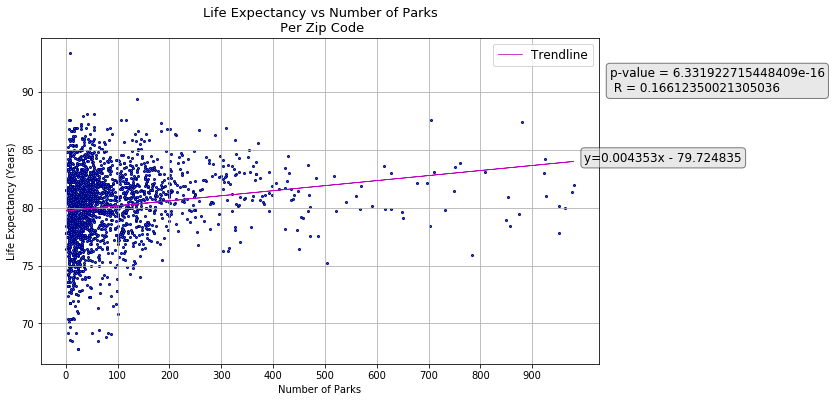

In [45]:
# Set figure size
plt.figure(figsize=(10,6))

# Scatter plot of life expectancy verses number of parks, set marker size to 4
plt.scatter(y_parks_all,x_life_all,4,edgecolor='darkblue')

# Label axes, add title
plt.ylabel('Life Expectancy (Years)')
plt.xlabel('Number of Parks')
plt.title('Life Expectancy vs Number of Parks\n Per Zip Code',size=13)
plt.yticks(np.arange(0,100,5))
plt.xticks(np.arange(0,1000,100))
plt.grid()


# Calculate and add trendline
z = np.polyfit(y_parks_all,x_life_all, 1)

p = np.poly1d(z)

props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

# Plot the trendline equation to graph
plt.text(1305,84,"y=%.6fx - %.6f"%(z[0],abs(z[1])), ha='right',size=12, bbox=props)

# plot the p-value and correlation coefficient to graph
plt.text(1050,90,f"p-value = {str(p_value)}\n R = {corr_coeff_all}",size=12,bbox=props)

# Plot trendline
plb.plot(y_parks_all, p(y_parks_all), 'm-',linewidth=.75)

# Add legend
plt.legend(['Trendline'],fontsize=12)

# Save the figure
plt.savefig('Images/parks_scatter.png',bbox_inches="tight")

## Conclusion:

Null Hypothesis: People who live near parks have a lower life expectancy 

Alternative Hypothesis: People who live near parks do not have a lower life expectancy

Testing at alpha = 0.05 

Since the p-value is 6.33192e-16, which is less than alpha=0.05, we reject the null hypothesis. The results are  statistically significant at the alpha = 0.05 level. We reject the null hypothesis with 95% confidence.

As the graph shows, the linear trendline is has a positive slope. Thus there is a weak positive correlation between life expectancy and number of parks per zip code. 